**Domain Background**：


        这是一个来自于Kaggle的真实竞赛项目，项目要求预测Rossmann的日常销售。Rossmann是一个在7个欧洲国家经营着3,000多家药店。目前，Rossmann商店经理的任务是预先提前六周预测他们的日常销售。商店销售受许多因素的影响，包括促销，竞争，学校和州假日，季节性和地方性。成千上万的个体经理根据他们独特的情况预测销售情况，结果的准确性可能会有很大差异。
    在Kaggle的比赛中，Rossmann向您提出挑战，要求您预测德国各地的1,115家商店每周销售6周。可靠的销售预测可以使商店经理能够创建有效的员工时间表，从而提高生产力和动力。通过帮助Rossmann创建一个强大的预测模型，您将帮助商店经理专注于对他们最重要的事情：他们的客户和他们的团队！ 
之所以选择这个项目，是因为该项目与我的实际工作中亟待解决的问题同出一辙。


**Problem Statement**：


        该项目的具体任务是在1,115家Rossmann商店的历史销售数据中预测测试集的“Sales”列，这属于线性回归类的需求。可以通过构建一个有监督学习类的模型来减少预测值（ŷ）与实际值（y）之间的误差来解决本需求。
    使用Kaggle的RMSPE 函数来验证真实的销售数据与预测数据的差异性。RMSPE 函数：

<img src="rmspe.png" width="20%"></img>

In [2]:
#导入所需要的库
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import xgboost as xgb
from time import time

In [3]:
#读取数据
train = pd.read_csv('train.csv',parse_dates=[2])
test = pd.read_csv('test.csv',parse_dates=[3])
store = pd.read_csv('store.csv')

C:\Users\79611\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#查看训练集
train.head().append(train.tail())

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1            2          5 2015-07-31   6064        625     1      1   
2            3          5 2015-07-31   8314        821     1      1   
3            4          5 2015-07-31  13995       1498     1      1   
4            5          5 2015-07-31   4822        559     1      1   
1017204   1111          2 2013-01-01      0          0     0      0   
1017205   1112          2 2013-01-01      0          0     0      0   
1017206   1113          2 2013-01-01      0          0     0      0   
1017207   1114          2 2013-01-01      0          0     0      0   
1017208   1115          2 2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday  
0                  0              1  
1                  0              1  
2                  0              1  
3                  0              1  
4                  0              1  
1017204            a              1  
1017205            a              1  
1017206            a              1  
1017207            a              1  
1017208            a              1

In [5]:
#查看测试集
test.head().append(test.tail())


Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  \
0          1      1          4 2015-09-17   1.0      1            0   
1          2      3          4 2015-09-17   1.0      1            0   
2          3      7          4 2015-09-17   1.0      1            0   
3          4      8          4 2015-09-17   1.0      1            0   
4          5      9          4 2015-09-17   1.0      1            0   
41083  41084   1111          6 2015-08-01   1.0      0            0   
41084  41085   1112          6 2015-08-01   1.0      0            0   
41085  41086   1113          6 2015-08-01   1.0      0            0   
41086  41087   1114          6 2015-08-01   1.0      0            0   
41087  41088   1115          6 2015-08-01   1.0      0            0   

       SchoolHoliday  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
41083              0  
41084              0  
41085              0  
41086              0  
41087              1

In [6]:
#查看店铺信息
store.head().append(store.tail())

Store StoreType Assortment  CompetitionDistance  \
0         1         c          a               1270.0   
1         2         a          a                570.0   
2         3         a          a              14130.0   
3         4         c          c                620.0   
4         5         a          a              29910.0   
1110   1111         a          a               1900.0   
1111   1112         c          c               1880.0   
1112   1113         a          c               9260.0   
1113   1114         a          c                870.0   
1114   1115         d          c               5350.0   

      CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                           9.0                    2008.0       0   
1                          11.0                    2007.0       1   
2                          12.0                    2006.0       1   
3                           9.0                    2009.0       0   
4                           4.0                    2015.0       0   
1110                        6.0                    2014.0       1   
1111                        4.0                    2006.0       0   
1112                        NaN                       NaN       0   
1113                        NaN                       NaN       0   
1114                        NaN                       NaN       1   

      Promo2SinceWeek  Promo2SinceYear     PromoInterval  
0                 NaN              NaN               NaN  
1                13.0           2010.0   Jan,Apr,Jul,Oct  
2                14.0           2011.0   Jan,Apr,Jul,Oct  
3                 NaN              NaN               NaN  
4                 NaN              NaN               NaN  
1110             31.0           2013.0   Jan,Apr,Jul,Oct  
1111              NaN              NaN               NaN  
1112              NaN              NaN               NaN  
1113              NaN              NaN               NaN  
1114             22.0           2012.0  Mar,Jun,Sept,Dec

In [7]:
#查看数据缺失
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [8]:
#缺失数据分析
#测试集缺失数据
test[pd.isnull(test.Open)]


Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  \
479      480    622          4 2015-09-17   NaN      1            0   
1335    1336    622          3 2015-09-16   NaN      1            0   
2191    2192    622          2 2015-09-15   NaN      1            0   
3047    3048    622          1 2015-09-14   NaN      1            0   
4759    4760    622          6 2015-09-12   NaN      0            0   
5615    5616    622          5 2015-09-11   NaN      0            0   
6471    6472    622          4 2015-09-10   NaN      0            0   
7327    7328    622          3 2015-09-09   NaN      0            0   
8183    8184    622          2 2015-09-08   NaN      0            0   
9039    9040    622          1 2015-09-07   NaN      0            0   
10751  10752    622          6 2015-09-05   NaN      0            0   

       SchoolHoliday  
479                0  
1335               0  
2191               0  
3047               0  
4759               0  
5615               0  
6471               0  
7327               0  
8183               0  
9039               0  
10751              0

# - 缺失数据都来自于622店铺，从周1到周6而且没有假期，所以我们认为这个店铺的状态应该是正常营业的

In [9]:
#店铺集缺失数据
store[pd.isnull(store.CompetitionDistance)]

Store StoreType Assortment  CompetitionDistance  \
290    291         d          a                  NaN   
621    622         a          c                  NaN   
878    879         d          a                  NaN   

     CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
290                        NaN                       NaN       0   
621                        NaN                       NaN       0   
878                        NaN                       NaN       1   

     Promo2SinceWeek  Promo2SinceYear    PromoInterval  
290              NaN              NaN              NaN  
621              NaN              NaN              NaN  
878              5.0           2013.0  Feb,May,Aug,Nov

In [10]:
store[pd.isnull(store.CompetitionOpenSinceMonth)].head(10)

Store StoreType Assortment  CompetitionDistance  \
11     12         a          c               1070.0   
12     13         d          a                310.0   
15     16         a          c               3270.0   
18     19         a          c               3240.0   
21     22         a          a               1040.0   
25     26         d          a               2300.0   
28     29         d          c               2170.0   
31     32         a          a               2910.0   
39     40         a          a                180.0   
40     41         d          c               1180.0   

    CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
11                        NaN                       NaN       1   
12                        NaN                       NaN       1   
15                        NaN                       NaN       0   
18                        NaN                       NaN       1   
21                        NaN                       NaN       1   
25                        NaN                       NaN       0   
28                        NaN                       NaN       0   
31                        NaN                       NaN       1   
39                        NaN                       NaN       1   
40                        NaN                       NaN       1   

    Promo2SinceWeek  Promo2SinceYear     PromoInterval  
11             13.0           2010.0   Jan,Apr,Jul,Oct  
12             45.0           2009.0   Feb,May,Aug,Nov  
15              NaN              NaN               NaN  
18             22.0           2011.0  Mar,Jun,Sept,Dec  
21             22.0           2012.0   Jan,Apr,Jul,Oct  
25              NaN              NaN               NaN  
28              NaN              NaN               NaN  
31             45.0           2009.0   Feb,May,Aug,Nov  
39             45.0           2009.0   Feb,May,Aug,Nov  
40             31.0           2013.0   Jan,Apr,Jul,Oct

In [11]:
#查看是否Promo2系列的缺失是否是因为没有参加促销
NoPW = store[pd.isnull(store.Promo2SinceWeek)]
NoPW[NoPW.Promo2 != 0].shape

(0, 10)

# - 店铺竞争数据缺失的原因不明，且数量比较多，我们可以用中值或者0来填充，后续的实验发现以0填充的效果更好
# - 店铺促销信息的缺失是因为没有参加促销活动，所以我们以0填充


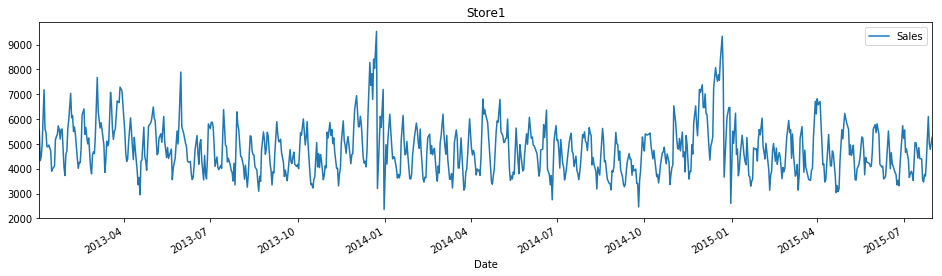

In [12]:

#分析店铺销量随时间的变化
strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']]     .plot(x='Date',y='Sales',title='Store1',figsize=(16,4))


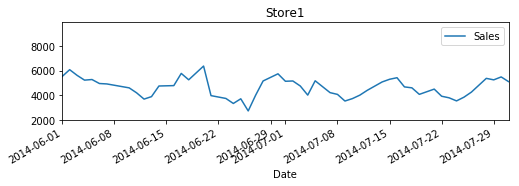

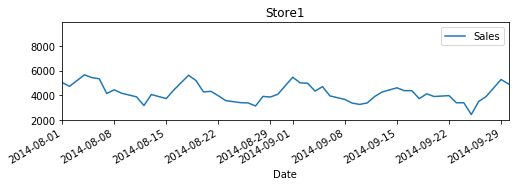

In [13]:
#分析店铺6-9月份的销量变化
strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']]     .plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-6-1','2014-7-31'])
strain.loc[strain['Store']==1 ,['Date','Sales']]     .plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-8-1','2014-9-30'])


# - 从上图的分析中，我们可以看到店铺的销售额是有周期性变化的，一年之中11，12月份销量要高于其他月份，可能有季节因素或者促销等原因.
# - 此外从对2014年6月-9月份的销量来看，6，7月份的销售趋势与8，9月份类似，因为我们需要预测的6周在2015年8，9月份，因此我们可以把2015年6，7月份最近的6周数据作为hold-out数据集，用于模型的优化和验证。
 
# 2.数据预处理


In [14]:
#缺失值处理
#我们将test中的open数据补为1，即营业状态
test.fillna(1, inplace=True)
#store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
#store['CompetitionOpenScinceYear'].fillna(store['CompetitionDistance'].median(), inplace = True)
#store['CompetitionOPenScinceMonth'].fillna(store['CompetitionDistance'].median(), inplace = True)
 
#store中的缺失数据大多与竞争对手和促销有关，在实验中我们发现竞争对手信息的中值填充效果并不好，所以这里统一采用0填充

store.fillna(0, inplace=True)


In [15]:
#查看是否还存在缺失值
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Id               0
Store            0
DayOfWeek        0
Date             0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [16]:
#合并store信息
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

In [17]:
#留出最近的6周数据作为hold_out数据集进行测试
train = train.sort_values(['Date'],ascending = False)
ho_test = train[:6*7*1115]
ho_train = train[6*7*1115:]

In [18]:
#因为销售额为0的记录不计入评分，所以只采用店铺为开，且销售额大于0的数据进行训练
ho_test = ho_test[ho_test["Open"] != 0]
ho_test = ho_test[ho_test["Sales"] > 0]
ho_train = ho_train[ho_train["Open"] != 0]
ho_train = ho_train[ho_train["Sales"] > 0]



# 3.特征工程

In [19]:
#特征处理与转化，定义特征处理函数
def features_create(data):
    
    #将存在其他字符表示分类的特征转化为数字
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    #将时间特征进行拆分和转化，并加入'WeekOfYear'特征
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    #新增'CompetitionOpen'和'PromoOpen'特征,计算某天某店铺的竞争对手已营业时间和店铺已促销时间，用月为单位表示
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) +         (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +         (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
    #将'PromoInterval'特征转化为'IsPromoMonth'特征,表示某天某店铺是否处于促销月，1表示是，0表示否
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1
 
    return data

In [20]:
#对训练，保留以及测试数据集进行特征转化
features_create(ho_train)
features_create(ho_test)
features_create(test)
print('Features creation finished！')

Features creation finished！


In [21]:

#删掉训练和保留数据集中不需要的特征
ho_train.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)
ho_test.drop(['Date','Customers','Open','PromoInterval','monthStr'],axis=1,inplace =True)


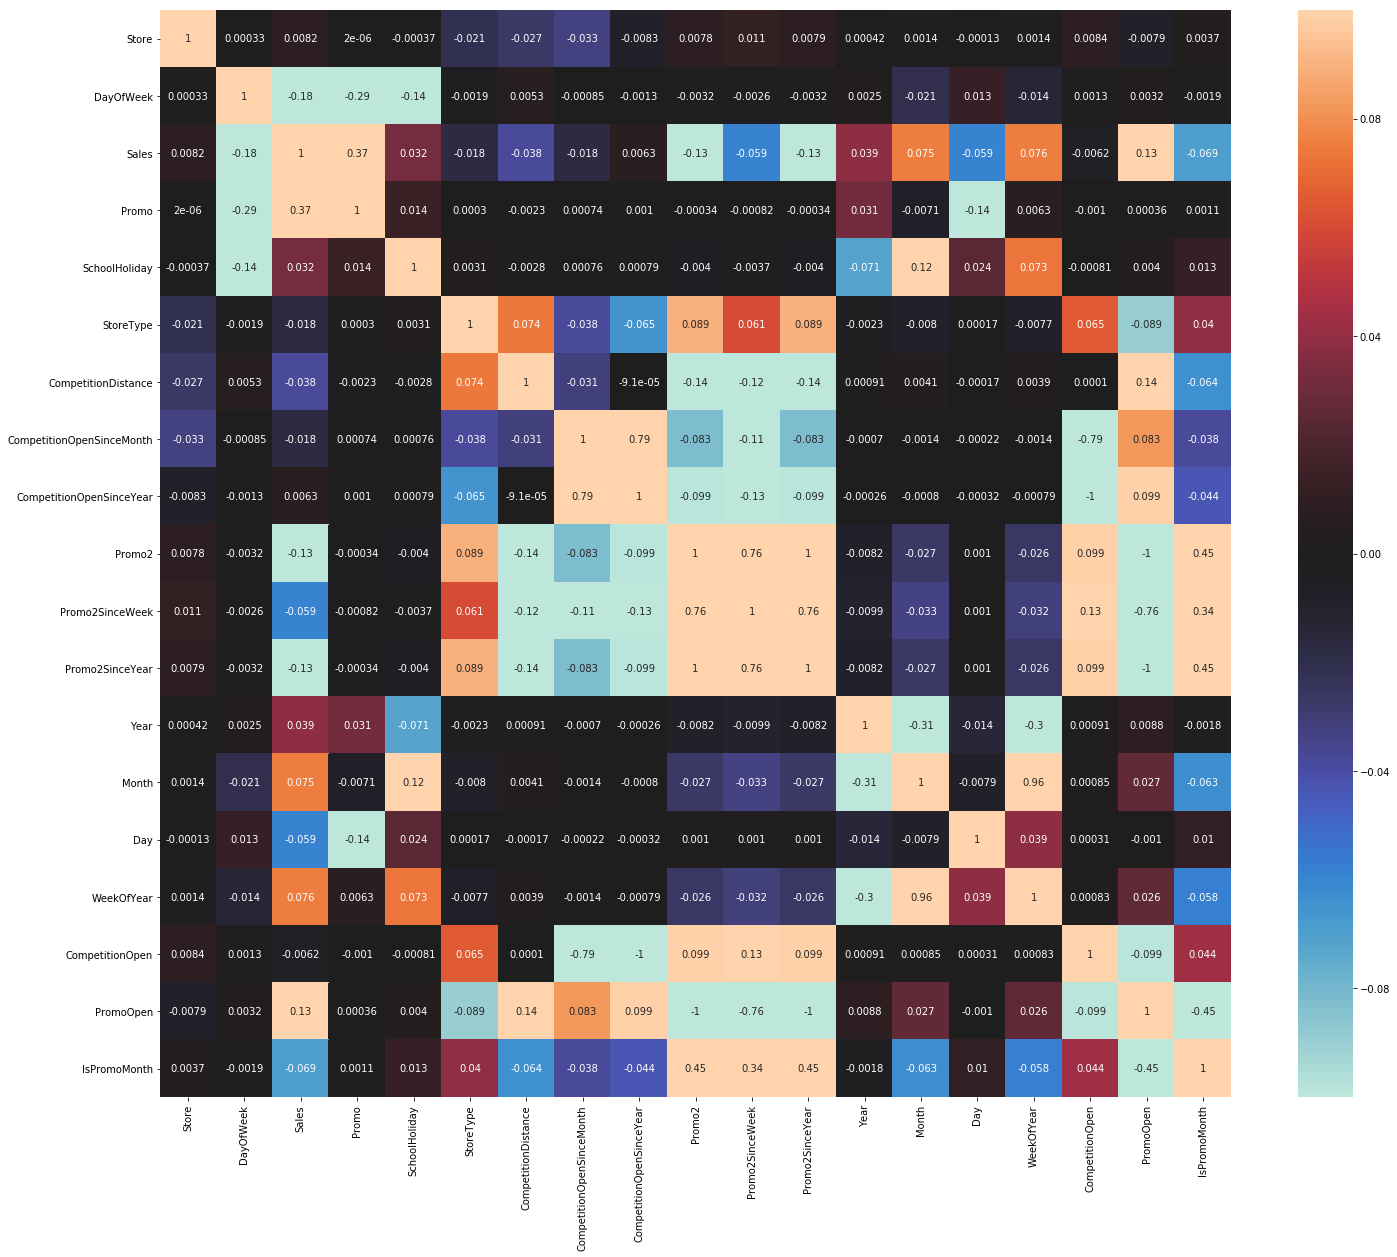

In [22]:
#分析训练数据集中特征相关性以及特征与'Sales'标签相关性
plt.subplots(figsize=(24,20))
sns.heatmap(ho_train.corr(),annot=True, vmin=-0.1, vmax=0.1,center=0)

In [23]:
#拆分特征与标签，并将标签取对数处理
ho_xtrain = ho_train.drop(['Sales'],axis=1 )
ho_ytrain = np.log1p(ho_train.Sales)
ho_xtest = ho_test.drop(['Sales'],axis=1 )
ho_ytest = np.log1p(ho_test.Sales)

In [24]:
#删掉测试集中对应的特征与训练集保持一致
xtest =test.drop(['Id','Date','Open','PromoInterval','monthStr'],axis = 1)

In [25]:
# 4.
 
#定义评价函数rmspe
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))
 
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [26]:
ho_xtrain['Assortment']

284584     1
417104     1
875290     3
119580     3
807974     1
856818     1
905823     1
189376     1
478010     3
725586     1
731996     3
675822     1
746332     3
35860      1
457080     1
148068     1
245734     1
256486     1
668654     3
755384     3
173546     1
518354     1
411636     3
874348     1
43028      1
604348     3
290052     3
812500     1
927695     3
883768     1
          ..
688598     3
138030     1
319600     1
265126     1
370858     3
419886     1
938587     1
682946     1
586200     1
148024     1
320542     3
672952     3
757224     1
467215     2
450995     1
512659     3
483619     3
386137     1
615999     2
621467     1
700661     2
667669     2
1000988    2
77677      1
305081     1
864127     2
321485     2
249459     2
235513     2
238339     1
Name: Assortment, Length: 804056, dtype: object

In [27]:
#通过pd.to_numeric将object类型转换为数值类型的数据。

In [47]:
ho_xtrain['StateHoliday'] = pd.to_numeric(ho_xtrain['StateHoliday'])

In [48]:
ho_xtrain['Assortment'] = pd.to_numeric(ho_xtrain['Assortment'])

In [49]:
ho_xtest['Assortment'] = pd.to_numeric(ho_xtest['Assortment'])

In [31]:
# 5.模型构建
#初始模型构建
#参数设定
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,         "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 10
          }
num_boost_round = 6000
 
 
dtrain = xgb.DMatrix(ho_xtrain, ho_ytrain)
dvalid = xgb.DMatrix(ho_xtest, ho_ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

C:\Users\79611\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [33]:
#模型训练
print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))

Train a XGBoost model
[0]	train-rmse:8.02076	eval-rmse:8.02752	train-rmspe:0.999809	eval-rmspe:0.999811
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78059	eval-rmse:7.78778	train-rmspe:0.999711	eval-rmspe:0.999714
[2]	train-rmse:7.54766	eval-rmse:7.55538	train-rmspe:0.999591	eval-rmspe:0.999596
[3]	train-rmse:7.32174	eval-rmse:7.32934	train-rmspe:0.999444	eval-rmspe:0.999451
[4]	train-rmse:7.1026	eval-rmse:7.11034	train-rmspe:0.999267	eval-rmspe:0.999277
[5]	train-rmse:6.89003	eval-rmse:6.89783	train-rmspe:0.999055	eval-rmspe:0.999067
[6]	train-rmse:6.68391	eval-rmse:6.69117	train-rmspe:0.9988	eval-rmspe:0.998814
[7]	train-rmse:6.48396	eval-rmse:6.49097	train-rmspe:0.998498	eval-rmspe:0.998516
[8]	train-rmse:6.28995	eval-rmse:6.29723	train-rmspe:0.998143	eval-rmspe:0.998165
[9]	train-rmse:6.10176	eval-rmse:6.10906	train-rmspe:0.997727	eval-rmspe:0.997754
[10]	train-rmse

[97]	train-rmse:0.489705	eval-rmse:0.484856	train-rmspe:0.379223	eval-rmspe:0.364062
[98]	train-rmse:0.478687	eval-rmse:0.473957	train-rmspe:0.37329	eval-rmspe:0.357693
[99]	train-rmse:0.468199	eval-rmse:0.463559	train-rmspe:0.367635	eval-rmspe:0.351581
[100]	train-rmse:0.457769	eval-rmse:0.453292	train-rmspe:0.362006	eval-rmspe:0.345509
[101]	train-rmse:0.447941	eval-rmse:0.443758	train-rmspe:0.35667	eval-rmspe:0.339851
[102]	train-rmse:0.438544	eval-rmse:0.434339	train-rmspe:0.35153	eval-rmspe:0.334259
[103]	train-rmse:0.429637	eval-rmse:0.425568	train-rmspe:0.34676	eval-rmspe:0.32906
[104]	train-rmse:0.420601	eval-rmse:0.416784	train-rmspe:0.341933	eval-rmspe:0.323802
[105]	train-rmse:0.412332	eval-rmse:0.408303	train-rmspe:0.337537	eval-rmspe:0.318797
[106]	train-rmse:0.403709	eval-rmse:0.399586	train-rmspe:0.332924	eval-rmspe:0.313605
[107]	train-rmse:0.395973	eval-rmse:0.391815	train-rmspe:0.328856	eval-rmspe:0.308996
[108]	train-rmse:0.388112	eval-rmse:0.38414	train-rmspe:0.3247

[193]	train-rmse:0.198547	eval-rmse:0.207687	train-rmspe:0.245051	eval-rmspe:0.219338
[194]	train-rmse:0.19813	eval-rmse:0.207371	train-rmspe:0.244952	eval-rmspe:0.219233
[195]	train-rmse:0.197923	eval-rmse:0.207234	train-rmspe:0.245042	eval-rmspe:0.2193
[196]	train-rmse:0.197699	eval-rmse:0.207068	train-rmspe:0.245149	eval-rmspe:0.21934
[197]	train-rmse:0.19732	eval-rmse:0.206752	train-rmspe:0.244966	eval-rmspe:0.219185
[198]	train-rmse:0.196771	eval-rmse:0.206187	train-rmspe:0.244357	eval-rmspe:0.218865
[199]	train-rmse:0.196476	eval-rmse:0.206069	train-rmspe:0.244214	eval-rmspe:0.219029
[200]	train-rmse:0.196013	eval-rmse:0.205663	train-rmspe:0.243991	eval-rmspe:0.218724
[201]	train-rmse:0.19568	eval-rmse:0.205401	train-rmspe:0.243887	eval-rmspe:0.218639
[202]	train-rmse:0.194834	eval-rmse:0.204667	train-rmspe:0.243128	eval-rmspe:0.217896
[203]	train-rmse:0.194681	eval-rmse:0.204581	train-rmspe:0.243162	eval-rmspe:0.217973
[204]	train-rmse:0.194182	eval-rmse:0.20415	train-rmspe:0.24

[289]	train-rmse:0.15798	eval-rmse:0.172205	train-rmspe:0.207035	eval-rmspe:0.186754
[290]	train-rmse:0.157554	eval-rmse:0.171781	train-rmspe:0.206728	eval-rmspe:0.186311
[291]	train-rmse:0.157239	eval-rmse:0.171507	train-rmspe:0.206319	eval-rmspe:0.186011
[292]	train-rmse:0.157014	eval-rmse:0.171338	train-rmspe:0.205943	eval-rmspe:0.185856
[293]	train-rmse:0.156834	eval-rmse:0.171177	train-rmspe:0.205793	eval-rmspe:0.185681
[294]	train-rmse:0.156736	eval-rmse:0.171234	train-rmspe:0.205635	eval-rmspe:0.185823
[295]	train-rmse:0.156066	eval-rmse:0.170678	train-rmspe:0.204956	eval-rmspe:0.185163
[296]	train-rmse:0.155822	eval-rmse:0.170462	train-rmspe:0.204748	eval-rmspe:0.184932
[297]	train-rmse:0.155264	eval-rmse:0.170012	train-rmspe:0.204265	eval-rmspe:0.184452
[298]	train-rmse:0.155093	eval-rmse:0.169861	train-rmspe:0.204119	eval-rmspe:0.184285
[299]	train-rmse:0.154854	eval-rmse:0.169649	train-rmspe:0.203794	eval-rmspe:0.184049
[300]	train-rmse:0.154296	eval-rmse:0.169172	train-rmsp

[385]	train-rmse:0.135275	eval-rmse:0.152985	train-rmspe:0.179095	eval-rmspe:0.165827
[386]	train-rmse:0.134963	eval-rmse:0.152718	train-rmspe:0.178819	eval-rmspe:0.165531
[387]	train-rmse:0.134815	eval-rmse:0.152612	train-rmspe:0.178471	eval-rmspe:0.165424
[388]	train-rmse:0.13477	eval-rmse:0.152578	train-rmspe:0.17773	eval-rmspe:0.165385
[389]	train-rmse:0.134666	eval-rmse:0.152669	train-rmspe:0.177514	eval-rmspe:0.165569
[390]	train-rmse:0.134561	eval-rmse:0.152763	train-rmspe:0.177355	eval-rmspe:0.165757
[391]	train-rmse:0.134508	eval-rmse:0.152721	train-rmspe:0.177277	eval-rmspe:0.165711
[392]	train-rmse:0.134427	eval-rmse:0.152532	train-rmspe:0.177189	eval-rmspe:0.165528
[393]	train-rmse:0.13427	eval-rmse:0.152402	train-rmspe:0.177052	eval-rmspe:0.165368
[394]	train-rmse:0.134067	eval-rmse:0.152239	train-rmspe:0.176792	eval-rmspe:0.165189
[395]	train-rmse:0.134033	eval-rmse:0.152195	train-rmspe:0.176785	eval-rmspe:0.165156
[396]	train-rmse:0.133682	eval-rmse:0.151892	train-rmspe:

[481]	train-rmse:0.120724	eval-rmse:0.14184	train-rmspe:0.156052	eval-rmspe:0.15409
[482]	train-rmse:0.120607	eval-rmse:0.14168	train-rmspe:0.155947	eval-rmspe:0.153902
[483]	train-rmse:0.120549	eval-rmse:0.141661	train-rmspe:0.155842	eval-rmspe:0.153888
[484]	train-rmse:0.120486	eval-rmse:0.141603	train-rmspe:0.155778	eval-rmspe:0.153832
[485]	train-rmse:0.120416	eval-rmse:0.141549	train-rmspe:0.155717	eval-rmspe:0.153775
[486]	train-rmse:0.120305	eval-rmse:0.141451	train-rmspe:0.155615	eval-rmspe:0.153661
[487]	train-rmse:0.120202	eval-rmse:0.141371	train-rmspe:0.155531	eval-rmspe:0.153571
[488]	train-rmse:0.120112	eval-rmse:0.141301	train-rmspe:0.155444	eval-rmspe:0.153501
[489]	train-rmse:0.119935	eval-rmse:0.141164	train-rmspe:0.155266	eval-rmspe:0.153368
[490]	train-rmse:0.119755	eval-rmse:0.141012	train-rmspe:0.155107	eval-rmspe:0.153183
[491]	train-rmse:0.119688	eval-rmse:0.140964	train-rmspe:0.15505	eval-rmspe:0.153141
[492]	train-rmse:0.119507	eval-rmse:0.140854	train-rmspe:0

[577]	train-rmse:0.112089	eval-rmse:0.135101	train-rmspe:0.138467	eval-rmspe:0.146661
[578]	train-rmse:0.111962	eval-rmse:0.135003	train-rmspe:0.138301	eval-rmspe:0.14655
[579]	train-rmse:0.111913	eval-rmse:0.134967	train-rmspe:0.138255	eval-rmspe:0.146511
[580]	train-rmse:0.111856	eval-rmse:0.134985	train-rmspe:0.138191	eval-rmspe:0.146534
[581]	train-rmse:0.111808	eval-rmse:0.13488	train-rmspe:0.138155	eval-rmspe:0.146396
[582]	train-rmse:0.111774	eval-rmse:0.134854	train-rmspe:0.137787	eval-rmspe:0.14637
[583]	train-rmse:0.111724	eval-rmse:0.134887	train-rmspe:0.137735	eval-rmspe:0.146418
[584]	train-rmse:0.111656	eval-rmse:0.134835	train-rmspe:0.13699	eval-rmspe:0.146367
[585]	train-rmse:0.111565	eval-rmse:0.134766	train-rmspe:0.1369	eval-rmspe:0.146291
[586]	train-rmse:0.111527	eval-rmse:0.134671	train-rmspe:0.13687	eval-rmspe:0.146162
[587]	train-rmse:0.111448	eval-rmse:0.134629	train-rmspe:0.136796	eval-rmspe:0.146118
[588]	train-rmse:0.111376	eval-rmse:0.13455	train-rmspe:0.136

[673]	train-rmse:0.105817	eval-rmse:0.130902	train-rmspe:0.124401	eval-rmspe:0.142132
[674]	train-rmse:0.105773	eval-rmse:0.130869	train-rmspe:0.124355	eval-rmspe:0.142097
[675]	train-rmse:0.105623	eval-rmse:0.13078	train-rmspe:0.124207	eval-rmspe:0.141993
[676]	train-rmse:0.105592	eval-rmse:0.13076	train-rmspe:0.124177	eval-rmspe:0.141968
[677]	train-rmse:0.105536	eval-rmse:0.130714	train-rmspe:0.124122	eval-rmspe:0.141914
[678]	train-rmse:0.105492	eval-rmse:0.130693	train-rmspe:0.12408	eval-rmspe:0.141894
[679]	train-rmse:0.10546	eval-rmse:0.13068	train-rmspe:0.124052	eval-rmspe:0.141883
[680]	train-rmse:0.10537	eval-rmse:0.13062	train-rmspe:0.123967	eval-rmspe:0.141819
[681]	train-rmse:0.105299	eval-rmse:0.13058	train-rmspe:0.123902	eval-rmspe:0.141779
[682]	train-rmse:0.105166	eval-rmse:0.130506	train-rmspe:0.123768	eval-rmspe:0.14169
[683]	train-rmse:0.105134	eval-rmse:0.130487	train-rmspe:0.123736	eval-rmspe:0.141669
[684]	train-rmse:0.105085	eval-rmse:0.130456	train-rmspe:0.1236

[769]	train-rmse:0.100293	eval-rmse:0.127582	train-rmspe:0.11828	eval-rmspe:0.13855
[770]	train-rmse:0.100256	eval-rmse:0.127578	train-rmspe:0.118245	eval-rmspe:0.138551
[771]	train-rmse:0.100188	eval-rmse:0.127544	train-rmspe:0.118168	eval-rmspe:0.138518
[772]	train-rmse:0.100132	eval-rmse:0.127506	train-rmspe:0.118092	eval-rmspe:0.138482
[773]	train-rmse:0.100093	eval-rmse:0.12748	train-rmspe:0.118058	eval-rmspe:0.138456
[774]	train-rmse:0.100051	eval-rmse:0.127468	train-rmspe:0.118013	eval-rmspe:0.138442
[775]	train-rmse:0.100003	eval-rmse:0.12744	train-rmspe:0.117967	eval-rmspe:0.138412
[776]	train-rmse:0.099982	eval-rmse:0.127431	train-rmspe:0.117946	eval-rmspe:0.138403
[777]	train-rmse:0.099933	eval-rmse:0.127416	train-rmspe:0.117899	eval-rmspe:0.138384
[778]	train-rmse:0.099891	eval-rmse:0.127383	train-rmspe:0.11786	eval-rmspe:0.138344
[779]	train-rmse:0.099841	eval-rmse:0.127306	train-rmspe:0.117789	eval-rmspe:0.138253
[780]	train-rmse:0.099779	eval-rmse:0.127271	train-rmspe:0.

[865]	train-rmse:0.095814	eval-rmse:0.124993	train-rmspe:0.112654	eval-rmspe:0.13572
[866]	train-rmse:0.09578	eval-rmse:0.124973	train-rmspe:0.112623	eval-rmspe:0.135699
[867]	train-rmse:0.095759	eval-rmse:0.124982	train-rmspe:0.112601	eval-rmspe:0.135711
[868]	train-rmse:0.095747	eval-rmse:0.124975	train-rmspe:0.112467	eval-rmspe:0.135704
[869]	train-rmse:0.095719	eval-rmse:0.124961	train-rmspe:0.112441	eval-rmspe:0.135694
[870]	train-rmse:0.095623	eval-rmse:0.1249	train-rmspe:0.112357	eval-rmspe:0.135627
[871]	train-rmse:0.095588	eval-rmse:0.124884	train-rmspe:0.112326	eval-rmspe:0.135612
[872]	train-rmse:0.095555	eval-rmse:0.124845	train-rmspe:0.112293	eval-rmspe:0.135571
[873]	train-rmse:0.095475	eval-rmse:0.124801	train-rmspe:0.112217	eval-rmspe:0.13552
[874]	train-rmse:0.095429	eval-rmse:0.124809	train-rmspe:0.112169	eval-rmspe:0.135516
[875]	train-rmse:0.09537	eval-rmse:0.124773	train-rmspe:0.112114	eval-rmspe:0.135476
[876]	train-rmse:0.095349	eval-rmse:0.12477	train-rmspe:0.11

[961]	train-rmse:0.092516	eval-rmse:0.123351	train-rmspe:0.108754	eval-rmspe:0.133861
[962]	train-rmse:0.092497	eval-rmse:0.123344	train-rmspe:0.108733	eval-rmspe:0.13385
[963]	train-rmse:0.092481	eval-rmse:0.123337	train-rmspe:0.108717	eval-rmspe:0.133847
[964]	train-rmse:0.092441	eval-rmse:0.12331	train-rmspe:0.108633	eval-rmspe:0.133818
[965]	train-rmse:0.092434	eval-rmse:0.123298	train-rmspe:0.108629	eval-rmspe:0.133796
[966]	train-rmse:0.092384	eval-rmse:0.123277	train-rmspe:0.108579	eval-rmspe:0.133771
[967]	train-rmse:0.092348	eval-rmse:0.123264	train-rmspe:0.108545	eval-rmspe:0.133756
[968]	train-rmse:0.092298	eval-rmse:0.123232	train-rmspe:0.108496	eval-rmspe:0.133725
[969]	train-rmse:0.092273	eval-rmse:0.123222	train-rmspe:0.108457	eval-rmspe:0.133715
[970]	train-rmse:0.092246	eval-rmse:0.123216	train-rmspe:0.108427	eval-rmspe:0.133714
[971]	train-rmse:0.092235	eval-rmse:0.123188	train-rmspe:0.108411	eval-rmspe:0.133679
[972]	train-rmse:0.092213	eval-rmse:0.12319	train-rmspe:

[1057]	train-rmse:0.089691	eval-rmse:0.12216	train-rmspe:0.104549	eval-rmspe:0.132599
[1058]	train-rmse:0.089666	eval-rmse:0.122156	train-rmspe:0.104512	eval-rmspe:0.132594
[1059]	train-rmse:0.089638	eval-rmse:0.122143	train-rmspe:0.104485	eval-rmspe:0.132578
[1060]	train-rmse:0.08962	eval-rmse:0.122139	train-rmspe:0.104464	eval-rmspe:0.132574
[1061]	train-rmse:0.089601	eval-rmse:0.122128	train-rmspe:0.104446	eval-rmspe:0.132561
[1062]	train-rmse:0.089558	eval-rmse:0.122104	train-rmspe:0.104402	eval-rmspe:0.132538
[1063]	train-rmse:0.08951	eval-rmse:0.122075	train-rmspe:0.104356	eval-rmspe:0.13251
[1064]	train-rmse:0.089498	eval-rmse:0.122062	train-rmspe:0.104346	eval-rmspe:0.132494
[1065]	train-rmse:0.089471	eval-rmse:0.12205	train-rmspe:0.104303	eval-rmspe:0.132481
[1066]	train-rmse:0.089449	eval-rmse:0.122043	train-rmspe:0.10428	eval-rmspe:0.132479
[1067]	train-rmse:0.089427	eval-rmse:0.122039	train-rmspe:0.10426	eval-rmspe:0.132475
[1068]	train-rmse:0.089395	eval-rmse:0.122022	trai

[1152]	train-rmse:0.087409	eval-rmse:0.121251	train-rmspe:0.10111	eval-rmspe:0.131615
[1153]	train-rmse:0.087391	eval-rmse:0.121251	train-rmspe:0.101092	eval-rmspe:0.131615
[1154]	train-rmse:0.087382	eval-rmse:0.121246	train-rmspe:0.101093	eval-rmspe:0.131611
[1155]	train-rmse:0.08736	eval-rmse:0.121236	train-rmspe:0.101063	eval-rmspe:0.131596
[1156]	train-rmse:0.087344	eval-rmse:0.121233	train-rmspe:0.101047	eval-rmspe:0.131592
[1157]	train-rmse:0.08731	eval-rmse:0.121207	train-rmspe:0.10101	eval-rmspe:0.131562
[1158]	train-rmse:0.087284	eval-rmse:0.121198	train-rmspe:0.10098	eval-rmspe:0.131553
[1159]	train-rmse:0.087275	eval-rmse:0.121185	train-rmspe:0.100972	eval-rmspe:0.131535
[1160]	train-rmse:0.08724	eval-rmse:0.121171	train-rmspe:0.100938	eval-rmspe:0.131525
[1161]	train-rmse:0.087216	eval-rmse:0.121158	train-rmspe:0.100846	eval-rmspe:0.131511
[1162]	train-rmse:0.087194	eval-rmse:0.121152	train-rmspe:0.100821	eval-rmspe:0.131503
[1163]	train-rmse:0.08718	eval-rmse:0.121147	trai

[1247]	train-rmse:0.085542	eval-rmse:0.120692	train-rmspe:0.098182	eval-rmspe:0.131033
[1248]	train-rmse:0.085514	eval-rmse:0.12068	train-rmspe:0.098153	eval-rmspe:0.131019
[1249]	train-rmse:0.085501	eval-rmse:0.120681	train-rmspe:0.098133	eval-rmspe:0.131019
[1250]	train-rmse:0.085476	eval-rmse:0.120668	train-rmspe:0.098107	eval-rmspe:0.131007
[1251]	train-rmse:0.085457	eval-rmse:0.120661	train-rmspe:0.098088	eval-rmspe:0.130999
[1252]	train-rmse:0.085433	eval-rmse:0.120651	train-rmspe:0.098061	eval-rmspe:0.130988
[1253]	train-rmse:0.085412	eval-rmse:0.12064	train-rmspe:0.098043	eval-rmspe:0.130978
[1254]	train-rmse:0.085398	eval-rmse:0.120637	train-rmspe:0.098026	eval-rmspe:0.130981
[1255]	train-rmse:0.085393	eval-rmse:0.120633	train-rmspe:0.098024	eval-rmspe:0.130974
[1256]	train-rmse:0.085387	eval-rmse:0.120632	train-rmspe:0.098018	eval-rmspe:0.130974
[1257]	train-rmse:0.085368	eval-rmse:0.120623	train-rmspe:0.097994	eval-rmspe:0.13096
[1258]	train-rmse:0.085352	eval-rmse:0.120623	

[1342]	train-rmse:0.083746	eval-rmse:0.120152	train-rmspe:0.095718	eval-rmspe:0.130454
[1343]	train-rmse:0.08372	eval-rmse:0.120147	train-rmspe:0.095664	eval-rmspe:0.130449
[1344]	train-rmse:0.083695	eval-rmse:0.120136	train-rmspe:0.09564	eval-rmspe:0.130438
[1345]	train-rmse:0.083683	eval-rmse:0.12013	train-rmspe:0.095629	eval-rmspe:0.130433
[1346]	train-rmse:0.083661	eval-rmse:0.120121	train-rmspe:0.095585	eval-rmspe:0.130428
[1347]	train-rmse:0.08365	eval-rmse:0.120108	train-rmspe:0.095569	eval-rmspe:0.130409
[1348]	train-rmse:0.083628	eval-rmse:0.120106	train-rmspe:0.095548	eval-rmspe:0.13041
[1349]	train-rmse:0.083612	eval-rmse:0.12011	train-rmspe:0.095519	eval-rmspe:0.130417
[1350]	train-rmse:0.083602	eval-rmse:0.120102	train-rmspe:0.095508	eval-rmspe:0.13041
[1351]	train-rmse:0.083592	eval-rmse:0.120101	train-rmspe:0.095498	eval-rmspe:0.13041
[1352]	train-rmse:0.083577	eval-rmse:0.120098	train-rmspe:0.095484	eval-rmspe:0.130406
[1353]	train-rmse:0.083561	eval-rmse:0.120094	train

[1437]	train-rmse:0.082169	eval-rmse:0.119844	train-rmspe:0.093402	eval-rmspe:0.130118
[1438]	train-rmse:0.082156	eval-rmse:0.119839	train-rmspe:0.093386	eval-rmspe:0.130113
[1439]	train-rmse:0.082135	eval-rmse:0.119829	train-rmspe:0.093357	eval-rmspe:0.130104
[1440]	train-rmse:0.082108	eval-rmse:0.119819	train-rmspe:0.093318	eval-rmspe:0.130096
[1441]	train-rmse:0.082087	eval-rmse:0.11981	train-rmspe:0.093296	eval-rmspe:0.130089
[1442]	train-rmse:0.082076	eval-rmse:0.119807	train-rmspe:0.093281	eval-rmspe:0.130085
[1443]	train-rmse:0.082054	eval-rmse:0.119799	train-rmspe:0.093257	eval-rmspe:0.130076
[1444]	train-rmse:0.082034	eval-rmse:0.119813	train-rmspe:0.09323	eval-rmspe:0.130088
[1445]	train-rmse:0.081999	eval-rmse:0.119791	train-rmspe:0.093199	eval-rmspe:0.130065
[1446]	train-rmse:0.081986	eval-rmse:0.119785	train-rmspe:0.093187	eval-rmspe:0.130058
[1447]	train-rmse:0.081972	eval-rmse:0.119779	train-rmspe:0.093165	eval-rmspe:0.130051
[1448]	train-rmse:0.081962	eval-rmse:0.119783

[1532]	train-rmse:0.080691	eval-rmse:0.119432	train-rmspe:0.09108	eval-rmspe:0.129683
[1533]	train-rmse:0.080674	eval-rmse:0.119423	train-rmspe:0.09106	eval-rmspe:0.129674
[1534]	train-rmse:0.080653	eval-rmse:0.119415	train-rmspe:0.091041	eval-rmspe:0.12967
[1535]	train-rmse:0.080639	eval-rmse:0.119414	train-rmspe:0.091025	eval-rmspe:0.129671
[1536]	train-rmse:0.08063	eval-rmse:0.119409	train-rmspe:0.091013	eval-rmspe:0.129665
[1537]	train-rmse:0.08062	eval-rmse:0.119412	train-rmspe:0.091002	eval-rmspe:0.12967
[1538]	train-rmse:0.080606	eval-rmse:0.119407	train-rmspe:0.090983	eval-rmspe:0.129666
[1539]	train-rmse:0.080589	eval-rmse:0.119402	train-rmspe:0.09096	eval-rmspe:0.129655
[1540]	train-rmse:0.080586	eval-rmse:0.119399	train-rmspe:0.090962	eval-rmspe:0.129651
[1541]	train-rmse:0.080574	eval-rmse:0.119395	train-rmspe:0.090948	eval-rmspe:0.129647
[1542]	train-rmse:0.080564	eval-rmse:0.119395	train-rmspe:0.090938	eval-rmspe:0.129646
[1543]	train-rmse:0.080549	eval-rmse:0.119388	trai

[1627]	train-rmse:0.079377	eval-rmse:0.119122	train-rmspe:0.089013	eval-rmspe:0.129338
[1628]	train-rmse:0.079368	eval-rmse:0.119122	train-rmspe:0.089004	eval-rmspe:0.129337
[1629]	train-rmse:0.07936	eval-rmse:0.11912	train-rmspe:0.088993	eval-rmspe:0.129336
[1630]	train-rmse:0.079351	eval-rmse:0.119131	train-rmspe:0.088981	eval-rmspe:0.129346
[1631]	train-rmse:0.079343	eval-rmse:0.119128	train-rmspe:0.088936	eval-rmspe:0.129344
[1632]	train-rmse:0.079328	eval-rmse:0.119119	train-rmspe:0.088914	eval-rmspe:0.129332
[1633]	train-rmse:0.079314	eval-rmse:0.119117	train-rmspe:0.0889	eval-rmspe:0.129332
[1634]	train-rmse:0.079295	eval-rmse:0.119104	train-rmspe:0.08888	eval-rmspe:0.129317
[1635]	train-rmse:0.079281	eval-rmse:0.119094	train-rmspe:0.088862	eval-rmspe:0.129309
[1636]	train-rmse:0.079262	eval-rmse:0.119084	train-rmspe:0.088842	eval-rmspe:0.1293
[1637]	train-rmse:0.079251	eval-rmse:0.119084	train-rmspe:0.088833	eval-rmspe:0.129298
[1638]	train-rmse:0.079244	eval-rmse:0.119081	trai

[1722]	train-rmse:0.078245	eval-rmse:0.118831	train-rmspe:0.087389	eval-rmspe:0.129047
[1723]	train-rmse:0.078228	eval-rmse:0.118824	train-rmspe:0.087325	eval-rmspe:0.129041
[1724]	train-rmse:0.078213	eval-rmse:0.118827	train-rmspe:0.087301	eval-rmspe:0.129045
[1725]	train-rmse:0.078205	eval-rmse:0.118825	train-rmspe:0.087292	eval-rmspe:0.129043
[1726]	train-rmse:0.078188	eval-rmse:0.11883	train-rmspe:0.087273	eval-rmspe:0.129048
[1727]	train-rmse:0.078177	eval-rmse:0.118824	train-rmspe:0.087263	eval-rmspe:0.12904
[1728]	train-rmse:0.078167	eval-rmse:0.118819	train-rmspe:0.087253	eval-rmspe:0.129035
[1729]	train-rmse:0.078158	eval-rmse:0.118811	train-rmspe:0.087244	eval-rmspe:0.129021
[1730]	train-rmse:0.078142	eval-rmse:0.118805	train-rmspe:0.087195	eval-rmspe:0.129013
[1731]	train-rmse:0.078119	eval-rmse:0.11884	train-rmspe:0.087155	eval-rmspe:0.129061
[1732]	train-rmse:0.078097	eval-rmse:0.118831	train-rmspe:0.087131	eval-rmspe:0.12905
[1733]	train-rmse:0.078077	eval-rmse:0.118821	t

[1817]	train-rmse:0.07708	eval-rmse:0.118625	train-rmspe:0.085649	eval-rmspe:0.128845
[1818]	train-rmse:0.077067	eval-rmse:0.118625	train-rmspe:0.085609	eval-rmspe:0.128846
[1819]	train-rmse:0.077055	eval-rmse:0.118625	train-rmspe:0.085579	eval-rmspe:0.128845
[1820]	train-rmse:0.077045	eval-rmse:0.118623	train-rmspe:0.085568	eval-rmspe:0.128844
[1821]	train-rmse:0.077029	eval-rmse:0.118617	train-rmspe:0.085529	eval-rmspe:0.128838
[1822]	train-rmse:0.077024	eval-rmse:0.118615	train-rmspe:0.085523	eval-rmspe:0.128836
[1823]	train-rmse:0.077014	eval-rmse:0.118612	train-rmspe:0.085513	eval-rmspe:0.128833
[1824]	train-rmse:0.077001	eval-rmse:0.11861	train-rmspe:0.085498	eval-rmspe:0.128831
[1825]	train-rmse:0.076989	eval-rmse:0.118608	train-rmspe:0.085485	eval-rmspe:0.12883
[1826]	train-rmse:0.07698	eval-rmse:0.118606	train-rmspe:0.085474	eval-rmspe:0.128828
[1827]	train-rmse:0.07697	eval-rmse:0.118604	train-rmspe:0.085459	eval-rmspe:0.128824
[1828]	train-rmse:0.076959	eval-rmse:0.118599	tr

[1912]	train-rmse:0.076016	eval-rmse:0.118414	train-rmspe:0.084055	eval-rmspe:0.128637
[1913]	train-rmse:0.076006	eval-rmse:0.118407	train-rmspe:0.08404	eval-rmspe:0.128629
[1914]	train-rmse:0.075998	eval-rmse:0.118409	train-rmspe:0.084032	eval-rmspe:0.128629
[1915]	train-rmse:0.075984	eval-rmse:0.118403	train-rmspe:0.084019	eval-rmspe:0.128623
[1916]	train-rmse:0.075975	eval-rmse:0.1184	train-rmspe:0.08401	eval-rmspe:0.12862
[1917]	train-rmse:0.075962	eval-rmse:0.118395	train-rmspe:0.083995	eval-rmspe:0.128616
[1918]	train-rmse:0.07595	eval-rmse:0.118394	train-rmspe:0.083977	eval-rmspe:0.128615
[1919]	train-rmse:0.075938	eval-rmse:0.118394	train-rmspe:0.083965	eval-rmspe:0.128614
[1920]	train-rmse:0.075931	eval-rmse:0.118392	train-rmspe:0.083957	eval-rmspe:0.128611
[1921]	train-rmse:0.075923	eval-rmse:0.118392	train-rmspe:0.083948	eval-rmspe:0.128612
[1922]	train-rmse:0.075912	eval-rmse:0.118403	train-rmspe:0.083935	eval-rmspe:0.128623
[1923]	train-rmse:0.075897	eval-rmse:0.118401	tra

[2007]	train-rmse:0.075002	eval-rmse:0.118214	train-rmspe:0.082151	eval-rmspe:0.128431
[2008]	train-rmse:0.074994	eval-rmse:0.118217	train-rmspe:0.08214	eval-rmspe:0.128434
[2009]	train-rmse:0.074984	eval-rmse:0.118212	train-rmspe:0.082124	eval-rmspe:0.128427
[2010]	train-rmse:0.074965	eval-rmse:0.118206	train-rmspe:0.082105	eval-rmspe:0.128422
[2011]	train-rmse:0.074961	eval-rmse:0.118207	train-rmspe:0.082101	eval-rmspe:0.128423
[2012]	train-rmse:0.074948	eval-rmse:0.118203	train-rmspe:0.082088	eval-rmspe:0.128418
[2013]	train-rmse:0.074938	eval-rmse:0.1182	train-rmspe:0.082076	eval-rmspe:0.128415
[2014]	train-rmse:0.074924	eval-rmse:0.118195	train-rmspe:0.082061	eval-rmspe:0.128409
[2015]	train-rmse:0.074916	eval-rmse:0.118193	train-rmspe:0.082053	eval-rmspe:0.128408
[2016]	train-rmse:0.074906	eval-rmse:0.118194	train-rmspe:0.082041	eval-rmspe:0.128407
[2017]	train-rmse:0.074897	eval-rmse:0.118191	train-rmspe:0.082026	eval-rmspe:0.128402
[2018]	train-rmse:0.074885	eval-rmse:0.118184	

[2102]	train-rmse:0.074045	eval-rmse:0.11802	train-rmspe:0.080613	eval-rmspe:0.128221
[2103]	train-rmse:0.074032	eval-rmse:0.118008	train-rmspe:0.080595	eval-rmspe:0.128194
[2104]	train-rmse:0.074027	eval-rmse:0.118005	train-rmspe:0.08059	eval-rmspe:0.128191
[2105]	train-rmse:0.074018	eval-rmse:0.118003	train-rmspe:0.080581	eval-rmspe:0.128188
[2106]	train-rmse:0.07401	eval-rmse:0.118004	train-rmspe:0.080571	eval-rmspe:0.12819
[2107]	train-rmse:0.074001	eval-rmse:0.117997	train-rmspe:0.080558	eval-rmspe:0.128182
[2108]	train-rmse:0.07399	eval-rmse:0.117991	train-rmspe:0.080547	eval-rmspe:0.128171
[2109]	train-rmse:0.073981	eval-rmse:0.117988	train-rmspe:0.080535	eval-rmspe:0.128169
[2110]	train-rmse:0.073964	eval-rmse:0.117983	train-rmspe:0.080509	eval-rmspe:0.128165
[2111]	train-rmse:0.073957	eval-rmse:0.117981	train-rmspe:0.080501	eval-rmspe:0.128164
[2112]	train-rmse:0.073947	eval-rmse:0.117981	train-rmspe:0.080488	eval-rmspe:0.128163
[2113]	train-rmse:0.07394	eval-rmse:0.117982	tra

[2197]	train-rmse:0.07316	eval-rmse:0.117804	train-rmspe:0.079389	eval-rmspe:0.12797
[2198]	train-rmse:0.073148	eval-rmse:0.117802	train-rmspe:0.079378	eval-rmspe:0.127968
[2199]	train-rmse:0.073143	eval-rmse:0.1178	train-rmspe:0.079372	eval-rmspe:0.127962
[2200]	train-rmse:0.07313	eval-rmse:0.117797	train-rmspe:0.079359	eval-rmspe:0.127961
[2201]	train-rmse:0.073116	eval-rmse:0.117796	train-rmspe:0.079336	eval-rmspe:0.12796
[2202]	train-rmse:0.073102	eval-rmse:0.117787	train-rmspe:0.079315	eval-rmspe:0.127948
[2203]	train-rmse:0.073098	eval-rmse:0.117784	train-rmspe:0.079311	eval-rmspe:0.127945
[2204]	train-rmse:0.073084	eval-rmse:0.11778	train-rmspe:0.079293	eval-rmspe:0.127941
[2205]	train-rmse:0.073074	eval-rmse:0.117779	train-rmspe:0.079281	eval-rmspe:0.127939
[2206]	train-rmse:0.073068	eval-rmse:0.117774	train-rmspe:0.079278	eval-rmspe:0.127935
[2207]	train-rmse:0.073053	eval-rmse:0.117774	train-rmspe:0.079262	eval-rmspe:0.127935
[2208]	train-rmse:0.073045	eval-rmse:0.117774	trai

[2292]	train-rmse:0.072314	eval-rmse:0.117752	train-rmspe:0.078304	eval-rmspe:0.127931
[2293]	train-rmse:0.072308	eval-rmse:0.117753	train-rmspe:0.078297	eval-rmspe:0.127931
[2294]	train-rmse:0.072296	eval-rmse:0.11775	train-rmspe:0.078284	eval-rmspe:0.127926
[2295]	train-rmse:0.072289	eval-rmse:0.117746	train-rmspe:0.078273	eval-rmspe:0.127923
[2296]	train-rmse:0.072282	eval-rmse:0.117744	train-rmspe:0.078266	eval-rmspe:0.12792
[2297]	train-rmse:0.072278	eval-rmse:0.117745	train-rmspe:0.078261	eval-rmspe:0.127921
[2298]	train-rmse:0.072274	eval-rmse:0.11775	train-rmspe:0.078257	eval-rmspe:0.127928
[2299]	train-rmse:0.072267	eval-rmse:0.117747	train-rmspe:0.07825	eval-rmspe:0.127925
[2300]	train-rmse:0.072257	eval-rmse:0.117746	train-rmspe:0.078236	eval-rmspe:0.127922
[2301]	train-rmse:0.072254	eval-rmse:0.117744	train-rmspe:0.078233	eval-rmspe:0.12792
[2302]	train-rmse:0.072248	eval-rmse:0.117744	train-rmspe:0.078226	eval-rmspe:0.127921
[2303]	train-rmse:0.072236	eval-rmse:0.117739	tr

[2387]	train-rmse:0.071512	eval-rmse:0.117672	train-rmspe:0.077198	eval-rmspe:0.127831
[2388]	train-rmse:0.071502	eval-rmse:0.117671	train-rmspe:0.077187	eval-rmspe:0.127829
[2389]	train-rmse:0.071494	eval-rmse:0.117671	train-rmspe:0.077178	eval-rmspe:0.127829
[2390]	train-rmse:0.071487	eval-rmse:0.117669	train-rmspe:0.07717	eval-rmspe:0.127828
[2391]	train-rmse:0.07148	eval-rmse:0.117666	train-rmspe:0.077163	eval-rmspe:0.127826
[2392]	train-rmse:0.071469	eval-rmse:0.117666	train-rmspe:0.077147	eval-rmspe:0.127826
[2393]	train-rmse:0.071458	eval-rmse:0.117665	train-rmspe:0.077128	eval-rmspe:0.127825
[2394]	train-rmse:0.071453	eval-rmse:0.117665	train-rmspe:0.077122	eval-rmspe:0.127826
[2395]	train-rmse:0.071446	eval-rmse:0.117665	train-rmspe:0.077114	eval-rmspe:0.127825
[2396]	train-rmse:0.071437	eval-rmse:0.117665	train-rmspe:0.077103	eval-rmspe:0.127827
[2397]	train-rmse:0.071424	eval-rmse:0.11766	train-rmspe:0.077089	eval-rmspe:0.12782
[2398]	train-rmse:0.071414	eval-rmse:0.117658	t

[2482]	train-rmse:0.070701	eval-rmse:0.1176	train-rmspe:0.076111	eval-rmspe:0.127785
[2483]	train-rmse:0.07069	eval-rmse:0.117597	train-rmspe:0.076096	eval-rmspe:0.127783
[2484]	train-rmse:0.070679	eval-rmse:0.117599	train-rmspe:0.076082	eval-rmspe:0.127787
[2485]	train-rmse:0.070668	eval-rmse:0.117602	train-rmspe:0.07607	eval-rmspe:0.12779
[2486]	train-rmse:0.070659	eval-rmse:0.1176	train-rmspe:0.076059	eval-rmspe:0.127789
[2487]	train-rmse:0.070653	eval-rmse:0.1176	train-rmspe:0.076053	eval-rmspe:0.12779
[2488]	train-rmse:0.070645	eval-rmse:0.117614	train-rmspe:0.076039	eval-rmspe:0.127811
[2489]	train-rmse:0.07064	eval-rmse:0.117616	train-rmspe:0.076035	eval-rmspe:0.127814
[2490]	train-rmse:0.070633	eval-rmse:0.117619	train-rmspe:0.076026	eval-rmspe:0.127818
[2491]	train-rmse:0.070625	eval-rmse:0.117618	train-rmspe:0.076012	eval-rmspe:0.127816
[2492]	train-rmse:0.070619	eval-rmse:0.117616	train-rmspe:0.076006	eval-rmspe:0.127815
[2493]	train-rmse:0.070615	eval-rmse:0.117616	train-rm

[2577]	train-rmse:0.069927	eval-rmse:0.117566	train-rmspe:0.075054	eval-rmspe:0.127785
[2578]	train-rmse:0.06992	eval-rmse:0.11757	train-rmspe:0.075046	eval-rmspe:0.12779
[2579]	train-rmse:0.069915	eval-rmse:0.11757	train-rmspe:0.07504	eval-rmspe:0.12779
[2580]	train-rmse:0.069905	eval-rmse:0.117566	train-rmspe:0.075029	eval-rmspe:0.127786
[2581]	train-rmse:0.0699	eval-rmse:0.117565	train-rmspe:0.075021	eval-rmspe:0.127784
[2582]	train-rmse:0.069889	eval-rmse:0.117563	train-rmspe:0.075002	eval-rmspe:0.127782
[2583]	train-rmse:0.069881	eval-rmse:0.117562	train-rmspe:0.074994	eval-rmspe:0.127782
[2584]	train-rmse:0.069875	eval-rmse:0.117562	train-rmspe:0.074987	eval-rmspe:0.127781
[2585]	train-rmse:0.069867	eval-rmse:0.117562	train-rmspe:0.074979	eval-rmspe:0.127781
[2586]	train-rmse:0.069856	eval-rmse:0.11756	train-rmspe:0.074968	eval-rmspe:0.12778
[2587]	train-rmse:0.069848	eval-rmse:0.117561	train-rmspe:0.074957	eval-rmspe:0.127782
[2588]	train-rmse:0.069843	eval-rmse:0.117556	train-r

[2672]	train-rmse:0.069221	eval-rmse:0.117509	train-rmspe:0.074152	eval-rmspe:0.127731
[2673]	train-rmse:0.069213	eval-rmse:0.117508	train-rmspe:0.074143	eval-rmspe:0.127728
[2674]	train-rmse:0.069206	eval-rmse:0.117507	train-rmspe:0.074134	eval-rmspe:0.127726
[2675]	train-rmse:0.069199	eval-rmse:0.117508	train-rmspe:0.074125	eval-rmspe:0.127727
[2676]	train-rmse:0.069191	eval-rmse:0.117506	train-rmspe:0.074115	eval-rmspe:0.127724
[2677]	train-rmse:0.069184	eval-rmse:0.117504	train-rmspe:0.074108	eval-rmspe:0.127722
[2678]	train-rmse:0.069177	eval-rmse:0.117503	train-rmspe:0.074101	eval-rmspe:0.127721
[2679]	train-rmse:0.069172	eval-rmse:0.117503	train-rmspe:0.074096	eval-rmspe:0.127722
[2680]	train-rmse:0.069169	eval-rmse:0.117502	train-rmspe:0.074092	eval-rmspe:0.12772
[2681]	train-rmse:0.06916	eval-rmse:0.117504	train-rmspe:0.074079	eval-rmspe:0.127722
[2682]	train-rmse:0.06915	eval-rmse:0.117505	train-rmspe:0.074063	eval-rmspe:0.127723
[2683]	train-rmse:0.06914	eval-rmse:0.117502	t

[2767]	train-rmse:0.068509	eval-rmse:0.117429	train-rmspe:0.073119	eval-rmspe:0.127655
[2768]	train-rmse:0.068501	eval-rmse:0.117429	train-rmspe:0.073109	eval-rmspe:0.127655
[2769]	train-rmse:0.068498	eval-rmse:0.117427	train-rmspe:0.073104	eval-rmspe:0.127651
[2770]	train-rmse:0.068489	eval-rmse:0.117426	train-rmspe:0.07309	eval-rmspe:0.12765
[2771]	train-rmse:0.068479	eval-rmse:0.117415	train-rmspe:0.073073	eval-rmspe:0.127634
[2772]	train-rmse:0.068468	eval-rmse:0.117413	train-rmspe:0.073056	eval-rmspe:0.127631
[2773]	train-rmse:0.068461	eval-rmse:0.11741	train-rmspe:0.073049	eval-rmspe:0.127625
[2774]	train-rmse:0.068454	eval-rmse:0.117412	train-rmspe:0.073041	eval-rmspe:0.127628
[2775]	train-rmse:0.068449	eval-rmse:0.117416	train-rmspe:0.073036	eval-rmspe:0.127633
[2776]	train-rmse:0.06844	eval-rmse:0.117417	train-rmspe:0.073021	eval-rmspe:0.127634
[2777]	train-rmse:0.068432	eval-rmse:0.117418	train-rmspe:0.073011	eval-rmspe:0.127637
[2778]	train-rmse:0.068426	eval-rmse:0.117419	t

[2862]	train-rmse:0.067849	eval-rmse:0.117353	train-rmspe:0.072218	eval-rmspe:0.127546
[2863]	train-rmse:0.067841	eval-rmse:0.117351	train-rmspe:0.07221	eval-rmspe:0.127547
[2864]	train-rmse:0.067836	eval-rmse:0.117351	train-rmspe:0.072205	eval-rmspe:0.127547
[2865]	train-rmse:0.067826	eval-rmse:0.117349	train-rmspe:0.07219	eval-rmspe:0.127546
[2866]	train-rmse:0.067824	eval-rmse:0.117349	train-rmspe:0.072187	eval-rmspe:0.127546
[2867]	train-rmse:0.067818	eval-rmse:0.117348	train-rmspe:0.072173	eval-rmspe:0.127546
[2868]	train-rmse:0.067811	eval-rmse:0.117349	train-rmspe:0.072165	eval-rmspe:0.127547
[2869]	train-rmse:0.0678	eval-rmse:0.11735	train-rmspe:0.07215	eval-rmspe:0.127547
[2870]	train-rmse:0.06779	eval-rmse:0.117355	train-rmspe:0.072134	eval-rmspe:0.127556
[2871]	train-rmse:0.067785	eval-rmse:0.117352	train-rmspe:0.072126	eval-rmspe:0.127551
[2872]	train-rmse:0.067779	eval-rmse:0.11735	train-rmspe:0.07212	eval-rmspe:0.127543
[2873]	train-rmse:0.067773	eval-rmse:0.117348	train-

[2957]	train-rmse:0.067185	eval-rmse:0.117316	train-rmspe:0.071371	eval-rmspe:0.127513
[2958]	train-rmse:0.067177	eval-rmse:0.117316	train-rmspe:0.07136	eval-rmspe:0.127517
[2959]	train-rmse:0.067171	eval-rmse:0.117321	train-rmspe:0.071354	eval-rmspe:0.127524
[2960]	train-rmse:0.067166	eval-rmse:0.117323	train-rmspe:0.071347	eval-rmspe:0.127527
[2961]	train-rmse:0.067162	eval-rmse:0.117323	train-rmspe:0.071343	eval-rmspe:0.127527
[2962]	train-rmse:0.067155	eval-rmse:0.117324	train-rmspe:0.071336	eval-rmspe:0.127527
[2963]	train-rmse:0.067151	eval-rmse:0.117326	train-rmspe:0.071331	eval-rmspe:0.127532
[2964]	train-rmse:0.067142	eval-rmse:0.117325	train-rmspe:0.071319	eval-rmspe:0.12753
[2965]	train-rmse:0.067136	eval-rmse:0.117324	train-rmspe:0.071311	eval-rmspe:0.127529
[2966]	train-rmse:0.06713	eval-rmse:0.117322	train-rmspe:0.071304	eval-rmspe:0.127527
[2967]	train-rmse:0.067124	eval-rmse:0.11732	train-rmspe:0.071296	eval-rmspe:0.127526
[2968]	train-rmse:0.067118	eval-rmse:0.117321	t

[3052]	train-rmse:0.066576	eval-rmse:0.117252	train-rmspe:0.070626	eval-rmspe:0.127434
[3053]	train-rmse:0.06657	eval-rmse:0.117254	train-rmspe:0.070619	eval-rmspe:0.127436
[3054]	train-rmse:0.066562	eval-rmse:0.11726	train-rmspe:0.07061	eval-rmspe:0.127445
[3055]	train-rmse:0.066553	eval-rmse:0.117257	train-rmspe:0.070601	eval-rmspe:0.127441
[3056]	train-rmse:0.066546	eval-rmse:0.117258	train-rmspe:0.070592	eval-rmspe:0.127441
[3057]	train-rmse:0.066542	eval-rmse:0.11726	train-rmspe:0.070587	eval-rmspe:0.127443
[3058]	train-rmse:0.066536	eval-rmse:0.117258	train-rmspe:0.07058	eval-rmspe:0.127441
[3059]	train-rmse:0.066531	eval-rmse:0.117258	train-rmspe:0.070575	eval-rmspe:0.127444
[3060]	train-rmse:0.06652	eval-rmse:0.117253	train-rmspe:0.070561	eval-rmspe:0.127439
[3061]	train-rmse:0.066512	eval-rmse:0.117252	train-rmspe:0.070552	eval-rmspe:0.127438
[3062]	train-rmse:0.066507	eval-rmse:0.117253	train-rmspe:0.070547	eval-rmspe:0.12744
[3063]	train-rmse:0.066501	eval-rmse:0.117254	trai

[3147]	train-rmse:0.065973	eval-rmse:0.117252	train-rmspe:0.069828	eval-rmspe:0.12743
[3148]	train-rmse:0.065967	eval-rmse:0.117254	train-rmspe:0.069822	eval-rmspe:0.127433
[3149]	train-rmse:0.065963	eval-rmse:0.117251	train-rmspe:0.069819	eval-rmspe:0.127429
[3150]	train-rmse:0.065956	eval-rmse:0.117252	train-rmspe:0.06981	eval-rmspe:0.12743
[3151]	train-rmse:0.065946	eval-rmse:0.117252	train-rmspe:0.069797	eval-rmspe:0.127431
[3152]	train-rmse:0.06594	eval-rmse:0.117251	train-rmspe:0.069789	eval-rmspe:0.127431
[3153]	train-rmse:0.065933	eval-rmse:0.11725	train-rmspe:0.069781	eval-rmspe:0.12743
[3154]	train-rmse:0.065928	eval-rmse:0.117249	train-rmspe:0.069777	eval-rmspe:0.127429
[3155]	train-rmse:0.065925	eval-rmse:0.11725	train-rmspe:0.069774	eval-rmspe:0.127428
[3156]	train-rmse:0.065919	eval-rmse:0.117253	train-rmspe:0.069768	eval-rmspe:0.127432
[3157]	train-rmse:0.065912	eval-rmse:0.117253	train-rmspe:0.069756	eval-rmspe:0.127431
[3158]	train-rmse:0.065906	eval-rmse:0.117252	trai

In [34]:
#采用保留数据集进行检测
print("validating")
ho_xtest.sort_index(inplace=True) 
ho_ytest.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(ho_xtest))
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat))
 
print('RMSPE: {:.6f}'.format(error))

validating
RMSPE: 0.127452


In [35]:
# 6.结果分析
 
# In[26]:
 
 
#构建保留数据集预测结果
res = pd.DataFrame(data = ho_ytest)
res['Prediction']=yhat
res = pd.merge(ho_xtest,res, left_index= True, right_index=True)
res['Ratio'] = res.Prediction/res.Sales
res['Error'] =abs(res.Ratio-1)
res['Weight'] = res.Sales/res.Prediction
res.head()


Store  DayOfWeek  Promo  StateHoliday  SchoolHoliday  StoreType  \
0      1          4      1             0              1          3   
1      1          3      1             0              1          3   
2      1          2      1             0              1          3   
3      1          1      1             0              1          3   
4      1          0      1             0              1          3   

   Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0           1               1270.0                        9.0   
1           1               1270.0                        9.0   
2           1               1270.0                        9.0   
3           1               1270.0                        9.0   
4           1               1270.0                        9.0   

   CompetitionOpenSinceYear  ...  Day  WeekOfYear  CompetitionOpen  PromoOpen  \
0                    2008.0  ...   31          31             82.0   24187.75   
1                    2008.0  ...   30          31             82.0   24187.75   
2                    2008.0  ...   29          31             82.0   24187.75   
3                    2008.0  ...   28          31             82.0   24187.75   
4                    2008.0  ...   27          31             82.0   24187.75   

   IsPromoMonth     Sales  Prediction     Ratio     Error    Weight  
0             0  8.568646    8.581182  1.001463  0.001463  0.998539  
1             0  8.521384    8.531733  1.001214  0.001214  0.998787  
2             0  8.472823    8.470778  0.999759  0.000241  1.000241  
3             0  8.519590    8.488213  0.996317  0.003683  1.003697  
4             0  8.716536    8.571804  0.983396  0.016604  1.016885  

[5 rows x 25 columns]

Mean Ratio of predition and real sales data is 1.0024289773551902: store all
Mean Ratio of predition and real sales data is 1.0000019787726346: store 8
Mean Ratio of predition and real sales data is 0.9928913471981551: store 925
Mean Ratio of predition and real sales data is 1.0044148686781547: store 457


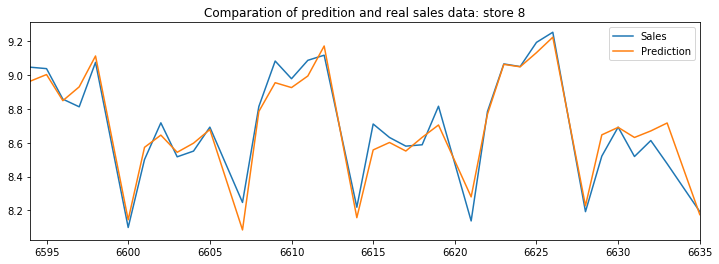

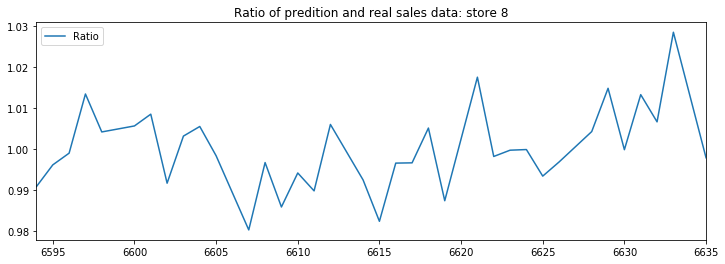

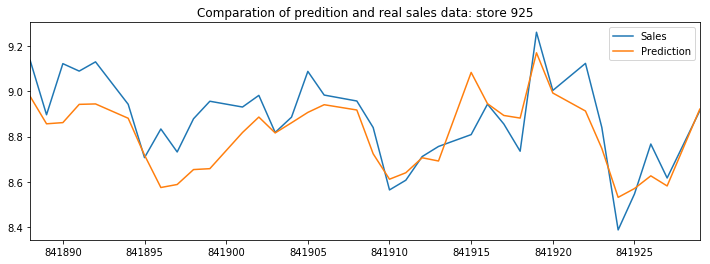

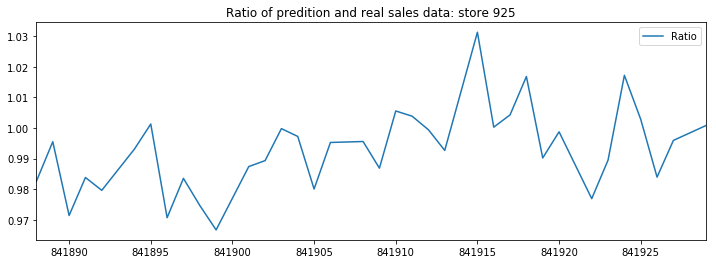

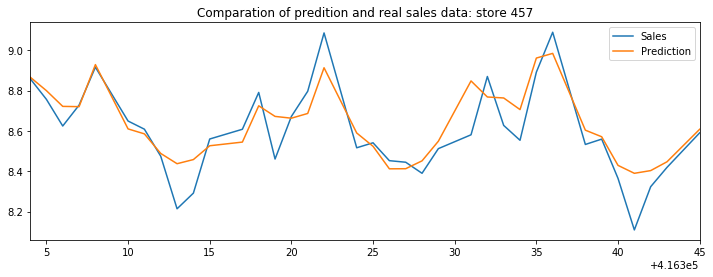

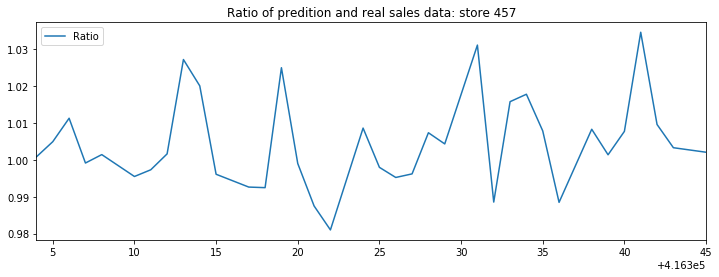

In [36]:
# In[27]:
 
 
#分析保留数据集中任意三个店铺的预测结果
col_1 = ['Sales','Prediction']
col_2 = ['Ratio']
L=np.random.randint( low=1,high = 1115, size = 3 ) 
print('Mean Ratio of predition and real sales data is {}: store all'.format(res.Ratio.mean()))
for i in L:
    
    s1 = pd.DataFrame(res[res['Store']==i],columns = col_1)
    s2 = pd.DataFrame(res[res['Store']==i],columns = col_2)
    s1.plot(title = 'Comparation of predition and real sales data: store {}'.format(i),figsize=(12,4))
    s2.plot(title = 'Ratio of predition and real sales data: store {}'.format(i),figsize=(12,4))
    print('Mean Ratio of predition and real sales data is {}: store {}'.format(s2.Ratio.mean(),i))

In [37]:
# In[28]:
 
 
#分析偏差最大的10个预测结果
res.sort_values(['Error'],ascending=False,inplace= True)
res[:10]


Store  DayOfWeek  Promo  StateHoliday  SchoolHoliday  StoreType  \
264207    292          4      0             0              0          1   
711449    782          4      0             0              0          3   
827582    909          2      1             0              0          1   
827591    909          0      0             0              0          1   
797965    876          5      0             0              0          1   
264218    292          0      1             0              0          1   
264213    292          5      0             0              0          1   
797963    876          0      0             0              0          1   
711448    782          5      0             0              0          3   
456286    501          5      0             0              0          1   

        Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
264207           1               1100.0                        6.0   
711449           3               5390.0                        8.0   
827582           3               1680.0                        0.0   
827591           3               1680.0                        0.0   
797965           1              21790.0                        4.0   
264218           1               1100.0                        6.0   
264213           1               1100.0                        6.0   
797963           1              21790.0                        4.0   
711448           3               5390.0                        8.0   
456286           3               1620.0                        9.0   

        CompetitionOpenSinceYear  ...  Day  WeekOfYear  CompetitionOpen  \
264207                    2009.0  ...   10          28             73.0   
711449                    2003.0  ...   26          26            142.0   
827582                       0.0  ...    1          27          24187.0   
827591                       0.0  ...   22          26          24186.0   
797965                    2005.0  ...    4          27            123.0   
264218                    2009.0  ...   29          27             72.0   
264213                    2009.0  ...    4          27             73.0   
797963                    2005.0  ...    6          28            123.0   
711448                    2003.0  ...   27          26            142.0   
456286                    2006.0  ...   25          30            106.0   

        PromoOpen  IsPromoMonth      Sales  Prediction     Ratio     Error  \
264207   24187.00             0   6.920672    8.553830  1.235983  0.235983   
711449      42.25             0   7.260523    8.596755  1.184041  0.184041   
827582      67.50             0   8.174139    9.543799  1.167560  0.167560   
827591      67.25             0  10.634701    9.167545  0.862041  0.137959   
797965       2.25             0   9.596215    8.325567  0.867589  0.132411   
264218   24186.75             0  10.280622    9.041227  0.879444  0.120556   
264213   24186.75             0   7.406711    8.299530  1.120542  0.120542   
797963       2.50             0  10.215777    8.998613  0.880855  0.119145   
711448      42.25             0   7.714677    8.586529  1.113012  0.113012   
456286   24187.50             0   7.360104    8.185041  1.112082  0.112082   

          Weight  
264207  0.809073  
711449  0.844565  
827582  0.856487  
827591  1.160038  
797965  1.152620  
264218  1.137083  
264213  0.892425  
797963  1.135261  
711448  0.898463  
456286  0.899214  

[10 rows x 25 columns]

#从分析结果来看，我们的初始模型已经可以比较好的预测hold-out数据集的销售趋势，但是相对真实值，我们的模型的预测值整体要偏高一些。从对偏差数据分析来看，偏差最大的3个数据也是明显偏高。因此我们可以以hold-out数据集为标准对模型进行偏差校正。
 
# 7.模型优化

weight correction
RMSPE for 0.990:0.129069
RMSPE for 0.991:0.126340
RMSPE for 0.992:0.124097
RMSPE for 0.993:0.122383
RMSPE for 0.994:0.121235
RMSPE for 0.995:0.120686
RMSPE for 0.996:0.120760
RMSPE for 0.997:0.121473
RMSPE for 0.998:0.122830
RMSPE for 0.999:0.124828
RMSPE for 1.000:0.127452
RMSPE for 1.001:0.130682
RMSPE for 1.002:0.134491
RMSPE for 1.003:0.138848
RMSPE for 1.004:0.143718
RMSPE for 1.005:0.149069
RMSPE for 1.006:0.154865
RMSPE for 1.007:0.161073
RMSPE for 1.008:0.167665
RMSPE for 1.009:0.174609
Best weight for Score:0.995    0.120686
dtype: float64


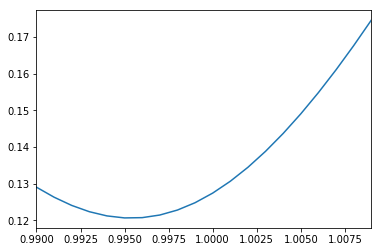

In [39]:
#7.1偏差整体校正优化
print("weight correction")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(ho_ytest), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

#当校正系数为0.995时，hold-out集的RMSPE得分最低：0.118889，相对于初始模型 0.125453得分有很大的提升。
 
#因为每个店铺都有自己的特点，而我们设计的模型对不同的店铺偏差并不完全相同，所以我们需要根据不同的店铺进行一个细致的校正。


In [40]:
#7.2细致校正：以不同的店铺分组进行细致校正，每个店铺分别计算可以取得最佳RMSPE得分的校正系数
L=range(1115)
W_ho=[]
W_test=[]
for i in L:
    s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
    s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
    W1=[(0.990+(i/1000)) for i in range(20)]
    S =[]
    for w in W1:
        error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
        S.append(error)
    Score = pd.Series(S,index=W1)
    BS = Score[Score.values == Score.values.min()]
    a=np.array(BS.index.values)
    b_ho=a.repeat(len(s1))
    b_test=a.repeat(len(s2))
    W_ho.extend(b_ho.tolist())
    W_test.extend(b_test.tolist())

In [41]:
#计算校正后整体数据的RMSPE得分
yhat_new = yhat*W_ho
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat_new))
print ('RMSPE for weight corretion {:6f}'.format(error))

RMSPE for weight corretion 0.114002


#细致校正后的hold-out集的得分为0.112010，相对于整体校正的0.118889的得分又有不小的提高

In [53]:
xtest['Assortment'] = pd.to_numeric(xtest['Assortment'])
xtest['StateHoliday'] = pd.to_numeric(xtest['StateHoliday'])

In [54]:
#用初始和校正后的模型对训练数据集进行预测
print("Make predictions on the test set")
dtest = xgb.DMatrix(xtest)
test_probs = gbm.predict(dtest)

Make predictions on the test set


In [55]:

#初始模型
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs)})
result.to_csv("Rossmann_submission_1.csv", index=False)


In [56]:
#整体校正模型
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs*0.995)})
result.to_csv("Rossmann_submission_2.csv", index=False)

In [57]:
#细致校正模型
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(test_probs*W_test)})
result.to_csv("Rossmann_submission_3.csv", index=False)

然后我们用不同的seed训练10个模型,每个模型单独进行细致偏差校正后进行融合.

In [58]:
#7.2训练融合模型
print("Train an new ensemble XGBoost model")
start = time()
rounds = 10
preds_ho = np.zeros((len(ho_xtest.index), rounds))
preds_test = np.zeros((len(test.index), rounds))
B=[]
for r in range(rounds):
    print('round {}:'.format(r+1))
    
    params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.03,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": r+1
          }
    num_boost_round = 6000
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
                    early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
    
    yhat = gbm.predict(xgb.DMatrix(ho_xtest))
    
    L=range(1115)
    W_ho=[]
    W_test=[]
    for i in L:
        s1 = pd.DataFrame(res[res['Store']==i+1],columns = col_1)
        s2 = pd.DataFrame(xtest[xtest['Store']==i+1])
        W1=[(0.990+(i/1000)) for i in range(20)]
        S =[]
        for w in W1:
            error = rmspe(np.expm1(s1.Sales), np.expm1(s1.Prediction*w))
            S.append(error)
        Score = pd.Series(S,index=W1)
        BS = Score[Score.values == Score.values.min()]
        a=np.array(BS.index.values)
        b_ho=a.repeat(len(s1))
        b_test=a.repeat(len(s2))
        W_ho.extend(b_ho.tolist())
        W_test.extend(b_test.tolist())
    
 
    yhat_ho = yhat*W_ho
    yhat_test =gbm.predict(xgb.DMatrix(xtest))*W_test
    error = rmspe(np.expm1(ho_ytest), np.expm1(yhat_ho))
    B.append(error)
    preds_ho[:, r] = yhat_ho
    preds_test[:, r] = yhat_test
    print('round {} end'.format(r+1))
    
end = time()
time_elapsed = end-start
print('Training is end')
print('Training time is {} h.'.format(time_elapsed/3600))

Train an new ensemble XGBoost model
round 1:
[0]	train-rmse:8.02076	eval-rmse:8.02787	train-rmspe:0.999809	eval-rmspe:0.999811
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78061	eval-rmse:7.78781	train-rmspe:0.999711	eval-rmspe:0.999714
[2]	train-rmse:7.54766	eval-rmse:7.55527	train-rmspe:0.999591	eval-rmspe:0.999596
[3]	train-rmse:7.32174	eval-rmse:7.32935	train-rmspe:0.999444	eval-rmspe:0.999452
[4]	train-rmse:7.1026	eval-rmse:7.11077	train-rmspe:0.999267	eval-rmspe:0.999277
[5]	train-rmse:6.89002	eval-rmse:6.89822	train-rmspe:0.999055	eval-rmspe:0.999067
[6]	train-rmse:6.68392	eval-rmse:6.69086	train-rmspe:0.9988	eval-rmspe:0.998814
[7]	train-rmse:6.48397	eval-rmse:6.49115	train-rmspe:0.998498	eval-rmspe:0.998516
[8]	train-rmse:6.28997	eval-rmse:6.29732	train-rmspe:0.998143	eval-rmspe:0.998165
[9]	train-rmse:6.10185	eval-rmse:6.10842	train-rmspe:0.997726	eval-rmspe:0

[97]	train-rmse:0.487902	eval-rmse:0.481761	train-rmspe:0.377765	eval-rmspe:0.362461
[98]	train-rmse:0.476984	eval-rmse:0.470586	train-rmspe:0.371807	eval-rmspe:0.355834
[99]	train-rmse:0.466515	eval-rmse:0.459781	train-rmspe:0.366081	eval-rmspe:0.349405
[100]	train-rmse:0.45624	eval-rmse:0.449545	train-rmspe:0.360533	eval-rmspe:0.343331
[101]	train-rmse:0.446206	eval-rmse:0.439671	train-rmspe:0.355026	eval-rmspe:0.33746
[102]	train-rmse:0.436862	eval-rmse:0.430549	train-rmspe:0.349926	eval-rmspe:0.331982
[103]	train-rmse:0.427766	eval-rmse:0.421679	train-rmspe:0.344992	eval-rmspe:0.326666
[104]	train-rmse:0.419129	eval-rmse:0.413025	train-rmspe:0.340318	eval-rmspe:0.32148
[105]	train-rmse:0.410722	eval-rmse:0.404434	train-rmspe:0.335779	eval-rmspe:0.316351
[106]	train-rmse:0.402618	eval-rmse:0.396501	train-rmspe:0.331459	eval-rmspe:0.311637
[107]	train-rmse:0.394618	eval-rmse:0.388682	train-rmspe:0.327175	eval-rmspe:0.306958
[108]	train-rmse:0.387203	eval-rmse:0.380793	train-rmspe:0.3

[193]	train-rmse:0.197291	eval-rmse:0.206117	train-rmspe:0.24328	eval-rmspe:0.217296
[194]	train-rmse:0.196768	eval-rmse:0.205661	train-rmspe:0.243057	eval-rmspe:0.217032
[195]	train-rmse:0.196599	eval-rmse:0.205543	train-rmspe:0.243157	eval-rmspe:0.217115
[196]	train-rmse:0.195415	eval-rmse:0.204468	train-rmspe:0.242292	eval-rmspe:0.216109
[197]	train-rmse:0.19506	eval-rmse:0.204196	train-rmspe:0.242171	eval-rmspe:0.215992
[198]	train-rmse:0.194349	eval-rmse:0.203637	train-rmspe:0.241533	eval-rmspe:0.215493
[199]	train-rmse:0.193579	eval-rmse:0.202738	train-rmspe:0.241029	eval-rmspe:0.214724
[200]	train-rmse:0.192923	eval-rmse:0.201842	train-rmspe:0.240619	eval-rmspe:0.21398
[201]	train-rmse:0.192177	eval-rmse:0.201186	train-rmspe:0.240022	eval-rmspe:0.213413
[202]	train-rmse:0.191943	eval-rmse:0.201036	train-rmspe:0.239984	eval-rmspe:0.213406
[203]	train-rmse:0.19172	eval-rmse:0.20086	train-rmspe:0.239967	eval-rmspe:0.21339
[204]	train-rmse:0.191467	eval-rmse:0.200674	train-rmspe:0.2

[289]	train-rmse:0.159542	eval-rmse:0.172191	train-rmspe:0.206575	eval-rmspe:0.186324
[290]	train-rmse:0.159352	eval-rmse:0.172015	train-rmspe:0.206373	eval-rmspe:0.18614
[291]	train-rmse:0.159211	eval-rmse:0.171891	train-rmspe:0.205768	eval-rmspe:0.186019
[292]	train-rmse:0.15888	eval-rmse:0.171581	train-rmspe:0.205429	eval-rmspe:0.185678
[293]	train-rmse:0.158425	eval-rmse:0.171139	train-rmspe:0.204968	eval-rmspe:0.185192
[294]	train-rmse:0.15795	eval-rmse:0.170769	train-rmspe:0.204581	eval-rmspe:0.184809
[295]	train-rmse:0.157739	eval-rmse:0.170619	train-rmspe:0.204336	eval-rmspe:0.184676
[296]	train-rmse:0.157542	eval-rmse:0.170444	train-rmspe:0.204167	eval-rmspe:0.18448
[297]	train-rmse:0.157308	eval-rmse:0.170241	train-rmspe:0.203844	eval-rmspe:0.184261
[298]	train-rmse:0.156828	eval-rmse:0.169775	train-rmspe:0.203362	eval-rmspe:0.183742
[299]	train-rmse:0.156455	eval-rmse:0.169471	train-rmspe:0.203039	eval-rmspe:0.183434
[300]	train-rmse:0.156267	eval-rmse:0.1693	train-rmspe:0.2

[385]	train-rmse:0.136538	eval-rmse:0.153001	train-rmspe:0.178458	eval-rmspe:0.165774
[386]	train-rmse:0.136353	eval-rmse:0.152849	train-rmspe:0.178279	eval-rmspe:0.165608
[387]	train-rmse:0.136123	eval-rmse:0.152667	train-rmspe:0.17808	eval-rmspe:0.165398
[388]	train-rmse:0.13587	eval-rmse:0.152481	train-rmspe:0.177902	eval-rmspe:0.165207
[389]	train-rmse:0.135243	eval-rmse:0.151984	train-rmspe:0.17727	eval-rmspe:0.164619
[390]	train-rmse:0.134816	eval-rmse:0.151634	train-rmspe:0.176768	eval-rmspe:0.164193
[391]	train-rmse:0.134727	eval-rmse:0.151571	train-rmspe:0.176693	eval-rmspe:0.164125
[392]	train-rmse:0.134589	eval-rmse:0.151497	train-rmspe:0.176534	eval-rmspe:0.164059
[393]	train-rmse:0.134355	eval-rmse:0.151268	train-rmspe:0.176267	eval-rmspe:0.163798
[394]	train-rmse:0.134135	eval-rmse:0.151133	train-rmspe:0.176085	eval-rmspe:0.163658
[395]	train-rmse:0.133993	eval-rmse:0.150864	train-rmspe:0.175917	eval-rmspe:0.163376
[396]	train-rmse:0.133803	eval-rmse:0.150718	train-rmspe:

[481]	train-rmse:0.121385	eval-rmse:0.141238	train-rmspe:0.158895	eval-rmspe:0.15275
[482]	train-rmse:0.121235	eval-rmse:0.141128	train-rmspe:0.15876	eval-rmspe:0.152618
[483]	train-rmse:0.121153	eval-rmse:0.14107	train-rmspe:0.158616	eval-rmspe:0.152556
[484]	train-rmse:0.120999	eval-rmse:0.140949	train-rmspe:0.15848	eval-rmspe:0.152435
[485]	train-rmse:0.120914	eval-rmse:0.140883	train-rmspe:0.158242	eval-rmspe:0.152371
[486]	train-rmse:0.120851	eval-rmse:0.140756	train-rmspe:0.157953	eval-rmspe:0.15224
[487]	train-rmse:0.120797	eval-rmse:0.140689	train-rmspe:0.157891	eval-rmspe:0.15218
[488]	train-rmse:0.120609	eval-rmse:0.140554	train-rmspe:0.157734	eval-rmspe:0.152027
[489]	train-rmse:0.120548	eval-rmse:0.140522	train-rmspe:0.157686	eval-rmspe:0.15199
[490]	train-rmse:0.120407	eval-rmse:0.140375	train-rmspe:0.157552	eval-rmspe:0.151843
[491]	train-rmse:0.120282	eval-rmse:0.140272	train-rmspe:0.157446	eval-rmspe:0.151735
[492]	train-rmse:0.120206	eval-rmse:0.14027	train-rmspe:0.157

[577]	train-rmse:0.111714	eval-rmse:0.133411	train-rmspe:0.143772	eval-rmspe:0.143956
[578]	train-rmse:0.111622	eval-rmse:0.133336	train-rmspe:0.143698	eval-rmspe:0.14387
[579]	train-rmse:0.111463	eval-rmse:0.13323	train-rmspe:0.143553	eval-rmspe:0.143751
[580]	train-rmse:0.111398	eval-rmse:0.133182	train-rmspe:0.141717	eval-rmspe:0.143706
[581]	train-rmse:0.111333	eval-rmse:0.133141	train-rmspe:0.141665	eval-rmspe:0.143666
[582]	train-rmse:0.111237	eval-rmse:0.133019	train-rmspe:0.141562	eval-rmspe:0.143512
[583]	train-rmse:0.111195	eval-rmse:0.132993	train-rmspe:0.141525	eval-rmspe:0.143488
[584]	train-rmse:0.111102	eval-rmse:0.132925	train-rmspe:0.14144	eval-rmspe:0.143413
[585]	train-rmse:0.111012	eval-rmse:0.132872	train-rmspe:0.141357	eval-rmspe:0.143359
[586]	train-rmse:0.110954	eval-rmse:0.132747	train-rmspe:0.141301	eval-rmspe:0.143213
[587]	train-rmse:0.110767	eval-rmse:0.132622	train-rmspe:0.141131	eval-rmspe:0.14308
[588]	train-rmse:0.110701	eval-rmse:0.132578	train-rmspe:0

[673]	train-rmse:0.104869	eval-rmse:0.128453	train-rmspe:0.134075	eval-rmspe:0.138443
[674]	train-rmse:0.1048	eval-rmse:0.1284	train-rmspe:0.134015	eval-rmspe:0.13838
[675]	train-rmse:0.104752	eval-rmse:0.128379	train-rmspe:0.133976	eval-rmspe:0.138359
[676]	train-rmse:0.10471	eval-rmse:0.12835	train-rmspe:0.133939	eval-rmspe:0.138319
[677]	train-rmse:0.104589	eval-rmse:0.128248	train-rmspe:0.133824	eval-rmspe:0.138201
[678]	train-rmse:0.104563	eval-rmse:0.128207	train-rmspe:0.133806	eval-rmspe:0.138168
[679]	train-rmse:0.10447	eval-rmse:0.128152	train-rmspe:0.133724	eval-rmspe:0.138112
[680]	train-rmse:0.104403	eval-rmse:0.128103	train-rmspe:0.133664	eval-rmspe:0.138047
[681]	train-rmse:0.104345	eval-rmse:0.128014	train-rmspe:0.133612	eval-rmspe:0.13793
[682]	train-rmse:0.104275	eval-rmse:0.127965	train-rmspe:0.133508	eval-rmspe:0.13787
[683]	train-rmse:0.1042	eval-rmse:0.12791	train-rmspe:0.133295	eval-rmspe:0.137814
[684]	train-rmse:0.104081	eval-rmse:0.127835	train-rmspe:0.133189	e

[769]	train-rmse:0.099747	eval-rmse:0.125324	train-rmspe:0.128027	eval-rmspe:0.134939
[770]	train-rmse:0.099691	eval-rmse:0.125296	train-rmspe:0.127965	eval-rmspe:0.134911
[771]	train-rmse:0.099636	eval-rmse:0.125284	train-rmspe:0.127915	eval-rmspe:0.134903
[772]	train-rmse:0.099593	eval-rmse:0.125258	train-rmspe:0.127878	eval-rmspe:0.134875
[773]	train-rmse:0.099537	eval-rmse:0.125213	train-rmspe:0.127824	eval-rmspe:0.134827
[774]	train-rmse:0.099494	eval-rmse:0.125253	train-rmspe:0.127718	eval-rmspe:0.134896
[775]	train-rmse:0.099466	eval-rmse:0.125232	train-rmspe:0.127693	eval-rmspe:0.134875
[776]	train-rmse:0.09943	eval-rmse:0.12521	train-rmspe:0.127661	eval-rmspe:0.13485
[777]	train-rmse:0.099417	eval-rmse:0.12518	train-rmspe:0.127646	eval-rmspe:0.134803
[778]	train-rmse:0.099372	eval-rmse:0.125162	train-rmspe:0.127605	eval-rmspe:0.134786
[779]	train-rmse:0.09935	eval-rmse:0.12515	train-rmspe:0.127584	eval-rmspe:0.134777
[780]	train-rmse:0.099299	eval-rmse:0.125122	train-rmspe:0.1

[865]	train-rmse:0.095646	eval-rmse:0.123002	train-rmspe:0.123191	eval-rmspe:0.132269
[866]	train-rmse:0.095573	eval-rmse:0.122951	train-rmspe:0.123129	eval-rmspe:0.13221
[867]	train-rmse:0.095535	eval-rmse:0.122926	train-rmspe:0.123091	eval-rmspe:0.132182
[868]	train-rmse:0.095479	eval-rmse:0.122917	train-rmspe:0.123034	eval-rmspe:0.132193
[869]	train-rmse:0.095456	eval-rmse:0.122908	train-rmspe:0.123012	eval-rmspe:0.132184
[870]	train-rmse:0.095419	eval-rmse:0.122894	train-rmspe:0.122978	eval-rmspe:0.132172
[871]	train-rmse:0.095385	eval-rmse:0.122888	train-rmspe:0.122945	eval-rmspe:0.132169
[872]	train-rmse:0.095346	eval-rmse:0.122867	train-rmspe:0.122908	eval-rmspe:0.132145
[873]	train-rmse:0.095309	eval-rmse:0.122921	train-rmspe:0.122856	eval-rmspe:0.132237
[874]	train-rmse:0.095281	eval-rmse:0.122916	train-rmspe:0.122824	eval-rmspe:0.132232
[875]	train-rmse:0.095246	eval-rmse:0.122889	train-rmspe:0.122794	eval-rmspe:0.132203
[876]	train-rmse:0.095203	eval-rmse:0.122865	train-rmsp

[961]	train-rmse:0.09241	eval-rmse:0.121791	train-rmspe:0.115541	eval-rmspe:0.131072
[962]	train-rmse:0.09238	eval-rmse:0.121786	train-rmspe:0.115511	eval-rmspe:0.131064
[963]	train-rmse:0.092344	eval-rmse:0.121767	train-rmspe:0.115481	eval-rmspe:0.131043
[964]	train-rmse:0.092324	eval-rmse:0.121763	train-rmspe:0.115428	eval-rmspe:0.131041
[965]	train-rmse:0.092301	eval-rmse:0.121759	train-rmspe:0.115402	eval-rmspe:0.131042
[966]	train-rmse:0.09229	eval-rmse:0.121714	train-rmspe:0.11539	eval-rmspe:0.130979
[967]	train-rmse:0.092267	eval-rmse:0.121701	train-rmspe:0.11537	eval-rmspe:0.130966
[968]	train-rmse:0.092233	eval-rmse:0.121693	train-rmspe:0.115336	eval-rmspe:0.130953
[969]	train-rmse:0.092211	eval-rmse:0.121686	train-rmspe:0.115316	eval-rmspe:0.130945
[970]	train-rmse:0.092194	eval-rmse:0.121674	train-rmspe:0.115304	eval-rmspe:0.130926
[971]	train-rmse:0.092169	eval-rmse:0.121672	train-rmspe:0.115239	eval-rmspe:0.130926
[972]	train-rmse:0.092149	eval-rmse:0.121658	train-rmspe:0.

[1057]	train-rmse:0.089869	eval-rmse:0.120831	train-rmspe:0.109894	eval-rmspe:0.130028
[1058]	train-rmse:0.089842	eval-rmse:0.120811	train-rmspe:0.10986	eval-rmspe:0.130006
[1059]	train-rmse:0.089825	eval-rmse:0.120808	train-rmspe:0.109845	eval-rmspe:0.130005
[1060]	train-rmse:0.089805	eval-rmse:0.120801	train-rmspe:0.109819	eval-rmspe:0.129995
[1061]	train-rmse:0.089755	eval-rmse:0.12077	train-rmspe:0.10977	eval-rmspe:0.129958
[1062]	train-rmse:0.089729	eval-rmse:0.120766	train-rmspe:0.109735	eval-rmspe:0.129958
[1063]	train-rmse:0.089718	eval-rmse:0.120763	train-rmspe:0.109722	eval-rmspe:0.129953
[1064]	train-rmse:0.089675	eval-rmse:0.120784	train-rmspe:0.109652	eval-rmspe:0.129987
[1065]	train-rmse:0.089653	eval-rmse:0.120781	train-rmspe:0.109619	eval-rmspe:0.129981
[1066]	train-rmse:0.089616	eval-rmse:0.120765	train-rmspe:0.109579	eval-rmspe:0.129962
[1067]	train-rmse:0.089605	eval-rmse:0.120756	train-rmspe:0.10957	eval-rmspe:0.129952
[1068]	train-rmse:0.089582	eval-rmse:0.12073	tr

[1152]	train-rmse:0.08761	eval-rmse:0.11996	train-rmspe:0.1048	eval-rmspe:0.129039
[1153]	train-rmse:0.087598	eval-rmse:0.119958	train-rmspe:0.104786	eval-rmspe:0.129036
[1154]	train-rmse:0.087575	eval-rmse:0.119948	train-rmspe:0.104683	eval-rmspe:0.129025
[1155]	train-rmse:0.08754	eval-rmse:0.119926	train-rmspe:0.10465	eval-rmspe:0.129
[1156]	train-rmse:0.087521	eval-rmse:0.119921	train-rmspe:0.10463	eval-rmspe:0.128994
[1157]	train-rmse:0.087507	eval-rmse:0.119898	train-rmspe:0.104617	eval-rmspe:0.128959
[1158]	train-rmse:0.08747	eval-rmse:0.119889	train-rmspe:0.104582	eval-rmspe:0.128954
[1159]	train-rmse:0.087448	eval-rmse:0.119883	train-rmspe:0.104552	eval-rmspe:0.128947
[1160]	train-rmse:0.087423	eval-rmse:0.119877	train-rmspe:0.104521	eval-rmspe:0.128936
[1161]	train-rmse:0.087404	eval-rmse:0.119869	train-rmspe:0.104497	eval-rmspe:0.128927
[1162]	train-rmse:0.087391	eval-rmse:0.119867	train-rmspe:0.104483	eval-rmspe:0.128925
[1163]	train-rmse:0.087371	eval-rmse:0.11986	train-rms

[1247]	train-rmse:0.085783	eval-rmse:0.11945	train-rmspe:0.101938	eval-rmspe:0.128462
[1248]	train-rmse:0.085768	eval-rmse:0.119442	train-rmspe:0.101926	eval-rmspe:0.128452
[1249]	train-rmse:0.085738	eval-rmse:0.119426	train-rmspe:0.101884	eval-rmspe:0.128436
[1250]	train-rmse:0.085718	eval-rmse:0.119412	train-rmspe:0.101905	eval-rmspe:0.128423
[1251]	train-rmse:0.085692	eval-rmse:0.119406	train-rmspe:0.101879	eval-rmspe:0.128416
[1252]	train-rmse:0.085679	eval-rmse:0.119403	train-rmspe:0.101867	eval-rmspe:0.128414
[1253]	train-rmse:0.085658	eval-rmse:0.119393	train-rmspe:0.10181	eval-rmspe:0.128403
[1254]	train-rmse:0.085626	eval-rmse:0.119381	train-rmspe:0.101776	eval-rmspe:0.12839
[1255]	train-rmse:0.085613	eval-rmse:0.119394	train-rmspe:0.10176	eval-rmspe:0.128408
[1256]	train-rmse:0.085594	eval-rmse:0.119391	train-rmspe:0.10174	eval-rmspe:0.128405
[1257]	train-rmse:0.085577	eval-rmse:0.119378	train-rmspe:0.101723	eval-rmspe:0.128392
[1258]	train-rmse:0.085554	eval-rmse:0.119375	tr

[1342]	train-rmse:0.084135	eval-rmse:0.119007	train-rmspe:0.09935	eval-rmspe:0.12803
[1343]	train-rmse:0.084106	eval-rmse:0.118996	train-rmspe:0.099318	eval-rmspe:0.128018
[1344]	train-rmse:0.084094	eval-rmse:0.118993	train-rmspe:0.099308	eval-rmspe:0.128018
[1345]	train-rmse:0.084079	eval-rmse:0.11899	train-rmspe:0.099288	eval-rmspe:0.128014
[1346]	train-rmse:0.08406	eval-rmse:0.118983	train-rmspe:0.09888	eval-rmspe:0.128008
[1347]	train-rmse:0.084042	eval-rmse:0.118981	train-rmspe:0.098835	eval-rmspe:0.128005
[1348]	train-rmse:0.084028	eval-rmse:0.119007	train-rmspe:0.098821	eval-rmspe:0.128041
[1349]	train-rmse:0.084015	eval-rmse:0.119002	train-rmspe:0.098804	eval-rmspe:0.128036
[1350]	train-rmse:0.084008	eval-rmse:0.118998	train-rmspe:0.098797	eval-rmspe:0.128038
[1351]	train-rmse:0.083989	eval-rmse:0.119012	train-rmspe:0.098482	eval-rmspe:0.12805
[1352]	train-rmse:0.083975	eval-rmse:0.119007	train-rmspe:0.098469	eval-rmspe:0.128046
[1353]	train-rmse:0.083963	eval-rmse:0.119	train-

[1437]	train-rmse:0.082489	eval-rmse:0.118633	train-rmspe:0.095684	eval-rmspe:0.127648
[1438]	train-rmse:0.082481	eval-rmse:0.118631	train-rmspe:0.095676	eval-rmspe:0.127645
[1439]	train-rmse:0.082463	eval-rmse:0.118628	train-rmspe:0.095653	eval-rmspe:0.127646
[1440]	train-rmse:0.082454	eval-rmse:0.118629	train-rmspe:0.095643	eval-rmspe:0.127649
[1441]	train-rmse:0.082437	eval-rmse:0.118623	train-rmspe:0.095625	eval-rmspe:0.12764
[1442]	train-rmse:0.082415	eval-rmse:0.118622	train-rmspe:0.095587	eval-rmspe:0.127641
[1443]	train-rmse:0.082393	eval-rmse:0.118614	train-rmspe:0.095562	eval-rmspe:0.127631
[1444]	train-rmse:0.082385	eval-rmse:0.118614	train-rmspe:0.095554	eval-rmspe:0.127631
[1445]	train-rmse:0.08236	eval-rmse:0.118628	train-rmspe:0.09552	eval-rmspe:0.127642
[1446]	train-rmse:0.082354	eval-rmse:0.118622	train-rmspe:0.095513	eval-rmspe:0.127636
[1447]	train-rmse:0.082336	eval-rmse:0.118616	train-rmspe:0.095494	eval-rmspe:0.127627
[1448]	train-rmse:0.082316	eval-rmse:0.118624	

[1532]	train-rmse:0.081057	eval-rmse:0.11844	train-rmspe:0.092741	eval-rmspe:0.127461
[1533]	train-rmse:0.081049	eval-rmse:0.118439	train-rmspe:0.092729	eval-rmspe:0.12746
[1534]	train-rmse:0.081033	eval-rmse:0.118442	train-rmspe:0.092708	eval-rmspe:0.127466
[1535]	train-rmse:0.081003	eval-rmse:0.118432	train-rmspe:0.092655	eval-rmspe:0.12745
[1536]	train-rmse:0.08099	eval-rmse:0.11843	train-rmspe:0.092642	eval-rmspe:0.127448
[1537]	train-rmse:0.080969	eval-rmse:0.118422	train-rmspe:0.09262	eval-rmspe:0.12744
[1538]	train-rmse:0.080948	eval-rmse:0.118415	train-rmspe:0.092367	eval-rmspe:0.127433
[1539]	train-rmse:0.080937	eval-rmse:0.118414	train-rmspe:0.092354	eval-rmspe:0.127434
[1540]	train-rmse:0.080924	eval-rmse:0.118424	train-rmspe:0.092339	eval-rmspe:0.127435
[1541]	train-rmse:0.08091	eval-rmse:0.11842	train-rmspe:0.092323	eval-rmspe:0.127429
[1542]	train-rmse:0.080894	eval-rmse:0.118414	train-rmspe:0.092309	eval-rmspe:0.12742
[1543]	train-rmse:0.080879	eval-rmse:0.118416	train-r

[1627]	train-rmse:0.079676	eval-rmse:0.118126	train-rmspe:0.090445	eval-rmspe:0.127072
[1628]	train-rmse:0.079654	eval-rmse:0.118123	train-rmspe:0.09041	eval-rmspe:0.12707
[1629]	train-rmse:0.079647	eval-rmse:0.118123	train-rmspe:0.090401	eval-rmspe:0.12707
[1630]	train-rmse:0.079631	eval-rmse:0.118112	train-rmspe:0.090365	eval-rmspe:0.127055
[1631]	train-rmse:0.079608	eval-rmse:0.118101	train-rmspe:0.090338	eval-rmspe:0.127045
[1632]	train-rmse:0.079596	eval-rmse:0.118095	train-rmspe:0.090035	eval-rmspe:0.12704
[1633]	train-rmse:0.079584	eval-rmse:0.118091	train-rmspe:0.090024	eval-rmspe:0.127035
[1634]	train-rmse:0.079575	eval-rmse:0.11809	train-rmspe:0.090014	eval-rmspe:0.127036
[1635]	train-rmse:0.079563	eval-rmse:0.118085	train-rmspe:0.09	eval-rmspe:0.127032
[1636]	train-rmse:0.079549	eval-rmse:0.118079	train-rmspe:0.089982	eval-rmspe:0.127025
[1637]	train-rmse:0.079537	eval-rmse:0.118077	train-rmspe:0.089971	eval-rmspe:0.127025
[1638]	train-rmse:0.079525	eval-rmse:0.118093	train-

[1722]	train-rmse:0.078359	eval-rmse:0.117858	train-rmspe:0.088198	eval-rmspe:0.126821
[1723]	train-rmse:0.07835	eval-rmse:0.117855	train-rmspe:0.088188	eval-rmspe:0.126819
[1724]	train-rmse:0.078337	eval-rmse:0.117854	train-rmspe:0.088149	eval-rmspe:0.126819
[1725]	train-rmse:0.078325	eval-rmse:0.117871	train-rmspe:0.088135	eval-rmspe:0.126833
[1726]	train-rmse:0.078309	eval-rmse:0.117871	train-rmspe:0.088103	eval-rmspe:0.126833
[1727]	train-rmse:0.078297	eval-rmse:0.117867	train-rmspe:0.088116	eval-rmspe:0.126829
[1728]	train-rmse:0.078274	eval-rmse:0.117861	train-rmspe:0.088088	eval-rmspe:0.126827
[1729]	train-rmse:0.078258	eval-rmse:0.117853	train-rmspe:0.088072	eval-rmspe:0.126818
[1730]	train-rmse:0.078246	eval-rmse:0.117848	train-rmspe:0.08806	eval-rmspe:0.126813
[1731]	train-rmse:0.078238	eval-rmse:0.117848	train-rmspe:0.08805	eval-rmspe:0.126813
[1732]	train-rmse:0.078225	eval-rmse:0.117854	train-rmspe:0.088036	eval-rmspe:0.12682
[1733]	train-rmse:0.078214	eval-rmse:0.117852	t

[1817]	train-rmse:0.077191	eval-rmse:0.117595	train-rmspe:0.086058	eval-rmspe:0.126565
[1818]	train-rmse:0.077183	eval-rmse:0.117594	train-rmspe:0.08605	eval-rmspe:0.126563
[1819]	train-rmse:0.077164	eval-rmse:0.117585	train-rmspe:0.086032	eval-rmspe:0.126554
[1820]	train-rmse:0.077153	eval-rmse:0.117582	train-rmspe:0.086018	eval-rmspe:0.126551
[1821]	train-rmse:0.077144	eval-rmse:0.117581	train-rmspe:0.086008	eval-rmspe:0.126551
[1822]	train-rmse:0.07713	eval-rmse:0.117578	train-rmspe:0.085821	eval-rmspe:0.126546
[1823]	train-rmse:0.077118	eval-rmse:0.117575	train-rmspe:0.085804	eval-rmspe:0.126543
[1824]	train-rmse:0.077107	eval-rmse:0.117573	train-rmspe:0.085792	eval-rmspe:0.126541
[1825]	train-rmse:0.077091	eval-rmse:0.11757	train-rmspe:0.085765	eval-rmspe:0.126538
[1826]	train-rmse:0.077071	eval-rmse:0.11757	train-rmspe:0.085745	eval-rmspe:0.126537
[1827]	train-rmse:0.077063	eval-rmse:0.11757	train-rmspe:0.085739	eval-rmspe:0.126539
[1828]	train-rmse:0.077049	eval-rmse:0.117562	tr

[1912]	train-rmse:0.076188	eval-rmse:0.117485	train-rmspe:0.084263	eval-rmspe:0.126435
[1913]	train-rmse:0.076175	eval-rmse:0.117483	train-rmspe:0.084245	eval-rmspe:0.126433
[1914]	train-rmse:0.076156	eval-rmse:0.117481	train-rmspe:0.084209	eval-rmspe:0.126433
[1915]	train-rmse:0.076147	eval-rmse:0.117496	train-rmspe:0.0842	eval-rmspe:0.12645
[1916]	train-rmse:0.076139	eval-rmse:0.117491	train-rmspe:0.084191	eval-rmspe:0.126444
[1917]	train-rmse:0.07613	eval-rmse:0.117492	train-rmspe:0.084129	eval-rmspe:0.126446
[1918]	train-rmse:0.076104	eval-rmse:0.117477	train-rmspe:0.084103	eval-rmspe:0.12643
[1919]	train-rmse:0.076098	eval-rmse:0.117476	train-rmspe:0.084097	eval-rmspe:0.126427
[1920]	train-rmse:0.076087	eval-rmse:0.117474	train-rmspe:0.084087	eval-rmspe:0.126426
[1921]	train-rmse:0.076077	eval-rmse:0.117473	train-rmspe:0.084075	eval-rmspe:0.126424
[1922]	train-rmse:0.076066	eval-rmse:0.11747	train-rmspe:0.084065	eval-rmspe:0.12642
[1923]	train-rmse:0.076056	eval-rmse:0.117458	trai

[2007]	train-rmse:0.075136	eval-rmse:0.117392	train-rmspe:0.082885	eval-rmspe:0.126361
[2008]	train-rmse:0.075119	eval-rmse:0.117389	train-rmspe:0.082742	eval-rmspe:0.126351
[2009]	train-rmse:0.075103	eval-rmse:0.117385	train-rmspe:0.082716	eval-rmspe:0.126347
[2010]	train-rmse:0.07509	eval-rmse:0.117383	train-rmspe:0.082703	eval-rmspe:0.126345
[2011]	train-rmse:0.075082	eval-rmse:0.117379	train-rmspe:0.082694	eval-rmspe:0.12634
[2012]	train-rmse:0.075076	eval-rmse:0.117378	train-rmspe:0.082683	eval-rmspe:0.12634
[2013]	train-rmse:0.075066	eval-rmse:0.117375	train-rmspe:0.082668	eval-rmspe:0.126336
[2014]	train-rmse:0.075059	eval-rmse:0.117373	train-rmspe:0.082658	eval-rmspe:0.126337
[2015]	train-rmse:0.075051	eval-rmse:0.117372	train-rmspe:0.082651	eval-rmspe:0.126335
[2016]	train-rmse:0.075041	eval-rmse:0.117369	train-rmspe:0.082641	eval-rmspe:0.126332
[2017]	train-rmse:0.075034	eval-rmse:0.11737	train-rmspe:0.082635	eval-rmspe:0.126334
[2018]	train-rmse:0.075021	eval-rmse:0.117363	t

[2102]	train-rmse:0.074161	eval-rmse:0.117185	train-rmspe:0.081512	eval-rmspe:0.126133
[2103]	train-rmse:0.074147	eval-rmse:0.117188	train-rmspe:0.081487	eval-rmspe:0.126138
[2104]	train-rmse:0.07414	eval-rmse:0.117188	train-rmspe:0.081479	eval-rmspe:0.126138
[2105]	train-rmse:0.074135	eval-rmse:0.117186	train-rmspe:0.081469	eval-rmspe:0.126135
[2106]	train-rmse:0.074125	eval-rmse:0.117191	train-rmspe:0.081453	eval-rmspe:0.126141
[2107]	train-rmse:0.074114	eval-rmse:0.117189	train-rmspe:0.081438	eval-rmspe:0.126136
[2108]	train-rmse:0.074107	eval-rmse:0.117188	train-rmspe:0.081426	eval-rmspe:0.126136
[2109]	train-rmse:0.0741	eval-rmse:0.117185	train-rmspe:0.081418	eval-rmspe:0.126132
[2110]	train-rmse:0.07409	eval-rmse:0.117185	train-rmspe:0.081406	eval-rmspe:0.126133
[2111]	train-rmse:0.074079	eval-rmse:0.117186	train-rmspe:0.081395	eval-rmspe:0.126137
[2112]	train-rmse:0.074067	eval-rmse:0.117182	train-rmspe:0.08138	eval-rmspe:0.126132
[2113]	train-rmse:0.074057	eval-rmse:0.117181	tr

[2197]	train-rmse:0.073237	eval-rmse:0.117126	train-rmspe:0.079974	eval-rmspe:0.126077
[2198]	train-rmse:0.073228	eval-rmse:0.117126	train-rmspe:0.079964	eval-rmspe:0.126077
[2199]	train-rmse:0.073214	eval-rmse:0.11712	train-rmspe:0.079949	eval-rmspe:0.126072
[2200]	train-rmse:0.073205	eval-rmse:0.11712	train-rmspe:0.079935	eval-rmspe:0.126073
[2201]	train-rmse:0.073196	eval-rmse:0.117118	train-rmspe:0.079924	eval-rmspe:0.126071
[2202]	train-rmse:0.073186	eval-rmse:0.117113	train-rmspe:0.079911	eval-rmspe:0.126065
[2203]	train-rmse:0.07318	eval-rmse:0.11712	train-rmspe:0.079905	eval-rmspe:0.12607
[2204]	train-rmse:0.073171	eval-rmse:0.117115	train-rmspe:0.079895	eval-rmspe:0.126064
[2205]	train-rmse:0.073161	eval-rmse:0.117116	train-rmspe:0.079883	eval-rmspe:0.126064
[2206]	train-rmse:0.073146	eval-rmse:0.117114	train-rmspe:0.079869	eval-rmspe:0.126062
[2207]	train-rmse:0.073141	eval-rmse:0.117114	train-rmspe:0.079862	eval-rmspe:0.126063
[2208]	train-rmse:0.073131	eval-rmse:0.117111	tr

[2292]	train-rmse:0.072361	eval-rmse:0.116958	train-rmspe:0.078756	eval-rmspe:0.125895
[2293]	train-rmse:0.07235	eval-rmse:0.116959	train-rmspe:0.078743	eval-rmspe:0.125897
[2294]	train-rmse:0.072342	eval-rmse:0.116958	train-rmspe:0.078723	eval-rmspe:0.125895
[2295]	train-rmse:0.072335	eval-rmse:0.116959	train-rmspe:0.078714	eval-rmspe:0.125897
[2296]	train-rmse:0.072326	eval-rmse:0.116959	train-rmspe:0.078703	eval-rmspe:0.125896
[2297]	train-rmse:0.072322	eval-rmse:0.11696	train-rmspe:0.078672	eval-rmspe:0.125898
[2298]	train-rmse:0.072311	eval-rmse:0.11696	train-rmspe:0.078659	eval-rmspe:0.125898
[2299]	train-rmse:0.072299	eval-rmse:0.116959	train-rmspe:0.078635	eval-rmspe:0.125897
[2300]	train-rmse:0.072291	eval-rmse:0.116958	train-rmspe:0.07862	eval-rmspe:0.125896
[2301]	train-rmse:0.072283	eval-rmse:0.116956	train-rmspe:0.078603	eval-rmspe:0.125892
[2302]	train-rmse:0.072275	eval-rmse:0.116959	train-rmspe:0.078593	eval-rmspe:0.125895
[2303]	train-rmse:0.07227	eval-rmse:0.11696	tra

[2387]	train-rmse:0.071558	eval-rmse:0.116859	train-rmspe:0.077418	eval-rmspe:0.125772
[2388]	train-rmse:0.071548	eval-rmse:0.116858	train-rmspe:0.077406	eval-rmspe:0.125772
[2389]	train-rmse:0.071544	eval-rmse:0.116856	train-rmspe:0.077402	eval-rmspe:0.125768
[2390]	train-rmse:0.071536	eval-rmse:0.116856	train-rmspe:0.077392	eval-rmspe:0.125767
[2391]	train-rmse:0.071531	eval-rmse:0.116855	train-rmspe:0.077387	eval-rmspe:0.125766
[2392]	train-rmse:0.071524	eval-rmse:0.116855	train-rmspe:0.077378	eval-rmspe:0.125766
[2393]	train-rmse:0.071515	eval-rmse:0.116854	train-rmspe:0.077368	eval-rmspe:0.125765
[2394]	train-rmse:0.071499	eval-rmse:0.116848	train-rmspe:0.077347	eval-rmspe:0.125758
[2395]	train-rmse:0.071493	eval-rmse:0.116844	train-rmspe:0.077339	eval-rmspe:0.125753
[2396]	train-rmse:0.071485	eval-rmse:0.116846	train-rmspe:0.077332	eval-rmspe:0.125757
[2397]	train-rmse:0.071481	eval-rmse:0.116846	train-rmspe:0.077328	eval-rmspe:0.125758
[2398]	train-rmse:0.071474	eval-rmse:0.1168

[2482]	train-rmse:0.070845	eval-rmse:0.11676	train-rmspe:0.076423	eval-rmspe:0.125644
[2483]	train-rmse:0.070837	eval-rmse:0.116761	train-rmspe:0.076414	eval-rmspe:0.125645
[2484]	train-rmse:0.070834	eval-rmse:0.116761	train-rmspe:0.076411	eval-rmspe:0.125643
[2485]	train-rmse:0.070828	eval-rmse:0.11676	train-rmspe:0.076406	eval-rmspe:0.125642
[2486]	train-rmse:0.070819	eval-rmse:0.116757	train-rmspe:0.076397	eval-rmspe:0.12564
[2487]	train-rmse:0.070816	eval-rmse:0.116755	train-rmspe:0.076394	eval-rmspe:0.125638
[2488]	train-rmse:0.07081	eval-rmse:0.116754	train-rmspe:0.076387	eval-rmspe:0.125639
[2489]	train-rmse:0.070805	eval-rmse:0.116757	train-rmspe:0.076383	eval-rmspe:0.125642
[2490]	train-rmse:0.070792	eval-rmse:0.11675	train-rmspe:0.076368	eval-rmspe:0.125635
[2491]	train-rmse:0.070782	eval-rmse:0.116748	train-rmspe:0.076358	eval-rmspe:0.125632
[2492]	train-rmse:0.070777	eval-rmse:0.116746	train-rmspe:0.076352	eval-rmspe:0.125632
[2493]	train-rmse:0.07077	eval-rmse:0.116751	tra

[2577]	train-rmse:0.070102	eval-rmse:0.116702	train-rmspe:0.075393	eval-rmspe:0.125569
[2578]	train-rmse:0.070096	eval-rmse:0.116701	train-rmspe:0.075384	eval-rmspe:0.125567
[2579]	train-rmse:0.07009	eval-rmse:0.1167	train-rmspe:0.075378	eval-rmspe:0.125565
[2580]	train-rmse:0.070084	eval-rmse:0.116698	train-rmspe:0.075371	eval-rmspe:0.125566
[2581]	train-rmse:0.070077	eval-rmse:0.1167	train-rmspe:0.075364	eval-rmspe:0.125567
[2582]	train-rmse:0.070069	eval-rmse:0.116694	train-rmspe:0.075354	eval-rmspe:0.125559
[2583]	train-rmse:0.070063	eval-rmse:0.116693	train-rmspe:0.075347	eval-rmspe:0.125557
[2584]	train-rmse:0.070055	eval-rmse:0.116692	train-rmspe:0.075338	eval-rmspe:0.125556
[2585]	train-rmse:0.070048	eval-rmse:0.11669	train-rmspe:0.075331	eval-rmspe:0.125554
[2586]	train-rmse:0.070039	eval-rmse:0.116692	train-rmspe:0.07532	eval-rmspe:0.125559
[2587]	train-rmse:0.070032	eval-rmse:0.116692	train-rmspe:0.075311	eval-rmspe:0.125559
[2588]	train-rmse:0.070024	eval-rmse:0.116692	trai

[2672]	train-rmse:0.069403	eval-rmse:0.11663	train-rmspe:0.074415	eval-rmspe:0.125491
[2673]	train-rmse:0.069391	eval-rmse:0.116628	train-rmspe:0.074402	eval-rmspe:0.125488
[2674]	train-rmse:0.069385	eval-rmse:0.116627	train-rmspe:0.074397	eval-rmspe:0.125486
[2675]	train-rmse:0.069376	eval-rmse:0.116624	train-rmspe:0.074386	eval-rmspe:0.125482
[2676]	train-rmse:0.069364	eval-rmse:0.116622	train-rmspe:0.07437	eval-rmspe:0.12548
[2677]	train-rmse:0.069354	eval-rmse:0.116618	train-rmspe:0.074355	eval-rmspe:0.125476
[2678]	train-rmse:0.069343	eval-rmse:0.116613	train-rmspe:0.074313	eval-rmspe:0.12547
[2679]	train-rmse:0.069335	eval-rmse:0.116612	train-rmspe:0.074305	eval-rmspe:0.125468
[2680]	train-rmse:0.069326	eval-rmse:0.116609	train-rmspe:0.074291	eval-rmspe:0.125465
[2681]	train-rmse:0.069316	eval-rmse:0.116604	train-rmspe:0.074276	eval-rmspe:0.12546
[2682]	train-rmse:0.069309	eval-rmse:0.116604	train-rmspe:0.074267	eval-rmspe:0.125461
[2683]	train-rmse:0.069302	eval-rmse:0.116601	tr

[2767]	train-rmse:0.068666	eval-rmse:0.116586	train-rmspe:0.073432	eval-rmspe:0.125447
[2768]	train-rmse:0.068659	eval-rmse:0.116589	train-rmspe:0.073422	eval-rmspe:0.125451
[2769]	train-rmse:0.068651	eval-rmse:0.116587	train-rmspe:0.073412	eval-rmspe:0.125448
[2770]	train-rmse:0.068641	eval-rmse:0.11659	train-rmspe:0.0734	eval-rmspe:0.125452
[2771]	train-rmse:0.068631	eval-rmse:0.116588	train-rmspe:0.07338	eval-rmspe:0.12545
[2772]	train-rmse:0.068628	eval-rmse:0.116587	train-rmspe:0.073377	eval-rmspe:0.125449
[2773]	train-rmse:0.068622	eval-rmse:0.116585	train-rmspe:0.073365	eval-rmspe:0.125446
[2774]	train-rmse:0.068615	eval-rmse:0.116583	train-rmspe:0.073359	eval-rmspe:0.125443
[2775]	train-rmse:0.068609	eval-rmse:0.11658	train-rmspe:0.073351	eval-rmspe:0.12544
[2776]	train-rmse:0.068601	eval-rmse:0.11658	train-rmspe:0.073338	eval-rmspe:0.12544
[2777]	train-rmse:0.068594	eval-rmse:0.116581	train-rmspe:0.07333	eval-rmspe:0.125443
[2778]	train-rmse:0.068586	eval-rmse:0.11658	train-rm

[2862]	train-rmse:0.068014	eval-rmse:0.116516	train-rmspe:0.072572	eval-rmspe:0.125371
[2863]	train-rmse:0.068007	eval-rmse:0.116516	train-rmspe:0.072565	eval-rmspe:0.125372
[2864]	train-rmse:0.068001	eval-rmse:0.116514	train-rmspe:0.072553	eval-rmspe:0.125369
[2865]	train-rmse:0.067992	eval-rmse:0.116513	train-rmspe:0.072539	eval-rmspe:0.125369
[2866]	train-rmse:0.067982	eval-rmse:0.11651	train-rmspe:0.072528	eval-rmspe:0.125366
[2867]	train-rmse:0.067976	eval-rmse:0.116512	train-rmspe:0.07252	eval-rmspe:0.125367
[2868]	train-rmse:0.067971	eval-rmse:0.116511	train-rmspe:0.072513	eval-rmspe:0.125366
[2869]	train-rmse:0.067967	eval-rmse:0.11651	train-rmspe:0.072509	eval-rmspe:0.125365
[2870]	train-rmse:0.067963	eval-rmse:0.116512	train-rmspe:0.072504	eval-rmspe:0.125367
[2871]	train-rmse:0.067957	eval-rmse:0.116509	train-rmspe:0.072497	eval-rmspe:0.125364
[2872]	train-rmse:0.067947	eval-rmse:0.116507	train-rmspe:0.072486	eval-rmspe:0.125362
[2873]	train-rmse:0.067942	eval-rmse:0.116507	

[2957]	train-rmse:0.067357	eval-rmse:0.116486	train-rmspe:0.071648	eval-rmspe:0.125343
[2958]	train-rmse:0.067349	eval-rmse:0.116486	train-rmspe:0.071638	eval-rmspe:0.125338
[2959]	train-rmse:0.067344	eval-rmse:0.116486	train-rmspe:0.071631	eval-rmspe:0.125338
[2960]	train-rmse:0.067337	eval-rmse:0.116488	train-rmspe:0.071621	eval-rmspe:0.125342
[2961]	train-rmse:0.067329	eval-rmse:0.116489	train-rmspe:0.071613	eval-rmspe:0.125342
[2962]	train-rmse:0.067322	eval-rmse:0.11649	train-rmspe:0.071605	eval-rmspe:0.125345
[2963]	train-rmse:0.067316	eval-rmse:0.116489	train-rmspe:0.071598	eval-rmspe:0.125344
[2964]	train-rmse:0.067306	eval-rmse:0.11649	train-rmspe:0.071586	eval-rmspe:0.125345
[2965]	train-rmse:0.067302	eval-rmse:0.116489	train-rmspe:0.071581	eval-rmspe:0.125344
[2966]	train-rmse:0.067295	eval-rmse:0.116491	train-rmspe:0.071571	eval-rmspe:0.125345
[2967]	train-rmse:0.067289	eval-rmse:0.11649	train-rmspe:0.071555	eval-rmspe:0.125343
[2968]	train-rmse:0.067282	eval-rmse:0.116487	

[3052]	train-rmse:0.066712	eval-rmse:0.116452	train-rmspe:0.070805	eval-rmspe:0.125305
[3053]	train-rmse:0.066707	eval-rmse:0.116451	train-rmspe:0.070798	eval-rmspe:0.125303
[3054]	train-rmse:0.066694	eval-rmse:0.116443	train-rmspe:0.070785	eval-rmspe:0.125296
[3055]	train-rmse:0.066687	eval-rmse:0.116443	train-rmspe:0.070774	eval-rmspe:0.125295
[3056]	train-rmse:0.066682	eval-rmse:0.116443	train-rmspe:0.070768	eval-rmspe:0.125294
[3057]	train-rmse:0.066674	eval-rmse:0.116442	train-rmspe:0.07076	eval-rmspe:0.125294
[3058]	train-rmse:0.066666	eval-rmse:0.116441	train-rmspe:0.070752	eval-rmspe:0.125291
[3059]	train-rmse:0.066664	eval-rmse:0.116442	train-rmspe:0.070749	eval-rmspe:0.125293
[3060]	train-rmse:0.066657	eval-rmse:0.11644	train-rmspe:0.07074	eval-rmspe:0.125291
[3061]	train-rmse:0.06665	eval-rmse:0.116439	train-rmspe:0.070731	eval-rmspe:0.125287
[3062]	train-rmse:0.066646	eval-rmse:0.116441	train-rmspe:0.070726	eval-rmspe:0.12529
[3063]	train-rmse:0.066638	eval-rmse:0.11644	tra

[3147]	train-rmse:0.066081	eval-rmse:0.116381	train-rmspe:0.070016	eval-rmspe:0.125199
[3148]	train-rmse:0.066071	eval-rmse:0.116381	train-rmspe:0.070005	eval-rmspe:0.125201
[3149]	train-rmse:0.066064	eval-rmse:0.116379	train-rmspe:0.069998	eval-rmspe:0.1252
[3150]	train-rmse:0.066055	eval-rmse:0.116377	train-rmspe:0.069988	eval-rmspe:0.125198
[3151]	train-rmse:0.066051	eval-rmse:0.116381	train-rmspe:0.069984	eval-rmspe:0.125203
[3152]	train-rmse:0.066043	eval-rmse:0.116381	train-rmspe:0.069974	eval-rmspe:0.125204
[3153]	train-rmse:0.066037	eval-rmse:0.116381	train-rmspe:0.069964	eval-rmspe:0.125203
[3154]	train-rmse:0.066032	eval-rmse:0.116382	train-rmspe:0.069959	eval-rmspe:0.125204
[3155]	train-rmse:0.066022	eval-rmse:0.116379	train-rmspe:0.069949	eval-rmspe:0.125203
[3156]	train-rmse:0.066015	eval-rmse:0.11638	train-rmspe:0.069939	eval-rmspe:0.125205
[3157]	train-rmse:0.06601	eval-rmse:0.116378	train-rmspe:0.069933	eval-rmspe:0.125203
[3158]	train-rmse:0.066004	eval-rmse:0.116376	t

[3242]	train-rmse:0.06549	eval-rmse:0.116343	train-rmspe:0.069286	eval-rmspe:0.125157
[3243]	train-rmse:0.065485	eval-rmse:0.116342	train-rmspe:0.069281	eval-rmspe:0.125154
[3244]	train-rmse:0.06548	eval-rmse:0.11634	train-rmspe:0.069275	eval-rmspe:0.125153
[3245]	train-rmse:0.065473	eval-rmse:0.116338	train-rmspe:0.069264	eval-rmspe:0.12515
[3246]	train-rmse:0.065466	eval-rmse:0.116338	train-rmspe:0.069256	eval-rmspe:0.125151
[3247]	train-rmse:0.06546	eval-rmse:0.116341	train-rmspe:0.069248	eval-rmspe:0.125155
[3248]	train-rmse:0.065457	eval-rmse:0.116344	train-rmspe:0.069245	eval-rmspe:0.125162
[3249]	train-rmse:0.065449	eval-rmse:0.116345	train-rmspe:0.069236	eval-rmspe:0.125163
[3250]	train-rmse:0.065441	eval-rmse:0.116344	train-rmspe:0.069224	eval-rmspe:0.125162
[3251]	train-rmse:0.065432	eval-rmse:0.116343	train-rmspe:0.069212	eval-rmspe:0.125161
[3252]	train-rmse:0.065426	eval-rmse:0.116347	train-rmspe:0.069206	eval-rmspe:0.125165
[3253]	train-rmse:0.065418	eval-rmse:0.116346	tr

[3337]	train-rmse:0.064915	eval-rmse:0.116315	train-rmspe:0.06856	eval-rmspe:0.125139
[3338]	train-rmse:0.064907	eval-rmse:0.116313	train-rmspe:0.068547	eval-rmspe:0.125136
[3339]	train-rmse:0.064904	eval-rmse:0.116314	train-rmspe:0.068543	eval-rmspe:0.125138
[3340]	train-rmse:0.064893	eval-rmse:0.116312	train-rmspe:0.068531	eval-rmspe:0.125135
[3341]	train-rmse:0.064886	eval-rmse:0.116312	train-rmspe:0.068523	eval-rmspe:0.125135
[3342]	train-rmse:0.064881	eval-rmse:0.116312	train-rmspe:0.068517	eval-rmspe:0.125135
[3343]	train-rmse:0.064877	eval-rmse:0.116312	train-rmspe:0.068512	eval-rmspe:0.125136
[3344]	train-rmse:0.064871	eval-rmse:0.116313	train-rmspe:0.0685	eval-rmspe:0.125137
[3345]	train-rmse:0.064867	eval-rmse:0.116313	train-rmspe:0.068496	eval-rmspe:0.125137
[3346]	train-rmse:0.064861	eval-rmse:0.116312	train-rmspe:0.06849	eval-rmspe:0.125137
[3347]	train-rmse:0.064851	eval-rmse:0.116312	train-rmspe:0.068457	eval-rmspe:0.125137
[3348]	train-rmse:0.064843	eval-rmse:0.116308	t

[3432]	train-rmse:0.064372	eval-rmse:0.116276	train-rmspe:0.067856	eval-rmspe:0.125092
[3433]	train-rmse:0.064366	eval-rmse:0.116276	train-rmspe:0.067848	eval-rmspe:0.125092
[3434]	train-rmse:0.06436	eval-rmse:0.116275	train-rmspe:0.06784	eval-rmspe:0.125093
[3435]	train-rmse:0.064354	eval-rmse:0.116282	train-rmspe:0.067833	eval-rmspe:0.125101
[3436]	train-rmse:0.06435	eval-rmse:0.116283	train-rmspe:0.067828	eval-rmspe:0.125103
[3437]	train-rmse:0.064346	eval-rmse:0.116285	train-rmspe:0.067822	eval-rmspe:0.125107
[3438]	train-rmse:0.064339	eval-rmse:0.116286	train-rmspe:0.067814	eval-rmspe:0.125108
[3439]	train-rmse:0.064333	eval-rmse:0.116286	train-rmspe:0.067806	eval-rmspe:0.125108
[3440]	train-rmse:0.064322	eval-rmse:0.116285	train-rmspe:0.067786	eval-rmspe:0.125105
[3441]	train-rmse:0.064313	eval-rmse:0.116283	train-rmspe:0.067774	eval-rmspe:0.125106
[3442]	train-rmse:0.064305	eval-rmse:0.116282	train-rmspe:0.067765	eval-rmspe:0.125109
[3443]	train-rmse:0.0643	eval-rmse:0.116282	tr

[3527]	train-rmse:0.063824	eval-rmse:0.116306	train-rmspe:0.067149	eval-rmspe:0.125143
[3528]	train-rmse:0.063816	eval-rmse:0.116309	train-rmspe:0.067138	eval-rmspe:0.125148
[3529]	train-rmse:0.063813	eval-rmse:0.116309	train-rmspe:0.067135	eval-rmspe:0.125149
[3530]	train-rmse:0.063807	eval-rmse:0.116309	train-rmspe:0.067127	eval-rmspe:0.125149
[3531]	train-rmse:0.0638	eval-rmse:0.116308	train-rmspe:0.067118	eval-rmspe:0.125149
[3532]	train-rmse:0.063795	eval-rmse:0.11631	train-rmspe:0.067114	eval-rmspe:0.125151
[3533]	train-rmse:0.063791	eval-rmse:0.116316	train-rmspe:0.06711	eval-rmspe:0.125155
[3534]	train-rmse:0.063786	eval-rmse:0.116316	train-rmspe:0.067103	eval-rmspe:0.125155
[3535]	train-rmse:0.06378	eval-rmse:0.116317	train-rmspe:0.067099	eval-rmspe:0.125156
[3536]	train-rmse:0.063775	eval-rmse:0.116317	train-rmspe:0.067092	eval-rmspe:0.125155
[3537]	train-rmse:0.063767	eval-rmse:0.116319	train-rmspe:0.067066	eval-rmspe:0.125157
[3538]	train-rmse:0.063762	eval-rmse:0.116317	tr

[29]	train-rmse:3.3289	eval-rmse:3.33509	train-rmspe:0.961676	eval-rmspe:0.962046
[30]	train-rmse:3.22981	eval-rmse:3.23566	train-rmspe:0.957707	eval-rmspe:0.958096
[31]	train-rmse:3.13382	eval-rmse:3.13901	train-rmspe:0.953454	eval-rmspe:0.953843
[32]	train-rmse:3.04071	eval-rmse:3.04513	train-rmspe:0.948927	eval-rmspe:0.949307
[33]	train-rmse:2.95034	eval-rmse:2.95496	train-rmspe:0.944127	eval-rmspe:0.944548
[34]	train-rmse:2.86271	eval-rmse:2.86738	train-rmspe:0.939041	eval-rmspe:0.939497
[35]	train-rmse:2.77782	eval-rmse:2.7813	train-rmspe:0.93365	eval-rmspe:0.934048
[36]	train-rmse:2.69547	eval-rmse:2.69852	train-rmspe:0.927981	eval-rmspe:0.928378
[37]	train-rmse:2.61564	eval-rmse:2.61864	train-rmspe:0.922017	eval-rmspe:0.922432
[38]	train-rmse:2.53819	eval-rmse:2.54072	train-rmspe:0.915774	eval-rmspe:0.916174
[39]	train-rmse:2.46305	eval-rmse:2.46564	train-rmspe:0.90925	eval-rmspe:0.909677
[40]	train-rmse:2.39024	eval-rmse:2.39293	train-rmspe:0.902434	eval-rmspe:0.902876
[41]	tra

[127]	train-rmse:0.290442	eval-rmse:0.286841	train-rmspe:0.27868	eval-rmspe:0.251418
[128]	train-rmse:0.286628	eval-rmse:0.283208	train-rmspe:0.276984	eval-rmspe:0.249409
[129]	train-rmse:0.283631	eval-rmse:0.28041	train-rmspe:0.275858	eval-rmspe:0.24829
[130]	train-rmse:0.280779	eval-rmse:0.277933	train-rmspe:0.274779	eval-rmspe:0.247345
[131]	train-rmse:0.278027	eval-rmse:0.275592	train-rmspe:0.27389	eval-rmspe:0.246518
[132]	train-rmse:0.275192	eval-rmse:0.272985	train-rmspe:0.272896	eval-rmspe:0.245367
[133]	train-rmse:0.272018	eval-rmse:0.270183	train-rmspe:0.271546	eval-rmspe:0.244057
[134]	train-rmse:0.269717	eval-rmse:0.268018	train-rmspe:0.270893	eval-rmspe:0.243381
[135]	train-rmse:0.26747	eval-rmse:0.266063	train-rmspe:0.270253	eval-rmspe:0.242816
[136]	train-rmse:0.264622	eval-rmse:0.263555	train-rmspe:0.26902	eval-rmspe:0.241498
[137]	train-rmse:0.262519	eval-rmse:0.261787	train-rmspe:0.26848	eval-rmspe:0.241112
[138]	train-rmse:0.2602	eval-rmse:0.259747	train-rmspe:0.2675

[223]	train-rmse:0.185756	eval-rmse:0.197935	train-rmspe:0.23341	eval-rmspe:0.213482
[224]	train-rmse:0.185156	eval-rmse:0.197347	train-rmspe:0.232878	eval-rmspe:0.212854
[225]	train-rmse:0.184628	eval-rmse:0.196875	train-rmspe:0.230868	eval-rmspe:0.212385
[226]	train-rmse:0.184349	eval-rmse:0.196671	train-rmspe:0.23061	eval-rmspe:0.21225
[227]	train-rmse:0.184129	eval-rmse:0.196521	train-rmspe:0.230494	eval-rmspe:0.212233
[228]	train-rmse:0.183908	eval-rmse:0.196326	train-rmspe:0.230268	eval-rmspe:0.212004
[229]	train-rmse:0.183636	eval-rmse:0.196112	train-rmspe:0.230045	eval-rmspe:0.211783
[230]	train-rmse:0.182753	eval-rmse:0.195304	train-rmspe:0.229312	eval-rmspe:0.210937
[231]	train-rmse:0.182662	eval-rmse:0.19525	train-rmspe:0.22933	eval-rmspe:0.210949
[232]	train-rmse:0.182485	eval-rmse:0.195165	train-rmspe:0.229036	eval-rmspe:0.210936
[233]	train-rmse:0.182284	eval-rmse:0.195058	train-rmspe:0.228902	eval-rmspe:0.210907
[234]	train-rmse:0.181256	eval-rmse:0.194112	train-rmspe:0.

[319]	train-rmse:0.151503	eval-rmse:0.168921	train-rmspe:0.191622	eval-rmspe:0.183419
[320]	train-rmse:0.151413	eval-rmse:0.168905	train-rmspe:0.191501	eval-rmspe:0.183407
[321]	train-rmse:0.151049	eval-rmse:0.168575	train-rmspe:0.189753	eval-rmspe:0.183083
[322]	train-rmse:0.150597	eval-rmse:0.168149	train-rmspe:0.189346	eval-rmspe:0.18263
[323]	train-rmse:0.15048	eval-rmse:0.168042	train-rmspe:0.189228	eval-rmspe:0.182515
[324]	train-rmse:0.150354	eval-rmse:0.167956	train-rmspe:0.189111	eval-rmspe:0.182436
[325]	train-rmse:0.150145	eval-rmse:0.167778	train-rmspe:0.188933	eval-rmspe:0.182251
[326]	train-rmse:0.149661	eval-rmse:0.16744	train-rmspe:0.188473	eval-rmspe:0.181908
[327]	train-rmse:0.149506	eval-rmse:0.167341	train-rmspe:0.18835	eval-rmspe:0.181809
[328]	train-rmse:0.149115	eval-rmse:0.166964	train-rmspe:0.187988	eval-rmspe:0.181404
[329]	train-rmse:0.148913	eval-rmse:0.166791	train-rmspe:0.187815	eval-rmspe:0.181218
[330]	train-rmse:0.148584	eval-rmse:0.166495	train-rmspe:0

[415]	train-rmse:0.131402	eval-rmse:0.152144	train-rmspe:0.167041	eval-rmspe:0.165155
[416]	train-rmse:0.131155	eval-rmse:0.151942	train-rmspe:0.166811	eval-rmspe:0.164924
[417]	train-rmse:0.130904	eval-rmse:0.151745	train-rmspe:0.166592	eval-rmspe:0.164707
[418]	train-rmse:0.130664	eval-rmse:0.151559	train-rmspe:0.166387	eval-rmspe:0.164514
[419]	train-rmse:0.130554	eval-rmse:0.151472	train-rmspe:0.16622	eval-rmspe:0.164432
[420]	train-rmse:0.130447	eval-rmse:0.151464	train-rmspe:0.166117	eval-rmspe:0.164438
[421]	train-rmse:0.130364	eval-rmse:0.151425	train-rmspe:0.16604	eval-rmspe:0.164402
[422]	train-rmse:0.130059	eval-rmse:0.151176	train-rmspe:0.165762	eval-rmspe:0.164128
[423]	train-rmse:0.129899	eval-rmse:0.151063	train-rmspe:0.165649	eval-rmspe:0.164006
[424]	train-rmse:0.12977	eval-rmse:0.150864	train-rmspe:0.165484	eval-rmspe:0.163805
[425]	train-rmse:0.129554	eval-rmse:0.150655	train-rmspe:0.165295	eval-rmspe:0.163587
[426]	train-rmse:0.129335	eval-rmse:0.150495	train-rmspe:

[511]	train-rmse:0.118461	eval-rmse:0.142174	train-rmspe:0.152771	eval-rmspe:0.154264
[512]	train-rmse:0.118308	eval-rmse:0.142065	train-rmspe:0.152634	eval-rmspe:0.154147
[513]	train-rmse:0.118235	eval-rmse:0.142019	train-rmspe:0.152573	eval-rmspe:0.1541
[514]	train-rmse:0.118175	eval-rmse:0.14198	train-rmspe:0.152513	eval-rmspe:0.154059
[515]	train-rmse:0.118112	eval-rmse:0.14194	train-rmspe:0.152455	eval-rmspe:0.154014
[516]	train-rmse:0.117815	eval-rmse:0.14171	train-rmspe:0.152156	eval-rmspe:0.153748
[517]	train-rmse:0.117792	eval-rmse:0.141681	train-rmspe:0.152124	eval-rmspe:0.153722
[518]	train-rmse:0.117726	eval-rmse:0.141634	train-rmspe:0.15211	eval-rmspe:0.153672
[519]	train-rmse:0.117538	eval-rmse:0.141357	train-rmspe:0.151946	eval-rmspe:0.153355
[520]	train-rmse:0.117472	eval-rmse:0.141312	train-rmspe:0.151872	eval-rmspe:0.153298
[521]	train-rmse:0.117364	eval-rmse:0.141307	train-rmspe:0.15177	eval-rmspe:0.153296
[522]	train-rmse:0.117183	eval-rmse:0.141169	train-rmspe:0.15

[607]	train-rmse:0.109223	eval-rmse:0.135529	train-rmspe:0.142675	eval-rmspe:0.146818
[608]	train-rmse:0.109143	eval-rmse:0.135466	train-rmspe:0.142607	eval-rmspe:0.146749
[609]	train-rmse:0.109075	eval-rmse:0.13542	train-rmspe:0.142547	eval-rmspe:0.146699
[610]	train-rmse:0.108996	eval-rmse:0.13536	train-rmspe:0.142474	eval-rmspe:0.146632
[611]	train-rmse:0.108903	eval-rmse:0.135282	train-rmspe:0.142382	eval-rmspe:0.146528
[612]	train-rmse:0.108799	eval-rmse:0.135213	train-rmspe:0.14227	eval-rmspe:0.146443
[613]	train-rmse:0.108765	eval-rmse:0.135196	train-rmspe:0.142246	eval-rmspe:0.146436
[614]	train-rmse:0.108713	eval-rmse:0.135162	train-rmspe:0.142201	eval-rmspe:0.1464
[615]	train-rmse:0.1086	eval-rmse:0.135071	train-rmspe:0.142087	eval-rmspe:0.146301
[616]	train-rmse:0.108561	eval-rmse:0.135052	train-rmspe:0.142032	eval-rmspe:0.146278
[617]	train-rmse:0.108513	eval-rmse:0.135021	train-rmspe:0.14199	eval-rmspe:0.146243
[618]	train-rmse:0.108413	eval-rmse:0.134953	train-rmspe:0.141

[703]	train-rmse:0.103257	eval-rmse:0.130887	train-rmspe:0.131797	eval-rmspe:0.141669
[704]	train-rmse:0.103176	eval-rmse:0.13082	train-rmspe:0.13171	eval-rmspe:0.141593
[705]	train-rmse:0.103139	eval-rmse:0.130802	train-rmspe:0.131679	eval-rmspe:0.141575
[706]	train-rmse:0.103071	eval-rmse:0.130756	train-rmspe:0.131618	eval-rmspe:0.14152
[707]	train-rmse:0.103024	eval-rmse:0.130712	train-rmspe:0.131572	eval-rmspe:0.141465
[708]	train-rmse:0.10295	eval-rmse:0.130664	train-rmspe:0.131505	eval-rmspe:0.14141
[709]	train-rmse:0.102908	eval-rmse:0.130634	train-rmspe:0.131467	eval-rmspe:0.141374
[710]	train-rmse:0.102884	eval-rmse:0.130621	train-rmspe:0.131407	eval-rmspe:0.141361
[711]	train-rmse:0.102827	eval-rmse:0.130574	train-rmspe:0.131358	eval-rmspe:0.141309
[712]	train-rmse:0.102761	eval-rmse:0.130526	train-rmspe:0.131293	eval-rmspe:0.141255
[713]	train-rmse:0.102652	eval-rmse:0.130451	train-rmspe:0.131204	eval-rmspe:0.141171
[714]	train-rmse:0.102611	eval-rmse:0.130434	train-rmspe:0.

[799]	train-rmse:0.098593	eval-rmse:0.127964	train-rmspe:0.121317	eval-rmspe:0.138328
[800]	train-rmse:0.098539	eval-rmse:0.127941	train-rmspe:0.121261	eval-rmspe:0.138306
[801]	train-rmse:0.0985	eval-rmse:0.127923	train-rmspe:0.121213	eval-rmspe:0.138291
[802]	train-rmse:0.098432	eval-rmse:0.127879	train-rmspe:0.121147	eval-rmspe:0.138249
[803]	train-rmse:0.098341	eval-rmse:0.127815	train-rmspe:0.121064	eval-rmspe:0.138178
[804]	train-rmse:0.098303	eval-rmse:0.127802	train-rmspe:0.121026	eval-rmspe:0.138168
[805]	train-rmse:0.098283	eval-rmse:0.127786	train-rmspe:0.121009	eval-rmspe:0.138148
[806]	train-rmse:0.098266	eval-rmse:0.127774	train-rmspe:0.12083	eval-rmspe:0.138135
[807]	train-rmse:0.098223	eval-rmse:0.127771	train-rmspe:0.120789	eval-rmspe:0.13814
[808]	train-rmse:0.098199	eval-rmse:0.127765	train-rmspe:0.120768	eval-rmspe:0.138137
[809]	train-rmse:0.098151	eval-rmse:0.127706	train-rmspe:0.12071	eval-rmspe:0.138067
[810]	train-rmse:0.098124	eval-rmse:0.127679	train-rmspe:0.

[895]	train-rmse:0.094844	eval-rmse:0.126031	train-rmspe:0.113103	eval-rmspe:0.136248
[896]	train-rmse:0.094823	eval-rmse:0.12602	train-rmspe:0.113083	eval-rmspe:0.13624
[897]	train-rmse:0.094798	eval-rmse:0.126011	train-rmspe:0.113049	eval-rmspe:0.136228
[898]	train-rmse:0.094785	eval-rmse:0.126005	train-rmspe:0.112849	eval-rmspe:0.136221
[899]	train-rmse:0.094769	eval-rmse:0.126004	train-rmspe:0.112818	eval-rmspe:0.136221
[900]	train-rmse:0.09473	eval-rmse:0.12599	train-rmspe:0.112776	eval-rmspe:0.136203
[901]	train-rmse:0.094671	eval-rmse:0.125957	train-rmspe:0.112717	eval-rmspe:0.136163
[902]	train-rmse:0.094626	eval-rmse:0.125937	train-rmspe:0.11266	eval-rmspe:0.136142
[903]	train-rmse:0.09461	eval-rmse:0.125925	train-rmspe:0.112645	eval-rmspe:0.136127
[904]	train-rmse:0.094559	eval-rmse:0.125819	train-rmspe:0.112575	eval-rmspe:0.135979
[905]	train-rmse:0.09453	eval-rmse:0.125821	train-rmspe:0.112531	eval-rmspe:0.135991
[906]	train-rmse:0.094503	eval-rmse:0.125807	train-rmspe:0.11

[991]	train-rmse:0.092169	eval-rmse:0.124768	train-rmspe:0.108377	eval-rmspe:0.134875
[992]	train-rmse:0.092137	eval-rmse:0.124748	train-rmspe:0.108339	eval-rmspe:0.134852
[993]	train-rmse:0.092117	eval-rmse:0.124754	train-rmspe:0.108229	eval-rmspe:0.134867
[994]	train-rmse:0.092087	eval-rmse:0.12474	train-rmspe:0.108194	eval-rmspe:0.134847
[995]	train-rmse:0.092062	eval-rmse:0.124721	train-rmspe:0.108165	eval-rmspe:0.134821
[996]	train-rmse:0.092047	eval-rmse:0.124716	train-rmspe:0.10815	eval-rmspe:0.134816
[997]	train-rmse:0.092031	eval-rmse:0.124696	train-rmspe:0.108134	eval-rmspe:0.134787
[998]	train-rmse:0.092008	eval-rmse:0.124699	train-rmspe:0.10811	eval-rmspe:0.134797
[999]	train-rmse:0.091972	eval-rmse:0.124713	train-rmspe:0.108068	eval-rmspe:0.134823
[1000]	train-rmse:0.091959	eval-rmse:0.124703	train-rmspe:0.108054	eval-rmspe:0.13481
[1001]	train-rmse:0.091915	eval-rmse:0.124689	train-rmspe:0.108003	eval-rmspe:0.134797
[1002]	train-rmse:0.091836	eval-rmse:0.12464	train-rmspe

[1086]	train-rmse:0.089531	eval-rmse:0.123661	train-rmspe:0.10459	eval-rmspe:0.133707
[1087]	train-rmse:0.089515	eval-rmse:0.123658	train-rmspe:0.104574	eval-rmspe:0.1337
[1088]	train-rmse:0.089497	eval-rmse:0.123652	train-rmspe:0.104555	eval-rmspe:0.133694
[1089]	train-rmse:0.089478	eval-rmse:0.123649	train-rmspe:0.104533	eval-rmspe:0.133689
[1090]	train-rmse:0.089469	eval-rmse:0.123649	train-rmspe:0.104524	eval-rmspe:0.133689
[1091]	train-rmse:0.089446	eval-rmse:0.123633	train-rmspe:0.104502	eval-rmspe:0.133671
[1092]	train-rmse:0.089423	eval-rmse:0.123626	train-rmspe:0.104462	eval-rmspe:0.133662
[1093]	train-rmse:0.089389	eval-rmse:0.12363	train-rmspe:0.104408	eval-rmspe:0.133653
[1094]	train-rmse:0.089359	eval-rmse:0.123623	train-rmspe:0.104315	eval-rmspe:0.133646
[1095]	train-rmse:0.089337	eval-rmse:0.123615	train-rmspe:0.104295	eval-rmspe:0.133637
[1096]	train-rmse:0.08928	eval-rmse:0.123589	train-rmspe:0.10424	eval-rmspe:0.133606
[1097]	train-rmse:0.089264	eval-rmse:0.123576	tra

[1181]	train-rmse:0.087231	eval-rmse:0.122793	train-rmspe:0.101355	eval-rmspe:0.132748
[1182]	train-rmse:0.087225	eval-rmse:0.12279	train-rmspe:0.101348	eval-rmspe:0.132745
[1183]	train-rmse:0.087193	eval-rmse:0.122771	train-rmspe:0.101319	eval-rmspe:0.132722
[1184]	train-rmse:0.087176	eval-rmse:0.122762	train-rmspe:0.101303	eval-rmspe:0.132711
[1185]	train-rmse:0.087144	eval-rmse:0.12274	train-rmspe:0.101261	eval-rmspe:0.132691
[1186]	train-rmse:0.087122	eval-rmse:0.122724	train-rmspe:0.10124	eval-rmspe:0.132675
[1187]	train-rmse:0.087093	eval-rmse:0.12271	train-rmspe:0.101203	eval-rmspe:0.132658
[1188]	train-rmse:0.087068	eval-rmse:0.122716	train-rmspe:0.101163	eval-rmspe:0.132665
[1189]	train-rmse:0.08705	eval-rmse:0.122709	train-rmspe:0.101146	eval-rmspe:0.132661
[1190]	train-rmse:0.087022	eval-rmse:0.122629	train-rmspe:0.101114	eval-rmspe:0.132541
[1191]	train-rmse:0.087007	eval-rmse:0.122619	train-rmspe:0.101086	eval-rmspe:0.132528
[1192]	train-rmse:0.086974	eval-rmse:0.122602	tr

[1276]	train-rmse:0.085293	eval-rmse:0.122105	train-rmspe:0.098724	eval-rmspe:0.131986
[1277]	train-rmse:0.085278	eval-rmse:0.122102	train-rmspe:0.098706	eval-rmspe:0.131981
[1278]	train-rmse:0.085265	eval-rmse:0.122098	train-rmspe:0.098691	eval-rmspe:0.131976
[1279]	train-rmse:0.085259	eval-rmse:0.122093	train-rmspe:0.098685	eval-rmspe:0.13197
[1280]	train-rmse:0.085232	eval-rmse:0.122081	train-rmspe:0.09865	eval-rmspe:0.131957
[1281]	train-rmse:0.085218	eval-rmse:0.122074	train-rmspe:0.098636	eval-rmspe:0.131949
[1282]	train-rmse:0.085202	eval-rmse:0.122066	train-rmspe:0.098625	eval-rmspe:0.131939
[1283]	train-rmse:0.085186	eval-rmse:0.122061	train-rmspe:0.09857	eval-rmspe:0.131929
[1284]	train-rmse:0.085159	eval-rmse:0.122054	train-rmspe:0.098529	eval-rmspe:0.131925
[1285]	train-rmse:0.085143	eval-rmse:0.122052	train-rmspe:0.098512	eval-rmspe:0.131923
[1286]	train-rmse:0.085134	eval-rmse:0.122048	train-rmspe:0.098502	eval-rmspe:0.131919
[1287]	train-rmse:0.085118	eval-rmse:0.122042	

[1371]	train-rmse:0.083616	eval-rmse:0.121489	train-rmspe:0.096217	eval-rmspe:0.131319
[1372]	train-rmse:0.083592	eval-rmse:0.12146	train-rmspe:0.096193	eval-rmspe:0.131285
[1373]	train-rmse:0.083578	eval-rmse:0.121472	train-rmspe:0.096177	eval-rmspe:0.131304
[1374]	train-rmse:0.083567	eval-rmse:0.121471	train-rmspe:0.096167	eval-rmspe:0.131304
[1375]	train-rmse:0.083552	eval-rmse:0.121468	train-rmspe:0.095807	eval-rmspe:0.131302
[1376]	train-rmse:0.083543	eval-rmse:0.121466	train-rmspe:0.095795	eval-rmspe:0.1313
[1377]	train-rmse:0.083532	eval-rmse:0.121458	train-rmspe:0.095782	eval-rmspe:0.131289
[1378]	train-rmse:0.083503	eval-rmse:0.121447	train-rmspe:0.095734	eval-rmspe:0.13128
[1379]	train-rmse:0.083484	eval-rmse:0.121451	train-rmspe:0.095714	eval-rmspe:0.131286
[1380]	train-rmse:0.083469	eval-rmse:0.121435	train-rmspe:0.095697	eval-rmspe:0.131267
[1381]	train-rmse:0.083458	eval-rmse:0.121454	train-rmspe:0.095681	eval-rmspe:0.131291
[1382]	train-rmse:0.083436	eval-rmse:0.121455	t

[1466]	train-rmse:0.082021	eval-rmse:0.121021	train-rmspe:0.093433	eval-rmspe:0.130819
[1467]	train-rmse:0.082004	eval-rmse:0.121011	train-rmspe:0.093416	eval-rmspe:0.130807
[1468]	train-rmse:0.081996	eval-rmse:0.121011	train-rmspe:0.093409	eval-rmspe:0.130808
[1469]	train-rmse:0.081972	eval-rmse:0.121033	train-rmspe:0.093368	eval-rmspe:0.130838
[1470]	train-rmse:0.081956	eval-rmse:0.121025	train-rmspe:0.093349	eval-rmspe:0.13083
[1471]	train-rmse:0.081939	eval-rmse:0.121021	train-rmspe:0.093327	eval-rmspe:0.130827
[1472]	train-rmse:0.081929	eval-rmse:0.121015	train-rmspe:0.093314	eval-rmspe:0.130819
[1473]	train-rmse:0.08192	eval-rmse:0.121012	train-rmspe:0.093305	eval-rmspe:0.130815
[1474]	train-rmse:0.081911	eval-rmse:0.121008	train-rmspe:0.093295	eval-rmspe:0.130811
[1475]	train-rmse:0.081894	eval-rmse:0.121006	train-rmspe:0.093273	eval-rmspe:0.13081
[1476]	train-rmse:0.081881	eval-rmse:0.121002	train-rmspe:0.093259	eval-rmspe:0.130804
[1477]	train-rmse:0.081871	eval-rmse:0.121	tra

[1561]	train-rmse:0.080602	eval-rmse:0.120619	train-rmspe:0.091576	eval-rmspe:0.130391
[1562]	train-rmse:0.080586	eval-rmse:0.120614	train-rmspe:0.091556	eval-rmspe:0.130386
[1563]	train-rmse:0.080572	eval-rmse:0.120613	train-rmspe:0.091504	eval-rmspe:0.130386
[1564]	train-rmse:0.080548	eval-rmse:0.120609	train-rmspe:0.091473	eval-rmspe:0.130384
[1565]	train-rmse:0.080541	eval-rmse:0.120605	train-rmspe:0.091467	eval-rmspe:0.130379
[1566]	train-rmse:0.080531	eval-rmse:0.120601	train-rmspe:0.091456	eval-rmspe:0.130374
[1567]	train-rmse:0.080518	eval-rmse:0.1206	train-rmspe:0.091437	eval-rmspe:0.130372
[1568]	train-rmse:0.080506	eval-rmse:0.120593	train-rmspe:0.091416	eval-rmspe:0.130364
[1569]	train-rmse:0.080503	eval-rmse:0.120593	train-rmspe:0.091412	eval-rmspe:0.130363
[1570]	train-rmse:0.080488	eval-rmse:0.120586	train-rmspe:0.091124	eval-rmspe:0.130355
[1571]	train-rmse:0.080476	eval-rmse:0.120583	train-rmspe:0.091109	eval-rmspe:0.130351
[1572]	train-rmse:0.080462	eval-rmse:0.120582

[1656]	train-rmse:0.079322	eval-rmse:0.120443	train-rmspe:0.088928	eval-rmspe:0.130232
[1657]	train-rmse:0.079306	eval-rmse:0.120447	train-rmspe:0.088905	eval-rmspe:0.130235
[1658]	train-rmse:0.079291	eval-rmse:0.120447	train-rmspe:0.088888	eval-rmspe:0.130233
[1659]	train-rmse:0.079287	eval-rmse:0.120447	train-rmspe:0.088883	eval-rmspe:0.130232
[1660]	train-rmse:0.079276	eval-rmse:0.120441	train-rmspe:0.08887	eval-rmspe:0.130225
[1661]	train-rmse:0.079261	eval-rmse:0.120437	train-rmspe:0.088849	eval-rmspe:0.130222
[1662]	train-rmse:0.079248	eval-rmse:0.120438	train-rmspe:0.088822	eval-rmspe:0.130224
[1663]	train-rmse:0.079237	eval-rmse:0.120443	train-rmspe:0.088811	eval-rmspe:0.130234
[1664]	train-rmse:0.079226	eval-rmse:0.120435	train-rmspe:0.088796	eval-rmspe:0.130223
[1665]	train-rmse:0.079217	eval-rmse:0.120434	train-rmspe:0.088787	eval-rmspe:0.130222
[1666]	train-rmse:0.079206	eval-rmse:0.120435	train-rmspe:0.088777	eval-rmspe:0.130223
[1667]	train-rmse:0.07919	eval-rmse:0.120429

[1751]	train-rmse:0.078109	eval-rmse:0.120165	train-rmspe:0.087235	eval-rmspe:0.129936
[1752]	train-rmse:0.078101	eval-rmse:0.120163	train-rmspe:0.087226	eval-rmspe:0.129935
[1753]	train-rmse:0.078084	eval-rmse:0.120159	train-rmspe:0.087197	eval-rmspe:0.129932
[1754]	train-rmse:0.078072	eval-rmse:0.120159	train-rmspe:0.087184	eval-rmspe:0.129932
[1755]	train-rmse:0.078063	eval-rmse:0.120158	train-rmspe:0.087173	eval-rmspe:0.12993
[1756]	train-rmse:0.078051	eval-rmse:0.12016	train-rmspe:0.08716	eval-rmspe:0.129933
[1757]	train-rmse:0.078038	eval-rmse:0.120159	train-rmspe:0.087144	eval-rmspe:0.129931
[1758]	train-rmse:0.078023	eval-rmse:0.120151	train-rmspe:0.087134	eval-rmspe:0.129918
[1759]	train-rmse:0.07801	eval-rmse:0.120146	train-rmspe:0.087115	eval-rmspe:0.129913
[1760]	train-rmse:0.077988	eval-rmse:0.120144	train-rmspe:0.087075	eval-rmspe:0.12991
[1761]	train-rmse:0.077975	eval-rmse:0.120141	train-rmspe:0.087054	eval-rmspe:0.129908
[1762]	train-rmse:0.077966	eval-rmse:0.120141	tr

[1846]	train-rmse:0.076969	eval-rmse:0.119984	train-rmspe:0.085639	eval-rmspe:0.129779
[1847]	train-rmse:0.076962	eval-rmse:0.119987	train-rmspe:0.08563	eval-rmspe:0.129782
[1848]	train-rmse:0.076951	eval-rmse:0.119986	train-rmspe:0.085618	eval-rmspe:0.129781
[1849]	train-rmse:0.076932	eval-rmse:0.119982	train-rmspe:0.085608	eval-rmspe:0.129777
[1850]	train-rmse:0.076921	eval-rmse:0.119987	train-rmspe:0.085591	eval-rmspe:0.129781
[1851]	train-rmse:0.0769	eval-rmse:0.119979	train-rmspe:0.085568	eval-rmspe:0.129775
[1852]	train-rmse:0.076889	eval-rmse:0.119976	train-rmspe:0.08553	eval-rmspe:0.129771
[1853]	train-rmse:0.076881	eval-rmse:0.119978	train-rmspe:0.085521	eval-rmspe:0.129775
[1854]	train-rmse:0.076864	eval-rmse:0.119974	train-rmspe:0.085505	eval-rmspe:0.129772
[1855]	train-rmse:0.076858	eval-rmse:0.119973	train-rmspe:0.085498	eval-rmspe:0.129773
[1856]	train-rmse:0.076846	eval-rmse:0.11997	train-rmspe:0.085485	eval-rmspe:0.12977
[1857]	train-rmse:0.076839	eval-rmse:0.119966	tra

[1941]	train-rmse:0.075896	eval-rmse:0.119863	train-rmspe:0.084008	eval-rmspe:0.129675
[1942]	train-rmse:0.075883	eval-rmse:0.119866	train-rmspe:0.083992	eval-rmspe:0.12968
[1943]	train-rmse:0.075872	eval-rmse:0.119862	train-rmspe:0.083979	eval-rmspe:0.129676
[1944]	train-rmse:0.075855	eval-rmse:0.119854	train-rmspe:0.083961	eval-rmspe:0.12967
[1945]	train-rmse:0.075848	eval-rmse:0.119851	train-rmspe:0.083952	eval-rmspe:0.129667
[1946]	train-rmse:0.075836	eval-rmse:0.119847	train-rmspe:0.083938	eval-rmspe:0.129662
[1947]	train-rmse:0.075828	eval-rmse:0.119844	train-rmspe:0.083928	eval-rmspe:0.129658
[1948]	train-rmse:0.075814	eval-rmse:0.119839	train-rmspe:0.083914	eval-rmspe:0.129654
[1949]	train-rmse:0.075805	eval-rmse:0.119841	train-rmspe:0.0839	eval-rmspe:0.129656
[1950]	train-rmse:0.075799	eval-rmse:0.119842	train-rmspe:0.083893	eval-rmspe:0.129658
[1951]	train-rmse:0.075792	eval-rmse:0.119841	train-rmspe:0.083884	eval-rmspe:0.129658
[1952]	train-rmse:0.075784	eval-rmse:0.119841	t

[2036]	train-rmse:0.074931	eval-rmse:0.119805	train-rmspe:0.082634	eval-rmspe:0.129639
[2037]	train-rmse:0.074926	eval-rmse:0.119804	train-rmspe:0.082627	eval-rmspe:0.129638
[2038]	train-rmse:0.074913	eval-rmse:0.119802	train-rmspe:0.082607	eval-rmspe:0.129636
[2039]	train-rmse:0.074906	eval-rmse:0.1198	train-rmspe:0.082595	eval-rmspe:0.129633
[2040]	train-rmse:0.074892	eval-rmse:0.119803	train-rmspe:0.082568	eval-rmspe:0.129635
[2041]	train-rmse:0.07488	eval-rmse:0.119801	train-rmspe:0.082558	eval-rmspe:0.129635
[2042]	train-rmse:0.074868	eval-rmse:0.1198	train-rmspe:0.082546	eval-rmspe:0.129635
[2043]	train-rmse:0.074862	eval-rmse:0.119797	train-rmspe:0.082539	eval-rmspe:0.129627
[2044]	train-rmse:0.074853	eval-rmse:0.119791	train-rmspe:0.082441	eval-rmspe:0.12962
[2045]	train-rmse:0.074839	eval-rmse:0.119796	train-rmspe:0.082422	eval-rmspe:0.129627
[2046]	train-rmse:0.074829	eval-rmse:0.119791	train-rmspe:0.082412	eval-rmspe:0.129621
[2047]	train-rmse:0.074823	eval-rmse:0.119796	tra

[2131]	train-rmse:0.074008	eval-rmse:0.119719	train-rmspe:0.081111	eval-rmspe:0.129558
[2132]	train-rmse:0.074001	eval-rmse:0.119721	train-rmspe:0.081104	eval-rmspe:0.129557
[2133]	train-rmse:0.073991	eval-rmse:0.11972	train-rmspe:0.081086	eval-rmspe:0.129557
[2134]	train-rmse:0.073981	eval-rmse:0.119721	train-rmspe:0.081075	eval-rmspe:0.129558
[2135]	train-rmse:0.073973	eval-rmse:0.119717	train-rmspe:0.081063	eval-rmspe:0.129551
[2136]	train-rmse:0.07396	eval-rmse:0.119713	train-rmspe:0.081041	eval-rmspe:0.129546
[2137]	train-rmse:0.073949	eval-rmse:0.119684	train-rmspe:0.081031	eval-rmspe:0.129503
[2138]	train-rmse:0.073938	eval-rmse:0.119684	train-rmspe:0.081013	eval-rmspe:0.129501
[2139]	train-rmse:0.073927	eval-rmse:0.119682	train-rmspe:0.081002	eval-rmspe:0.129499
[2140]	train-rmse:0.073915	eval-rmse:0.119677	train-rmspe:0.080987	eval-rmspe:0.129491
[2141]	train-rmse:0.073909	eval-rmse:0.119677	train-rmspe:0.080979	eval-rmspe:0.12949
[2142]	train-rmse:0.073899	eval-rmse:0.11967	t

[2226]	train-rmse:0.073113	eval-rmse:0.119497	train-rmspe:0.07989	eval-rmspe:0.129282
[2227]	train-rmse:0.073107	eval-rmse:0.119502	train-rmspe:0.079885	eval-rmspe:0.129292
[2228]	train-rmse:0.073095	eval-rmse:0.1195	train-rmspe:0.079862	eval-rmspe:0.129289
[2229]	train-rmse:0.073085	eval-rmse:0.119498	train-rmspe:0.07985	eval-rmspe:0.129286
[2230]	train-rmse:0.073074	eval-rmse:0.119498	train-rmspe:0.079834	eval-rmspe:0.129288
[2231]	train-rmse:0.073067	eval-rmse:0.119498	train-rmspe:0.079824	eval-rmspe:0.129284
[2232]	train-rmse:0.07306	eval-rmse:0.119495	train-rmspe:0.079817	eval-rmspe:0.129283
[2233]	train-rmse:0.073053	eval-rmse:0.11949	train-rmspe:0.07981	eval-rmspe:0.129278
[2234]	train-rmse:0.073042	eval-rmse:0.119487	train-rmspe:0.079799	eval-rmspe:0.129276
[2235]	train-rmse:0.073036	eval-rmse:0.119488	train-rmspe:0.07979	eval-rmspe:0.129275
[2236]	train-rmse:0.073025	eval-rmse:0.119488	train-rmspe:0.079762	eval-rmspe:0.129276
[2237]	train-rmse:0.073012	eval-rmse:0.119487	train

[2321]	train-rmse:0.072221	eval-rmse:0.119363	train-rmspe:0.078651	eval-rmspe:0.129153
[2322]	train-rmse:0.072211	eval-rmse:0.119361	train-rmspe:0.078628	eval-rmspe:0.12915
[2323]	train-rmse:0.072205	eval-rmse:0.119359	train-rmspe:0.078617	eval-rmspe:0.129147
[2324]	train-rmse:0.072195	eval-rmse:0.119358	train-rmspe:0.078606	eval-rmspe:0.129144
[2325]	train-rmse:0.072184	eval-rmse:0.119355	train-rmspe:0.078595	eval-rmspe:0.12914
[2326]	train-rmse:0.072176	eval-rmse:0.119353	train-rmspe:0.07858	eval-rmspe:0.129139
[2327]	train-rmse:0.072169	eval-rmse:0.11936	train-rmspe:0.078568	eval-rmspe:0.129149
[2328]	train-rmse:0.072163	eval-rmse:0.119362	train-rmspe:0.078561	eval-rmspe:0.129151
[2329]	train-rmse:0.072158	eval-rmse:0.119362	train-rmspe:0.078555	eval-rmspe:0.129151
[2330]	train-rmse:0.072151	eval-rmse:0.11936	train-rmspe:0.078548	eval-rmspe:0.129148
[2331]	train-rmse:0.072142	eval-rmse:0.11936	train-rmspe:0.078536	eval-rmspe:0.129148
[2332]	train-rmse:0.072134	eval-rmse:0.119365	tra

[2416]	train-rmse:0.071445	eval-rmse:0.119334	train-rmspe:0.077587	eval-rmspe:0.129141
[2417]	train-rmse:0.071433	eval-rmse:0.119346	train-rmspe:0.077572	eval-rmspe:0.129156
[2418]	train-rmse:0.071425	eval-rmse:0.119348	train-rmspe:0.077562	eval-rmspe:0.129158
[2419]	train-rmse:0.071419	eval-rmse:0.119347	train-rmspe:0.077556	eval-rmspe:0.129157
[2420]	train-rmse:0.07141	eval-rmse:0.119345	train-rmspe:0.077543	eval-rmspe:0.129154
[2421]	train-rmse:0.071403	eval-rmse:0.119343	train-rmspe:0.077534	eval-rmspe:0.129152
[2422]	train-rmse:0.071394	eval-rmse:0.119344	train-rmspe:0.077524	eval-rmspe:0.129154
[2423]	train-rmse:0.071384	eval-rmse:0.119344	train-rmspe:0.077511	eval-rmspe:0.129154
[2424]	train-rmse:0.071374	eval-rmse:0.119345	train-rmspe:0.077497	eval-rmspe:0.129157
[2425]	train-rmse:0.071366	eval-rmse:0.119344	train-rmspe:0.077485	eval-rmspe:0.129155
[2426]	train-rmse:0.071357	eval-rmse:0.119352	train-rmspe:0.077475	eval-rmspe:0.129161
[2427]	train-rmse:0.071347	eval-rmse:0.11935

[2511]	train-rmse:0.07066	eval-rmse:0.119271	train-rmspe:0.076445	eval-rmspe:0.129097
[2512]	train-rmse:0.070653	eval-rmse:0.11927	train-rmspe:0.076438	eval-rmspe:0.129096
[2513]	train-rmse:0.070646	eval-rmse:0.119275	train-rmspe:0.076383	eval-rmspe:0.129105
[2514]	train-rmse:0.070637	eval-rmse:0.119276	train-rmspe:0.076372	eval-rmspe:0.129105
[2515]	train-rmse:0.070632	eval-rmse:0.119277	train-rmspe:0.076375	eval-rmspe:0.129107
[2516]	train-rmse:0.070626	eval-rmse:0.119275	train-rmspe:0.076369	eval-rmspe:0.129106
[2517]	train-rmse:0.070622	eval-rmse:0.119275	train-rmspe:0.076365	eval-rmspe:0.129107
[2518]	train-rmse:0.070614	eval-rmse:0.119274	train-rmspe:0.076354	eval-rmspe:0.129105
[2519]	train-rmse:0.070608	eval-rmse:0.119271	train-rmspe:0.076347	eval-rmspe:0.129102
[2520]	train-rmse:0.070596	eval-rmse:0.119269	train-rmspe:0.076333	eval-rmspe:0.1291
[2521]	train-rmse:0.070587	eval-rmse:0.119269	train-rmspe:0.076323	eval-rmspe:0.129098
[2522]	train-rmse:0.070576	eval-rmse:0.119267	t

[2606]	train-rmse:0.069861	eval-rmse:0.119163	train-rmspe:0.075317	eval-rmspe:0.12898
[2607]	train-rmse:0.069855	eval-rmse:0.119165	train-rmspe:0.075311	eval-rmspe:0.128984
[2608]	train-rmse:0.069845	eval-rmse:0.119162	train-rmspe:0.075301	eval-rmspe:0.128978
[2609]	train-rmse:0.06984	eval-rmse:0.119162	train-rmspe:0.075295	eval-rmspe:0.128978
[2610]	train-rmse:0.069831	eval-rmse:0.11916	train-rmspe:0.075286	eval-rmspe:0.128977
[2611]	train-rmse:0.06983	eval-rmse:0.119159	train-rmspe:0.075285	eval-rmspe:0.128973
[2612]	train-rmse:0.069823	eval-rmse:0.119161	train-rmspe:0.075277	eval-rmspe:0.128976
[2613]	train-rmse:0.069815	eval-rmse:0.119163	train-rmspe:0.075268	eval-rmspe:0.12898
[2614]	train-rmse:0.069809	eval-rmse:0.119164	train-rmspe:0.07526	eval-rmspe:0.128982
[2615]	train-rmse:0.069801	eval-rmse:0.119162	train-rmspe:0.075251	eval-rmspe:0.12898
[2616]	train-rmse:0.069795	eval-rmse:0.119161	train-rmspe:0.075245	eval-rmspe:0.128979
[2617]	train-rmse:0.069786	eval-rmse:0.119159	trai

[2701]	train-rmse:0.069159	eval-rmse:0.119148	train-rmspe:0.074385	eval-rmspe:0.128988
[2702]	train-rmse:0.069152	eval-rmse:0.119147	train-rmspe:0.074377	eval-rmspe:0.128988
[2703]	train-rmse:0.069145	eval-rmse:0.119151	train-rmspe:0.074369	eval-rmspe:0.128992
[2704]	train-rmse:0.069137	eval-rmse:0.119149	train-rmspe:0.074357	eval-rmspe:0.12899
[2705]	train-rmse:0.069127	eval-rmse:0.119147	train-rmspe:0.074343	eval-rmspe:0.128986
[2706]	train-rmse:0.069118	eval-rmse:0.119159	train-rmspe:0.074334	eval-rmspe:0.129
[2707]	train-rmse:0.069112	eval-rmse:0.119158	train-rmspe:0.074327	eval-rmspe:0.129
[2708]	train-rmse:0.069106	eval-rmse:0.119156	train-rmspe:0.074319	eval-rmspe:0.128997
[2709]	train-rmse:0.069097	eval-rmse:0.119154	train-rmspe:0.074306	eval-rmspe:0.128996
[2710]	train-rmse:0.069093	eval-rmse:0.119153	train-rmspe:0.074302	eval-rmspe:0.128995
[2711]	train-rmse:0.069085	eval-rmse:0.119154	train-rmspe:0.074292	eval-rmspe:0.128996
[2712]	train-rmse:0.069074	eval-rmse:0.119151	trai

[2796]	train-rmse:0.068443	eval-rmse:0.119035	train-rmspe:0.073305	eval-rmspe:0.128851
[2797]	train-rmse:0.068439	eval-rmse:0.119034	train-rmspe:0.0733	eval-rmspe:0.128849
[2798]	train-rmse:0.068429	eval-rmse:0.119032	train-rmspe:0.073287	eval-rmspe:0.128846
[2799]	train-rmse:0.068419	eval-rmse:0.119031	train-rmspe:0.073273	eval-rmspe:0.128846
[2800]	train-rmse:0.068414	eval-rmse:0.119026	train-rmspe:0.073266	eval-rmspe:0.128839
[2801]	train-rmse:0.068408	eval-rmse:0.119029	train-rmspe:0.07326	eval-rmspe:0.128844
[2802]	train-rmse:0.068403	eval-rmse:0.119028	train-rmspe:0.073255	eval-rmspe:0.128842
[2803]	train-rmse:0.068395	eval-rmse:0.119026	train-rmspe:0.073245	eval-rmspe:0.128839
[2804]	train-rmse:0.068387	eval-rmse:0.119027	train-rmspe:0.073232	eval-rmspe:0.128841
[2805]	train-rmse:0.068378	eval-rmse:0.119023	train-rmspe:0.073222	eval-rmspe:0.128837
[2806]	train-rmse:0.068374	eval-rmse:0.119023	train-rmspe:0.073217	eval-rmspe:0.128841
[2807]	train-rmse:0.068369	eval-rmse:0.119023	

[2891]	train-rmse:0.067769	eval-rmse:0.11896	train-rmspe:0.072283	eval-rmspe:0.128782
[2892]	train-rmse:0.06776	eval-rmse:0.118958	train-rmspe:0.072267	eval-rmspe:0.128779
[2893]	train-rmse:0.067752	eval-rmse:0.118956	train-rmspe:0.072259	eval-rmspe:0.128777
[2894]	train-rmse:0.067747	eval-rmse:0.118954	train-rmspe:0.072254	eval-rmspe:0.128775
[2895]	train-rmse:0.067737	eval-rmse:0.118955	train-rmspe:0.072237	eval-rmspe:0.128775
[2896]	train-rmse:0.067732	eval-rmse:0.118955	train-rmspe:0.072203	eval-rmspe:0.128776
[2897]	train-rmse:0.067729	eval-rmse:0.118955	train-rmspe:0.072199	eval-rmspe:0.128778
[2898]	train-rmse:0.067721	eval-rmse:0.118954	train-rmspe:0.072191	eval-rmspe:0.128777
[2899]	train-rmse:0.067717	eval-rmse:0.118952	train-rmspe:0.072187	eval-rmspe:0.128775
[2900]	train-rmse:0.067708	eval-rmse:0.118956	train-rmspe:0.072172	eval-rmspe:0.12878
[2901]	train-rmse:0.067696	eval-rmse:0.118953	train-rmspe:0.072159	eval-rmspe:0.128777
[2902]	train-rmse:0.06769	eval-rmse:0.118955	t

[2986]	train-rmse:0.067122	eval-rmse:0.118926	train-rmspe:0.071424	eval-rmspe:0.128768
[2987]	train-rmse:0.067116	eval-rmse:0.118923	train-rmspe:0.071416	eval-rmspe:0.128765
[2988]	train-rmse:0.067108	eval-rmse:0.118925	train-rmspe:0.071408	eval-rmspe:0.128767
[2989]	train-rmse:0.067103	eval-rmse:0.118924	train-rmspe:0.071403	eval-rmspe:0.128765
[2990]	train-rmse:0.067097	eval-rmse:0.118921	train-rmspe:0.071396	eval-rmspe:0.12876
[2991]	train-rmse:0.067086	eval-rmse:0.118919	train-rmspe:0.071377	eval-rmspe:0.128758
[2992]	train-rmse:0.067081	eval-rmse:0.118917	train-rmspe:0.071372	eval-rmspe:0.128755
[2993]	train-rmse:0.067073	eval-rmse:0.118916	train-rmspe:0.071362	eval-rmspe:0.128755
[2994]	train-rmse:0.067068	eval-rmse:0.118917	train-rmspe:0.071358	eval-rmspe:0.128755
[2995]	train-rmse:0.06706	eval-rmse:0.118917	train-rmspe:0.071344	eval-rmspe:0.128756
[2996]	train-rmse:0.067052	eval-rmse:0.11892	train-rmspe:0.071334	eval-rmspe:0.128759
[2997]	train-rmse:0.067045	eval-rmse:0.118919	

[3081]	train-rmse:0.066488	eval-rmse:0.118896	train-rmspe:0.070601	eval-rmspe:0.128741
[3082]	train-rmse:0.066484	eval-rmse:0.118897	train-rmspe:0.070596	eval-rmspe:0.128744
[3083]	train-rmse:0.066478	eval-rmse:0.118899	train-rmspe:0.070589	eval-rmspe:0.128746
[3084]	train-rmse:0.066472	eval-rmse:0.118898	train-rmspe:0.070583	eval-rmspe:0.128748
[3085]	train-rmse:0.066467	eval-rmse:0.118898	train-rmspe:0.070576	eval-rmspe:0.128747
[3086]	train-rmse:0.06646	eval-rmse:0.118896	train-rmspe:0.070566	eval-rmspe:0.128744
[3087]	train-rmse:0.066452	eval-rmse:0.118895	train-rmspe:0.070555	eval-rmspe:0.128743
[3088]	train-rmse:0.06645	eval-rmse:0.118895	train-rmspe:0.070553	eval-rmspe:0.128743
[3089]	train-rmse:0.066445	eval-rmse:0.118896	train-rmspe:0.070548	eval-rmspe:0.128745
[3090]	train-rmse:0.066438	eval-rmse:0.118895	train-rmspe:0.07054	eval-rmspe:0.128744
[3091]	train-rmse:0.066434	eval-rmse:0.118893	train-rmspe:0.070536	eval-rmspe:0.128742
[3092]	train-rmse:0.066427	eval-rmse:0.118893	

[3176]	train-rmse:0.065895	eval-rmse:0.11887	train-rmspe:0.069865	eval-rmspe:0.128711
[3177]	train-rmse:0.065891	eval-rmse:0.118868	train-rmspe:0.069861	eval-rmspe:0.128709
[3178]	train-rmse:0.065885	eval-rmse:0.118868	train-rmspe:0.069854	eval-rmspe:0.128709
[3179]	train-rmse:0.065877	eval-rmse:0.118868	train-rmspe:0.069846	eval-rmspe:0.128711
[3180]	train-rmse:0.06587	eval-rmse:0.118867	train-rmspe:0.069837	eval-rmspe:0.128711
[3181]	train-rmse:0.065865	eval-rmse:0.118869	train-rmspe:0.06983	eval-rmspe:0.128713
[3182]	train-rmse:0.06586	eval-rmse:0.118867	train-rmspe:0.069824	eval-rmspe:0.128712
[3183]	train-rmse:0.065853	eval-rmse:0.118866	train-rmspe:0.069816	eval-rmspe:0.128712
[3184]	train-rmse:0.065847	eval-rmse:0.118866	train-rmspe:0.069809	eval-rmspe:0.128712
[3185]	train-rmse:0.065841	eval-rmse:0.118866	train-rmspe:0.069802	eval-rmspe:0.128712
[3186]	train-rmse:0.065836	eval-rmse:0.118868	train-rmspe:0.069796	eval-rmspe:0.128715
[3187]	train-rmse:0.06583	eval-rmse:0.118867	tr

[3271]	train-rmse:0.065326	eval-rmse:0.118869	train-rmspe:0.069171	eval-rmspe:0.128708
[3272]	train-rmse:0.065318	eval-rmse:0.118869	train-rmspe:0.06916	eval-rmspe:0.128708
[3273]	train-rmse:0.065309	eval-rmse:0.118867	train-rmspe:0.069139	eval-rmspe:0.128706
[3274]	train-rmse:0.065302	eval-rmse:0.118855	train-rmspe:0.069132	eval-rmspe:0.128691
[3275]	train-rmse:0.065295	eval-rmse:0.118852	train-rmspe:0.069123	eval-rmspe:0.128684
[3276]	train-rmse:0.065287	eval-rmse:0.118852	train-rmspe:0.069114	eval-rmspe:0.128682
[3277]	train-rmse:0.065282	eval-rmse:0.11885	train-rmspe:0.069109	eval-rmspe:0.128683
[3278]	train-rmse:0.065278	eval-rmse:0.118853	train-rmspe:0.069105	eval-rmspe:0.128686
[3279]	train-rmse:0.065274	eval-rmse:0.118853	train-rmspe:0.0691	eval-rmspe:0.128686
[3280]	train-rmse:0.065267	eval-rmse:0.118853	train-rmspe:0.069092	eval-rmspe:0.128687
[3281]	train-rmse:0.065262	eval-rmse:0.118852	train-rmspe:0.069086	eval-rmspe:0.128686
[3282]	train-rmse:0.065256	eval-rmse:0.118849	t

[48]	train-rmse:1.88137	eval-rmse:1.87886	train-rmspe:0.838549	eval-rmspe:0.838168
[49]	train-rmse:1.82615	eval-rmse:1.82359	train-rmspe:0.829499	eval-rmspe:0.829045
[50]	train-rmse:1.77254	eval-rmse:1.76998	train-rmspe:0.820264	eval-rmspe:0.81975
[51]	train-rmse:1.7207	eval-rmse:1.71808	train-rmspe:0.810798	eval-rmspe:0.810183
[52]	train-rmse:1.67033	eval-rmse:1.66751	train-rmspe:0.801185	eval-rmspe:0.800454
[53]	train-rmse:1.62153	eval-rmse:1.61863	train-rmspe:0.791399	eval-rmspe:0.790568
[54]	train-rmse:1.57422	eval-rmse:1.5712	train-rmspe:0.781449	eval-rmspe:0.780519
[55]	train-rmse:1.52833	eval-rmse:1.52539	train-rmspe:0.771372	eval-rmspe:0.770361
[56]	train-rmse:1.48392	eval-rmse:1.48066	train-rmspe:0.761149	eval-rmspe:0.759967
[57]	train-rmse:1.44089	eval-rmse:1.43703	train-rmspe:0.750813	eval-rmspe:0.749353
[58]	train-rmse:1.39906	eval-rmse:1.39459	train-rmspe:0.740391	eval-rmspe:0.738642
[59]	train-rmse:1.35855	eval-rmse:1.35391	train-rmspe:0.729863	eval-rmspe:0.727931
[60]	tr

[145]	train-rmse:0.237328	eval-rmse:0.240129	train-rmspe:0.252933	eval-rmspe:0.228299
[146]	train-rmse:0.235732	eval-rmse:0.238761	train-rmspe:0.252539	eval-rmspe:0.228104
[147]	train-rmse:0.234259	eval-rmse:0.237466	train-rmspe:0.252193	eval-rmspe:0.22774
[148]	train-rmse:0.232936	eval-rmse:0.236348	train-rmspe:0.252064	eval-rmspe:0.227609
[149]	train-rmse:0.231467	eval-rmse:0.235198	train-rmspe:0.251799	eval-rmspe:0.227292
[150]	train-rmse:0.230029	eval-rmse:0.233934	train-rmspe:0.25127	eval-rmspe:0.22685
[151]	train-rmse:0.228944	eval-rmse:0.233211	train-rmspe:0.251177	eval-rmspe:0.226989
[152]	train-rmse:0.227708	eval-rmse:0.232271	train-rmspe:0.250925	eval-rmspe:0.226875
[153]	train-rmse:0.225951	eval-rmse:0.230658	train-rmspe:0.250169	eval-rmspe:0.226022
[154]	train-rmse:0.225126	eval-rmse:0.230014	train-rmspe:0.25027	eval-rmspe:0.226223
[155]	train-rmse:0.224127	eval-rmse:0.229223	train-rmspe:0.250186	eval-rmspe:0.226153
[156]	train-rmse:0.222572	eval-rmse:0.227842	train-rmspe:0

[241]	train-rmse:0.177036	eval-rmse:0.191924	train-rmspe:0.228544	eval-rmspe:0.208789
[242]	train-rmse:0.176537	eval-rmse:0.191429	train-rmspe:0.228174	eval-rmspe:0.208241
[243]	train-rmse:0.175899	eval-rmse:0.19083	train-rmspe:0.227535	eval-rmspe:0.207581
[244]	train-rmse:0.175552	eval-rmse:0.19053	train-rmspe:0.227234	eval-rmspe:0.207281
[245]	train-rmse:0.175138	eval-rmse:0.190225	train-rmspe:0.226879	eval-rmspe:0.206992
[246]	train-rmse:0.174993	eval-rmse:0.190103	train-rmspe:0.226765	eval-rmspe:0.206859
[247]	train-rmse:0.174667	eval-rmse:0.189817	train-rmspe:0.226531	eval-rmspe:0.206593
[248]	train-rmse:0.174123	eval-rmse:0.189296	train-rmspe:0.226177	eval-rmspe:0.206011
[249]	train-rmse:0.173962	eval-rmse:0.189177	train-rmspe:0.226064	eval-rmspe:0.205969
[250]	train-rmse:0.173644	eval-rmse:0.188902	train-rmspe:0.225817	eval-rmspe:0.2057
[251]	train-rmse:0.173365	eval-rmse:0.188722	train-rmspe:0.225654	eval-rmspe:0.205561
[252]	train-rmse:0.172674	eval-rmse:0.188085	train-rmspe:0

[337]	train-rmse:0.146919	eval-rmse:0.166635	train-rmspe:0.194789	eval-rmspe:0.18221
[338]	train-rmse:0.146594	eval-rmse:0.166372	train-rmspe:0.19453	eval-rmspe:0.181939
[339]	train-rmse:0.146157	eval-rmse:0.165999	train-rmspe:0.194167	eval-rmspe:0.181537
[340]	train-rmse:0.145791	eval-rmse:0.16564	train-rmspe:0.19389	eval-rmspe:0.181124
[341]	train-rmse:0.145557	eval-rmse:0.165457	train-rmspe:0.193682	eval-rmspe:0.180922
[342]	train-rmse:0.145366	eval-rmse:0.165292	train-rmspe:0.193423	eval-rmspe:0.180731
[343]	train-rmse:0.145254	eval-rmse:0.1651	train-rmspe:0.193334	eval-rmspe:0.180455
[344]	train-rmse:0.145182	eval-rmse:0.165044	train-rmspe:0.192252	eval-rmspe:0.18039
[345]	train-rmse:0.144949	eval-rmse:0.16487	train-rmspe:0.192049	eval-rmspe:0.180199
[346]	train-rmse:0.144881	eval-rmse:0.164812	train-rmspe:0.191096	eval-rmspe:0.180138
[347]	train-rmse:0.144768	eval-rmse:0.164703	train-rmspe:0.189997	eval-rmspe:0.18004
[348]	train-rmse:0.14435	eval-rmse:0.164352	train-rmspe:0.18957

[433]	train-rmse:0.128105	eval-rmse:0.15036	train-rmspe:0.17133	eval-rmspe:0.163921
[434]	train-rmse:0.127883	eval-rmse:0.150186	train-rmspe:0.171145	eval-rmspe:0.163733
[435]	train-rmse:0.127825	eval-rmse:0.150138	train-rmspe:0.171095	eval-rmspe:0.16368
[436]	train-rmse:0.127746	eval-rmse:0.150086	train-rmspe:0.169391	eval-rmspe:0.163624
[437]	train-rmse:0.127687	eval-rmse:0.150044	train-rmspe:0.169299	eval-rmspe:0.163581
[438]	train-rmse:0.127621	eval-rmse:0.149991	train-rmspe:0.169245	eval-rmspe:0.163526
[439]	train-rmse:0.127446	eval-rmse:0.149747	train-rmspe:0.169098	eval-rmspe:0.16325
[440]	train-rmse:0.1274	eval-rmse:0.149706	train-rmspe:0.16907	eval-rmspe:0.163213
[441]	train-rmse:0.127347	eval-rmse:0.149666	train-rmspe:0.169014	eval-rmspe:0.163168
[442]	train-rmse:0.127173	eval-rmse:0.149526	train-rmspe:0.168872	eval-rmspe:0.163019
[443]	train-rmse:0.12691	eval-rmse:0.149292	train-rmspe:0.168652	eval-rmspe:0.162771
[444]	train-rmse:0.126711	eval-rmse:0.149125	train-rmspe:0.168

[529]	train-rmse:0.115311	eval-rmse:0.140262	train-rmspe:0.156149	eval-rmspe:0.152511
[530]	train-rmse:0.115279	eval-rmse:0.140242	train-rmspe:0.155577	eval-rmspe:0.152488
[531]	train-rmse:0.11523	eval-rmse:0.140206	train-rmspe:0.155334	eval-rmspe:0.152446
[532]	train-rmse:0.115103	eval-rmse:0.140115	train-rmspe:0.155194	eval-rmspe:0.152353
[533]	train-rmse:0.115002	eval-rmse:0.14003	train-rmspe:0.155105	eval-rmspe:0.152255
[534]	train-rmse:0.114941	eval-rmse:0.139983	train-rmspe:0.155068	eval-rmspe:0.152211
[535]	train-rmse:0.114864	eval-rmse:0.140092	train-rmspe:0.154995	eval-rmspe:0.152376
[536]	train-rmse:0.11475	eval-rmse:0.13998	train-rmspe:0.154905	eval-rmspe:0.152237
[537]	train-rmse:0.114635	eval-rmse:0.139897	train-rmspe:0.154792	eval-rmspe:0.152143
[538]	train-rmse:0.114508	eval-rmse:0.139833	train-rmspe:0.154672	eval-rmspe:0.152075
[539]	train-rmse:0.114408	eval-rmse:0.139739	train-rmspe:0.154579	eval-rmspe:0.151962
[540]	train-rmse:0.114354	eval-rmse:0.139701	train-rmspe:0

[625]	train-rmse:0.107552	eval-rmse:0.13457	train-rmspe:0.13892	eval-rmspe:0.146155
[626]	train-rmse:0.107492	eval-rmse:0.134529	train-rmspe:0.138835	eval-rmspe:0.146109
[627]	train-rmse:0.107386	eval-rmse:0.134449	train-rmspe:0.138728	eval-rmspe:0.146021
[628]	train-rmse:0.107305	eval-rmse:0.134409	train-rmspe:0.138654	eval-rmspe:0.145979
[629]	train-rmse:0.107263	eval-rmse:0.134384	train-rmspe:0.138355	eval-rmspe:0.145947
[630]	train-rmse:0.107197	eval-rmse:0.134338	train-rmspe:0.138244	eval-rmspe:0.145902
[631]	train-rmse:0.107162	eval-rmse:0.134319	train-rmspe:0.138122	eval-rmspe:0.145879
[632]	train-rmse:0.107114	eval-rmse:0.134287	train-rmspe:0.13805	eval-rmspe:0.145852
[633]	train-rmse:0.107052	eval-rmse:0.134373	train-rmspe:0.137983	eval-rmspe:0.145991
[634]	train-rmse:0.106982	eval-rmse:0.134329	train-rmspe:0.137923	eval-rmspe:0.145941
[635]	train-rmse:0.106954	eval-rmse:0.134327	train-rmspe:0.137895	eval-rmspe:0.145949
[636]	train-rmse:0.106837	eval-rmse:0.134255	train-rmspe:

[721]	train-rmse:0.101953	eval-rmse:0.130475	train-rmspe:0.130915	eval-rmspe:0.141584
[722]	train-rmse:0.101804	eval-rmse:0.130364	train-rmspe:0.130753	eval-rmspe:0.141448
[723]	train-rmse:0.101762	eval-rmse:0.130365	train-rmspe:0.130619	eval-rmspe:0.141452
[724]	train-rmse:0.101729	eval-rmse:0.130352	train-rmspe:0.130574	eval-rmspe:0.141441
[725]	train-rmse:0.101686	eval-rmse:0.130316	train-rmspe:0.130535	eval-rmspe:0.141408
[726]	train-rmse:0.101671	eval-rmse:0.130282	train-rmspe:0.130521	eval-rmspe:0.14136
[727]	train-rmse:0.101632	eval-rmse:0.13029	train-rmspe:0.130487	eval-rmspe:0.141383
[728]	train-rmse:0.10161	eval-rmse:0.130275	train-rmspe:0.130468	eval-rmspe:0.14137
[729]	train-rmse:0.101595	eval-rmse:0.130264	train-rmspe:0.130459	eval-rmspe:0.141357
[730]	train-rmse:0.101518	eval-rmse:0.13013	train-rmspe:0.130378	eval-rmspe:0.141176
[731]	train-rmse:0.101421	eval-rmse:0.130068	train-rmspe:0.130288	eval-rmspe:0.141102
[732]	train-rmse:0.10137	eval-rmse:0.13002	train-rmspe:0.13

[817]	train-rmse:0.097779	eval-rmse:0.127905	train-rmspe:0.123898	eval-rmspe:0.138896
[818]	train-rmse:0.097721	eval-rmse:0.127879	train-rmspe:0.123832	eval-rmspe:0.138868
[819]	train-rmse:0.097673	eval-rmse:0.127847	train-rmspe:0.123789	eval-rmspe:0.138828
[820]	train-rmse:0.097641	eval-rmse:0.127832	train-rmspe:0.123758	eval-rmspe:0.138811
[821]	train-rmse:0.0976	eval-rmse:0.127813	train-rmspe:0.123709	eval-rmspe:0.138791
[822]	train-rmse:0.097572	eval-rmse:0.127787	train-rmspe:0.123683	eval-rmspe:0.138762
[823]	train-rmse:0.097553	eval-rmse:0.127766	train-rmspe:0.123661	eval-rmspe:0.138728
[824]	train-rmse:0.097536	eval-rmse:0.127722	train-rmspe:0.12364	eval-rmspe:0.138672
[825]	train-rmse:0.09751	eval-rmse:0.127676	train-rmspe:0.123613	eval-rmspe:0.138606
[826]	train-rmse:0.097494	eval-rmse:0.127665	train-rmspe:0.1236	eval-rmspe:0.138594
[827]	train-rmse:0.097439	eval-rmse:0.127634	train-rmspe:0.123552	eval-rmspe:0.13856
[828]	train-rmse:0.097409	eval-rmse:0.127613	train-rmspe:0.12

[913]	train-rmse:0.09445	eval-rmse:0.126003	train-rmspe:0.120378	eval-rmspe:0.13685
[914]	train-rmse:0.094405	eval-rmse:0.125984	train-rmspe:0.120334	eval-rmspe:0.136826
[915]	train-rmse:0.094375	eval-rmse:0.125978	train-rmspe:0.120298	eval-rmspe:0.136824
[916]	train-rmse:0.094364	eval-rmse:0.125975	train-rmspe:0.120017	eval-rmspe:0.136821
[917]	train-rmse:0.094344	eval-rmse:0.126006	train-rmspe:0.119994	eval-rmspe:0.13687
[918]	train-rmse:0.094336	eval-rmse:0.126002	train-rmspe:0.119928	eval-rmspe:0.136864
[919]	train-rmse:0.094295	eval-rmse:0.125976	train-rmspe:0.119887	eval-rmspe:0.136835
[920]	train-rmse:0.09422	eval-rmse:0.125931	train-rmspe:0.119817	eval-rmspe:0.136783
[921]	train-rmse:0.094182	eval-rmse:0.125919	train-rmspe:0.119782	eval-rmspe:0.13677
[922]	train-rmse:0.094159	eval-rmse:0.125898	train-rmspe:0.119685	eval-rmspe:0.136741
[923]	train-rmse:0.094113	eval-rmse:0.125874	train-rmspe:0.119619	eval-rmspe:0.136713
[924]	train-rmse:0.09409	eval-rmse:0.125856	train-rmspe:0.1

[1009]	train-rmse:0.091382	eval-rmse:0.124614	train-rmspe:0.114887	eval-rmspe:0.135344
[1010]	train-rmse:0.091346	eval-rmse:0.124594	train-rmspe:0.114941	eval-rmspe:0.13532
[1011]	train-rmse:0.091333	eval-rmse:0.124588	train-rmspe:0.114926	eval-rmspe:0.135313
[1012]	train-rmse:0.091297	eval-rmse:0.124641	train-rmspe:0.11488	eval-rmspe:0.135393
[1013]	train-rmse:0.091263	eval-rmse:0.124621	train-rmspe:0.114848	eval-rmspe:0.135372
[1014]	train-rmse:0.091235	eval-rmse:0.124619	train-rmspe:0.114736	eval-rmspe:0.135368
[1015]	train-rmse:0.091211	eval-rmse:0.124652	train-rmspe:0.114654	eval-rmspe:0.135422
[1016]	train-rmse:0.091202	eval-rmse:0.124646	train-rmspe:0.114647	eval-rmspe:0.135416
[1017]	train-rmse:0.09118	eval-rmse:0.124643	train-rmspe:0.114625	eval-rmspe:0.135421
[1018]	train-rmse:0.091136	eval-rmse:0.124608	train-rmspe:0.114593	eval-rmspe:0.135385
[1019]	train-rmse:0.091113	eval-rmse:0.124609	train-rmspe:0.114532	eval-rmspe:0.135389
[1020]	train-rmse:0.091073	eval-rmse:0.124593	

[1104]	train-rmse:0.088986	eval-rmse:0.123649	train-rmspe:0.111889	eval-rmspe:0.134341
[1105]	train-rmse:0.088942	eval-rmse:0.123626	train-rmspe:0.111849	eval-rmspe:0.134315
[1106]	train-rmse:0.088915	eval-rmse:0.123619	train-rmspe:0.111825	eval-rmspe:0.134309
[1107]	train-rmse:0.088882	eval-rmse:0.123599	train-rmspe:0.111794	eval-rmspe:0.134285
[1108]	train-rmse:0.088871	eval-rmse:0.123591	train-rmspe:0.111783	eval-rmspe:0.134277
[1109]	train-rmse:0.08886	eval-rmse:0.123583	train-rmspe:0.111773	eval-rmspe:0.134271
[1110]	train-rmse:0.088834	eval-rmse:0.123576	train-rmspe:0.111748	eval-rmspe:0.13426
[1111]	train-rmse:0.088805	eval-rmse:0.123552	train-rmspe:0.111723	eval-rmspe:0.134232
[1112]	train-rmse:0.088777	eval-rmse:0.123544	train-rmspe:0.111679	eval-rmspe:0.134221
[1113]	train-rmse:0.088762	eval-rmse:0.123533	train-rmspe:0.111667	eval-rmspe:0.134208
[1114]	train-rmse:0.088736	eval-rmse:0.123519	train-rmspe:0.111639	eval-rmspe:0.134197
[1115]	train-rmse:0.088689	eval-rmse:0.123492

[1199]	train-rmse:0.086921	eval-rmse:0.122988	train-rmspe:0.10811	eval-rmspe:0.133695
[1200]	train-rmse:0.086873	eval-rmse:0.122957	train-rmspe:0.108063	eval-rmspe:0.133664
[1201]	train-rmse:0.086868	eval-rmse:0.122951	train-rmspe:0.108058	eval-rmspe:0.133655
[1202]	train-rmse:0.086836	eval-rmse:0.12293	train-rmspe:0.108026	eval-rmspe:0.133631
[1203]	train-rmse:0.086815	eval-rmse:0.12292	train-rmspe:0.107999	eval-rmspe:0.133621
[1204]	train-rmse:0.086811	eval-rmse:0.122919	train-rmspe:0.107995	eval-rmspe:0.13362
[1205]	train-rmse:0.086791	eval-rmse:0.122906	train-rmspe:0.107979	eval-rmspe:0.133606
[1206]	train-rmse:0.086764	eval-rmse:0.122903	train-rmspe:0.107936	eval-rmspe:0.133603
[1207]	train-rmse:0.086747	eval-rmse:0.122897	train-rmspe:0.107912	eval-rmspe:0.133597
[1208]	train-rmse:0.086738	eval-rmse:0.122896	train-rmspe:0.107905	eval-rmspe:0.133597
[1209]	train-rmse:0.08673	eval-rmse:0.122899	train-rmspe:0.107898	eval-rmspe:0.133604
[1210]	train-rmse:0.086717	eval-rmse:0.1229	trai

[1294]	train-rmse:0.085167	eval-rmse:0.122456	train-rmspe:0.104866	eval-rmspe:0.133144
[1295]	train-rmse:0.085145	eval-rmse:0.122452	train-rmspe:0.104843	eval-rmspe:0.133138
[1296]	train-rmse:0.085133	eval-rmse:0.122463	train-rmspe:0.104777	eval-rmspe:0.133156
[1297]	train-rmse:0.085112	eval-rmse:0.122449	train-rmspe:0.104758	eval-rmspe:0.133138
[1298]	train-rmse:0.085097	eval-rmse:0.122443	train-rmspe:0.104747	eval-rmspe:0.133132
[1299]	train-rmse:0.085074	eval-rmse:0.122433	train-rmspe:0.104724	eval-rmspe:0.133122
[1300]	train-rmse:0.085047	eval-rmse:0.122422	train-rmspe:0.104697	eval-rmspe:0.133112
[1301]	train-rmse:0.08503	eval-rmse:0.122416	train-rmspe:0.10468	eval-rmspe:0.133105
[1302]	train-rmse:0.085	eval-rmse:0.122404	train-rmspe:0.104654	eval-rmspe:0.133091
[1303]	train-rmse:0.084986	eval-rmse:0.122411	train-rmspe:0.104635	eval-rmspe:0.133096
[1304]	train-rmse:0.08497	eval-rmse:0.122407	train-rmspe:0.104618	eval-rmspe:0.133093
[1305]	train-rmse:0.084947	eval-rmse:0.122395	tra

[1389]	train-rmse:0.083382	eval-rmse:0.121937	train-rmspe:0.101502	eval-rmspe:0.132536
[1390]	train-rmse:0.083362	eval-rmse:0.121937	train-rmspe:0.101478	eval-rmspe:0.132539
[1391]	train-rmse:0.083351	eval-rmse:0.121938	train-rmspe:0.10147	eval-rmspe:0.132541
[1392]	train-rmse:0.083343	eval-rmse:0.121934	train-rmspe:0.101461	eval-rmspe:0.132538
[1393]	train-rmse:0.08332	eval-rmse:0.12192	train-rmspe:0.101393	eval-rmspe:0.132522
[1394]	train-rmse:0.083313	eval-rmse:0.121918	train-rmspe:0.101348	eval-rmspe:0.132519
[1395]	train-rmse:0.083296	eval-rmse:0.121919	train-rmspe:0.101313	eval-rmspe:0.132521
[1396]	train-rmse:0.083277	eval-rmse:0.121913	train-rmspe:0.101288	eval-rmspe:0.132513
[1397]	train-rmse:0.083262	eval-rmse:0.121916	train-rmspe:0.101268	eval-rmspe:0.132517
[1398]	train-rmse:0.083243	eval-rmse:0.121907	train-rmspe:0.101279	eval-rmspe:0.132507
[1399]	train-rmse:0.083237	eval-rmse:0.121906	train-rmspe:0.101273	eval-rmspe:0.132505
[1400]	train-rmse:0.083222	eval-rmse:0.121905	

[1484]	train-rmse:0.081932	eval-rmse:0.121618	train-rmspe:0.099819	eval-rmspe:0.132246
[1485]	train-rmse:0.081915	eval-rmse:0.121612	train-rmspe:0.099798	eval-rmspe:0.13224
[1486]	train-rmse:0.0819	eval-rmse:0.121609	train-rmspe:0.099778	eval-rmspe:0.132237
[1487]	train-rmse:0.081876	eval-rmse:0.121593	train-rmspe:0.099754	eval-rmspe:0.132221
[1488]	train-rmse:0.081865	eval-rmse:0.121589	train-rmspe:0.099744	eval-rmspe:0.132216
[1489]	train-rmse:0.081851	eval-rmse:0.121587	train-rmspe:0.099721	eval-rmspe:0.132213
[1490]	train-rmse:0.081834	eval-rmse:0.121595	train-rmspe:0.099709	eval-rmspe:0.132219
[1491]	train-rmse:0.081821	eval-rmse:0.121591	train-rmspe:0.099697	eval-rmspe:0.132214
[1492]	train-rmse:0.081815	eval-rmse:0.121589	train-rmspe:0.099687	eval-rmspe:0.132213
[1493]	train-rmse:0.081803	eval-rmse:0.121588	train-rmspe:0.099672	eval-rmspe:0.132211
[1494]	train-rmse:0.08179	eval-rmse:0.121584	train-rmspe:0.099657	eval-rmspe:0.132209
[1495]	train-rmse:0.08176	eval-rmse:0.121568	tr

[1579]	train-rmse:0.08058	eval-rmse:0.121258	train-rmspe:0.098002	eval-rmspe:0.131834
[1580]	train-rmse:0.080572	eval-rmse:0.121257	train-rmspe:0.09799	eval-rmspe:0.131831
[1581]	train-rmse:0.080556	eval-rmse:0.121266	train-rmspe:0.097973	eval-rmspe:0.131845
[1582]	train-rmse:0.080542	eval-rmse:0.121262	train-rmspe:0.097955	eval-rmspe:0.13184
[1583]	train-rmse:0.08053	eval-rmse:0.121256	train-rmspe:0.097943	eval-rmspe:0.131833
[1584]	train-rmse:0.080513	eval-rmse:0.121248	train-rmspe:0.097927	eval-rmspe:0.131824
[1585]	train-rmse:0.080501	eval-rmse:0.121245	train-rmspe:0.097917	eval-rmspe:0.131821
[1586]	train-rmse:0.080493	eval-rmse:0.121247	train-rmspe:0.097908	eval-rmspe:0.131821
[1587]	train-rmse:0.080468	eval-rmse:0.121236	train-rmspe:0.097882	eval-rmspe:0.131817
[1588]	train-rmse:0.080458	eval-rmse:0.121232	train-rmspe:0.097868	eval-rmspe:0.131811
[1589]	train-rmse:0.080445	eval-rmse:0.121229	train-rmspe:0.097857	eval-rmspe:0.131806
[1590]	train-rmse:0.080431	eval-rmse:0.121219	t

[1674]	train-rmse:0.079205	eval-rmse:0.120922	train-rmspe:0.093264	eval-rmspe:0.131482
[1675]	train-rmse:0.079184	eval-rmse:0.120914	train-rmspe:0.093242	eval-rmspe:0.131476
[1676]	train-rmse:0.079171	eval-rmse:0.120909	train-rmspe:0.09323	eval-rmspe:0.131473
[1677]	train-rmse:0.079153	eval-rmse:0.120909	train-rmspe:0.093197	eval-rmspe:0.131474
[1678]	train-rmse:0.079141	eval-rmse:0.120909	train-rmspe:0.093184	eval-rmspe:0.131475
[1679]	train-rmse:0.07913	eval-rmse:0.12091	train-rmspe:0.093173	eval-rmspe:0.131478
[1680]	train-rmse:0.079121	eval-rmse:0.120905	train-rmspe:0.093164	eval-rmspe:0.131474
[1681]	train-rmse:0.079107	eval-rmse:0.120906	train-rmspe:0.093147	eval-rmspe:0.131474
[1682]	train-rmse:0.079092	eval-rmse:0.120906	train-rmspe:0.093129	eval-rmspe:0.131474
[1683]	train-rmse:0.079085	eval-rmse:0.120906	train-rmspe:0.093122	eval-rmspe:0.131475
[1684]	train-rmse:0.079076	eval-rmse:0.120902	train-rmspe:0.093114	eval-rmspe:0.131469
[1685]	train-rmse:0.079069	eval-rmse:0.120915	

[1769]	train-rmse:0.07801	eval-rmse:0.120705	train-rmspe:0.091124	eval-rmspe:0.13129
[1770]	train-rmse:0.078002	eval-rmse:0.120704	train-rmspe:0.090726	eval-rmspe:0.131288
[1771]	train-rmse:0.077991	eval-rmse:0.120708	train-rmspe:0.090713	eval-rmspe:0.131292
[1772]	train-rmse:0.077983	eval-rmse:0.120704	train-rmspe:0.090705	eval-rmspe:0.131291
[1773]	train-rmse:0.077971	eval-rmse:0.120707	train-rmspe:0.090689	eval-rmspe:0.131297
[1774]	train-rmse:0.077962	eval-rmse:0.120713	train-rmspe:0.09068	eval-rmspe:0.131306
[1775]	train-rmse:0.077947	eval-rmse:0.120721	train-rmspe:0.090662	eval-rmspe:0.131319
[1776]	train-rmse:0.077939	eval-rmse:0.12072	train-rmspe:0.090667	eval-rmspe:0.131317
[1777]	train-rmse:0.077927	eval-rmse:0.120712	train-rmspe:0.090655	eval-rmspe:0.131307
[1778]	train-rmse:0.077921	eval-rmse:0.12071	train-rmspe:0.090648	eval-rmspe:0.131304
[1779]	train-rmse:0.077915	eval-rmse:0.120708	train-rmspe:0.09064	eval-rmspe:0.131302
[1780]	train-rmse:0.077906	eval-rmse:0.120707	tra

[1864]	train-rmse:0.076925	eval-rmse:0.120607	train-rmspe:0.087917	eval-rmspe:0.13122
[1865]	train-rmse:0.076911	eval-rmse:0.120601	train-rmspe:0.087902	eval-rmspe:0.131215
[1866]	train-rmse:0.076905	eval-rmse:0.120608	train-rmspe:0.087896	eval-rmspe:0.131222
[1867]	train-rmse:0.076891	eval-rmse:0.120603	train-rmspe:0.087464	eval-rmspe:0.131217
[1868]	train-rmse:0.076877	eval-rmse:0.120605	train-rmspe:0.087448	eval-rmspe:0.131221
[1869]	train-rmse:0.076864	eval-rmse:0.120603	train-rmspe:0.087433	eval-rmspe:0.13122
[1870]	train-rmse:0.076855	eval-rmse:0.120613	train-rmspe:0.087419	eval-rmspe:0.131237
[1871]	train-rmse:0.076848	eval-rmse:0.120614	train-rmspe:0.087411	eval-rmspe:0.13124
[1872]	train-rmse:0.076833	eval-rmse:0.120612	train-rmspe:0.087389	eval-rmspe:0.131238
[1873]	train-rmse:0.076822	eval-rmse:0.120616	train-rmspe:0.087374	eval-rmspe:0.131241
[1874]	train-rmse:0.076814	eval-rmse:0.12061	train-rmspe:0.087365	eval-rmspe:0.131235
[1875]	train-rmse:0.076801	eval-rmse:0.12061	tr

[1959]	train-rmse:0.075876	eval-rmse:0.120371	train-rmspe:0.085739	eval-rmspe:0.13096
[1960]	train-rmse:0.075868	eval-rmse:0.120369	train-rmspe:0.085732	eval-rmspe:0.130956
[1961]	train-rmse:0.075857	eval-rmse:0.120364	train-rmspe:0.08572	eval-rmspe:0.13095
[1962]	train-rmse:0.075847	eval-rmse:0.120363	train-rmspe:0.085707	eval-rmspe:0.130949
[1963]	train-rmse:0.075839	eval-rmse:0.120363	train-rmspe:0.0857	eval-rmspe:0.13095
[1964]	train-rmse:0.075829	eval-rmse:0.120361	train-rmspe:0.08569	eval-rmspe:0.130946
[1965]	train-rmse:0.075818	eval-rmse:0.120365	train-rmspe:0.085508	eval-rmspe:0.130953
[1966]	train-rmse:0.075806	eval-rmse:0.120362	train-rmspe:0.085496	eval-rmspe:0.13095
[1967]	train-rmse:0.075796	eval-rmse:0.120362	train-rmspe:0.085484	eval-rmspe:0.13095
[1968]	train-rmse:0.075784	eval-rmse:0.120359	train-rmspe:0.085471	eval-rmspe:0.130947
[1969]	train-rmse:0.075774	eval-rmse:0.12035	train-rmspe:0.085461	eval-rmspe:0.130932
[1970]	train-rmse:0.075758	eval-rmse:0.120343	train-r

[2054]	train-rmse:0.074872	eval-rmse:0.120184	train-rmspe:0.083607	eval-rmspe:0.130779
[2055]	train-rmse:0.074858	eval-rmse:0.120179	train-rmspe:0.08359	eval-rmspe:0.130775
[2056]	train-rmse:0.074848	eval-rmse:0.120178	train-rmspe:0.083578	eval-rmspe:0.130772
[2057]	train-rmse:0.074839	eval-rmse:0.120177	train-rmspe:0.083568	eval-rmspe:0.130768
[2058]	train-rmse:0.074828	eval-rmse:0.120175	train-rmspe:0.083547	eval-rmspe:0.130767
[2059]	train-rmse:0.074817	eval-rmse:0.120173	train-rmspe:0.083534	eval-rmspe:0.130763
[2060]	train-rmse:0.074807	eval-rmse:0.120173	train-rmspe:0.083523	eval-rmspe:0.130765
[2061]	train-rmse:0.074798	eval-rmse:0.120171	train-rmspe:0.083512	eval-rmspe:0.130761
[2062]	train-rmse:0.074783	eval-rmse:0.120169	train-rmspe:0.083492	eval-rmspe:0.130757
[2063]	train-rmse:0.074776	eval-rmse:0.12017	train-rmspe:0.083485	eval-rmspe:0.130759
[2064]	train-rmse:0.074768	eval-rmse:0.120169	train-rmspe:0.083476	eval-rmspe:0.130758
[2065]	train-rmse:0.074755	eval-rmse:0.120169

[2149]	train-rmse:0.07389	eval-rmse:0.120086	train-rmspe:0.081702	eval-rmspe:0.130694
[2150]	train-rmse:0.07388	eval-rmse:0.120084	train-rmspe:0.081693	eval-rmspe:0.130691
[2151]	train-rmse:0.073868	eval-rmse:0.120083	train-rmspe:0.081679	eval-rmspe:0.130691
[2152]	train-rmse:0.073856	eval-rmse:0.120083	train-rmspe:0.081662	eval-rmspe:0.130692
[2153]	train-rmse:0.073849	eval-rmse:0.120082	train-rmspe:0.081655	eval-rmspe:0.130692
[2154]	train-rmse:0.073839	eval-rmse:0.120094	train-rmspe:0.081645	eval-rmspe:0.130707
[2155]	train-rmse:0.073827	eval-rmse:0.12009	train-rmspe:0.081631	eval-rmspe:0.130702
[2156]	train-rmse:0.073816	eval-rmse:0.120085	train-rmspe:0.081616	eval-rmspe:0.130694
[2157]	train-rmse:0.073809	eval-rmse:0.120098	train-rmspe:0.08161	eval-rmspe:0.130706
[2158]	train-rmse:0.0738	eval-rmse:0.120097	train-rmspe:0.0816	eval-rmspe:0.130705
[2159]	train-rmse:0.073791	eval-rmse:0.120096	train-rmspe:0.081587	eval-rmspe:0.130703
[2160]	train-rmse:0.073782	eval-rmse:0.120097	train

[2244]	train-rmse:0.073052	eval-rmse:0.119989	train-rmspe:0.080647	eval-rmspe:0.130587
[2245]	train-rmse:0.073043	eval-rmse:0.119986	train-rmspe:0.080636	eval-rmspe:0.130585
[2246]	train-rmse:0.07303	eval-rmse:0.119967	train-rmspe:0.080619	eval-rmspe:0.130554
[2247]	train-rmse:0.073018	eval-rmse:0.119968	train-rmspe:0.080608	eval-rmspe:0.130558
[2248]	train-rmse:0.073008	eval-rmse:0.119966	train-rmspe:0.080597	eval-rmspe:0.130557
[2249]	train-rmse:0.073003	eval-rmse:0.119966	train-rmspe:0.080592	eval-rmspe:0.130558
[2250]	train-rmse:0.072994	eval-rmse:0.119967	train-rmspe:0.080583	eval-rmspe:0.130556
[2251]	train-rmse:0.072985	eval-rmse:0.119968	train-rmspe:0.080568	eval-rmspe:0.130556
[2252]	train-rmse:0.072979	eval-rmse:0.119968	train-rmspe:0.08056	eval-rmspe:0.130557
[2253]	train-rmse:0.072966	eval-rmse:0.119967	train-rmspe:0.080546	eval-rmspe:0.130556
[2254]	train-rmse:0.072958	eval-rmse:0.119965	train-rmspe:0.080538	eval-rmspe:0.130555
[2255]	train-rmse:0.072946	eval-rmse:0.119965

[2339]	train-rmse:0.072154	eval-rmse:0.1199	train-rmspe:0.079385	eval-rmspe:0.130501
[2340]	train-rmse:0.072143	eval-rmse:0.119896	train-rmspe:0.079375	eval-rmspe:0.130497
[2341]	train-rmse:0.072133	eval-rmse:0.119894	train-rmspe:0.079361	eval-rmspe:0.130495
[2342]	train-rmse:0.072123	eval-rmse:0.119891	train-rmspe:0.079342	eval-rmspe:0.130492
[2343]	train-rmse:0.072114	eval-rmse:0.119889	train-rmspe:0.079331	eval-rmspe:0.130491
[2344]	train-rmse:0.072109	eval-rmse:0.119889	train-rmspe:0.079325	eval-rmspe:0.13049
[2345]	train-rmse:0.072087	eval-rmse:0.119881	train-rmspe:0.07929	eval-rmspe:0.130481
[2346]	train-rmse:0.07208	eval-rmse:0.119881	train-rmspe:0.07928	eval-rmspe:0.130482
[2347]	train-rmse:0.072074	eval-rmse:0.119879	train-rmspe:0.079273	eval-rmspe:0.130478
[2348]	train-rmse:0.072068	eval-rmse:0.119882	train-rmspe:0.079268	eval-rmspe:0.130483
[2349]	train-rmse:0.072062	eval-rmse:0.11988	train-rmspe:0.079259	eval-rmspe:0.130482
[2350]	train-rmse:0.072054	eval-rmse:0.119878	trai

[2434]	train-rmse:0.071355	eval-rmse:0.119808	train-rmspe:0.077843	eval-rmspe:0.130401
[2435]	train-rmse:0.07134	eval-rmse:0.11981	train-rmspe:0.077824	eval-rmspe:0.130404
[2436]	train-rmse:0.071336	eval-rmse:0.119806	train-rmspe:0.07782	eval-rmspe:0.130403
[2437]	train-rmse:0.071324	eval-rmse:0.119802	train-rmspe:0.077803	eval-rmspe:0.130398
[2438]	train-rmse:0.071318	eval-rmse:0.119802	train-rmspe:0.077796	eval-rmspe:0.130397
[2439]	train-rmse:0.071306	eval-rmse:0.119801	train-rmspe:0.077778	eval-rmspe:0.130396
[2440]	train-rmse:0.071297	eval-rmse:0.119796	train-rmspe:0.077769	eval-rmspe:0.13039
[2441]	train-rmse:0.071288	eval-rmse:0.119795	train-rmspe:0.077683	eval-rmspe:0.13039
[2442]	train-rmse:0.071279	eval-rmse:0.119792	train-rmspe:0.07763	eval-rmspe:0.130386
[2443]	train-rmse:0.071271	eval-rmse:0.119817	train-rmspe:0.077621	eval-rmspe:0.130419
[2444]	train-rmse:0.071264	eval-rmse:0.119815	train-rmspe:0.077615	eval-rmspe:0.130415
[2445]	train-rmse:0.071258	eval-rmse:0.119814	tra

[2529]	train-rmse:0.07055	eval-rmse:0.119786	train-rmspe:0.076633	eval-rmspe:0.130411
[2530]	train-rmse:0.070539	eval-rmse:0.119782	train-rmspe:0.076619	eval-rmspe:0.130406
[2531]	train-rmse:0.07053	eval-rmse:0.119781	train-rmspe:0.076605	eval-rmspe:0.130405
[2532]	train-rmse:0.070525	eval-rmse:0.119778	train-rmspe:0.076599	eval-rmspe:0.130402
[2533]	train-rmse:0.070517	eval-rmse:0.119776	train-rmspe:0.076589	eval-rmspe:0.1304
[2534]	train-rmse:0.07051	eval-rmse:0.119774	train-rmspe:0.07658	eval-rmspe:0.130399
[2535]	train-rmse:0.070499	eval-rmse:0.119774	train-rmspe:0.076567	eval-rmspe:0.130399
[2536]	train-rmse:0.070492	eval-rmse:0.119773	train-rmspe:0.076557	eval-rmspe:0.130397
[2537]	train-rmse:0.070485	eval-rmse:0.119774	train-rmspe:0.07655	eval-rmspe:0.130398
[2538]	train-rmse:0.070482	eval-rmse:0.119773	train-rmspe:0.076547	eval-rmspe:0.130398
[2539]	train-rmse:0.070471	eval-rmse:0.119774	train-rmspe:0.076534	eval-rmspe:0.130398
[2540]	train-rmse:0.070464	eval-rmse:0.119772	trai

[2624]	train-rmse:0.0698	eval-rmse:0.119703	train-rmspe:0.07554	eval-rmspe:0.130346
[2625]	train-rmse:0.069791	eval-rmse:0.119701	train-rmspe:0.075529	eval-rmspe:0.130344
[2626]	train-rmse:0.069785	eval-rmse:0.1197	train-rmspe:0.075523	eval-rmspe:0.130344
[2627]	train-rmse:0.069778	eval-rmse:0.119699	train-rmspe:0.075511	eval-rmspe:0.130343
[2628]	train-rmse:0.069774	eval-rmse:0.119699	train-rmspe:0.075506	eval-rmspe:0.130342
[2629]	train-rmse:0.069764	eval-rmse:0.119698	train-rmspe:0.075492	eval-rmspe:0.130342
[2630]	train-rmse:0.069758	eval-rmse:0.119695	train-rmspe:0.075485	eval-rmspe:0.130337
[2631]	train-rmse:0.06975	eval-rmse:0.119693	train-rmspe:0.075477	eval-rmspe:0.130336
[2632]	train-rmse:0.069743	eval-rmse:0.119692	train-rmspe:0.075471	eval-rmspe:0.130336
[2633]	train-rmse:0.069733	eval-rmse:0.119689	train-rmspe:0.075459	eval-rmspe:0.130333
[2634]	train-rmse:0.069723	eval-rmse:0.119689	train-rmspe:0.075448	eval-rmspe:0.130334
[2635]	train-rmse:0.069716	eval-rmse:0.119685	tra

[2719]	train-rmse:0.069098	eval-rmse:0.119645	train-rmspe:0.074563	eval-rmspe:0.130303
[2720]	train-rmse:0.06909	eval-rmse:0.119647	train-rmspe:0.07455	eval-rmspe:0.130305
[2721]	train-rmse:0.069082	eval-rmse:0.119646	train-rmspe:0.07454	eval-rmspe:0.130304
[2722]	train-rmse:0.069064	eval-rmse:0.119644	train-rmspe:0.074503	eval-rmspe:0.1303
[2723]	train-rmse:0.069059	eval-rmse:0.119642	train-rmspe:0.074492	eval-rmspe:0.130298
[2724]	train-rmse:0.069051	eval-rmse:0.119654	train-rmspe:0.074478	eval-rmspe:0.130318
[2725]	train-rmse:0.069046	eval-rmse:0.119653	train-rmspe:0.074472	eval-rmspe:0.130317
[2726]	train-rmse:0.069036	eval-rmse:0.119654	train-rmspe:0.07446	eval-rmspe:0.130318
[2727]	train-rmse:0.069028	eval-rmse:0.119653	train-rmspe:0.07445	eval-rmspe:0.130318
[2728]	train-rmse:0.069023	eval-rmse:0.119651	train-rmspe:0.074444	eval-rmspe:0.130315
[2729]	train-rmse:0.069015	eval-rmse:0.119652	train-rmspe:0.074432	eval-rmspe:0.130312
[2730]	train-rmse:0.069006	eval-rmse:0.119648	trai

[2814]	train-rmse:0.068407	eval-rmse:0.119604	train-rmspe:0.073431	eval-rmspe:0.13024
[2815]	train-rmse:0.068402	eval-rmse:0.119607	train-rmspe:0.073427	eval-rmspe:0.130241
[2816]	train-rmse:0.068397	eval-rmse:0.119608	train-rmspe:0.073421	eval-rmspe:0.130239
[2817]	train-rmse:0.068387	eval-rmse:0.119602	train-rmspe:0.073409	eval-rmspe:0.130233
[2818]	train-rmse:0.068379	eval-rmse:0.119601	train-rmspe:0.073397	eval-rmspe:0.130233
[2819]	train-rmse:0.068372	eval-rmse:0.119603	train-rmspe:0.073388	eval-rmspe:0.130236
[2820]	train-rmse:0.068368	eval-rmse:0.119602	train-rmspe:0.073384	eval-rmspe:0.130233
[2821]	train-rmse:0.068363	eval-rmse:0.119602	train-rmspe:0.073379	eval-rmspe:0.130232
[2822]	train-rmse:0.068359	eval-rmse:0.119601	train-rmspe:0.073375	eval-rmspe:0.130232
[2823]	train-rmse:0.068353	eval-rmse:0.1196	train-rmspe:0.073368	eval-rmspe:0.130231
[2824]	train-rmse:0.068347	eval-rmse:0.1196	train-rmspe:0.073367	eval-rmspe:0.130229
[2825]	train-rmse:0.068338	eval-rmse:0.119598	tr

[2909]	train-rmse:0.067725	eval-rmse:0.119511	train-rmspe:0.072443	eval-rmspe:0.130122
[2910]	train-rmse:0.067714	eval-rmse:0.119509	train-rmspe:0.072424	eval-rmspe:0.130119
[2911]	train-rmse:0.067709	eval-rmse:0.119509	train-rmspe:0.072418	eval-rmspe:0.130119
[2912]	train-rmse:0.067698	eval-rmse:0.119502	train-rmspe:0.072406	eval-rmspe:0.13011
[2913]	train-rmse:0.067693	eval-rmse:0.119501	train-rmspe:0.072401	eval-rmspe:0.130108
[2914]	train-rmse:0.067686	eval-rmse:0.119504	train-rmspe:0.072387	eval-rmspe:0.130113
[2915]	train-rmse:0.067679	eval-rmse:0.119501	train-rmspe:0.072379	eval-rmspe:0.13011
[2916]	train-rmse:0.067665	eval-rmse:0.119496	train-rmspe:0.07236	eval-rmspe:0.130104
[2917]	train-rmse:0.067661	eval-rmse:0.119496	train-rmspe:0.072356	eval-rmspe:0.130105
[2918]	train-rmse:0.067654	eval-rmse:0.119496	train-rmspe:0.072348	eval-rmspe:0.130106
[2919]	train-rmse:0.067651	eval-rmse:0.119495	train-rmspe:0.072345	eval-rmspe:0.130105
[2920]	train-rmse:0.067642	eval-rmse:0.119496	

[3004]	train-rmse:0.067048	eval-rmse:0.119465	train-rmspe:0.071464	eval-rmspe:0.130089
[3005]	train-rmse:0.06704	eval-rmse:0.119462	train-rmspe:0.071451	eval-rmspe:0.130086
[3006]	train-rmse:0.067031	eval-rmse:0.119461	train-rmspe:0.071441	eval-rmspe:0.130086
[3007]	train-rmse:0.067027	eval-rmse:0.119461	train-rmspe:0.071437	eval-rmspe:0.130085
[3008]	train-rmse:0.067019	eval-rmse:0.119458	train-rmspe:0.071427	eval-rmspe:0.130082
[3009]	train-rmse:0.067014	eval-rmse:0.119458	train-rmspe:0.07142	eval-rmspe:0.130082
[3010]	train-rmse:0.067003	eval-rmse:0.119457	train-rmspe:0.071406	eval-rmspe:0.130081
[3011]	train-rmse:0.066993	eval-rmse:0.119456	train-rmspe:0.071391	eval-rmspe:0.130078
[3012]	train-rmse:0.066987	eval-rmse:0.119455	train-rmspe:0.071385	eval-rmspe:0.130079
[3013]	train-rmse:0.066978	eval-rmse:0.119456	train-rmspe:0.071353	eval-rmspe:0.13008
[3014]	train-rmse:0.066973	eval-rmse:0.119456	train-rmspe:0.071348	eval-rmspe:0.13008
[3015]	train-rmse:0.066969	eval-rmse:0.119454	t

[3099]	train-rmse:0.066421	eval-rmse:0.119395	train-rmspe:0.070607	eval-rmspe:0.130002
[3100]	train-rmse:0.066414	eval-rmse:0.119394	train-rmspe:0.070599	eval-rmspe:0.130001
[3101]	train-rmse:0.066405	eval-rmse:0.119394	train-rmspe:0.070587	eval-rmspe:0.13
[3102]	train-rmse:0.066399	eval-rmse:0.119393	train-rmspe:0.07058	eval-rmspe:0.13
[3103]	train-rmse:0.066393	eval-rmse:0.119394	train-rmspe:0.070573	eval-rmspe:0.130001
[3104]	train-rmse:0.066384	eval-rmse:0.119393	train-rmspe:0.070564	eval-rmspe:0.13
[3105]	train-rmse:0.066377	eval-rmse:0.119391	train-rmspe:0.07055	eval-rmspe:0.129997
[3106]	train-rmse:0.066368	eval-rmse:0.11939	train-rmspe:0.070538	eval-rmspe:0.129997
[3107]	train-rmse:0.066365	eval-rmse:0.119389	train-rmspe:0.070534	eval-rmspe:0.129997
[3108]	train-rmse:0.066356	eval-rmse:0.119385	train-rmspe:0.070525	eval-rmspe:0.129991
[3109]	train-rmse:0.06635	eval-rmse:0.119386	train-rmspe:0.070512	eval-rmspe:0.129993
[3110]	train-rmse:0.066344	eval-rmse:0.119384	train-rmspe:0

[3194]	train-rmse:0.065802	eval-rmse:0.119367	train-rmspe:0.069679	eval-rmspe:0.129976
[3195]	train-rmse:0.065795	eval-rmse:0.119371	train-rmspe:0.069669	eval-rmspe:0.129981
[3196]	train-rmse:0.065788	eval-rmse:0.11937	train-rmspe:0.069661	eval-rmspe:0.129978
[3197]	train-rmse:0.065784	eval-rmse:0.119367	train-rmspe:0.069656	eval-rmspe:0.129972
[3198]	train-rmse:0.065779	eval-rmse:0.119366	train-rmspe:0.069651	eval-rmspe:0.12997
[3199]	train-rmse:0.065772	eval-rmse:0.119364	train-rmspe:0.069615	eval-rmspe:0.129968
[3200]	train-rmse:0.065768	eval-rmse:0.119361	train-rmspe:0.069611	eval-rmspe:0.129964
[3201]	train-rmse:0.065762	eval-rmse:0.119365	train-rmspe:0.069604	eval-rmspe:0.129969
[3202]	train-rmse:0.065754	eval-rmse:0.119364	train-rmspe:0.069593	eval-rmspe:0.129968
[3203]	train-rmse:0.06575	eval-rmse:0.119365	train-rmspe:0.069588	eval-rmspe:0.12997
[3204]	train-rmse:0.065746	eval-rmse:0.119367	train-rmspe:0.069584	eval-rmspe:0.129973
[3205]	train-rmse:0.065741	eval-rmse:0.119367	t

[3289]	train-rmse:0.065229	eval-rmse:0.119318	train-rmspe:0.068909	eval-rmspe:0.129902
[3290]	train-rmse:0.065223	eval-rmse:0.119317	train-rmspe:0.068903	eval-rmspe:0.129901
[3291]	train-rmse:0.065217	eval-rmse:0.119315	train-rmspe:0.068894	eval-rmspe:0.1299
[3292]	train-rmse:0.065213	eval-rmse:0.119313	train-rmspe:0.06889	eval-rmspe:0.129897
[3293]	train-rmse:0.065207	eval-rmse:0.119314	train-rmspe:0.068885	eval-rmspe:0.129898
[3294]	train-rmse:0.065202	eval-rmse:0.119312	train-rmspe:0.068879	eval-rmspe:0.129896
[3295]	train-rmse:0.065196	eval-rmse:0.119314	train-rmspe:0.06887	eval-rmspe:0.129897
[3296]	train-rmse:0.065189	eval-rmse:0.119312	train-rmspe:0.068862	eval-rmspe:0.129896
[3297]	train-rmse:0.065183	eval-rmse:0.119313	train-rmspe:0.068854	eval-rmspe:0.129898
[3298]	train-rmse:0.065178	eval-rmse:0.119315	train-rmspe:0.068847	eval-rmspe:0.129901
[3299]	train-rmse:0.06517	eval-rmse:0.119315	train-rmspe:0.068837	eval-rmspe:0.129903
[3300]	train-rmse:0.065164	eval-rmse:0.119315	tr

[3384]	train-rmse:0.064683	eval-rmse:0.119325	train-rmspe:0.068231	eval-rmspe:0.12993
[3385]	train-rmse:0.064677	eval-rmse:0.119321	train-rmspe:0.068221	eval-rmspe:0.129926
[3386]	train-rmse:0.064673	eval-rmse:0.11932	train-rmspe:0.068216	eval-rmspe:0.129925
[3387]	train-rmse:0.064668	eval-rmse:0.119319	train-rmspe:0.06821	eval-rmspe:0.129922
[3388]	train-rmse:0.064666	eval-rmse:0.119318	train-rmspe:0.068208	eval-rmspe:0.129921
[3389]	train-rmse:0.064664	eval-rmse:0.119319	train-rmspe:0.068205	eval-rmspe:0.129922
[3390]	train-rmse:0.064657	eval-rmse:0.119321	train-rmspe:0.068193	eval-rmspe:0.129925
[3391]	train-rmse:0.064655	eval-rmse:0.119321	train-rmspe:0.06819	eval-rmspe:0.129926
[3392]	train-rmse:0.064648	eval-rmse:0.119319	train-rmspe:0.06818	eval-rmspe:0.129924
[3393]	train-rmse:0.064641	eval-rmse:0.119323	train-rmspe:0.068156	eval-rmspe:0.129928
[3394]	train-rmse:0.064635	eval-rmse:0.119323	train-rmspe:0.06815	eval-rmspe:0.129929
Stopping. Best iteration:
[3294]	train-rmse:0.065

[85]	train-rmse:0.656314	eval-rmse:0.649661	train-rmspe:0.466286	eval-rmspe:0.456
[86]	train-rmse:0.639565	eval-rmse:0.633257	train-rmspe:0.457855	eval-rmspe:0.447329
[87]	train-rmse:0.623455	eval-rmse:0.617448	train-rmspe:0.449646	eval-rmspe:0.43885
[88]	train-rmse:0.607806	eval-rmse:0.601637	train-rmspe:0.441608	eval-rmspe:0.430253
[89]	train-rmse:0.5927	eval-rmse:0.586833	train-rmspe:0.43378	eval-rmspe:0.422141
[90]	train-rmse:0.577822	eval-rmse:0.572014	train-rmspe:0.426096	eval-rmspe:0.414037
[91]	train-rmse:0.563509	eval-rmse:0.557982	train-rmspe:0.418577	eval-rmspe:0.406175
[92]	train-rmse:0.549548	eval-rmse:0.543975	train-rmspe:0.411243	eval-rmspe:0.398371
[93]	train-rmse:0.536424	eval-rmse:0.531258	train-rmspe:0.404205	eval-rmspe:0.39112
[94]	train-rmse:0.523449	eval-rmse:0.518432	train-rmspe:0.397297	eval-rmspe:0.383827
[95]	train-rmse:0.511288	eval-rmse:0.506598	train-rmspe:0.390721	eval-rmspe:0.376959
[96]	train-rmse:0.499306	eval-rmse:0.494646	train-rmspe:0.384254	eval-rms

[181]	train-rmse:0.201045	eval-rmse:0.210988	train-rmspe:0.240674	eval-rmspe:0.21975
[182]	train-rmse:0.200749	eval-rmse:0.210784	train-rmspe:0.24074	eval-rmspe:0.220097
[183]	train-rmse:0.199285	eval-rmse:0.20947	train-rmspe:0.239665	eval-rmspe:0.219048
[184]	train-rmse:0.198798	eval-rmse:0.209065	train-rmspe:0.239555	eval-rmspe:0.218893
[185]	train-rmse:0.198069	eval-rmse:0.208447	train-rmspe:0.239181	eval-rmspe:0.218586
[186]	train-rmse:0.197483	eval-rmse:0.207939	train-rmspe:0.238968	eval-rmspe:0.218285
[187]	train-rmse:0.19707	eval-rmse:0.207783	train-rmspe:0.238955	eval-rmspe:0.218428
[188]	train-rmse:0.196897	eval-rmse:0.207717	train-rmspe:0.238174	eval-rmspe:0.218735
[189]	train-rmse:0.196707	eval-rmse:0.207608	train-rmspe:0.238145	eval-rmspe:0.218848
[190]	train-rmse:0.19536	eval-rmse:0.206382	train-rmspe:0.237202	eval-rmspe:0.217808
[191]	train-rmse:0.1946	eval-rmse:0.20567	train-rmspe:0.236752	eval-rmspe:0.217291
[192]	train-rmse:0.19404	eval-rmse:0.2052	train-rmspe:0.236354

[277]	train-rmse:0.160392	eval-rmse:0.177009	train-rmspe:0.203277	eval-rmspe:0.192371
[278]	train-rmse:0.160308	eval-rmse:0.176941	train-rmspe:0.202081	eval-rmspe:0.192312
[279]	train-rmse:0.160174	eval-rmse:0.176817	train-rmspe:0.201986	eval-rmspe:0.192218
[280]	train-rmse:0.159964	eval-rmse:0.176597	train-rmspe:0.201764	eval-rmspe:0.192012
[281]	train-rmse:0.15961	eval-rmse:0.176282	train-rmspe:0.201445	eval-rmspe:0.191647
[282]	train-rmse:0.159548	eval-rmse:0.176237	train-rmspe:0.201395	eval-rmspe:0.191607
[283]	train-rmse:0.159113	eval-rmse:0.175878	train-rmspe:0.200257	eval-rmspe:0.191265
[284]	train-rmse:0.159039	eval-rmse:0.175812	train-rmspe:0.200179	eval-rmspe:0.191219
[285]	train-rmse:0.158888	eval-rmse:0.175667	train-rmspe:0.200012	eval-rmspe:0.191066
[286]	train-rmse:0.158779	eval-rmse:0.175585	train-rmspe:0.199907	eval-rmspe:0.190923
[287]	train-rmse:0.158198	eval-rmse:0.175099	train-rmspe:0.199311	eval-rmspe:0.190348
[288]	train-rmse:0.157918	eval-rmse:0.174859	train-rmsp

[373]	train-rmse:0.137537	eval-rmse:0.15657	train-rmspe:0.172893	eval-rmspe:0.170418
[374]	train-rmse:0.137438	eval-rmse:0.156481	train-rmspe:0.172779	eval-rmspe:0.17031
[375]	train-rmse:0.137269	eval-rmse:0.156391	train-rmspe:0.172628	eval-rmspe:0.170226
[376]	train-rmse:0.137102	eval-rmse:0.156242	train-rmspe:0.17248	eval-rmspe:0.170065
[377]	train-rmse:0.136699	eval-rmse:0.155895	train-rmspe:0.172116	eval-rmspe:0.169663
[378]	train-rmse:0.136649	eval-rmse:0.155857	train-rmspe:0.171264	eval-rmspe:0.16962
[379]	train-rmse:0.136564	eval-rmse:0.155814	train-rmspe:0.171184	eval-rmspe:0.169597
[380]	train-rmse:0.136254	eval-rmse:0.155535	train-rmspe:0.170891	eval-rmspe:0.16928
[381]	train-rmse:0.136102	eval-rmse:0.155439	train-rmspe:0.17075	eval-rmspe:0.169192
[382]	train-rmse:0.136017	eval-rmse:0.155351	train-rmspe:0.170666	eval-rmspe:0.169106
[383]	train-rmse:0.135855	eval-rmse:0.15521	train-rmspe:0.170519	eval-rmspe:0.168958
[384]	train-rmse:0.135702	eval-rmse:0.15502	train-rmspe:0.170

[469]	train-rmse:0.12286	eval-rmse:0.144064	train-rmspe:0.155541	eval-rmspe:0.156714
[470]	train-rmse:0.12263	eval-rmse:0.143878	train-rmspe:0.155309	eval-rmspe:0.156502
[471]	train-rmse:0.122458	eval-rmse:0.143721	train-rmspe:0.155144	eval-rmspe:0.156326
[472]	train-rmse:0.122344	eval-rmse:0.143629	train-rmspe:0.155045	eval-rmspe:0.156223
[473]	train-rmse:0.122312	eval-rmse:0.143606	train-rmspe:0.154797	eval-rmspe:0.156197
[474]	train-rmse:0.122197	eval-rmse:0.143511	train-rmspe:0.154691	eval-rmspe:0.156081
[475]	train-rmse:0.122039	eval-rmse:0.143385	train-rmspe:0.154551	eval-rmspe:0.155936
[476]	train-rmse:0.121971	eval-rmse:0.143322	train-rmspe:0.154484	eval-rmspe:0.155862
[477]	train-rmse:0.121908	eval-rmse:0.143258	train-rmspe:0.154415	eval-rmspe:0.155791
[478]	train-rmse:0.121763	eval-rmse:0.143141	train-rmspe:0.154284	eval-rmspe:0.155649
[479]	train-rmse:0.121731	eval-rmse:0.143117	train-rmspe:0.153794	eval-rmspe:0.155624
[480]	train-rmse:0.121562	eval-rmse:0.142987	train-rmspe

[565]	train-rmse:0.113204	eval-rmse:0.135303	train-rmspe:0.140915	eval-rmspe:0.146884
[566]	train-rmse:0.113065	eval-rmse:0.135202	train-rmspe:0.140805	eval-rmspe:0.146771
[567]	train-rmse:0.113028	eval-rmse:0.1351	train-rmspe:0.140764	eval-rmspe:0.146625
[568]	train-rmse:0.112916	eval-rmse:0.135028	train-rmspe:0.140664	eval-rmspe:0.146547
[569]	train-rmse:0.112824	eval-rmse:0.134959	train-rmspe:0.140575	eval-rmspe:0.146481
[570]	train-rmse:0.112742	eval-rmse:0.134914	train-rmspe:0.140492	eval-rmspe:0.146433
[571]	train-rmse:0.112607	eval-rmse:0.134829	train-rmspe:0.14035	eval-rmspe:0.146313
[572]	train-rmse:0.112534	eval-rmse:0.134818	train-rmspe:0.140268	eval-rmspe:0.146314
[573]	train-rmse:0.112474	eval-rmse:0.134775	train-rmspe:0.140214	eval-rmspe:0.146259
[574]	train-rmse:0.112418	eval-rmse:0.134747	train-rmspe:0.140138	eval-rmspe:0.146243
[575]	train-rmse:0.112369	eval-rmse:0.134727	train-rmspe:0.140093	eval-rmspe:0.146223
[576]	train-rmse:0.112291	eval-rmse:0.134686	train-rmspe:

[661]	train-rmse:0.10606	eval-rmse:0.12975	train-rmspe:0.12962	eval-rmspe:0.14045
[662]	train-rmse:0.105994	eval-rmse:0.12971	train-rmspe:0.129556	eval-rmspe:0.140406
[663]	train-rmse:0.105932	eval-rmse:0.129665	train-rmspe:0.129462	eval-rmspe:0.140361
[664]	train-rmse:0.105898	eval-rmse:0.129659	train-rmspe:0.129215	eval-rmspe:0.140358
[665]	train-rmse:0.105804	eval-rmse:0.129588	train-rmspe:0.129114	eval-rmspe:0.140285
[666]	train-rmse:0.105729	eval-rmse:0.129531	train-rmspe:0.12904	eval-rmspe:0.140221
[667]	train-rmse:0.10568	eval-rmse:0.129497	train-rmspe:0.128995	eval-rmspe:0.140172
[668]	train-rmse:0.105655	eval-rmse:0.129485	train-rmspe:0.128975	eval-rmspe:0.140158
[669]	train-rmse:0.10558	eval-rmse:0.129437	train-rmspe:0.128904	eval-rmspe:0.140102
[670]	train-rmse:0.105494	eval-rmse:0.129381	train-rmspe:0.12883	eval-rmspe:0.140043
[671]	train-rmse:0.105372	eval-rmse:0.129309	train-rmspe:0.128719	eval-rmspe:0.139961
[672]	train-rmse:0.105316	eval-rmse:0.129266	train-rmspe:0.1286

[757]	train-rmse:0.100596	eval-rmse:0.126121	train-rmspe:0.120078	eval-rmspe:0.136287
[758]	train-rmse:0.100531	eval-rmse:0.126074	train-rmspe:0.120009	eval-rmspe:0.136229
[759]	train-rmse:0.100502	eval-rmse:0.126054	train-rmspe:0.11997	eval-rmspe:0.136218
[760]	train-rmse:0.100477	eval-rmse:0.12604	train-rmspe:0.119947	eval-rmspe:0.136216
[761]	train-rmse:0.100458	eval-rmse:0.126015	train-rmspe:0.119929	eval-rmspe:0.136185
[762]	train-rmse:0.100435	eval-rmse:0.126	train-rmspe:0.119894	eval-rmspe:0.136168
[763]	train-rmse:0.100401	eval-rmse:0.125977	train-rmspe:0.119583	eval-rmspe:0.136142
[764]	train-rmse:0.10033	eval-rmse:0.125933	train-rmspe:0.119517	eval-rmspe:0.136093
[765]	train-rmse:0.100281	eval-rmse:0.1259	train-rmspe:0.119464	eval-rmspe:0.136057
[766]	train-rmse:0.100185	eval-rmse:0.125855	train-rmspe:0.119369	eval-rmspe:0.135997
[767]	train-rmse:0.100141	eval-rmse:0.125827	train-rmspe:0.119228	eval-rmspe:0.135965
[768]	train-rmse:0.100104	eval-rmse:0.125816	train-rmspe:0.119

[853]	train-rmse:0.096333	eval-rmse:0.123771	train-rmspe:0.113988	eval-rmspe:0.133736
[854]	train-rmse:0.096299	eval-rmse:0.123754	train-rmspe:0.113956	eval-rmspe:0.133713
[855]	train-rmse:0.096269	eval-rmse:0.123751	train-rmspe:0.113929	eval-rmspe:0.133706
[856]	train-rmse:0.096243	eval-rmse:0.12375	train-rmspe:0.113904	eval-rmspe:0.133707
[857]	train-rmse:0.096189	eval-rmse:0.123721	train-rmspe:0.113846	eval-rmspe:0.133672
[858]	train-rmse:0.096128	eval-rmse:0.123721	train-rmspe:0.113632	eval-rmspe:0.13369
[859]	train-rmse:0.096108	eval-rmse:0.123704	train-rmspe:0.113612	eval-rmspe:0.133669
[860]	train-rmse:0.096037	eval-rmse:0.123665	train-rmspe:0.113543	eval-rmspe:0.133627
[861]	train-rmse:0.095997	eval-rmse:0.123686	train-rmspe:0.113503	eval-rmspe:0.133647
[862]	train-rmse:0.095989	eval-rmse:0.123678	train-rmspe:0.113495	eval-rmspe:0.133641
[863]	train-rmse:0.095952	eval-rmse:0.123659	train-rmspe:0.113459	eval-rmspe:0.133606
[864]	train-rmse:0.095919	eval-rmse:0.123644	train-rmspe

[949]	train-rmse:0.092822	eval-rmse:0.122078	train-rmspe:0.108783	eval-rmspe:0.131794
[950]	train-rmse:0.092795	eval-rmse:0.122045	train-rmspe:0.108758	eval-rmspe:0.131749
[951]	train-rmse:0.092785	eval-rmse:0.122038	train-rmspe:0.10875	eval-rmspe:0.131747
[952]	train-rmse:0.092745	eval-rmse:0.122012	train-rmspe:0.108703	eval-rmspe:0.131729
[953]	train-rmse:0.092728	eval-rmse:0.122007	train-rmspe:0.108682	eval-rmspe:0.131722
[954]	train-rmse:0.092696	eval-rmse:0.12199	train-rmspe:0.10865	eval-rmspe:0.131705
[955]	train-rmse:0.092654	eval-rmse:0.121951	train-rmspe:0.108607	eval-rmspe:0.131664
[956]	train-rmse:0.092632	eval-rmse:0.121945	train-rmspe:0.108568	eval-rmspe:0.131659
[957]	train-rmse:0.092599	eval-rmse:0.121894	train-rmspe:0.108536	eval-rmspe:0.13159
[958]	train-rmse:0.092582	eval-rmse:0.121903	train-rmspe:0.108484	eval-rmspe:0.131606
[959]	train-rmse:0.092549	eval-rmse:0.12189	train-rmspe:0.108453	eval-rmspe:0.13159
[960]	train-rmse:0.09252	eval-rmse:0.121876	train-rmspe:0.10

[1045]	train-rmse:0.090284	eval-rmse:0.120984	train-rmspe:0.105341	eval-rmspe:0.130687
[1046]	train-rmse:0.090241	eval-rmse:0.120952	train-rmspe:0.10529	eval-rmspe:0.130651
[1047]	train-rmse:0.09022	eval-rmse:0.120942	train-rmspe:0.10526	eval-rmspe:0.13064
[1048]	train-rmse:0.090189	eval-rmse:0.120925	train-rmspe:0.105231	eval-rmspe:0.130622
[1049]	train-rmse:0.090175	eval-rmse:0.120922	train-rmspe:0.105218	eval-rmspe:0.130617
[1050]	train-rmse:0.090167	eval-rmse:0.120908	train-rmspe:0.105212	eval-rmspe:0.130597
[1051]	train-rmse:0.090142	eval-rmse:0.120914	train-rmspe:0.105185	eval-rmspe:0.130616
[1052]	train-rmse:0.090116	eval-rmse:0.120895	train-rmspe:0.105154	eval-rmspe:0.130597
[1053]	train-rmse:0.090112	eval-rmse:0.120893	train-rmspe:0.105147	eval-rmspe:0.130594
[1054]	train-rmse:0.090098	eval-rmse:0.120887	train-rmspe:0.105051	eval-rmspe:0.130587
[1055]	train-rmse:0.090088	eval-rmse:0.120887	train-rmspe:0.104926	eval-rmspe:0.130587
[1056]	train-rmse:0.090065	eval-rmse:0.120873	t

[1140]	train-rmse:0.087976	eval-rmse:0.120128	train-rmspe:0.10165	eval-rmspe:0.129725
[1141]	train-rmse:0.087956	eval-rmse:0.120119	train-rmspe:0.101631	eval-rmspe:0.129717
[1142]	train-rmse:0.087911	eval-rmse:0.120121	train-rmspe:0.101557	eval-rmspe:0.129721
[1143]	train-rmse:0.087897	eval-rmse:0.120123	train-rmspe:0.101538	eval-rmspe:0.129724
[1144]	train-rmse:0.087881	eval-rmse:0.120118	train-rmspe:0.10152	eval-rmspe:0.129716
[1145]	train-rmse:0.087862	eval-rmse:0.120114	train-rmspe:0.101503	eval-rmspe:0.129714
[1146]	train-rmse:0.087841	eval-rmse:0.12011	train-rmspe:0.101479	eval-rmspe:0.129709
[1147]	train-rmse:0.087832	eval-rmse:0.120106	train-rmspe:0.101471	eval-rmspe:0.129705
[1148]	train-rmse:0.087797	eval-rmse:0.120087	train-rmspe:0.101419	eval-rmspe:0.129688
[1149]	train-rmse:0.087771	eval-rmse:0.12008	train-rmspe:0.101389	eval-rmspe:0.129684
[1150]	train-rmse:0.087752	eval-rmse:0.120074	train-rmspe:0.101358	eval-rmspe:0.129677
[1151]	train-rmse:0.08769	eval-rmse:0.120038	tr

[1235]	train-rmse:0.085881	eval-rmse:0.119401	train-rmspe:0.098655	eval-rmspe:0.128957
[1236]	train-rmse:0.085862	eval-rmse:0.119392	train-rmspe:0.098633	eval-rmspe:0.128947
[1237]	train-rmse:0.085845	eval-rmse:0.119387	train-rmspe:0.098615	eval-rmspe:0.128942
[1238]	train-rmse:0.085832	eval-rmse:0.119384	train-rmspe:0.098406	eval-rmspe:0.128938
[1239]	train-rmse:0.085816	eval-rmse:0.119384	train-rmspe:0.09839	eval-rmspe:0.128938
[1240]	train-rmse:0.085791	eval-rmse:0.119401	train-rmspe:0.098352	eval-rmspe:0.128967
[1241]	train-rmse:0.085773	eval-rmse:0.119389	train-rmspe:0.098332	eval-rmspe:0.128953
[1242]	train-rmse:0.085761	eval-rmse:0.119384	train-rmspe:0.098321	eval-rmspe:0.128948
[1243]	train-rmse:0.085743	eval-rmse:0.119392	train-rmspe:0.098301	eval-rmspe:0.128965
[1244]	train-rmse:0.085717	eval-rmse:0.119382	train-rmspe:0.098274	eval-rmspe:0.128954
[1245]	train-rmse:0.085704	eval-rmse:0.119375	train-rmspe:0.09826	eval-rmspe:0.128946
[1246]	train-rmse:0.085696	eval-rmse:0.119372

[1330]	train-rmse:0.084118	eval-rmse:0.118866	train-rmspe:0.095719	eval-rmspe:0.12835
[1331]	train-rmse:0.084088	eval-rmse:0.118849	train-rmspe:0.095639	eval-rmspe:0.128331
[1332]	train-rmse:0.084075	eval-rmse:0.118843	train-rmspe:0.095626	eval-rmspe:0.128317
[1333]	train-rmse:0.084056	eval-rmse:0.118835	train-rmspe:0.095607	eval-rmspe:0.128308
[1334]	train-rmse:0.08404	eval-rmse:0.118828	train-rmspe:0.09559	eval-rmspe:0.128303
[1335]	train-rmse:0.084027	eval-rmse:0.118823	train-rmspe:0.095574	eval-rmspe:0.128301
[1336]	train-rmse:0.084003	eval-rmse:0.118808	train-rmspe:0.095546	eval-rmspe:0.128283
[1337]	train-rmse:0.083981	eval-rmse:0.118798	train-rmspe:0.095522	eval-rmspe:0.128269
[1338]	train-rmse:0.083958	eval-rmse:0.118785	train-rmspe:0.095497	eval-rmspe:0.128254
[1339]	train-rmse:0.08394	eval-rmse:0.118778	train-rmspe:0.095473	eval-rmspe:0.128246
[1340]	train-rmse:0.08392	eval-rmse:0.118771	train-rmspe:0.095442	eval-rmspe:0.128237
[1341]	train-rmse:0.083899	eval-rmse:0.118766	tr

[1425]	train-rmse:0.082426	eval-rmse:0.11838	train-rmspe:0.092972	eval-rmspe:0.12786
[1426]	train-rmse:0.082412	eval-rmse:0.118372	train-rmspe:0.092957	eval-rmspe:0.127851
[1427]	train-rmse:0.082398	eval-rmse:0.118372	train-rmspe:0.092941	eval-rmspe:0.127846
[1428]	train-rmse:0.082386	eval-rmse:0.118367	train-rmspe:0.092901	eval-rmspe:0.127841
[1429]	train-rmse:0.082373	eval-rmse:0.118366	train-rmspe:0.092886	eval-rmspe:0.12784
[1430]	train-rmse:0.082359	eval-rmse:0.118359	train-rmspe:0.092872	eval-rmspe:0.127835
[1431]	train-rmse:0.082344	eval-rmse:0.118358	train-rmspe:0.09285	eval-rmspe:0.127833
[1432]	train-rmse:0.082315	eval-rmse:0.11835	train-rmspe:0.092817	eval-rmspe:0.127819
[1433]	train-rmse:0.082294	eval-rmse:0.11834	train-rmspe:0.092795	eval-rmspe:0.127809
[1434]	train-rmse:0.082275	eval-rmse:0.118328	train-rmspe:0.092773	eval-rmspe:0.1278
[1435]	train-rmse:0.082262	eval-rmse:0.118329	train-rmspe:0.092757	eval-rmspe:0.127799
[1436]	train-rmse:0.082251	eval-rmse:0.118326	train

[1520]	train-rmse:0.081076	eval-rmse:0.117946	train-rmspe:0.091246	eval-rmspe:0.127338
[1521]	train-rmse:0.081057	eval-rmse:0.117941	train-rmspe:0.091032	eval-rmspe:0.127333
[1522]	train-rmse:0.081041	eval-rmse:0.117941	train-rmspe:0.091011	eval-rmspe:0.127337
[1523]	train-rmse:0.081026	eval-rmse:0.117937	train-rmspe:0.090997	eval-rmspe:0.127333
[1524]	train-rmse:0.081014	eval-rmse:0.117936	train-rmspe:0.09098	eval-rmspe:0.12733
[1525]	train-rmse:0.081004	eval-rmse:0.117932	train-rmspe:0.090969	eval-rmspe:0.127325
[1526]	train-rmse:0.08099	eval-rmse:0.117927	train-rmspe:0.090954	eval-rmspe:0.12732
[1527]	train-rmse:0.080968	eval-rmse:0.117918	train-rmspe:0.090931	eval-rmspe:0.127312
[1528]	train-rmse:0.080959	eval-rmse:0.11792	train-rmspe:0.090922	eval-rmspe:0.127312
[1529]	train-rmse:0.080948	eval-rmse:0.117914	train-rmspe:0.090907	eval-rmspe:0.127306
[1530]	train-rmse:0.080932	eval-rmse:0.117907	train-rmspe:0.090883	eval-rmspe:0.127299
[1531]	train-rmse:0.080908	eval-rmse:0.117904	tr

[1615]	train-rmse:0.079797	eval-rmse:0.117622	train-rmspe:0.089202	eval-rmspe:0.12697
[1616]	train-rmse:0.079787	eval-rmse:0.117624	train-rmspe:0.089189	eval-rmspe:0.126972
[1617]	train-rmse:0.079771	eval-rmse:0.117623	train-rmspe:0.089157	eval-rmspe:0.12697
[1618]	train-rmse:0.079752	eval-rmse:0.117619	train-rmspe:0.089137	eval-rmspe:0.126961
[1619]	train-rmse:0.079738	eval-rmse:0.117621	train-rmspe:0.089119	eval-rmspe:0.126963
[1620]	train-rmse:0.079727	eval-rmse:0.117624	train-rmspe:0.089105	eval-rmspe:0.126967
[1621]	train-rmse:0.079699	eval-rmse:0.117644	train-rmspe:0.089047	eval-rmspe:0.126998
[1622]	train-rmse:0.07969	eval-rmse:0.117644	train-rmspe:0.089034	eval-rmspe:0.127
[1623]	train-rmse:0.079675	eval-rmse:0.11764	train-rmspe:0.088991	eval-rmspe:0.126997
[1624]	train-rmse:0.079664	eval-rmse:0.117637	train-rmspe:0.088977	eval-rmspe:0.126993
[1625]	train-rmse:0.079655	eval-rmse:0.117636	train-rmspe:0.088959	eval-rmspe:0.126991
[1626]	train-rmse:0.079639	eval-rmse:0.117634	trai

[1710]	train-rmse:0.078575	eval-rmse:0.117391	train-rmspe:0.087387	eval-rmspe:0.126747
[1711]	train-rmse:0.07857	eval-rmse:0.117391	train-rmspe:0.087374	eval-rmspe:0.126748
[1712]	train-rmse:0.078565	eval-rmse:0.117389	train-rmspe:0.087367	eval-rmspe:0.126746
[1713]	train-rmse:0.078552	eval-rmse:0.117394	train-rmspe:0.08735	eval-rmspe:0.126752
[1714]	train-rmse:0.078539	eval-rmse:0.117392	train-rmspe:0.087333	eval-rmspe:0.126749
[1715]	train-rmse:0.078524	eval-rmse:0.11739	train-rmspe:0.087312	eval-rmspe:0.12675
[1716]	train-rmse:0.078511	eval-rmse:0.117388	train-rmspe:0.087298	eval-rmspe:0.126748
[1717]	train-rmse:0.078498	eval-rmse:0.117382	train-rmspe:0.087282	eval-rmspe:0.126742
[1718]	train-rmse:0.078488	eval-rmse:0.117381	train-rmspe:0.087271	eval-rmspe:0.126741
[1719]	train-rmse:0.078482	eval-rmse:0.117382	train-rmspe:0.087265	eval-rmspe:0.126744
[1720]	train-rmse:0.078463	eval-rmse:0.117374	train-rmspe:0.087247	eval-rmspe:0.126732
[1721]	train-rmse:0.078445	eval-rmse:0.117368	t

[1805]	train-rmse:0.077428	eval-rmse:0.117128	train-rmspe:0.085746	eval-rmspe:0.12646
[1806]	train-rmse:0.077406	eval-rmse:0.117118	train-rmspe:0.085708	eval-rmspe:0.126452
[1807]	train-rmse:0.077394	eval-rmse:0.117098	train-rmspe:0.085696	eval-rmspe:0.126421
[1808]	train-rmse:0.077384	eval-rmse:0.117094	train-rmspe:0.085686	eval-rmspe:0.126417
[1809]	train-rmse:0.077372	eval-rmse:0.117094	train-rmspe:0.085674	eval-rmspe:0.126418
[1810]	train-rmse:0.077371	eval-rmse:0.117094	train-rmspe:0.08567	eval-rmspe:0.126419
[1811]	train-rmse:0.077365	eval-rmse:0.117093	train-rmspe:0.085663	eval-rmspe:0.126418
[1812]	train-rmse:0.077358	eval-rmse:0.117093	train-rmspe:0.085652	eval-rmspe:0.126418
[1813]	train-rmse:0.077347	eval-rmse:0.117093	train-rmspe:0.085642	eval-rmspe:0.126419
[1814]	train-rmse:0.077336	eval-rmse:0.117091	train-rmspe:0.085631	eval-rmspe:0.126421
[1815]	train-rmse:0.077328	eval-rmse:0.117094	train-rmspe:0.085623	eval-rmspe:0.126422
[1816]	train-rmse:0.077316	eval-rmse:0.117085

[1900]	train-rmse:0.076347	eval-rmse:0.116899	train-rmspe:0.084384	eval-rmspe:0.126202
[1901]	train-rmse:0.076342	eval-rmse:0.116898	train-rmspe:0.084379	eval-rmspe:0.126201
[1902]	train-rmse:0.076329	eval-rmse:0.116894	train-rmspe:0.084359	eval-rmspe:0.126196
[1903]	train-rmse:0.076321	eval-rmse:0.116919	train-rmspe:0.084351	eval-rmspe:0.126225
[1904]	train-rmse:0.076311	eval-rmse:0.116919	train-rmspe:0.084339	eval-rmspe:0.126226
[1905]	train-rmse:0.076298	eval-rmse:0.116919	train-rmspe:0.084322	eval-rmspe:0.126228
[1906]	train-rmse:0.07629	eval-rmse:0.116918	train-rmspe:0.084312	eval-rmspe:0.126227
[1907]	train-rmse:0.076282	eval-rmse:0.116914	train-rmspe:0.084304	eval-rmspe:0.126222
[1908]	train-rmse:0.07627	eval-rmse:0.116911	train-rmspe:0.084289	eval-rmspe:0.126219
[1909]	train-rmse:0.076259	eval-rmse:0.116907	train-rmspe:0.084265	eval-rmspe:0.126216
[1910]	train-rmse:0.076251	eval-rmse:0.116904	train-rmspe:0.084256	eval-rmspe:0.12621
[1911]	train-rmse:0.076235	eval-rmse:0.116897	

[1995]	train-rmse:0.07535	eval-rmse:0.116773	train-rmspe:0.082787	eval-rmspe:0.126046
[1996]	train-rmse:0.075342	eval-rmse:0.116773	train-rmspe:0.082778	eval-rmspe:0.126047
[1997]	train-rmse:0.07533	eval-rmse:0.116774	train-rmspe:0.082763	eval-rmspe:0.126048
[1998]	train-rmse:0.075315	eval-rmse:0.11677	train-rmspe:0.082745	eval-rmspe:0.126043
[1999]	train-rmse:0.075301	eval-rmse:0.116762	train-rmspe:0.082682	eval-rmspe:0.12604
[2000]	train-rmse:0.075282	eval-rmse:0.116762	train-rmspe:0.082643	eval-rmspe:0.126042
[2001]	train-rmse:0.075271	eval-rmse:0.11676	train-rmspe:0.082634	eval-rmspe:0.126039
[2002]	train-rmse:0.075263	eval-rmse:0.116759	train-rmspe:0.082603	eval-rmspe:0.126039
[2003]	train-rmse:0.075256	eval-rmse:0.116756	train-rmspe:0.082592	eval-rmspe:0.126035
[2004]	train-rmse:0.075245	eval-rmse:0.11675	train-rmspe:0.082578	eval-rmspe:0.12603
[2005]	train-rmse:0.075233	eval-rmse:0.116751	train-rmspe:0.082562	eval-rmspe:0.126032
[2006]	train-rmse:0.075223	eval-rmse:0.116761	trai

[2090]	train-rmse:0.074395	eval-rmse:0.116699	train-rmspe:0.081396	eval-rmspe:0.125981
[2091]	train-rmse:0.074385	eval-rmse:0.116693	train-rmspe:0.081386	eval-rmspe:0.125974
[2092]	train-rmse:0.074375	eval-rmse:0.116692	train-rmspe:0.081373	eval-rmspe:0.125974
[2093]	train-rmse:0.074364	eval-rmse:0.116693	train-rmspe:0.081345	eval-rmspe:0.125975
[2094]	train-rmse:0.074354	eval-rmse:0.116692	train-rmspe:0.081327	eval-rmspe:0.125971
[2095]	train-rmse:0.074341	eval-rmse:0.116688	train-rmspe:0.081315	eval-rmspe:0.125967
[2096]	train-rmse:0.074321	eval-rmse:0.116679	train-rmspe:0.081295	eval-rmspe:0.125957
[2097]	train-rmse:0.07431	eval-rmse:0.116672	train-rmspe:0.081283	eval-rmspe:0.125948
[2098]	train-rmse:0.074303	eval-rmse:0.116668	train-rmspe:0.081275	eval-rmspe:0.125943
[2099]	train-rmse:0.074297	eval-rmse:0.116666	train-rmspe:0.081269	eval-rmspe:0.125939
[2100]	train-rmse:0.074287	eval-rmse:0.116666	train-rmspe:0.081258	eval-rmspe:0.12594
[2101]	train-rmse:0.074277	eval-rmse:0.11666	

[2185]	train-rmse:0.073511	eval-rmse:0.116532	train-rmspe:0.080254	eval-rmspe:0.125785
[2186]	train-rmse:0.073495	eval-rmse:0.116526	train-rmspe:0.080233	eval-rmspe:0.125779
[2187]	train-rmse:0.073486	eval-rmse:0.116527	train-rmspe:0.080225	eval-rmspe:0.125781
[2188]	train-rmse:0.073473	eval-rmse:0.11652	train-rmspe:0.08021	eval-rmspe:0.125773
[2189]	train-rmse:0.073467	eval-rmse:0.116521	train-rmspe:0.080201	eval-rmspe:0.125773
[2190]	train-rmse:0.073457	eval-rmse:0.116519	train-rmspe:0.08019	eval-rmspe:0.125772
[2191]	train-rmse:0.07345	eval-rmse:0.116518	train-rmspe:0.080183	eval-rmspe:0.125769
[2192]	train-rmse:0.073439	eval-rmse:0.116519	train-rmspe:0.080167	eval-rmspe:0.125771
[2193]	train-rmse:0.073436	eval-rmse:0.116518	train-rmspe:0.080163	eval-rmspe:0.12577
[2194]	train-rmse:0.07343	eval-rmse:0.116522	train-rmspe:0.080157	eval-rmspe:0.125777
[2195]	train-rmse:0.073421	eval-rmse:0.116525	train-rmspe:0.080145	eval-rmspe:0.125781
[2196]	train-rmse:0.07341	eval-rmse:0.116521	trai

[2280]	train-rmse:0.072648	eval-rmse:0.11643	train-rmspe:0.078921	eval-rmspe:0.125688
[2281]	train-rmse:0.072641	eval-rmse:0.11643	train-rmspe:0.078911	eval-rmspe:0.125687
[2282]	train-rmse:0.072631	eval-rmse:0.116426	train-rmspe:0.078905	eval-rmspe:0.125686
[2283]	train-rmse:0.072625	eval-rmse:0.116426	train-rmspe:0.078899	eval-rmspe:0.125686
[2284]	train-rmse:0.072621	eval-rmse:0.116425	train-rmspe:0.078895	eval-rmspe:0.125685
[2285]	train-rmse:0.072615	eval-rmse:0.116425	train-rmspe:0.078826	eval-rmspe:0.125684
[2286]	train-rmse:0.072604	eval-rmse:0.116421	train-rmspe:0.078812	eval-rmspe:0.125681
[2287]	train-rmse:0.072594	eval-rmse:0.116417	train-rmspe:0.078802	eval-rmspe:0.125678
[2288]	train-rmse:0.072587	eval-rmse:0.116418	train-rmspe:0.078796	eval-rmspe:0.125679
[2289]	train-rmse:0.072583	eval-rmse:0.116418	train-rmspe:0.078791	eval-rmspe:0.125679
[2290]	train-rmse:0.072576	eval-rmse:0.116417	train-rmspe:0.07878	eval-rmspe:0.125678
[2291]	train-rmse:0.07257	eval-rmse:0.116413	t

[2375]	train-rmse:0.071858	eval-rmse:0.116354	train-rmspe:0.077789	eval-rmspe:0.125618
[2376]	train-rmse:0.071849	eval-rmse:0.116354	train-rmspe:0.077777	eval-rmspe:0.125619
[2377]	train-rmse:0.07184	eval-rmse:0.116351	train-rmspe:0.077764	eval-rmspe:0.125617
[2378]	train-rmse:0.071833	eval-rmse:0.116351	train-rmspe:0.077745	eval-rmspe:0.125617
[2379]	train-rmse:0.071824	eval-rmse:0.116351	train-rmspe:0.077735	eval-rmspe:0.125616
[2380]	train-rmse:0.071817	eval-rmse:0.116352	train-rmspe:0.077725	eval-rmspe:0.125621
[2381]	train-rmse:0.071809	eval-rmse:0.116353	train-rmspe:0.077718	eval-rmspe:0.125623
[2382]	train-rmse:0.0718	eval-rmse:0.11635	train-rmspe:0.077709	eval-rmspe:0.125619
[2383]	train-rmse:0.071792	eval-rmse:0.116351	train-rmspe:0.0777	eval-rmspe:0.125621
[2384]	train-rmse:0.071782	eval-rmse:0.116344	train-rmspe:0.077689	eval-rmspe:0.125613
[2385]	train-rmse:0.071774	eval-rmse:0.11636	train-rmspe:0.07768	eval-rmspe:0.125636
[2386]	train-rmse:0.071763	eval-rmse:0.116356	train

[2470]	train-rmse:0.071031	eval-rmse:0.116314	train-rmspe:0.076736	eval-rmspe:0.125577
[2471]	train-rmse:0.071022	eval-rmse:0.116312	train-rmspe:0.076721	eval-rmspe:0.125576
[2472]	train-rmse:0.071019	eval-rmse:0.116314	train-rmspe:0.076717	eval-rmspe:0.125577
[2473]	train-rmse:0.07101	eval-rmse:0.116312	train-rmspe:0.076707	eval-rmspe:0.125577
[2474]	train-rmse:0.070999	eval-rmse:0.116311	train-rmspe:0.076641	eval-rmspe:0.125576
[2475]	train-rmse:0.070989	eval-rmse:0.116308	train-rmspe:0.076626	eval-rmspe:0.125573
[2476]	train-rmse:0.070981	eval-rmse:0.116306	train-rmspe:0.076617	eval-rmspe:0.12557
[2477]	train-rmse:0.070974	eval-rmse:0.116303	train-rmspe:0.076607	eval-rmspe:0.12556
[2478]	train-rmse:0.070961	eval-rmse:0.116312	train-rmspe:0.076594	eval-rmspe:0.125573
[2479]	train-rmse:0.070949	eval-rmse:0.116309	train-rmspe:0.07658	eval-rmspe:0.125574
[2480]	train-rmse:0.070938	eval-rmse:0.116318	train-rmspe:0.076563	eval-rmspe:0.125586
[2481]	train-rmse:0.07093	eval-rmse:0.11632	tra

[2565]	train-rmse:0.070278	eval-rmse:0.116248	train-rmspe:0.075586	eval-rmspe:0.125498
[2566]	train-rmse:0.070268	eval-rmse:0.116245	train-rmspe:0.075572	eval-rmspe:0.125494
[2567]	train-rmse:0.070263	eval-rmse:0.116246	train-rmspe:0.075567	eval-rmspe:0.125496
[2568]	train-rmse:0.070254	eval-rmse:0.116246	train-rmspe:0.075557	eval-rmspe:0.125495
[2569]	train-rmse:0.070245	eval-rmse:0.116243	train-rmspe:0.075545	eval-rmspe:0.125494
[2570]	train-rmse:0.070237	eval-rmse:0.116246	train-rmspe:0.075531	eval-rmspe:0.125497
[2571]	train-rmse:0.070233	eval-rmse:0.116245	train-rmspe:0.075527	eval-rmspe:0.125495
[2572]	train-rmse:0.070229	eval-rmse:0.116244	train-rmspe:0.075521	eval-rmspe:0.125495
[2573]	train-rmse:0.070221	eval-rmse:0.116245	train-rmspe:0.075512	eval-rmspe:0.125495
[2574]	train-rmse:0.070217	eval-rmse:0.116241	train-rmspe:0.075507	eval-rmspe:0.125489
[2575]	train-rmse:0.070212	eval-rmse:0.116244	train-rmspe:0.075499	eval-rmspe:0.125497
[2576]	train-rmse:0.070203	eval-rmse:0.1162

[2660]	train-rmse:0.069541	eval-rmse:0.116201	train-rmspe:0.074588	eval-rmspe:0.125442
[2661]	train-rmse:0.069536	eval-rmse:0.116202	train-rmspe:0.074582	eval-rmspe:0.125444
[2662]	train-rmse:0.069529	eval-rmse:0.116204	train-rmspe:0.074573	eval-rmspe:0.125446
[2663]	train-rmse:0.069521	eval-rmse:0.116203	train-rmspe:0.074563	eval-rmspe:0.125445
[2664]	train-rmse:0.069516	eval-rmse:0.116205	train-rmspe:0.074558	eval-rmspe:0.12544
[2665]	train-rmse:0.069506	eval-rmse:0.116208	train-rmspe:0.074545	eval-rmspe:0.125443
[2666]	train-rmse:0.069498	eval-rmse:0.116208	train-rmspe:0.074535	eval-rmspe:0.125445
[2667]	train-rmse:0.069488	eval-rmse:0.116207	train-rmspe:0.074523	eval-rmspe:0.125444
[2668]	train-rmse:0.069481	eval-rmse:0.116203	train-rmspe:0.074513	eval-rmspe:0.125437
[2669]	train-rmse:0.069469	eval-rmse:0.116195	train-rmspe:0.074501	eval-rmspe:0.125432
[2670]	train-rmse:0.069463	eval-rmse:0.116195	train-rmspe:0.074494	eval-rmspe:0.125431
[2671]	train-rmse:0.06946	eval-rmse:0.116193

[2755]	train-rmse:0.068809	eval-rmse:0.116156	train-rmspe:0.073562	eval-rmspe:0.125382
[2756]	train-rmse:0.068802	eval-rmse:0.116156	train-rmspe:0.073555	eval-rmspe:0.125382
[2757]	train-rmse:0.068793	eval-rmse:0.11616	train-rmspe:0.073544	eval-rmspe:0.125388
[2758]	train-rmse:0.068787	eval-rmse:0.11616	train-rmspe:0.073535	eval-rmspe:0.125389
[2759]	train-rmse:0.06878	eval-rmse:0.11616	train-rmspe:0.073525	eval-rmspe:0.125388
[2760]	train-rmse:0.068771	eval-rmse:0.116154	train-rmspe:0.073514	eval-rmspe:0.125381
[2761]	train-rmse:0.068761	eval-rmse:0.116159	train-rmspe:0.073493	eval-rmspe:0.125386
[2762]	train-rmse:0.068754	eval-rmse:0.116159	train-rmspe:0.073482	eval-rmspe:0.125386
[2763]	train-rmse:0.068747	eval-rmse:0.11616	train-rmspe:0.073476	eval-rmspe:0.125388
[2764]	train-rmse:0.068741	eval-rmse:0.116159	train-rmspe:0.07347	eval-rmspe:0.125388
[2765]	train-rmse:0.068734	eval-rmse:0.116163	train-rmspe:0.073451	eval-rmspe:0.125392
[2766]	train-rmse:0.068723	eval-rmse:0.116158	tra

[2850]	train-rmse:0.068153	eval-rmse:0.116133	train-rmspe:0.072735	eval-rmspe:0.125353
[2851]	train-rmse:0.068149	eval-rmse:0.116132	train-rmspe:0.07273	eval-rmspe:0.125352
[2852]	train-rmse:0.06814	eval-rmse:0.116128	train-rmspe:0.072721	eval-rmspe:0.125349
[2853]	train-rmse:0.068128	eval-rmse:0.116122	train-rmspe:0.072707	eval-rmspe:0.125343
[2854]	train-rmse:0.068121	eval-rmse:0.116122	train-rmspe:0.072699	eval-rmspe:0.125343
[2855]	train-rmse:0.068114	eval-rmse:0.116122	train-rmspe:0.07269	eval-rmspe:0.125344
[2856]	train-rmse:0.068106	eval-rmse:0.116125	train-rmspe:0.072652	eval-rmspe:0.125348
[2857]	train-rmse:0.068101	eval-rmse:0.116128	train-rmspe:0.072646	eval-rmspe:0.125352
[2858]	train-rmse:0.068092	eval-rmse:0.116128	train-rmspe:0.072636	eval-rmspe:0.125351
[2859]	train-rmse:0.068085	eval-rmse:0.116126	train-rmspe:0.072629	eval-rmspe:0.125352
[2860]	train-rmse:0.068079	eval-rmse:0.116126	train-rmspe:0.072612	eval-rmspe:0.125352
[2861]	train-rmse:0.06807	eval-rmse:0.116123	t

[2945]	train-rmse:0.067489	eval-rmse:0.116111	train-rmspe:0.071826	eval-rmspe:0.125354
[2946]	train-rmse:0.067484	eval-rmse:0.116108	train-rmspe:0.07182	eval-rmspe:0.125351
[2947]	train-rmse:0.067474	eval-rmse:0.116105	train-rmspe:0.071808	eval-rmspe:0.125349
[2948]	train-rmse:0.067467	eval-rmse:0.116107	train-rmspe:0.0718	eval-rmspe:0.125352
[2949]	train-rmse:0.067462	eval-rmse:0.116107	train-rmspe:0.071794	eval-rmspe:0.125352
[2950]	train-rmse:0.067459	eval-rmse:0.116108	train-rmspe:0.071791	eval-rmspe:0.125354
[2951]	train-rmse:0.067454	eval-rmse:0.116108	train-rmspe:0.071785	eval-rmspe:0.125354
[2952]	train-rmse:0.06745	eval-rmse:0.116106	train-rmspe:0.071781	eval-rmspe:0.125352
[2953]	train-rmse:0.067443	eval-rmse:0.116104	train-rmspe:0.071774	eval-rmspe:0.125349
[2954]	train-rmse:0.067435	eval-rmse:0.116104	train-rmspe:0.071762	eval-rmspe:0.125348
[2955]	train-rmse:0.067426	eval-rmse:0.1161	train-rmspe:0.07173	eval-rmspe:0.125345
[2956]	train-rmse:0.06742	eval-rmse:0.116102	train

[10]	train-rmse:5.91934	eval-rmse:5.92646	train-rmspe:0.99724	eval-rmspe:0.997272
[11]	train-rmse:5.74232	eval-rmse:5.74952	train-rmspe:0.996676	eval-rmspe:0.996715
[12]	train-rmse:5.57068	eval-rmse:5.57733	train-rmspe:0.996025	eval-rmspe:0.996069
[13]	train-rmse:5.40422	eval-rmse:5.40981	train-rmspe:0.995277	eval-rmspe:0.995324
[14]	train-rmse:5.24273	eval-rmse:5.24849	train-rmspe:0.994424	eval-rmspe:0.99448
[15]	train-rmse:5.08605	eval-rmse:5.09206	train-rmspe:0.993456	eval-rmspe:0.993524
[16]	train-rmse:4.93413	eval-rmse:4.93987	train-rmspe:0.992362	eval-rmspe:0.992438
[17]	train-rmse:4.78678	eval-rmse:4.79155	train-rmspe:0.991129	eval-rmspe:0.991209
[18]	train-rmse:4.6438	eval-rmse:4.64849	train-rmspe:0.989752	eval-rmspe:0.989844
[19]	train-rmse:4.50513	eval-rmse:4.51018	train-rmspe:0.988216	eval-rmspe:0.988324
[20]	train-rmse:4.37068	eval-rmse:4.37549	train-rmspe:0.986506	eval-rmspe:0.986626
[21]	train-rmse:4.24024	eval-rmse:4.24519	train-rmspe:0.984618	eval-rmspe:0.984757
[22]	tr

[109]	train-rmse:0.374744	eval-rmse:0.364622	train-rmspe:0.317395	eval-rmspe:0.292194
[110]	train-rmse:0.367468	eval-rmse:0.357733	train-rmspe:0.313426	eval-rmspe:0.288069
[111]	train-rmse:0.360561	eval-rmse:0.350999	train-rmspe:0.309711	eval-rmspe:0.284017
[112]	train-rmse:0.353821	eval-rmse:0.344727	train-rmspe:0.306338	eval-rmspe:0.280269
[113]	train-rmse:0.347685	eval-rmse:0.338914	train-rmspe:0.303169	eval-rmspe:0.276904
[114]	train-rmse:0.341434	eval-rmse:0.333157	train-rmspe:0.299967	eval-rmspe:0.273567
[115]	train-rmse:0.335713	eval-rmse:0.327936	train-rmspe:0.29713	eval-rmspe:0.270592
[116]	train-rmse:0.33033	eval-rmse:0.322844	train-rmspe:0.2945	eval-rmspe:0.267743
[117]	train-rmse:0.325152	eval-rmse:0.318124	train-rmspe:0.291888	eval-rmspe:0.265192
[118]	train-rmse:0.320182	eval-rmse:0.313563	train-rmspe:0.289468	eval-rmspe:0.262719
[119]	train-rmse:0.315151	eval-rmse:0.308851	train-rmspe:0.287076	eval-rmspe:0.260102
[120]	train-rmse:0.310153	eval-rmse:0.304042	train-rmspe:0

[205]	train-rmse:0.191216	eval-rmse:0.204308	train-rmspe:0.241405	eval-rmspe:0.219443
[206]	train-rmse:0.190524	eval-rmse:0.20365	train-rmspe:0.240883	eval-rmspe:0.21887
[207]	train-rmse:0.190236	eval-rmse:0.203531	train-rmspe:0.240811	eval-rmspe:0.218889
[208]	train-rmse:0.189893	eval-rmse:0.203212	train-rmspe:0.239299	eval-rmspe:0.218661
[209]	train-rmse:0.189792	eval-rmse:0.203174	train-rmspe:0.239399	eval-rmspe:0.218751
[210]	train-rmse:0.189365	eval-rmse:0.202849	train-rmspe:0.238978	eval-rmspe:0.218532
[211]	train-rmse:0.18896	eval-rmse:0.202548	train-rmspe:0.23875	eval-rmspe:0.218342
[212]	train-rmse:0.188757	eval-rmse:0.202367	train-rmspe:0.238702	eval-rmspe:0.218239
[213]	train-rmse:0.188149	eval-rmse:0.201876	train-rmspe:0.238233	eval-rmspe:0.217834
[214]	train-rmse:0.187881	eval-rmse:0.201642	train-rmspe:0.237972	eval-rmspe:0.217658
[215]	train-rmse:0.187546	eval-rmse:0.201387	train-rmspe:0.237713	eval-rmspe:0.217503
[216]	train-rmse:0.187374	eval-rmse:0.2014	train-rmspe:0.2

[301]	train-rmse:0.153155	eval-rmse:0.170764	train-rmspe:0.199848	eval-rmspe:0.186709
[302]	train-rmse:0.152598	eval-rmse:0.170212	train-rmspe:0.199367	eval-rmspe:0.186089
[303]	train-rmse:0.152389	eval-rmse:0.170024	train-rmspe:0.19915	eval-rmspe:0.185899
[304]	train-rmse:0.152284	eval-rmse:0.169969	train-rmspe:0.199056	eval-rmspe:0.185815
[305]	train-rmse:0.151807	eval-rmse:0.169541	train-rmspe:0.198653	eval-rmspe:0.185346
[306]	train-rmse:0.151678	eval-rmse:0.16954	train-rmspe:0.198556	eval-rmspe:0.185401
[307]	train-rmse:0.151464	eval-rmse:0.169349	train-rmspe:0.198373	eval-rmspe:0.185202
[308]	train-rmse:0.151334	eval-rmse:0.169352	train-rmspe:0.19826	eval-rmspe:0.185265
[309]	train-rmse:0.150885	eval-rmse:0.168969	train-rmspe:0.197894	eval-rmspe:0.184842
[310]	train-rmse:0.150386	eval-rmse:0.16845	train-rmspe:0.197494	eval-rmspe:0.184241
[311]	train-rmse:0.15006	eval-rmse:0.16819	train-rmspe:0.197216	eval-rmspe:0.183925
[312]	train-rmse:0.149929	eval-rmse:0.168065	train-rmspe:0.1

[397]	train-rmse:0.131804	eval-rmse:0.152905	train-rmspe:0.173177	eval-rmspe:0.166987
[398]	train-rmse:0.1317	eval-rmse:0.152836	train-rmspe:0.173103	eval-rmspe:0.166933
[399]	train-rmse:0.131535	eval-rmse:0.1527	train-rmspe:0.172969	eval-rmspe:0.166744
[400]	train-rmse:0.131395	eval-rmse:0.152584	train-rmspe:0.171992	eval-rmspe:0.166609
[401]	train-rmse:0.13107	eval-rmse:0.152271	train-rmspe:0.171721	eval-rmspe:0.166247
[402]	train-rmse:0.13077	eval-rmse:0.152024	train-rmspe:0.171449	eval-rmspe:0.165952
[403]	train-rmse:0.130588	eval-rmse:0.151881	train-rmspe:0.171288	eval-rmspe:0.16581
[404]	train-rmse:0.130322	eval-rmse:0.15165	train-rmspe:0.171	eval-rmspe:0.165557
[405]	train-rmse:0.130135	eval-rmse:0.151503	train-rmspe:0.170838	eval-rmspe:0.165394
[406]	train-rmse:0.130025	eval-rmse:0.15145	train-rmspe:0.170717	eval-rmspe:0.165362
[407]	train-rmse:0.129773	eval-rmse:0.151239	train-rmspe:0.170488	eval-rmspe:0.165112
[408]	train-rmse:0.129671	eval-rmse:0.151163	train-rmspe:0.17039	e

[493]	train-rmse:0.118582	eval-rmse:0.142351	train-rmspe:0.154098	eval-rmspe:0.155208
[494]	train-rmse:0.118509	eval-rmse:0.142288	train-rmspe:0.154037	eval-rmspe:0.155149
[495]	train-rmse:0.118379	eval-rmse:0.142195	train-rmspe:0.15392	eval-rmspe:0.155047
[496]	train-rmse:0.118299	eval-rmse:0.142125	train-rmspe:0.15385	eval-rmspe:0.15497
[497]	train-rmse:0.118152	eval-rmse:0.142026	train-rmspe:0.153696	eval-rmspe:0.154864
[498]	train-rmse:0.118079	eval-rmse:0.141965	train-rmspe:0.153628	eval-rmspe:0.154791
[499]	train-rmse:0.118021	eval-rmse:0.141997	train-rmspe:0.153563	eval-rmspe:0.154862
[500]	train-rmse:0.117957	eval-rmse:0.141945	train-rmspe:0.153512	eval-rmspe:0.15481
[501]	train-rmse:0.117852	eval-rmse:0.141872	train-rmspe:0.15207	eval-rmspe:0.154731
[502]	train-rmse:0.117761	eval-rmse:0.141776	train-rmspe:0.151982	eval-rmspe:0.154617
[503]	train-rmse:0.117718	eval-rmse:0.141736	train-rmspe:0.151945	eval-rmspe:0.154569
[504]	train-rmse:0.117573	eval-rmse:0.14162	train-rmspe:0.1

[589]	train-rmse:0.109647	eval-rmse:0.135449	train-rmspe:0.137596	eval-rmspe:0.147619
[590]	train-rmse:0.10961	eval-rmse:0.135326	train-rmspe:0.137538	eval-rmspe:0.147467
[591]	train-rmse:0.109514	eval-rmse:0.13524	train-rmspe:0.137452	eval-rmspe:0.147368
[592]	train-rmse:0.109478	eval-rmse:0.135198	train-rmspe:0.137419	eval-rmspe:0.147328
[593]	train-rmse:0.109415	eval-rmse:0.135148	train-rmspe:0.137365	eval-rmspe:0.147264
[594]	train-rmse:0.109372	eval-rmse:0.135113	train-rmspe:0.137315	eval-rmspe:0.147223
[595]	train-rmse:0.109332	eval-rmse:0.134962	train-rmspe:0.137272	eval-rmspe:0.147064
[596]	train-rmse:0.109256	eval-rmse:0.134905	train-rmspe:0.137205	eval-rmspe:0.147
[597]	train-rmse:0.109208	eval-rmse:0.134877	train-rmspe:0.137157	eval-rmspe:0.146972
[598]	train-rmse:0.109127	eval-rmse:0.134816	train-rmspe:0.137082	eval-rmspe:0.146897
[599]	train-rmse:0.109096	eval-rmse:0.134696	train-rmspe:0.137057	eval-rmspe:0.14674
[600]	train-rmse:0.109044	eval-rmse:0.134654	train-rmspe:0.1

[685]	train-rmse:0.103485	eval-rmse:0.130669	train-rmspe:0.127881	eval-rmspe:0.14227
[686]	train-rmse:0.103441	eval-rmse:0.130639	train-rmspe:0.127842	eval-rmspe:0.142237
[687]	train-rmse:0.103416	eval-rmse:0.130579	train-rmspe:0.127789	eval-rmspe:0.142158
[688]	train-rmse:0.103373	eval-rmse:0.130551	train-rmspe:0.12775	eval-rmspe:0.142131
[689]	train-rmse:0.103335	eval-rmse:0.130518	train-rmspe:0.127718	eval-rmspe:0.142097
[690]	train-rmse:0.103284	eval-rmse:0.130484	train-rmspe:0.127413	eval-rmspe:0.142055
[691]	train-rmse:0.103252	eval-rmse:0.130534	train-rmspe:0.127375	eval-rmspe:0.142127
[692]	train-rmse:0.103219	eval-rmse:0.130466	train-rmspe:0.127343	eval-rmspe:0.142039
[693]	train-rmse:0.103166	eval-rmse:0.130395	train-rmspe:0.127296	eval-rmspe:0.141935
[694]	train-rmse:0.103101	eval-rmse:0.130339	train-rmspe:0.127237	eval-rmspe:0.141871
[695]	train-rmse:0.103068	eval-rmse:0.130315	train-rmspe:0.127206	eval-rmspe:0.141845
[696]	train-rmse:0.103046	eval-rmse:0.130262	train-rmspe

[781]	train-rmse:0.098689	eval-rmse:0.127377	train-rmspe:0.119289	eval-rmspe:0.138531
[782]	train-rmse:0.098653	eval-rmse:0.127368	train-rmspe:0.119252	eval-rmspe:0.138536
[783]	train-rmse:0.098614	eval-rmse:0.12734	train-rmspe:0.119213	eval-rmspe:0.138509
[784]	train-rmse:0.098544	eval-rmse:0.127292	train-rmspe:0.119143	eval-rmspe:0.138453
[785]	train-rmse:0.098491	eval-rmse:0.127248	train-rmspe:0.119086	eval-rmspe:0.138403
[786]	train-rmse:0.098436	eval-rmse:0.127325	train-rmspe:0.118982	eval-rmspe:0.138526
[787]	train-rmse:0.098409	eval-rmse:0.1273	train-rmspe:0.118962	eval-rmspe:0.1385
[788]	train-rmse:0.098359	eval-rmse:0.127316	train-rmspe:0.118915	eval-rmspe:0.138518
[789]	train-rmse:0.098333	eval-rmse:0.127305	train-rmspe:0.118891	eval-rmspe:0.138507
[790]	train-rmse:0.098267	eval-rmse:0.127276	train-rmspe:0.118813	eval-rmspe:0.138477
[791]	train-rmse:0.098224	eval-rmse:0.127252	train-rmspe:0.11877	eval-rmspe:0.138452
[792]	train-rmse:0.098173	eval-rmse:0.127204	train-rmspe:0.1

[877]	train-rmse:0.095236	eval-rmse:0.125554	train-rmspe:0.114058	eval-rmspe:0.136524
[878]	train-rmse:0.095173	eval-rmse:0.125511	train-rmspe:0.113991	eval-rmspe:0.136474
[879]	train-rmse:0.095132	eval-rmse:0.125482	train-rmspe:0.113952	eval-rmspe:0.136442
[880]	train-rmse:0.095074	eval-rmse:0.125448	train-rmspe:0.113898	eval-rmspe:0.136405
[881]	train-rmse:0.095033	eval-rmse:0.125419	train-rmspe:0.113862	eval-rmspe:0.136375
[882]	train-rmse:0.094978	eval-rmse:0.125442	train-rmspe:0.113805	eval-rmspe:0.13642
[883]	train-rmse:0.094939	eval-rmse:0.125426	train-rmspe:0.113724	eval-rmspe:0.136404
[884]	train-rmse:0.094883	eval-rmse:0.125387	train-rmspe:0.113669	eval-rmspe:0.136358
[885]	train-rmse:0.094858	eval-rmse:0.125369	train-rmspe:0.113644	eval-rmspe:0.136339
[886]	train-rmse:0.094832	eval-rmse:0.125358	train-rmspe:0.11362	eval-rmspe:0.136329
[887]	train-rmse:0.094813	eval-rmse:0.125354	train-rmspe:0.113601	eval-rmspe:0.136324
[888]	train-rmse:0.094763	eval-rmse:0.125321	train-rmspe

[973]	train-rmse:0.091991	eval-rmse:0.124164	train-rmspe:0.109311	eval-rmspe:0.135026
[974]	train-rmse:0.091963	eval-rmse:0.124149	train-rmspe:0.108992	eval-rmspe:0.135011
[975]	train-rmse:0.091936	eval-rmse:0.12412	train-rmspe:0.108962	eval-rmspe:0.134967
[976]	train-rmse:0.091898	eval-rmse:0.124099	train-rmspe:0.108921	eval-rmspe:0.134946
[977]	train-rmse:0.09187	eval-rmse:0.124131	train-rmspe:0.108892	eval-rmspe:0.134997
[978]	train-rmse:0.091807	eval-rmse:0.124087	train-rmspe:0.108831	eval-rmspe:0.134944
[979]	train-rmse:0.091764	eval-rmse:0.124149	train-rmspe:0.108761	eval-rmspe:0.135031
[980]	train-rmse:0.091737	eval-rmse:0.124136	train-rmspe:0.108734	eval-rmspe:0.135017
[981]	train-rmse:0.091703	eval-rmse:0.124119	train-rmspe:0.108693	eval-rmspe:0.134998
[982]	train-rmse:0.091685	eval-rmse:0.124157	train-rmspe:0.108668	eval-rmspe:0.135052
[983]	train-rmse:0.091614	eval-rmse:0.124123	train-rmspe:0.108539	eval-rmspe:0.135013
[984]	train-rmse:0.091583	eval-rmse:0.124112	train-rmspe

[1068]	train-rmse:0.089423	eval-rmse:0.123155	train-rmspe:0.104197	eval-rmspe:0.133928
[1069]	train-rmse:0.089396	eval-rmse:0.123159	train-rmspe:0.104167	eval-rmspe:0.133931
[1070]	train-rmse:0.089376	eval-rmse:0.123162	train-rmspe:0.104135	eval-rmspe:0.133922
[1071]	train-rmse:0.089351	eval-rmse:0.123167	train-rmspe:0.104083	eval-rmspe:0.13393
[1072]	train-rmse:0.089331	eval-rmse:0.123157	train-rmspe:0.104054	eval-rmspe:0.133922
[1073]	train-rmse:0.089312	eval-rmse:0.123147	train-rmspe:0.104011	eval-rmspe:0.133912
[1074]	train-rmse:0.089291	eval-rmse:0.123136	train-rmspe:0.103992	eval-rmspe:0.133903
[1075]	train-rmse:0.089261	eval-rmse:0.12313	train-rmspe:0.103938	eval-rmspe:0.133895
[1076]	train-rmse:0.089242	eval-rmse:0.123115	train-rmspe:0.10392	eval-rmspe:0.13388
[1077]	train-rmse:0.089224	eval-rmse:0.12311	train-rmspe:0.103902	eval-rmspe:0.133875
[1078]	train-rmse:0.089195	eval-rmse:0.1231	train-rmspe:0.10387	eval-rmspe:0.133864
[1079]	train-rmse:0.089179	eval-rmse:0.123091	train

[1163]	train-rmse:0.087278	eval-rmse:0.122656	train-rmspe:0.100837	eval-rmspe:0.133491
[1164]	train-rmse:0.087265	eval-rmse:0.122652	train-rmspe:0.100822	eval-rmspe:0.133488
[1165]	train-rmse:0.087244	eval-rmse:0.122647	train-rmspe:0.100798	eval-rmspe:0.133492
[1166]	train-rmse:0.087222	eval-rmse:0.122638	train-rmspe:0.100768	eval-rmspe:0.133484
[1167]	train-rmse:0.087207	eval-rmse:0.12264	train-rmspe:0.100747	eval-rmspe:0.133485
[1168]	train-rmse:0.087185	eval-rmse:0.122626	train-rmspe:0.100726	eval-rmspe:0.133473
[1169]	train-rmse:0.087167	eval-rmse:0.122621	train-rmspe:0.100707	eval-rmspe:0.133467
[1170]	train-rmse:0.087146	eval-rmse:0.122613	train-rmspe:0.100654	eval-rmspe:0.133462
[1171]	train-rmse:0.087122	eval-rmse:0.122604	train-rmspe:0.100627	eval-rmspe:0.133451
[1172]	train-rmse:0.087076	eval-rmse:0.122576	train-rmspe:0.100577	eval-rmspe:0.133419
[1173]	train-rmse:0.087063	eval-rmse:0.12257	train-rmspe:0.100291	eval-rmspe:0.133413
[1174]	train-rmse:0.087038	eval-rmse:0.122568

[1258]	train-rmse:0.085344	eval-rmse:0.12208	train-rmspe:0.097468	eval-rmspe:0.132833
[1259]	train-rmse:0.085333	eval-rmse:0.12207	train-rmspe:0.097459	eval-rmspe:0.13282
[1260]	train-rmse:0.08532	eval-rmse:0.122063	train-rmspe:0.097447	eval-rmspe:0.132813
[1261]	train-rmse:0.085297	eval-rmse:0.122054	train-rmspe:0.097422	eval-rmspe:0.132802
[1262]	train-rmse:0.085274	eval-rmse:0.122048	train-rmspe:0.0974	eval-rmspe:0.132793
[1263]	train-rmse:0.085266	eval-rmse:0.122041	train-rmspe:0.09739	eval-rmspe:0.132788
[1264]	train-rmse:0.085261	eval-rmse:0.122031	train-rmspe:0.097384	eval-rmspe:0.132773
[1265]	train-rmse:0.08524	eval-rmse:0.122026	train-rmspe:0.097268	eval-rmspe:0.132772
[1266]	train-rmse:0.08522	eval-rmse:0.122022	train-rmspe:0.097246	eval-rmspe:0.132765
[1267]	train-rmse:0.085194	eval-rmse:0.122021	train-rmspe:0.097215	eval-rmspe:0.132766
[1268]	train-rmse:0.085169	eval-rmse:0.122012	train-rmspe:0.097191	eval-rmspe:0.132756
[1269]	train-rmse:0.085143	eval-rmse:0.122011	train-

[1353]	train-rmse:0.083642	eval-rmse:0.121394	train-rmspe:0.094843	eval-rmspe:0.132013
[1354]	train-rmse:0.083627	eval-rmse:0.121387	train-rmspe:0.094827	eval-rmspe:0.132005
[1355]	train-rmse:0.083617	eval-rmse:0.121386	train-rmspe:0.094816	eval-rmspe:0.132002
[1356]	train-rmse:0.083599	eval-rmse:0.121344	train-rmspe:0.094795	eval-rmspe:0.131925
[1357]	train-rmse:0.083589	eval-rmse:0.121337	train-rmspe:0.094784	eval-rmspe:0.131916
[1358]	train-rmse:0.083578	eval-rmse:0.121335	train-rmspe:0.094772	eval-rmspe:0.131913
[1359]	train-rmse:0.083567	eval-rmse:0.121334	train-rmspe:0.094762	eval-rmspe:0.13191
[1360]	train-rmse:0.083555	eval-rmse:0.121328	train-rmspe:0.094748	eval-rmspe:0.131903
[1361]	train-rmse:0.083533	eval-rmse:0.121321	train-rmspe:0.094678	eval-rmspe:0.131898
[1362]	train-rmse:0.083514	eval-rmse:0.121313	train-rmspe:0.094656	eval-rmspe:0.131888
[1363]	train-rmse:0.083491	eval-rmse:0.121307	train-rmspe:0.094624	eval-rmspe:0.13188
[1364]	train-rmse:0.083477	eval-rmse:0.121298

[1448]	train-rmse:0.082084	eval-rmse:0.120982	train-rmspe:0.092701	eval-rmspe:0.131563
[1449]	train-rmse:0.082067	eval-rmse:0.120972	train-rmspe:0.09267	eval-rmspe:0.131553
[1450]	train-rmse:0.082049	eval-rmse:0.120966	train-rmspe:0.092648	eval-rmspe:0.131546
[1451]	train-rmse:0.082035	eval-rmse:0.120955	train-rmspe:0.092634	eval-rmspe:0.131534
[1452]	train-rmse:0.082013	eval-rmse:0.120953	train-rmspe:0.092595	eval-rmspe:0.131535
[1453]	train-rmse:0.081996	eval-rmse:0.120951	train-rmspe:0.092569	eval-rmspe:0.131532
[1454]	train-rmse:0.081983	eval-rmse:0.120948	train-rmspe:0.092547	eval-rmspe:0.13153
[1455]	train-rmse:0.081967	eval-rmse:0.120947	train-rmspe:0.092532	eval-rmspe:0.131528
[1456]	train-rmse:0.081951	eval-rmse:0.120957	train-rmspe:0.092505	eval-rmspe:0.131539
[1457]	train-rmse:0.081939	eval-rmse:0.120951	train-rmspe:0.092493	eval-rmspe:0.131533
[1458]	train-rmse:0.081929	eval-rmse:0.120949	train-rmspe:0.092475	eval-rmspe:0.13153
[1459]	train-rmse:0.081923	eval-rmse:0.120942	

[1543]	train-rmse:0.080565	eval-rmse:0.12057	train-rmspe:0.09046	eval-rmspe:0.13111
[1544]	train-rmse:0.080553	eval-rmse:0.120568	train-rmspe:0.090448	eval-rmspe:0.131109
[1545]	train-rmse:0.080536	eval-rmse:0.120569	train-rmspe:0.090398	eval-rmspe:0.131109
[1546]	train-rmse:0.080525	eval-rmse:0.120565	train-rmspe:0.090386	eval-rmspe:0.131104
[1547]	train-rmse:0.080503	eval-rmse:0.120558	train-rmspe:0.090354	eval-rmspe:0.131097
[1548]	train-rmse:0.080489	eval-rmse:0.120556	train-rmspe:0.090341	eval-rmspe:0.131095
[1549]	train-rmse:0.080481	eval-rmse:0.120551	train-rmspe:0.090332	eval-rmspe:0.131089
[1550]	train-rmse:0.080471	eval-rmse:0.120552	train-rmspe:0.09032	eval-rmspe:0.131092
[1551]	train-rmse:0.080459	eval-rmse:0.120551	train-rmspe:0.090294	eval-rmspe:0.131092
[1552]	train-rmse:0.080433	eval-rmse:0.120541	train-rmspe:0.090268	eval-rmspe:0.131078
[1553]	train-rmse:0.080424	eval-rmse:0.120538	train-rmspe:0.09026	eval-rmspe:0.131075
[1554]	train-rmse:0.08041	eval-rmse:0.120542	tra

[1638]	train-rmse:0.079174	eval-rmse:0.120282	train-rmspe:0.08841	eval-rmspe:0.130796
[1639]	train-rmse:0.079165	eval-rmse:0.120279	train-rmspe:0.088394	eval-rmspe:0.130793
[1640]	train-rmse:0.079154	eval-rmse:0.120279	train-rmspe:0.08838	eval-rmspe:0.130792
[1641]	train-rmse:0.079142	eval-rmse:0.120277	train-rmspe:0.088222	eval-rmspe:0.13079
[1642]	train-rmse:0.079127	eval-rmse:0.12028	train-rmspe:0.088197	eval-rmspe:0.130793
[1643]	train-rmse:0.079118	eval-rmse:0.120279	train-rmspe:0.088187	eval-rmspe:0.130793
[1644]	train-rmse:0.079108	eval-rmse:0.120275	train-rmspe:0.088172	eval-rmspe:0.130788
[1645]	train-rmse:0.079096	eval-rmse:0.120271	train-rmspe:0.088028	eval-rmspe:0.130784
[1646]	train-rmse:0.07908	eval-rmse:0.120265	train-rmspe:0.088009	eval-rmspe:0.130775
[1647]	train-rmse:0.079068	eval-rmse:0.12027	train-rmspe:0.087988	eval-rmspe:0.130784
[1648]	train-rmse:0.07905	eval-rmse:0.120279	train-rmspe:0.08797	eval-rmspe:0.130801
[1649]	train-rmse:0.079026	eval-rmse:0.120271	train

[1733]	train-rmse:0.077955	eval-rmse:0.120045	train-rmspe:0.086487	eval-rmspe:0.130549
[1734]	train-rmse:0.077941	eval-rmse:0.120044	train-rmspe:0.086466	eval-rmspe:0.13055
[1735]	train-rmse:0.077928	eval-rmse:0.12004	train-rmspe:0.08645	eval-rmspe:0.130546
[1736]	train-rmse:0.077912	eval-rmse:0.120034	train-rmspe:0.086432	eval-rmspe:0.13054
[1737]	train-rmse:0.077902	eval-rmse:0.120031	train-rmspe:0.086421	eval-rmspe:0.130536
[1738]	train-rmse:0.077887	eval-rmse:0.120026	train-rmspe:0.086405	eval-rmspe:0.130531
[1739]	train-rmse:0.077879	eval-rmse:0.120023	train-rmspe:0.086395	eval-rmspe:0.130527
[1740]	train-rmse:0.077869	eval-rmse:0.120024	train-rmspe:0.086379	eval-rmspe:0.130527
[1741]	train-rmse:0.07786	eval-rmse:0.120022	train-rmspe:0.086367	eval-rmspe:0.130525
[1742]	train-rmse:0.077852	eval-rmse:0.120018	train-rmspe:0.086359	eval-rmspe:0.130522
[1743]	train-rmse:0.077834	eval-rmse:0.120007	train-rmspe:0.086344	eval-rmspe:0.130511
[1744]	train-rmse:0.077817	eval-rmse:0.120004	tr

[1828]	train-rmse:0.076857	eval-rmse:0.119774	train-rmspe:0.08488	eval-rmspe:0.130227
[1829]	train-rmse:0.076847	eval-rmse:0.119769	train-rmspe:0.08487	eval-rmspe:0.130223
[1830]	train-rmse:0.076833	eval-rmse:0.119767	train-rmspe:0.084852	eval-rmspe:0.130218
[1831]	train-rmse:0.076821	eval-rmse:0.119791	train-rmspe:0.08484	eval-rmspe:0.130254
[1832]	train-rmse:0.076811	eval-rmse:0.119784	train-rmspe:0.08483	eval-rmspe:0.130248
[1833]	train-rmse:0.076803	eval-rmse:0.119781	train-rmspe:0.084821	eval-rmspe:0.130245
[1834]	train-rmse:0.076793	eval-rmse:0.119778	train-rmspe:0.084809	eval-rmspe:0.130241
[1835]	train-rmse:0.07678	eval-rmse:0.119776	train-rmspe:0.084791	eval-rmspe:0.13024
[1836]	train-rmse:0.076766	eval-rmse:0.119772	train-rmspe:0.084774	eval-rmspe:0.130233
[1837]	train-rmse:0.076754	eval-rmse:0.119768	train-rmspe:0.084762	eval-rmspe:0.130228
[1838]	train-rmse:0.076746	eval-rmse:0.119768	train-rmspe:0.084752	eval-rmspe:0.130227
[1839]	train-rmse:0.076736	eval-rmse:0.11976	trai

[1923]	train-rmse:0.07578	eval-rmse:0.119558	train-rmspe:0.083095	eval-rmspe:0.130017
[1924]	train-rmse:0.07577	eval-rmse:0.119554	train-rmspe:0.083084	eval-rmspe:0.130013
[1925]	train-rmse:0.075748	eval-rmse:0.119546	train-rmspe:0.083057	eval-rmspe:0.130004
[1926]	train-rmse:0.075739	eval-rmse:0.119544	train-rmspe:0.083047	eval-rmspe:0.130002
[1927]	train-rmse:0.075729	eval-rmse:0.11954	train-rmspe:0.083037	eval-rmspe:0.129996
[1928]	train-rmse:0.075722	eval-rmse:0.119535	train-rmspe:0.083027	eval-rmspe:0.129989
[1929]	train-rmse:0.075716	eval-rmse:0.119536	train-rmspe:0.083019	eval-rmspe:0.129992
[1930]	train-rmse:0.075709	eval-rmse:0.119536	train-rmspe:0.083011	eval-rmspe:0.129991
[1931]	train-rmse:0.0757	eval-rmse:0.119535	train-rmspe:0.083003	eval-rmspe:0.129989
[1932]	train-rmse:0.075695	eval-rmse:0.119533	train-rmspe:0.082997	eval-rmspe:0.129989
[1933]	train-rmse:0.075681	eval-rmse:0.119528	train-rmspe:0.082982	eval-rmspe:0.12998
[1934]	train-rmse:0.075668	eval-rmse:0.119523	tra

[2018]	train-rmse:0.074796	eval-rmse:0.119335	train-rmspe:0.081637	eval-rmspe:0.129763
[2019]	train-rmse:0.07479	eval-rmse:0.119334	train-rmspe:0.081632	eval-rmspe:0.129761
[2020]	train-rmse:0.074777	eval-rmse:0.119326	train-rmspe:0.081619	eval-rmspe:0.129751
[2021]	train-rmse:0.074767	eval-rmse:0.119324	train-rmspe:0.081608	eval-rmspe:0.12975
[2022]	train-rmse:0.074761	eval-rmse:0.11932	train-rmspe:0.081601	eval-rmspe:0.129746
[2023]	train-rmse:0.074754	eval-rmse:0.11932	train-rmspe:0.081593	eval-rmspe:0.129747
[2024]	train-rmse:0.074742	eval-rmse:0.119325	train-rmspe:0.08158	eval-rmspe:0.129751
[2025]	train-rmse:0.074735	eval-rmse:0.11932	train-rmspe:0.081573	eval-rmspe:0.129745
[2026]	train-rmse:0.074722	eval-rmse:0.119315	train-rmspe:0.081556	eval-rmspe:0.129739
[2027]	train-rmse:0.074715	eval-rmse:0.119314	train-rmspe:0.081546	eval-rmspe:0.129738
[2028]	train-rmse:0.074695	eval-rmse:0.11931	train-rmspe:0.081504	eval-rmspe:0.129735
[2029]	train-rmse:0.074682	eval-rmse:0.119314	trai

[2113]	train-rmse:0.073904	eval-rmse:0.11915	train-rmspe:0.080417	eval-rmspe:0.129536
[2114]	train-rmse:0.073894	eval-rmse:0.11915	train-rmspe:0.080403	eval-rmspe:0.129538
[2115]	train-rmse:0.07388	eval-rmse:0.119142	train-rmspe:0.080381	eval-rmspe:0.129528
[2116]	train-rmse:0.07387	eval-rmse:0.119141	train-rmspe:0.080372	eval-rmspe:0.129528
[2117]	train-rmse:0.073862	eval-rmse:0.119143	train-rmspe:0.080362	eval-rmspe:0.129531
[2118]	train-rmse:0.073857	eval-rmse:0.119143	train-rmspe:0.080356	eval-rmspe:0.129532
[2119]	train-rmse:0.073849	eval-rmse:0.11914	train-rmspe:0.080349	eval-rmspe:0.129528
[2120]	train-rmse:0.073841	eval-rmse:0.119143	train-rmspe:0.080343	eval-rmspe:0.129532
[2121]	train-rmse:0.073833	eval-rmse:0.119146	train-rmspe:0.080331	eval-rmspe:0.129536
[2122]	train-rmse:0.073828	eval-rmse:0.119153	train-rmspe:0.080326	eval-rmspe:0.129544
[2123]	train-rmse:0.073819	eval-rmse:0.119152	train-rmspe:0.080316	eval-rmspe:0.129543
[2124]	train-rmse:0.073805	eval-rmse:0.11915	tra

[2208]	train-rmse:0.073031	eval-rmse:0.119022	train-rmspe:0.079167	eval-rmspe:0.129401
[2209]	train-rmse:0.073024	eval-rmse:0.119023	train-rmspe:0.07916	eval-rmspe:0.129402
[2210]	train-rmse:0.073007	eval-rmse:0.119017	train-rmspe:0.079136	eval-rmspe:0.129395
[2211]	train-rmse:0.073001	eval-rmse:0.119018	train-rmspe:0.079131	eval-rmspe:0.129396
[2212]	train-rmse:0.072995	eval-rmse:0.119018	train-rmspe:0.079125	eval-rmspe:0.129396
[2213]	train-rmse:0.072988	eval-rmse:0.119022	train-rmspe:0.079116	eval-rmspe:0.129404
[2214]	train-rmse:0.07298	eval-rmse:0.119023	train-rmspe:0.079109	eval-rmspe:0.129404
[2215]	train-rmse:0.07297	eval-rmse:0.11902	train-rmspe:0.079098	eval-rmspe:0.129398
[2216]	train-rmse:0.072963	eval-rmse:0.11902	train-rmspe:0.079092	eval-rmspe:0.129397
[2217]	train-rmse:0.072955	eval-rmse:0.11902	train-rmspe:0.079083	eval-rmspe:0.129398
[2218]	train-rmse:0.072952	eval-rmse:0.11902	train-rmspe:0.079079	eval-rmspe:0.129399
[2219]	train-rmse:0.072945	eval-rmse:0.119021	trai

[2303]	train-rmse:0.072169	eval-rmse:0.118975	train-rmspe:0.077985	eval-rmspe:0.129365
[2304]	train-rmse:0.072161	eval-rmse:0.118975	train-rmspe:0.077978	eval-rmspe:0.129369
[2305]	train-rmse:0.072154	eval-rmse:0.118979	train-rmspe:0.07797	eval-rmspe:0.129371
[2306]	train-rmse:0.072145	eval-rmse:0.118975	train-rmspe:0.07796	eval-rmspe:0.129365
[2307]	train-rmse:0.072135	eval-rmse:0.118972	train-rmspe:0.077949	eval-rmspe:0.129364
[2308]	train-rmse:0.072124	eval-rmse:0.118968	train-rmspe:0.077935	eval-rmspe:0.129358
[2309]	train-rmse:0.072116	eval-rmse:0.118968	train-rmspe:0.077925	eval-rmspe:0.129359
[2310]	train-rmse:0.072112	eval-rmse:0.118968	train-rmspe:0.077921	eval-rmspe:0.129359
[2311]	train-rmse:0.072102	eval-rmse:0.118968	train-rmspe:0.077909	eval-rmspe:0.12936
[2312]	train-rmse:0.072094	eval-rmse:0.118969	train-rmspe:0.077901	eval-rmspe:0.12936
[2313]	train-rmse:0.07208	eval-rmse:0.118963	train-rmspe:0.077887	eval-rmspe:0.129351
[2314]	train-rmse:0.072076	eval-rmse:0.118963	tr

[2398]	train-rmse:0.071373	eval-rmse:0.118939	train-rmspe:0.076946	eval-rmspe:0.12934
[2399]	train-rmse:0.071358	eval-rmse:0.118938	train-rmspe:0.076928	eval-rmspe:0.129341
[2400]	train-rmse:0.071347	eval-rmse:0.118944	train-rmspe:0.076913	eval-rmspe:0.12935
[2401]	train-rmse:0.071339	eval-rmse:0.11894	train-rmspe:0.076904	eval-rmspe:0.129344
[2402]	train-rmse:0.071331	eval-rmse:0.118934	train-rmspe:0.076892	eval-rmspe:0.129336
[2403]	train-rmse:0.071323	eval-rmse:0.118936	train-rmspe:0.076883	eval-rmspe:0.129338
[2404]	train-rmse:0.071314	eval-rmse:0.118932	train-rmspe:0.076871	eval-rmspe:0.129334
[2405]	train-rmse:0.071306	eval-rmse:0.11893	train-rmspe:0.076861	eval-rmspe:0.129332
[2406]	train-rmse:0.0713	eval-rmse:0.118928	train-rmspe:0.076855	eval-rmspe:0.129329
[2407]	train-rmse:0.07129	eval-rmse:0.118929	train-rmspe:0.076843	eval-rmspe:0.129328
[2408]	train-rmse:0.071278	eval-rmse:0.11893	train-rmspe:0.07683	eval-rmspe:0.12933
[2409]	train-rmse:0.07127	eval-rmse:0.118928	train-rm

[2493]	train-rmse:0.070594	eval-rmse:0.118832	train-rmspe:0.075908	eval-rmspe:0.129234
[2494]	train-rmse:0.070585	eval-rmse:0.118833	train-rmspe:0.075897	eval-rmspe:0.129235
[2495]	train-rmse:0.070574	eval-rmse:0.118833	train-rmspe:0.075879	eval-rmspe:0.129235
[2496]	train-rmse:0.070563	eval-rmse:0.118837	train-rmspe:0.075867	eval-rmspe:0.129244
[2497]	train-rmse:0.070555	eval-rmse:0.118839	train-rmspe:0.075859	eval-rmspe:0.129248
[2498]	train-rmse:0.070547	eval-rmse:0.118838	train-rmspe:0.07585	eval-rmspe:0.129247
[2499]	train-rmse:0.070542	eval-rmse:0.118834	train-rmspe:0.075845	eval-rmspe:0.129242
[2500]	train-rmse:0.070532	eval-rmse:0.11883	train-rmspe:0.075833	eval-rmspe:0.129238
[2501]	train-rmse:0.070525	eval-rmse:0.118827	train-rmspe:0.075826	eval-rmspe:0.129235
[2502]	train-rmse:0.070515	eval-rmse:0.118827	train-rmspe:0.075812	eval-rmspe:0.129234
[2503]	train-rmse:0.070505	eval-rmse:0.118828	train-rmspe:0.075801	eval-rmspe:0.129234
[2504]	train-rmse:0.070499	eval-rmse:0.118827

[2588]	train-rmse:0.069855	eval-rmse:0.118796	train-rmspe:0.074927	eval-rmspe:0.129206
[2589]	train-rmse:0.069849	eval-rmse:0.118796	train-rmspe:0.07492	eval-rmspe:0.129207
[2590]	train-rmse:0.06984	eval-rmse:0.118798	train-rmspe:0.074911	eval-rmspe:0.129212
[2591]	train-rmse:0.069834	eval-rmse:0.118799	train-rmspe:0.074903	eval-rmspe:0.129214
[2592]	train-rmse:0.069827	eval-rmse:0.118798	train-rmspe:0.074892	eval-rmspe:0.129214
[2593]	train-rmse:0.06982	eval-rmse:0.118795	train-rmspe:0.074884	eval-rmspe:0.12921
[2594]	train-rmse:0.069811	eval-rmse:0.118796	train-rmspe:0.074871	eval-rmspe:0.129213
[2595]	train-rmse:0.069805	eval-rmse:0.118793	train-rmspe:0.074865	eval-rmspe:0.129209
[2596]	train-rmse:0.069798	eval-rmse:0.118794	train-rmspe:0.074861	eval-rmspe:0.129208
[2597]	train-rmse:0.069791	eval-rmse:0.118794	train-rmspe:0.074855	eval-rmspe:0.129208
[2598]	train-rmse:0.069778	eval-rmse:0.11879	train-rmspe:0.07484	eval-rmspe:0.129204
[2599]	train-rmse:0.06977	eval-rmse:0.11879	train

[2683]	train-rmse:0.069135	eval-rmse:0.118756	train-rmspe:0.074018	eval-rmspe:0.12917
[2684]	train-rmse:0.069125	eval-rmse:0.118754	train-rmspe:0.074001	eval-rmspe:0.129168
[2685]	train-rmse:0.069119	eval-rmse:0.118752	train-rmspe:0.073993	eval-rmspe:0.129164
[2686]	train-rmse:0.069114	eval-rmse:0.118751	train-rmspe:0.073986	eval-rmspe:0.129163
[2687]	train-rmse:0.069105	eval-rmse:0.11875	train-rmspe:0.073972	eval-rmspe:0.129161
[2688]	train-rmse:0.0691	eval-rmse:0.118749	train-rmspe:0.073967	eval-rmspe:0.12916
[2689]	train-rmse:0.069094	eval-rmse:0.118746	train-rmspe:0.07396	eval-rmspe:0.129153
[2690]	train-rmse:0.069084	eval-rmse:0.118745	train-rmspe:0.073946	eval-rmspe:0.129153
[2691]	train-rmse:0.069076	eval-rmse:0.118745	train-rmspe:0.073939	eval-rmspe:0.129151
[2692]	train-rmse:0.06906	eval-rmse:0.118742	train-rmspe:0.073895	eval-rmspe:0.129149
[2693]	train-rmse:0.069053	eval-rmse:0.11874	train-rmspe:0.073887	eval-rmspe:0.129147
[2694]	train-rmse:0.069048	eval-rmse:0.118738	train

[2778]	train-rmse:0.068443	eval-rmse:0.118665	train-rmspe:0.073058	eval-rmspe:0.129069
[2779]	train-rmse:0.068432	eval-rmse:0.118663	train-rmspe:0.073041	eval-rmspe:0.129065
[2780]	train-rmse:0.068425	eval-rmse:0.118659	train-rmspe:0.073027	eval-rmspe:0.129061
[2781]	train-rmse:0.06842	eval-rmse:0.118657	train-rmspe:0.073019	eval-rmspe:0.129058
[2782]	train-rmse:0.068413	eval-rmse:0.118654	train-rmspe:0.073013	eval-rmspe:0.129056
[2783]	train-rmse:0.068407	eval-rmse:0.118649	train-rmspe:0.073006	eval-rmspe:0.12905
[2784]	train-rmse:0.0684	eval-rmse:0.118649	train-rmspe:0.072999	eval-rmspe:0.129049
[2785]	train-rmse:0.068394	eval-rmse:0.118648	train-rmspe:0.072992	eval-rmspe:0.129049
[2786]	train-rmse:0.068387	eval-rmse:0.118647	train-rmspe:0.072984	eval-rmspe:0.129052
[2787]	train-rmse:0.06838	eval-rmse:0.118646	train-rmspe:0.072975	eval-rmspe:0.129051
[2788]	train-rmse:0.068377	eval-rmse:0.118646	train-rmspe:0.072972	eval-rmspe:0.129053
[2789]	train-rmse:0.06837	eval-rmse:0.118646	tra

[2873]	train-rmse:0.067794	eval-rmse:0.1186	train-rmspe:0.072246	eval-rmspe:0.129009
[2874]	train-rmse:0.067792	eval-rmse:0.118599	train-rmspe:0.072244	eval-rmspe:0.129007
[2875]	train-rmse:0.067786	eval-rmse:0.118599	train-rmspe:0.072236	eval-rmspe:0.129009
[2876]	train-rmse:0.067781	eval-rmse:0.1186	train-rmspe:0.072231	eval-rmspe:0.12901
[2877]	train-rmse:0.067773	eval-rmse:0.118601	train-rmspe:0.07222	eval-rmspe:0.129011
[2878]	train-rmse:0.067769	eval-rmse:0.1186	train-rmspe:0.072216	eval-rmspe:0.129011
[2879]	train-rmse:0.06776	eval-rmse:0.118598	train-rmspe:0.072205	eval-rmspe:0.129009
[2880]	train-rmse:0.067753	eval-rmse:0.118597	train-rmspe:0.072197	eval-rmspe:0.129007
[2881]	train-rmse:0.067747	eval-rmse:0.118597	train-rmspe:0.072191	eval-rmspe:0.129008
[2882]	train-rmse:0.06774	eval-rmse:0.118598	train-rmspe:0.072183	eval-rmspe:0.129009
[2883]	train-rmse:0.067728	eval-rmse:0.118609	train-rmspe:0.072168	eval-rmspe:0.129021
[2884]	train-rmse:0.067722	eval-rmse:0.118607	train-r

[2968]	train-rmse:0.067155	eval-rmse:0.118573	train-rmspe:0.071412	eval-rmspe:0.129002
[2969]	train-rmse:0.067144	eval-rmse:0.118573	train-rmspe:0.071394	eval-rmspe:0.128999
[2970]	train-rmse:0.067136	eval-rmse:0.118571	train-rmspe:0.071383	eval-rmspe:0.128996
[2971]	train-rmse:0.067126	eval-rmse:0.118567	train-rmspe:0.07137	eval-rmspe:0.128989
[2972]	train-rmse:0.06712	eval-rmse:0.118567	train-rmspe:0.071365	eval-rmspe:0.128989
[2973]	train-rmse:0.067114	eval-rmse:0.11857	train-rmspe:0.071358	eval-rmspe:0.128988
[2974]	train-rmse:0.067103	eval-rmse:0.11857	train-rmspe:0.071341	eval-rmspe:0.128989
[2975]	train-rmse:0.067092	eval-rmse:0.118571	train-rmspe:0.07133	eval-rmspe:0.128989
[2976]	train-rmse:0.067085	eval-rmse:0.118571	train-rmspe:0.071304	eval-rmspe:0.128988
[2977]	train-rmse:0.06708	eval-rmse:0.11857	train-rmspe:0.071298	eval-rmspe:0.128988
[2978]	train-rmse:0.067073	eval-rmse:0.118569	train-rmspe:0.071291	eval-rmspe:0.128986
[2979]	train-rmse:0.067063	eval-rmse:0.118564	trai

[3063]	train-rmse:0.066516	eval-rmse:0.118535	train-rmspe:0.070558	eval-rmspe:0.128945
[3064]	train-rmse:0.066509	eval-rmse:0.118536	train-rmspe:0.07055	eval-rmspe:0.128948
[3065]	train-rmse:0.066504	eval-rmse:0.118534	train-rmspe:0.070544	eval-rmspe:0.128946
[3066]	train-rmse:0.066498	eval-rmse:0.118535	train-rmspe:0.070537	eval-rmspe:0.128946
[3067]	train-rmse:0.066492	eval-rmse:0.118534	train-rmspe:0.07053	eval-rmspe:0.128947
[3068]	train-rmse:0.066487	eval-rmse:0.118527	train-rmspe:0.070524	eval-rmspe:0.128939
[3069]	train-rmse:0.066479	eval-rmse:0.118527	train-rmspe:0.070515	eval-rmspe:0.128938
[3070]	train-rmse:0.066471	eval-rmse:0.118528	train-rmspe:0.070504	eval-rmspe:0.128939
[3071]	train-rmse:0.066465	eval-rmse:0.118528	train-rmspe:0.070495	eval-rmspe:0.128938
[3072]	train-rmse:0.066457	eval-rmse:0.118531	train-rmspe:0.070486	eval-rmspe:0.128942
[3073]	train-rmse:0.066452	eval-rmse:0.118531	train-rmspe:0.07048	eval-rmspe:0.128943
[3074]	train-rmse:0.066442	eval-rmse:0.118535	

[3158]	train-rmse:0.06591	eval-rmse:0.118505	train-rmspe:0.069742	eval-rmspe:0.128939
[3159]	train-rmse:0.065902	eval-rmse:0.118504	train-rmspe:0.069731	eval-rmspe:0.128938
[3160]	train-rmse:0.065897	eval-rmse:0.118505	train-rmspe:0.069726	eval-rmspe:0.128937
[3161]	train-rmse:0.06589	eval-rmse:0.118505	train-rmspe:0.069716	eval-rmspe:0.128937
[3162]	train-rmse:0.065882	eval-rmse:0.118507	train-rmspe:0.069706	eval-rmspe:0.128939
[3163]	train-rmse:0.065875	eval-rmse:0.118509	train-rmspe:0.069696	eval-rmspe:0.12894
[3164]	train-rmse:0.065867	eval-rmse:0.118508	train-rmspe:0.069689	eval-rmspe:0.12894
[3165]	train-rmse:0.065863	eval-rmse:0.118508	train-rmspe:0.069682	eval-rmspe:0.12894
[3166]	train-rmse:0.065857	eval-rmse:0.118506	train-rmspe:0.069677	eval-rmspe:0.128937
[3167]	train-rmse:0.065855	eval-rmse:0.118506	train-rmspe:0.069674	eval-rmspe:0.128937
[3168]	train-rmse:0.065846	eval-rmse:0.118507	train-rmspe:0.069661	eval-rmspe:0.128938
[3169]	train-rmse:0.065841	eval-rmse:0.118509	tr

[3253]	train-rmse:0.065301	eval-rmse:0.118513	train-rmspe:0.068945	eval-rmspe:0.128952
[3254]	train-rmse:0.065295	eval-rmse:0.118516	train-rmspe:0.06894	eval-rmspe:0.128957
[3255]	train-rmse:0.065289	eval-rmse:0.118516	train-rmspe:0.068931	eval-rmspe:0.128956
[3256]	train-rmse:0.065282	eval-rmse:0.118516	train-rmspe:0.068923	eval-rmspe:0.128955
[3257]	train-rmse:0.065274	eval-rmse:0.118515	train-rmspe:0.068914	eval-rmspe:0.128954
[3258]	train-rmse:0.065268	eval-rmse:0.118518	train-rmspe:0.068907	eval-rmspe:0.128956
[3259]	train-rmse:0.065258	eval-rmse:0.118515	train-rmspe:0.068898	eval-rmspe:0.128953
[3260]	train-rmse:0.06525	eval-rmse:0.118513	train-rmspe:0.068885	eval-rmspe:0.128952
[3261]	train-rmse:0.065241	eval-rmse:0.118514	train-rmspe:0.068868	eval-rmspe:0.128953
[3262]	train-rmse:0.065234	eval-rmse:0.118515	train-rmspe:0.068861	eval-rmspe:0.128956
[3263]	train-rmse:0.065226	eval-rmse:0.118513	train-rmspe:0.068845	eval-rmspe:0.128952
[3264]	train-rmse:0.065221	eval-rmse:0.118514

[3348]	train-rmse:0.064731	eval-rmse:0.118458	train-rmspe:0.068224	eval-rmspe:0.128878
[3349]	train-rmse:0.064727	eval-rmse:0.118458	train-rmspe:0.068221	eval-rmspe:0.128878
[3350]	train-rmse:0.064723	eval-rmse:0.118459	train-rmspe:0.068217	eval-rmspe:0.128879
[3351]	train-rmse:0.064719	eval-rmse:0.118459	train-rmspe:0.068211	eval-rmspe:0.12888
[3352]	train-rmse:0.064716	eval-rmse:0.11846	train-rmspe:0.068208	eval-rmspe:0.12888
[3353]	train-rmse:0.064708	eval-rmse:0.118458	train-rmspe:0.068199	eval-rmspe:0.128878
[3354]	train-rmse:0.064702	eval-rmse:0.118458	train-rmspe:0.068191	eval-rmspe:0.128878
[3355]	train-rmse:0.064698	eval-rmse:0.118457	train-rmspe:0.068187	eval-rmspe:0.128877
[3356]	train-rmse:0.064691	eval-rmse:0.118459	train-rmspe:0.068177	eval-rmspe:0.128879
[3357]	train-rmse:0.064686	eval-rmse:0.118458	train-rmspe:0.068172	eval-rmspe:0.128878
[3358]	train-rmse:0.06468	eval-rmse:0.11846	train-rmspe:0.068164	eval-rmspe:0.128878
[3359]	train-rmse:0.064676	eval-rmse:0.11846	tra

[3443]	train-rmse:0.064176	eval-rmse:0.118457	train-rmspe:0.067511	eval-rmspe:0.128882
Stopping. Best iteration:
[3343]	train-rmse:0.064757	eval-rmse:0.118456	train-rmspe:0.068251	eval-rmspe:0.128874

round 5 end
round 6:
[0]	train-rmse:8.0208	eval-rmse:8.02782	train-rmspe:0.999808	eval-rmspe:0.999811
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 100 rounds.
[1]	train-rmse:7.78066	eval-rmse:7.78794	train-rmspe:0.999711	eval-rmspe:0.999714
[2]	train-rmse:7.54769	eval-rmse:7.55512	train-rmspe:0.999591	eval-rmspe:0.999596
[3]	train-rmse:7.32179	eval-rmse:7.32827	train-rmspe:0.999444	eval-rmspe:0.99945
[4]	train-rmse:7.10262	eval-rmse:7.10942	train-rmspe:0.999267	eval-rmspe:0.999276
[5]	train-rmse:6.89004	eval-rmse:6.89716	train-rmspe:0.999055	eval-rmspe:0.999066
[6]	train-rmse:6.6839	eval-rmse:6.69034	train-rmspe:0.998801	eval-rmspe:0.998814
[7]	train-rmse:6.48389	eval-rmse:6.49052	train-rmspe:0.998499

[95]	train-rmse:0.512395	eval-rmse:0.503649	train-rmspe:0.392161	eval-rmspe:0.37511
[96]	train-rmse:0.500743	eval-rmse:0.491921	train-rmspe:0.385906	eval-rmspe:0.368263
[97]	train-rmse:0.489257	eval-rmse:0.480539	train-rmspe:0.379763	eval-rmspe:0.36164
[98]	train-rmse:0.478084	eval-rmse:0.469389	train-rmspe:0.373782	eval-rmspe:0.355135
[99]	train-rmse:0.467595	eval-rmse:0.459151	train-rmspe:0.368144	eval-rmspe:0.349096
[100]	train-rmse:0.457449	eval-rmse:0.449182	train-rmspe:0.362742	eval-rmspe:0.343205
[101]	train-rmse:0.44746	eval-rmse:0.439363	train-rmspe:0.357394	eval-rmspe:0.337403
[102]	train-rmse:0.437943	eval-rmse:0.429836	train-rmspe:0.352319	eval-rmspe:0.33175
[103]	train-rmse:0.428799	eval-rmse:0.420567	train-rmspe:0.347388	eval-rmspe:0.326234
[104]	train-rmse:0.420109	eval-rmse:0.412237	train-rmspe:0.342625	eval-rmspe:0.321269
[105]	train-rmse:0.411822	eval-rmse:0.403993	train-rmspe:0.338235	eval-rmspe:0.316412
[106]	train-rmse:0.403796	eval-rmse:0.395308	train-rmspe:0.3339

[191]	train-rmse:0.200122	eval-rmse:0.211018	train-rmspe:0.246458	eval-rmspe:0.224692
[192]	train-rmse:0.199794	eval-rmse:0.21085	train-rmspe:0.246212	eval-rmspe:0.224772
[193]	train-rmse:0.198437	eval-rmse:0.209594	train-rmspe:0.245038	eval-rmspe:0.22353
[194]	train-rmse:0.197902	eval-rmse:0.209156	train-rmspe:0.244715	eval-rmspe:0.223249
[195]	train-rmse:0.197405	eval-rmse:0.208802	train-rmspe:0.244504	eval-rmspe:0.22309
[196]	train-rmse:0.197098	eval-rmse:0.208638	train-rmspe:0.24434	eval-rmspe:0.223153
[197]	train-rmse:0.196914	eval-rmse:0.208533	train-rmspe:0.244299	eval-rmspe:0.223265
[198]	train-rmse:0.195864	eval-rmse:0.207583	train-rmspe:0.243514	eval-rmspe:0.222383
[199]	train-rmse:0.195607	eval-rmse:0.207503	train-rmspe:0.243525	eval-rmspe:0.222526
[200]	train-rmse:0.195087	eval-rmse:0.207119	train-rmspe:0.24287	eval-rmspe:0.222286
[201]	train-rmse:0.194113	eval-rmse:0.206326	train-rmspe:0.242048	eval-rmspe:0.2216
[202]	train-rmse:0.19329	eval-rmse:0.205603	train-rmspe:0.241

[287]	train-rmse:0.159188	eval-rmse:0.177285	train-rmspe:0.203462	eval-rmspe:0.193999
[288]	train-rmse:0.158904	eval-rmse:0.177049	train-rmspe:0.203171	eval-rmspe:0.193753
[289]	train-rmse:0.158791	eval-rmse:0.176977	train-rmspe:0.203005	eval-rmspe:0.193656
[290]	train-rmse:0.158732	eval-rmse:0.176921	train-rmspe:0.202958	eval-rmspe:0.193605
[291]	train-rmse:0.158612	eval-rmse:0.17683	train-rmspe:0.202831	eval-rmspe:0.193508
[292]	train-rmse:0.158364	eval-rmse:0.176637	train-rmspe:0.202546	eval-rmspe:0.193308
[293]	train-rmse:0.158242	eval-rmse:0.176544	train-rmspe:0.202438	eval-rmspe:0.193276
[294]	train-rmse:0.1578	eval-rmse:0.176166	train-rmspe:0.202069	eval-rmspe:0.192889
[295]	train-rmse:0.157412	eval-rmse:0.175844	train-rmspe:0.201754	eval-rmspe:0.192558
[296]	train-rmse:0.157315	eval-rmse:0.175756	train-rmspe:0.201226	eval-rmspe:0.192472
[297]	train-rmse:0.157105	eval-rmse:0.175611	train-rmspe:0.200965	eval-rmspe:0.192326
[298]	train-rmse:0.156691	eval-rmse:0.175233	train-rmspe:

[383]	train-rmse:0.136971	eval-rmse:0.158267	train-rmspe:0.177626	eval-rmspe:0.173076
[384]	train-rmse:0.136742	eval-rmse:0.158069	train-rmspe:0.177348	eval-rmspe:0.172844
[385]	train-rmse:0.136391	eval-rmse:0.157783	train-rmspe:0.175936	eval-rmspe:0.172483
[386]	train-rmse:0.136123	eval-rmse:0.157559	train-rmspe:0.175697	eval-rmspe:0.172224
[387]	train-rmse:0.135967	eval-rmse:0.157375	train-rmspe:0.175506	eval-rmspe:0.17198
[388]	train-rmse:0.135432	eval-rmse:0.156948	train-rmspe:0.175025	eval-rmspe:0.171485
[389]	train-rmse:0.135099	eval-rmse:0.15669	train-rmspe:0.174637	eval-rmspe:0.17116
[390]	train-rmse:0.134971	eval-rmse:0.156544	train-rmspe:0.174527	eval-rmspe:0.170996
[391]	train-rmse:0.134729	eval-rmse:0.156363	train-rmspe:0.174303	eval-rmspe:0.170804
[392]	train-rmse:0.134618	eval-rmse:0.156278	train-rmspe:0.174082	eval-rmspe:0.170702
[393]	train-rmse:0.134399	eval-rmse:0.156064	train-rmspe:0.173882	eval-rmspe:0.170473
[394]	train-rmse:0.134322	eval-rmse:0.1562	train-rmspe:0.

[479]	train-rmse:0.121499	eval-rmse:0.146299	train-rmspe:0.159444	eval-rmspe:0.159784
[480]	train-rmse:0.121457	eval-rmse:0.146266	train-rmspe:0.159359	eval-rmspe:0.159753
[481]	train-rmse:0.121344	eval-rmse:0.146164	train-rmspe:0.159263	eval-rmspe:0.159647
[482]	train-rmse:0.121318	eval-rmse:0.146138	train-rmspe:0.159228	eval-rmspe:0.159624
[483]	train-rmse:0.121085	eval-rmse:0.145966	train-rmspe:0.159024	eval-rmspe:0.159425
[484]	train-rmse:0.120983	eval-rmse:0.145891	train-rmspe:0.158939	eval-rmspe:0.159346
[485]	train-rmse:0.120824	eval-rmse:0.145699	train-rmspe:0.158775	eval-rmspe:0.159094
[486]	train-rmse:0.12075	eval-rmse:0.145658	train-rmspe:0.158697	eval-rmspe:0.159056
[487]	train-rmse:0.120601	eval-rmse:0.145537	train-rmspe:0.158531	eval-rmspe:0.158909
[488]	train-rmse:0.120572	eval-rmse:0.145512	train-rmspe:0.158512	eval-rmspe:0.158889
[489]	train-rmse:0.120445	eval-rmse:0.145425	train-rmspe:0.158398	eval-rmspe:0.158793
[490]	train-rmse:0.120342	eval-rmse:0.14534	train-rmspe

[575]	train-rmse:0.11196	eval-rmse:0.138821	train-rmspe:0.148762	eval-rmspe:0.151331
[576]	train-rmse:0.111897	eval-rmse:0.138798	train-rmspe:0.148666	eval-rmspe:0.151314
[577]	train-rmse:0.111824	eval-rmse:0.138756	train-rmspe:0.148572	eval-rmspe:0.151279
[578]	train-rmse:0.111691	eval-rmse:0.138665	train-rmspe:0.14845	eval-rmspe:0.151179
[579]	train-rmse:0.111567	eval-rmse:0.13859	train-rmspe:0.14834	eval-rmspe:0.151092
[580]	train-rmse:0.111482	eval-rmse:0.138539	train-rmspe:0.148271	eval-rmspe:0.151033
[581]	train-rmse:0.111396	eval-rmse:0.138473	train-rmspe:0.14819	eval-rmspe:0.150958
[582]	train-rmse:0.11137	eval-rmse:0.138341	train-rmspe:0.148167	eval-rmspe:0.150773
[583]	train-rmse:0.11132	eval-rmse:0.138338	train-rmspe:0.148112	eval-rmspe:0.150772
[584]	train-rmse:0.111231	eval-rmse:0.138271	train-rmspe:0.148037	eval-rmspe:0.150696
[585]	train-rmse:0.111169	eval-rmse:0.138222	train-rmspe:0.147984	eval-rmspe:0.150641
[586]	train-rmse:0.111149	eval-rmse:0.138208	train-rmspe:0.14

[671]	train-rmse:0.105728	eval-rmse:0.134483	train-rmspe:0.141979	eval-rmspe:0.146548
[672]	train-rmse:0.105646	eval-rmse:0.134429	train-rmspe:0.141899	eval-rmspe:0.146491
[673]	train-rmse:0.105574	eval-rmse:0.134379	train-rmspe:0.141836	eval-rmspe:0.146432
[674]	train-rmse:0.10553	eval-rmse:0.134355	train-rmspe:0.141783	eval-rmspe:0.146406
[675]	train-rmse:0.105441	eval-rmse:0.134287	train-rmspe:0.141711	eval-rmspe:0.146329
[676]	train-rmse:0.105405	eval-rmse:0.134279	train-rmspe:0.141674	eval-rmspe:0.146334
[677]	train-rmse:0.105368	eval-rmse:0.134271	train-rmspe:0.141641	eval-rmspe:0.146314
[678]	train-rmse:0.105356	eval-rmse:0.134264	train-rmspe:0.141587	eval-rmspe:0.146306
[679]	train-rmse:0.105339	eval-rmse:0.134252	train-rmspe:0.141641	eval-rmspe:0.146295
[680]	train-rmse:0.105222	eval-rmse:0.134179	train-rmspe:0.14149	eval-rmspe:0.14621
[681]	train-rmse:0.105162	eval-rmse:0.134133	train-rmspe:0.141432	eval-rmspe:0.146154
[682]	train-rmse:0.105106	eval-rmse:0.134108	train-rmspe:

[767]	train-rmse:0.100605	eval-rmse:0.130631	train-rmspe:0.134623	eval-rmspe:0.142053
[768]	train-rmse:0.100552	eval-rmse:0.130612	train-rmspe:0.134572	eval-rmspe:0.142028
[769]	train-rmse:0.100503	eval-rmse:0.130582	train-rmspe:0.134531	eval-rmspe:0.142002
[770]	train-rmse:0.100434	eval-rmse:0.130525	train-rmspe:0.134468	eval-rmspe:0.141937
[771]	train-rmse:0.100409	eval-rmse:0.130488	train-rmspe:0.134442	eval-rmspe:0.141901
[772]	train-rmse:0.100364	eval-rmse:0.130462	train-rmspe:0.134404	eval-rmspe:0.141872
[773]	train-rmse:0.100267	eval-rmse:0.130399	train-rmspe:0.134238	eval-rmspe:0.141801
[774]	train-rmse:0.100204	eval-rmse:0.13037	train-rmspe:0.134176	eval-rmspe:0.141768
[775]	train-rmse:0.100151	eval-rmse:0.130415	train-rmspe:0.1341	eval-rmspe:0.14185
[776]	train-rmse:0.100098	eval-rmse:0.130372	train-rmspe:0.134051	eval-rmspe:0.141811
[777]	train-rmse:0.100058	eval-rmse:0.130349	train-rmspe:0.134012	eval-rmspe:0.141788
[778]	train-rmse:0.100018	eval-rmse:0.130309	train-rmspe:0

[863]	train-rmse:0.096606	eval-rmse:0.128204	train-rmspe:0.127978	eval-rmspe:0.139385
[864]	train-rmse:0.096552	eval-rmse:0.12818	train-rmspe:0.127906	eval-rmspe:0.139359
[865]	train-rmse:0.096516	eval-rmse:0.128154	train-rmspe:0.127877	eval-rmspe:0.139328
[866]	train-rmse:0.096453	eval-rmse:0.128123	train-rmspe:0.127804	eval-rmspe:0.139301
[867]	train-rmse:0.0964	eval-rmse:0.128093	train-rmspe:0.127758	eval-rmspe:0.13927
[868]	train-rmse:0.096357	eval-rmse:0.128059	train-rmspe:0.127724	eval-rmspe:0.139234
[869]	train-rmse:0.096304	eval-rmse:0.128012	train-rmspe:0.127678	eval-rmspe:0.139186
[870]	train-rmse:0.096284	eval-rmse:0.127977	train-rmspe:0.127653	eval-rmspe:0.139142
[871]	train-rmse:0.096253	eval-rmse:0.127958	train-rmspe:0.127625	eval-rmspe:0.139124
[872]	train-rmse:0.096175	eval-rmse:0.127909	train-rmspe:0.127553	eval-rmspe:0.139066
[873]	train-rmse:0.09614	eval-rmse:0.127888	train-rmspe:0.127481	eval-rmspe:0.139043
[874]	train-rmse:0.096079	eval-rmse:0.127883	train-rmspe:0.

[959]	train-rmse:0.093265	eval-rmse:0.12632	train-rmspe:0.122721	eval-rmspe:0.137321
[960]	train-rmse:0.093233	eval-rmse:0.126301	train-rmspe:0.122691	eval-rmspe:0.137301
[961]	train-rmse:0.093214	eval-rmse:0.126298	train-rmspe:0.122668	eval-rmspe:0.137298
[962]	train-rmse:0.093199	eval-rmse:0.126267	train-rmspe:0.122655	eval-rmspe:0.137258
[963]	train-rmse:0.093175	eval-rmse:0.126259	train-rmspe:0.122634	eval-rmspe:0.137251
[964]	train-rmse:0.093138	eval-rmse:0.126226	train-rmspe:0.122574	eval-rmspe:0.137218
[965]	train-rmse:0.093106	eval-rmse:0.126211	train-rmspe:0.122551	eval-rmspe:0.137201
[966]	train-rmse:0.093085	eval-rmse:0.126203	train-rmspe:0.12253	eval-rmspe:0.137195
[967]	train-rmse:0.093049	eval-rmse:0.126183	train-rmspe:0.122498	eval-rmspe:0.137168
[968]	train-rmse:0.093008	eval-rmse:0.126163	train-rmspe:0.122457	eval-rmspe:0.137146
[969]	train-rmse:0.092998	eval-rmse:0.126158	train-rmspe:0.12245	eval-rmspe:0.137143
[970]	train-rmse:0.092962	eval-rmse:0.126137	train-rmspe:

[1055]	train-rmse:0.09052	eval-rmse:0.124839	train-rmspe:0.118435	eval-rmspe:0.135665
[1056]	train-rmse:0.090505	eval-rmse:0.124834	train-rmspe:0.118427	eval-rmspe:0.135662
[1057]	train-rmse:0.090442	eval-rmse:0.124791	train-rmspe:0.118372	eval-rmspe:0.135617
[1058]	train-rmse:0.090418	eval-rmse:0.124788	train-rmspe:0.118346	eval-rmspe:0.13561
[1059]	train-rmse:0.090399	eval-rmse:0.12478	train-rmspe:0.118326	eval-rmspe:0.135605
[1060]	train-rmse:0.090382	eval-rmse:0.124776	train-rmspe:0.118308	eval-rmspe:0.135601
[1061]	train-rmse:0.090357	eval-rmse:0.124794	train-rmspe:0.117921	eval-rmspe:0.135614
[1062]	train-rmse:0.090323	eval-rmse:0.124771	train-rmspe:0.117489	eval-rmspe:0.135591
[1063]	train-rmse:0.090291	eval-rmse:0.124756	train-rmspe:0.117459	eval-rmspe:0.135571
[1064]	train-rmse:0.090269	eval-rmse:0.124746	train-rmspe:0.117422	eval-rmspe:0.135556
[1065]	train-rmse:0.090177	eval-rmse:0.124691	train-rmspe:0.117339	eval-rmspe:0.135492
[1066]	train-rmse:0.090152	eval-rmse:0.124675	

[1150]	train-rmse:0.088252	eval-rmse:0.123883	train-rmspe:0.110687	eval-rmspe:0.134572
[1151]	train-rmse:0.088239	eval-rmse:0.123874	train-rmspe:0.11068	eval-rmspe:0.134562
[1152]	train-rmse:0.088215	eval-rmse:0.123887	train-rmspe:0.110641	eval-rmspe:0.134577
[1153]	train-rmse:0.088209	eval-rmse:0.123884	train-rmspe:0.110636	eval-rmspe:0.134576
[1154]	train-rmse:0.088189	eval-rmse:0.123877	train-rmspe:0.110618	eval-rmspe:0.134565
[1155]	train-rmse:0.088169	eval-rmse:0.123873	train-rmspe:0.110596	eval-rmspe:0.134562
[1156]	train-rmse:0.08816	eval-rmse:0.123873	train-rmspe:0.110586	eval-rmspe:0.134562
[1157]	train-rmse:0.08813	eval-rmse:0.123852	train-rmspe:0.110551	eval-rmspe:0.134538
[1158]	train-rmse:0.088118	eval-rmse:0.123857	train-rmspe:0.110539	eval-rmspe:0.134543
[1159]	train-rmse:0.088104	eval-rmse:0.123853	train-rmspe:0.110525	eval-rmspe:0.134538
[1160]	train-rmse:0.088086	eval-rmse:0.123841	train-rmspe:0.110509	eval-rmspe:0.134525
[1161]	train-rmse:0.088048	eval-rmse:0.123856	

[1245]	train-rmse:0.086349	eval-rmse:0.123051	train-rmspe:0.10596	eval-rmspe:0.133622
[1246]	train-rmse:0.086316	eval-rmse:0.123034	train-rmspe:0.105918	eval-rmspe:0.133588
[1247]	train-rmse:0.086301	eval-rmse:0.123031	train-rmspe:0.105889	eval-rmspe:0.133585
[1248]	train-rmse:0.086281	eval-rmse:0.12302	train-rmspe:0.105867	eval-rmspe:0.133574
[1249]	train-rmse:0.08627	eval-rmse:0.123018	train-rmspe:0.105849	eval-rmspe:0.133572
[1250]	train-rmse:0.086257	eval-rmse:0.123015	train-rmspe:0.105838	eval-rmspe:0.13357
[1251]	train-rmse:0.086225	eval-rmse:0.122993	train-rmspe:0.105809	eval-rmspe:0.133546
[1252]	train-rmse:0.086215	eval-rmse:0.122992	train-rmspe:0.10573	eval-rmspe:0.133545
[1253]	train-rmse:0.086202	eval-rmse:0.122987	train-rmspe:0.10572	eval-rmspe:0.133539
[1254]	train-rmse:0.086183	eval-rmse:0.122987	train-rmspe:0.105501	eval-rmspe:0.133537
[1255]	train-rmse:0.086166	eval-rmse:0.122991	train-rmspe:0.105485	eval-rmspe:0.133548
[1256]	train-rmse:0.086128	eval-rmse:0.122977	tra

[1340]	train-rmse:0.084577	eval-rmse:0.122508	train-rmspe:0.101274	eval-rmspe:0.133051
[1341]	train-rmse:0.084567	eval-rmse:0.122504	train-rmspe:0.101262	eval-rmspe:0.133046
[1342]	train-rmse:0.084548	eval-rmse:0.1225	train-rmspe:0.101238	eval-rmspe:0.133044
[1343]	train-rmse:0.084542	eval-rmse:0.122499	train-rmspe:0.101233	eval-rmspe:0.133043
[1344]	train-rmse:0.08451	eval-rmse:0.122527	train-rmspe:0.101169	eval-rmspe:0.133089
[1345]	train-rmse:0.084491	eval-rmse:0.12252	train-rmspe:0.101146	eval-rmspe:0.133082
[1346]	train-rmse:0.084474	eval-rmse:0.122511	train-rmspe:0.10113	eval-rmspe:0.133073
[1347]	train-rmse:0.084457	eval-rmse:0.122504	train-rmspe:0.101108	eval-rmspe:0.133058
[1348]	train-rmse:0.084434	eval-rmse:0.122495	train-rmspe:0.101087	eval-rmspe:0.133043
[1349]	train-rmse:0.084411	eval-rmse:0.122484	train-rmspe:0.101059	eval-rmspe:0.133033
[1350]	train-rmse:0.084398	eval-rmse:0.122477	train-rmspe:0.101047	eval-rmspe:0.133024
[1351]	train-rmse:0.084384	eval-rmse:0.122471	tr

[1435]	train-rmse:0.082964	eval-rmse:0.121982	train-rmspe:0.096401	eval-rmspe:0.132369
[1436]	train-rmse:0.08295	eval-rmse:0.12197	train-rmspe:0.096384	eval-rmspe:0.132355
[1437]	train-rmse:0.082942	eval-rmse:0.121969	train-rmspe:0.096375	eval-rmspe:0.132353
[1438]	train-rmse:0.082935	eval-rmse:0.121969	train-rmspe:0.096367	eval-rmspe:0.132353
[1439]	train-rmse:0.082916	eval-rmse:0.121962	train-rmspe:0.096325	eval-rmspe:0.132347
[1440]	train-rmse:0.082896	eval-rmse:0.121967	train-rmspe:0.096304	eval-rmspe:0.132355
[1441]	train-rmse:0.082878	eval-rmse:0.12196	train-rmspe:0.09628	eval-rmspe:0.132346
[1442]	train-rmse:0.082848	eval-rmse:0.121942	train-rmspe:0.096246	eval-rmspe:0.132325
[1443]	train-rmse:0.08284	eval-rmse:0.12194	train-rmspe:0.096233	eval-rmspe:0.132323
[1444]	train-rmse:0.082829	eval-rmse:0.121937	train-rmspe:0.09615	eval-rmspe:0.132318
[1445]	train-rmse:0.082784	eval-rmse:0.121916	train-rmspe:0.096089	eval-rmspe:0.132294
[1446]	train-rmse:0.082766	eval-rmse:0.121912	trai

[1530]	train-rmse:0.081464	eval-rmse:0.12166	train-rmspe:0.094197	eval-rmspe:0.132043
[1531]	train-rmse:0.081453	eval-rmse:0.12166	train-rmspe:0.094186	eval-rmspe:0.132048
[1532]	train-rmse:0.081438	eval-rmse:0.121658	train-rmspe:0.094164	eval-rmspe:0.132048
[1533]	train-rmse:0.08143	eval-rmse:0.121653	train-rmspe:0.094156	eval-rmspe:0.13204
[1534]	train-rmse:0.08141	eval-rmse:0.121644	train-rmspe:0.094134	eval-rmspe:0.13203
[1535]	train-rmse:0.081399	eval-rmse:0.121645	train-rmspe:0.094123	eval-rmspe:0.132033
[1536]	train-rmse:0.081382	eval-rmse:0.121641	train-rmspe:0.094106	eval-rmspe:0.132029
[1537]	train-rmse:0.081364	eval-rmse:0.121634	train-rmspe:0.094088	eval-rmspe:0.132021
[1538]	train-rmse:0.081352	eval-rmse:0.121631	train-rmspe:0.094072	eval-rmspe:0.132016
[1539]	train-rmse:0.08134	eval-rmse:0.121631	train-rmspe:0.09406	eval-rmspe:0.132013
[1540]	train-rmse:0.081321	eval-rmse:0.121624	train-rmspe:0.094037	eval-rmspe:0.132006
[1541]	train-rmse:0.081304	eval-rmse:0.121618	train

[1625]	train-rmse:0.08009	eval-rmse:0.121283	train-rmspe:0.091915	eval-rmspe:0.131624
[1626]	train-rmse:0.080071	eval-rmse:0.121276	train-rmspe:0.091879	eval-rmspe:0.131616
[1627]	train-rmse:0.080054	eval-rmse:0.121267	train-rmspe:0.091862	eval-rmspe:0.131606
[1628]	train-rmse:0.080037	eval-rmse:0.121263	train-rmspe:0.091834	eval-rmspe:0.131602
[1629]	train-rmse:0.080015	eval-rmse:0.121249	train-rmspe:0.091811	eval-rmspe:0.131586
[1630]	train-rmse:0.080004	eval-rmse:0.121246	train-rmspe:0.091799	eval-rmspe:0.131586
[1631]	train-rmse:0.079986	eval-rmse:0.121242	train-rmspe:0.091775	eval-rmspe:0.131582
[1632]	train-rmse:0.079968	eval-rmse:0.121234	train-rmspe:0.09172	eval-rmspe:0.131574
[1633]	train-rmse:0.079961	eval-rmse:0.121233	train-rmspe:0.091708	eval-rmspe:0.131572
[1634]	train-rmse:0.079945	eval-rmse:0.121227	train-rmspe:0.091693	eval-rmspe:0.131565
[1635]	train-rmse:0.079933	eval-rmse:0.121221	train-rmspe:0.091681	eval-rmspe:0.13156
[1636]	train-rmse:0.079914	eval-rmse:0.121221	

[1720]	train-rmse:0.07883	eval-rmse:0.120992	train-rmspe:0.08999	eval-rmspe:0.1313
[1721]	train-rmse:0.078817	eval-rmse:0.120984	train-rmspe:0.089977	eval-rmspe:0.13129
[1722]	train-rmse:0.078803	eval-rmse:0.120988	train-rmspe:0.08996	eval-rmspe:0.131295
[1723]	train-rmse:0.078788	eval-rmse:0.120979	train-rmspe:0.089942	eval-rmspe:0.131284
[1724]	train-rmse:0.078756	eval-rmse:0.120959	train-rmspe:0.089911	eval-rmspe:0.131264
[1725]	train-rmse:0.078748	eval-rmse:0.120955	train-rmspe:0.089904	eval-rmspe:0.131259
[1726]	train-rmse:0.078739	eval-rmse:0.120953	train-rmspe:0.089896	eval-rmspe:0.131255
[1727]	train-rmse:0.078728	eval-rmse:0.120946	train-rmspe:0.089883	eval-rmspe:0.131247
[1728]	train-rmse:0.078708	eval-rmse:0.120937	train-rmspe:0.089855	eval-rmspe:0.131237
[1729]	train-rmse:0.0787	eval-rmse:0.120936	train-rmspe:0.089845	eval-rmspe:0.131235
[1730]	train-rmse:0.078695	eval-rmse:0.120937	train-rmspe:0.089839	eval-rmspe:0.131236
[1731]	train-rmse:0.078678	eval-rmse:0.120927	train

[1815]	train-rmse:0.077577	eval-rmse:0.120672	train-rmspe:0.087627	eval-rmspe:0.130968
[1816]	train-rmse:0.07756	eval-rmse:0.120669	train-rmspe:0.087605	eval-rmspe:0.130964
[1817]	train-rmse:0.077552	eval-rmse:0.120667	train-rmspe:0.087596	eval-rmspe:0.130963
[1818]	train-rmse:0.07754	eval-rmse:0.120664	train-rmspe:0.087562	eval-rmspe:0.130959
[1819]	train-rmse:0.077526	eval-rmse:0.120662	train-rmspe:0.087537	eval-rmspe:0.130958
[1820]	train-rmse:0.077516	eval-rmse:0.120661	train-rmspe:0.087513	eval-rmspe:0.130957
[1821]	train-rmse:0.077507	eval-rmse:0.120662	train-rmspe:0.087503	eval-rmspe:0.130958
[1822]	train-rmse:0.077498	eval-rmse:0.120659	train-rmspe:0.087494	eval-rmspe:0.130953
[1823]	train-rmse:0.077488	eval-rmse:0.120658	train-rmspe:0.087481	eval-rmspe:0.130952
[1824]	train-rmse:0.077473	eval-rmse:0.120653	train-rmspe:0.087459	eval-rmspe:0.130944
[1825]	train-rmse:0.077463	eval-rmse:0.120654	train-rmspe:0.087444	eval-rmspe:0.130946
[1826]	train-rmse:0.077451	eval-rmse:0.120647

[1910]	train-rmse:0.076485	eval-rmse:0.120472	train-rmspe:0.085676	eval-rmspe:0.130772
[1911]	train-rmse:0.076473	eval-rmse:0.120471	train-rmspe:0.08566	eval-rmspe:0.130771
[1912]	train-rmse:0.076466	eval-rmse:0.120473	train-rmspe:0.085653	eval-rmspe:0.130773
[1913]	train-rmse:0.076451	eval-rmse:0.120469	train-rmspe:0.085639	eval-rmspe:0.130769
[1914]	train-rmse:0.076439	eval-rmse:0.120469	train-rmspe:0.085623	eval-rmspe:0.130769
[1915]	train-rmse:0.076424	eval-rmse:0.120476	train-rmspe:0.085611	eval-rmspe:0.130777
[1916]	train-rmse:0.07641	eval-rmse:0.120474	train-rmspe:0.085597	eval-rmspe:0.130778
[1917]	train-rmse:0.076402	eval-rmse:0.12047	train-rmspe:0.085588	eval-rmspe:0.130774
[1918]	train-rmse:0.076388	eval-rmse:0.120466	train-rmspe:0.085574	eval-rmspe:0.130774
[1919]	train-rmse:0.076378	eval-rmse:0.120465	train-rmspe:0.085563	eval-rmspe:0.130773
[1920]	train-rmse:0.076371	eval-rmse:0.120466	train-rmspe:0.085553	eval-rmspe:0.130774
[1921]	train-rmse:0.076361	eval-rmse:0.120462	

[2005]	train-rmse:0.075454	eval-rmse:0.120276	train-rmspe:0.084279	eval-rmspe:0.130549
[2006]	train-rmse:0.075447	eval-rmse:0.120273	train-rmspe:0.084272	eval-rmspe:0.130547
[2007]	train-rmse:0.075434	eval-rmse:0.12027	train-rmspe:0.084256	eval-rmspe:0.130544
[2008]	train-rmse:0.075425	eval-rmse:0.120267	train-rmspe:0.084246	eval-rmspe:0.130542
[2009]	train-rmse:0.075416	eval-rmse:0.120259	train-rmspe:0.084236	eval-rmspe:0.13053
[2010]	train-rmse:0.075406	eval-rmse:0.120256	train-rmspe:0.084225	eval-rmspe:0.130526
[2011]	train-rmse:0.075392	eval-rmse:0.120254	train-rmspe:0.084203	eval-rmspe:0.130524
[2012]	train-rmse:0.075379	eval-rmse:0.120251	train-rmspe:0.083958	eval-rmspe:0.130521
[2013]	train-rmse:0.075369	eval-rmse:0.120251	train-rmspe:0.083932	eval-rmspe:0.130523
[2014]	train-rmse:0.07536	eval-rmse:0.120248	train-rmspe:0.083919	eval-rmspe:0.13052
[2015]	train-rmse:0.07535	eval-rmse:0.120214	train-rmspe:0.083903	eval-rmspe:0.130469
[2016]	train-rmse:0.075335	eval-rmse:0.120212	tr

[2100]	train-rmse:0.074489	eval-rmse:0.120045	train-rmspe:0.082324	eval-rmspe:0.130292
[2101]	train-rmse:0.074476	eval-rmse:0.120047	train-rmspe:0.082309	eval-rmspe:0.130298
[2102]	train-rmse:0.074468	eval-rmse:0.120048	train-rmspe:0.082298	eval-rmspe:0.130302
[2103]	train-rmse:0.074456	eval-rmse:0.120046	train-rmspe:0.082267	eval-rmspe:0.130301
[2104]	train-rmse:0.07445	eval-rmse:0.120042	train-rmspe:0.082261	eval-rmspe:0.130298
[2105]	train-rmse:0.074439	eval-rmse:0.120039	train-rmspe:0.082235	eval-rmspe:0.130294
[2106]	train-rmse:0.074427	eval-rmse:0.120037	train-rmspe:0.082223	eval-rmspe:0.130293
[2107]	train-rmse:0.074421	eval-rmse:0.120038	train-rmspe:0.082214	eval-rmspe:0.130294
[2108]	train-rmse:0.074411	eval-rmse:0.120035	train-rmspe:0.082204	eval-rmspe:0.13029
[2109]	train-rmse:0.0744	eval-rmse:0.120031	train-rmspe:0.08219	eval-rmspe:0.130286
[2110]	train-rmse:0.074382	eval-rmse:0.120015	train-rmspe:0.082171	eval-rmspe:0.130265
[2111]	train-rmse:0.074375	eval-rmse:0.120013	tr

[2195]	train-rmse:0.073513	eval-rmse:0.119923	train-rmspe:0.080849	eval-rmspe:0.130184
[2196]	train-rmse:0.073504	eval-rmse:0.119944	train-rmspe:0.08084	eval-rmspe:0.130209
[2197]	train-rmse:0.073494	eval-rmse:0.119944	train-rmspe:0.080827	eval-rmspe:0.130208
[2198]	train-rmse:0.073486	eval-rmse:0.119944	train-rmspe:0.080817	eval-rmspe:0.130208
[2199]	train-rmse:0.073477	eval-rmse:0.119943	train-rmspe:0.080805	eval-rmspe:0.130207
[2200]	train-rmse:0.07347	eval-rmse:0.119944	train-rmspe:0.080798	eval-rmspe:0.130207
[2201]	train-rmse:0.073462	eval-rmse:0.119964	train-rmspe:0.08079	eval-rmspe:0.130227
[2202]	train-rmse:0.073454	eval-rmse:0.119962	train-rmspe:0.080783	eval-rmspe:0.130225
[2203]	train-rmse:0.07345	eval-rmse:0.119963	train-rmspe:0.080779	eval-rmspe:0.130226
[2204]	train-rmse:0.073443	eval-rmse:0.119966	train-rmspe:0.08077	eval-rmspe:0.130231
[2205]	train-rmse:0.073437	eval-rmse:0.119969	train-rmspe:0.080764	eval-rmspe:0.130235
[2206]	train-rmse:0.073432	eval-rmse:0.119968	tr

[2290]	train-rmse:0.072654	eval-rmse:0.119832	train-rmspe:0.079371	eval-rmspe:0.130092
[2291]	train-rmse:0.072647	eval-rmse:0.119832	train-rmspe:0.079363	eval-rmspe:0.130092
[2292]	train-rmse:0.072637	eval-rmse:0.119838	train-rmspe:0.079352	eval-rmspe:0.130099
[2293]	train-rmse:0.072626	eval-rmse:0.119833	train-rmspe:0.07934	eval-rmspe:0.130094
[2294]	train-rmse:0.072617	eval-rmse:0.119831	train-rmspe:0.079318	eval-rmspe:0.130091
[2295]	train-rmse:0.072611	eval-rmse:0.119826	train-rmspe:0.079312	eval-rmspe:0.130086
[2296]	train-rmse:0.072604	eval-rmse:0.119825	train-rmspe:0.079303	eval-rmspe:0.130085
[2297]	train-rmse:0.072592	eval-rmse:0.119823	train-rmspe:0.079289	eval-rmspe:0.130083
[2298]	train-rmse:0.072579	eval-rmse:0.119818	train-rmspe:0.07927	eval-rmspe:0.130076
[2299]	train-rmse:0.072571	eval-rmse:0.119821	train-rmspe:0.079261	eval-rmspe:0.13008
[2300]	train-rmse:0.072566	eval-rmse:0.119819	train-rmspe:0.079257	eval-rmspe:0.130079
[2301]	train-rmse:0.072556	eval-rmse:0.119815	

[2385]	train-rmse:0.071805	eval-rmse:0.119713	train-rmspe:0.078063	eval-rmspe:0.129994
[2386]	train-rmse:0.071795	eval-rmse:0.119714	train-rmspe:0.078052	eval-rmspe:0.129997
[2387]	train-rmse:0.071789	eval-rmse:0.119714	train-rmspe:0.078046	eval-rmspe:0.129996
[2388]	train-rmse:0.071781	eval-rmse:0.11971	train-rmspe:0.078036	eval-rmspe:0.12999
[2389]	train-rmse:0.071771	eval-rmse:0.119705	train-rmspe:0.078025	eval-rmspe:0.129986
[2390]	train-rmse:0.07176	eval-rmse:0.119702	train-rmspe:0.078012	eval-rmspe:0.129981
[2391]	train-rmse:0.071747	eval-rmse:0.119693	train-rmspe:0.077999	eval-rmspe:0.129971
[2392]	train-rmse:0.07174	eval-rmse:0.119692	train-rmspe:0.077991	eval-rmspe:0.129969
[2393]	train-rmse:0.071733	eval-rmse:0.119688	train-rmspe:0.077984	eval-rmspe:0.129963
[2394]	train-rmse:0.071725	eval-rmse:0.119695	train-rmspe:0.077973	eval-rmspe:0.129973
[2395]	train-rmse:0.071717	eval-rmse:0.119696	train-rmspe:0.077964	eval-rmspe:0.129977
[2396]	train-rmse:0.071709	eval-rmse:0.119696	t

[2480]	train-rmse:0.071002	eval-rmse:0.119611	train-rmspe:0.076786	eval-rmspe:0.129923
[2481]	train-rmse:0.070994	eval-rmse:0.11961	train-rmspe:0.076779	eval-rmspe:0.129922
[2482]	train-rmse:0.070987	eval-rmse:0.119609	train-rmspe:0.07677	eval-rmspe:0.129922
[2483]	train-rmse:0.070975	eval-rmse:0.119618	train-rmspe:0.076756	eval-rmspe:0.129935
[2484]	train-rmse:0.070961	eval-rmse:0.119626	train-rmspe:0.076669	eval-rmspe:0.129948
[2485]	train-rmse:0.070957	eval-rmse:0.119631	train-rmspe:0.076658	eval-rmspe:0.129955
[2486]	train-rmse:0.070947	eval-rmse:0.119631	train-rmspe:0.076644	eval-rmspe:0.129955
[2487]	train-rmse:0.070935	eval-rmse:0.119633	train-rmspe:0.076625	eval-rmspe:0.129958
[2488]	train-rmse:0.070921	eval-rmse:0.11963	train-rmspe:0.076596	eval-rmspe:0.129956
[2489]	train-rmse:0.070911	eval-rmse:0.119628	train-rmspe:0.076586	eval-rmspe:0.129953
[2490]	train-rmse:0.070902	eval-rmse:0.119627	train-rmspe:0.076577	eval-rmspe:0.129953
[2491]	train-rmse:0.070895	eval-rmse:0.119634	

[2575]	train-rmse:0.070209	eval-rmse:0.119589	train-rmspe:0.075525	eval-rmspe:0.129906
[2576]	train-rmse:0.070199	eval-rmse:0.119588	train-rmspe:0.075507	eval-rmspe:0.129906
[2577]	train-rmse:0.070193	eval-rmse:0.119585	train-rmspe:0.075501	eval-rmspe:0.129903
[2578]	train-rmse:0.070187	eval-rmse:0.119579	train-rmspe:0.075494	eval-rmspe:0.129895
[2579]	train-rmse:0.070181	eval-rmse:0.119579	train-rmspe:0.075488	eval-rmspe:0.129895
[2580]	train-rmse:0.07017	eval-rmse:0.119579	train-rmspe:0.075451	eval-rmspe:0.12989
[2581]	train-rmse:0.070162	eval-rmse:0.119598	train-rmspe:0.075443	eval-rmspe:0.129912
[2582]	train-rmse:0.070157	eval-rmse:0.1196	train-rmspe:0.075434	eval-rmspe:0.129916
[2583]	train-rmse:0.070151	eval-rmse:0.119601	train-rmspe:0.075428	eval-rmspe:0.129918
[2584]	train-rmse:0.070143	eval-rmse:0.1196	train-rmspe:0.075417	eval-rmspe:0.129916
[2585]	train-rmse:0.070137	eval-rmse:0.119597	train-rmspe:0.075411	eval-rmspe:0.129914
[2586]	train-rmse:0.07013	eval-rmse:0.119598	trai

[2670]	train-rmse:0.069468	eval-rmse:0.119575	train-rmspe:0.074522	eval-rmspe:0.129894
[2671]	train-rmse:0.069459	eval-rmse:0.119575	train-rmspe:0.074511	eval-rmspe:0.129897
[2672]	train-rmse:0.069451	eval-rmse:0.11957	train-rmspe:0.074503	eval-rmspe:0.129892
[2673]	train-rmse:0.069446	eval-rmse:0.11957	train-rmspe:0.074498	eval-rmspe:0.129891
[2674]	train-rmse:0.069437	eval-rmse:0.11957	train-rmspe:0.074489	eval-rmspe:0.129892
[2675]	train-rmse:0.069433	eval-rmse:0.11957	train-rmspe:0.074485	eval-rmspe:0.129892
[2676]	train-rmse:0.069427	eval-rmse:0.119572	train-rmspe:0.074479	eval-rmspe:0.129895
[2677]	train-rmse:0.069417	eval-rmse:0.119573	train-rmspe:0.074469	eval-rmspe:0.129896
[2678]	train-rmse:0.069407	eval-rmse:0.119571	train-rmspe:0.074453	eval-rmspe:0.129893
[2679]	train-rmse:0.069397	eval-rmse:0.119568	train-rmspe:0.074442	eval-rmspe:0.129888
[2680]	train-rmse:0.069389	eval-rmse:0.119566	train-rmspe:0.074406	eval-rmspe:0.129886
[2681]	train-rmse:0.069382	eval-rmse:0.119562	t

[2765]	train-rmse:0.068754	eval-rmse:0.119485	train-rmspe:0.073513	eval-rmspe:0.129794
[2766]	train-rmse:0.068745	eval-rmse:0.119487	train-rmspe:0.073503	eval-rmspe:0.129798
[2767]	train-rmse:0.068737	eval-rmse:0.119485	train-rmspe:0.073491	eval-rmspe:0.129796
[2768]	train-rmse:0.068732	eval-rmse:0.119484	train-rmspe:0.073485	eval-rmspe:0.129795
[2769]	train-rmse:0.068726	eval-rmse:0.119483	train-rmspe:0.073476	eval-rmspe:0.129794
[2770]	train-rmse:0.068719	eval-rmse:0.119482	train-rmspe:0.073468	eval-rmspe:0.129793
[2771]	train-rmse:0.068712	eval-rmse:0.119493	train-rmspe:0.073454	eval-rmspe:0.129814
[2772]	train-rmse:0.068704	eval-rmse:0.119492	train-rmspe:0.073446	eval-rmspe:0.129814
[2773]	train-rmse:0.068693	eval-rmse:0.119482	train-rmspe:0.073434	eval-rmspe:0.129801
[2774]	train-rmse:0.068686	eval-rmse:0.119483	train-rmspe:0.073426	eval-rmspe:0.129803
[2775]	train-rmse:0.068681	eval-rmse:0.119481	train-rmspe:0.073413	eval-rmspe:0.1298
[2776]	train-rmse:0.068673	eval-rmse:0.119488

[25]	train-rmse:3.75667	eval-rmse:3.76141	train-rmspe:0.975021	eval-rmspe:0.975232
[26]	train-rmse:3.64477	eval-rmse:3.64912	train-rmspe:0.972062	eval-rmspe:0.972286
[27]	train-rmse:3.53621	eval-rmse:3.54047	train-rmspe:0.96886	eval-rmspe:0.969107
[28]	train-rmse:3.431	eval-rmse:3.43421	train-rmspe:0.965398	eval-rmspe:0.965628
[29]	train-rmse:3.32888	eval-rmse:3.33195	train-rmspe:0.961689	eval-rmspe:0.961933
[30]	train-rmse:3.22978	eval-rmse:3.23322	train-rmspe:0.957722	eval-rmspe:0.958005
[31]	train-rmse:3.13373	eval-rmse:3.13718	train-rmspe:0.953477	eval-rmspe:0.953788
[32]	train-rmse:3.04051	eval-rmse:3.04387	train-rmspe:0.948967	eval-rmspe:0.949296
[33]	train-rmse:2.95017	eval-rmse:2.95328	train-rmspe:0.944163	eval-rmspe:0.944499
[34]	train-rmse:2.86263	eval-rmse:2.86474	train-rmspe:0.939065	eval-rmspe:0.939362
[35]	train-rmse:2.77771	eval-rmse:2.77959	train-rmspe:0.933683	eval-rmspe:0.933978
[36]	train-rmse:2.69534	eval-rmse:2.69719	train-rmspe:0.928019	eval-rmspe:0.928332
[37]	tr

[123]	train-rmse:0.300436	eval-rmse:0.296642	train-rmspe:0.279088	eval-rmspe:0.255022
[124]	train-rmse:0.2967	eval-rmse:0.293209	train-rmspe:0.277515	eval-rmspe:0.253481
[125]	train-rmse:0.292767	eval-rmse:0.289551	train-rmspe:0.275718	eval-rmspe:0.251614
[126]	train-rmse:0.288828	eval-rmse:0.285905	train-rmspe:0.273912	eval-rmspe:0.249762
[127]	train-rmse:0.284136	eval-rmse:0.281419	train-rmspe:0.271611	eval-rmspe:0.247153
[128]	train-rmse:0.280986	eval-rmse:0.278622	train-rmspe:0.270433	eval-rmspe:0.246017
[129]	train-rmse:0.277871	eval-rmse:0.275802	train-rmspe:0.269143	eval-rmspe:0.244784
[130]	train-rmse:0.274464	eval-rmse:0.272623	train-rmspe:0.267654	eval-rmspe:0.24311
[131]	train-rmse:0.270819	eval-rmse:0.269457	train-rmspe:0.265976	eval-rmspe:0.241476
[132]	train-rmse:0.268029	eval-rmse:0.267139	train-rmspe:0.264949	eval-rmspe:0.240669
[133]	train-rmse:0.265499	eval-rmse:0.264986	train-rmspe:0.264013	eval-rmspe:0.239937
[134]	train-rmse:0.263185	eval-rmse:0.263076	train-rmspe:

[219]	train-rmse:0.180467	eval-rmse:0.195441	train-rmspe:0.227052	eval-rmspe:0.211265
[220]	train-rmse:0.179895	eval-rmse:0.194999	train-rmspe:0.2265	eval-rmspe:0.210828
[221]	train-rmse:0.179587	eval-rmse:0.194779	train-rmspe:0.226323	eval-rmspe:0.210616
[222]	train-rmse:0.179289	eval-rmse:0.194585	train-rmspe:0.226128	eval-rmspe:0.210524
[223]	train-rmse:0.179186	eval-rmse:0.194448	train-rmspe:0.226109	eval-rmspe:0.210421
[224]	train-rmse:0.179078	eval-rmse:0.194383	train-rmspe:0.226112	eval-rmspe:0.210419
[225]	train-rmse:0.178493	eval-rmse:0.193868	train-rmspe:0.225665	eval-rmspe:0.209936
[226]	train-rmse:0.177942	eval-rmse:0.193292	train-rmspe:0.225262	eval-rmspe:0.20934
[227]	train-rmse:0.177791	eval-rmse:0.193183	train-rmspe:0.225191	eval-rmspe:0.209288
[228]	train-rmse:0.177431	eval-rmse:0.192895	train-rmspe:0.224947	eval-rmspe:0.209031
[229]	train-rmse:0.177295	eval-rmse:0.192805	train-rmspe:0.224881	eval-rmspe:0.209059
[230]	train-rmse:0.176978	eval-rmse:0.192537	train-rmspe:

[315]	train-rmse:0.149218	eval-rmse:0.169191	train-rmspe:0.193643	eval-rmspe:0.18484
[316]	train-rmse:0.148719	eval-rmse:0.168767	train-rmspe:0.193115	eval-rmspe:0.184365
[317]	train-rmse:0.148284	eval-rmse:0.168348	train-rmspe:0.192734	eval-rmspe:0.183897
[318]	train-rmse:0.148186	eval-rmse:0.168311	train-rmspe:0.192635	eval-rmspe:0.183845
[319]	train-rmse:0.147809	eval-rmse:0.167978	train-rmspe:0.192315	eval-rmspe:0.183503
[320]	train-rmse:0.147707	eval-rmse:0.167868	train-rmspe:0.192214	eval-rmspe:0.183402
[321]	train-rmse:0.147317	eval-rmse:0.167478	train-rmspe:0.19188	eval-rmspe:0.18298
[322]	train-rmse:0.14708	eval-rmse:0.166902	train-rmspe:0.191669	eval-rmspe:0.182362
[323]	train-rmse:0.146802	eval-rmse:0.166666	train-rmspe:0.19134	eval-rmspe:0.182115
[324]	train-rmse:0.146498	eval-rmse:0.166439	train-rmspe:0.190997	eval-rmspe:0.181863
[325]	train-rmse:0.146098	eval-rmse:0.166093	train-rmspe:0.190636	eval-rmspe:0.181489
[326]	train-rmse:0.146021	eval-rmse:0.166032	train-rmspe:0.

[411]	train-rmse:0.130136	eval-rmse:0.15278	train-rmspe:0.171677	eval-rmspe:0.167415
[412]	train-rmse:0.13009	eval-rmse:0.152736	train-rmspe:0.171682	eval-rmspe:0.167379
[413]	train-rmse:0.129978	eval-rmse:0.152631	train-rmspe:0.171586	eval-rmspe:0.167262
[414]	train-rmse:0.129801	eval-rmse:0.152461	train-rmspe:0.171406	eval-rmspe:0.167063
[415]	train-rmse:0.129537	eval-rmse:0.152242	train-rmspe:0.171181	eval-rmspe:0.16681
[416]	train-rmse:0.129476	eval-rmse:0.15218	train-rmspe:0.171137	eval-rmspe:0.166749
[417]	train-rmse:0.129377	eval-rmse:0.152148	train-rmspe:0.171036	eval-rmspe:0.166706
[418]	train-rmse:0.129273	eval-rmse:0.152048	train-rmspe:0.170944	eval-rmspe:0.166593
[419]	train-rmse:0.129104	eval-rmse:0.151919	train-rmspe:0.170762	eval-rmspe:0.166451
[420]	train-rmse:0.129016	eval-rmse:0.151851	train-rmspe:0.170679	eval-rmspe:0.16638
[421]	train-rmse:0.128928	eval-rmse:0.151776	train-rmspe:0.170601	eval-rmspe:0.166307
[422]	train-rmse:0.128784	eval-rmse:0.151663	train-rmspe:0.

[507]	train-rmse:0.118493	eval-rmse:0.143434	train-rmspe:0.157753	eval-rmspe:0.15707
[508]	train-rmse:0.118445	eval-rmse:0.143401	train-rmspe:0.157709	eval-rmspe:0.157028
[509]	train-rmse:0.118326	eval-rmse:0.143307	train-rmspe:0.157529	eval-rmspe:0.156922
[510]	train-rmse:0.118187	eval-rmse:0.143182	train-rmspe:0.157394	eval-rmspe:0.156781
[511]	train-rmse:0.118089	eval-rmse:0.143129	train-rmspe:0.15731	eval-rmspe:0.156723
[512]	train-rmse:0.118038	eval-rmse:0.143086	train-rmspe:0.157291	eval-rmspe:0.156674
[513]	train-rmse:0.117937	eval-rmse:0.143003	train-rmspe:0.157201	eval-rmspe:0.156572
[514]	train-rmse:0.11787	eval-rmse:0.142949	train-rmspe:0.157146	eval-rmspe:0.156509
[515]	train-rmse:0.117704	eval-rmse:0.142811	train-rmspe:0.156999	eval-rmspe:0.156359
[516]	train-rmse:0.117645	eval-rmse:0.142813	train-rmspe:0.15694	eval-rmspe:0.156374
[517]	train-rmse:0.11751	eval-rmse:0.142716	train-rmspe:0.156798	eval-rmspe:0.156258
[518]	train-rmse:0.117403	eval-rmse:0.142636	train-rmspe:0.

[603]	train-rmse:0.109967	eval-rmse:0.137095	train-rmspe:0.145896	eval-rmspe:0.14989
[604]	train-rmse:0.109929	eval-rmse:0.137002	train-rmspe:0.145872	eval-rmspe:0.149779
[605]	train-rmse:0.109842	eval-rmse:0.136931	train-rmspe:0.145861	eval-rmspe:0.149706
[606]	train-rmse:0.109825	eval-rmse:0.136921	train-rmspe:0.145847	eval-rmspe:0.149697
[607]	train-rmse:0.109766	eval-rmse:0.1369	train-rmspe:0.145798	eval-rmspe:0.149676
[608]	train-rmse:0.109709	eval-rmse:0.136867	train-rmspe:0.145729	eval-rmspe:0.14963
[609]	train-rmse:0.109658	eval-rmse:0.136833	train-rmspe:0.145657	eval-rmspe:0.149599
[610]	train-rmse:0.109577	eval-rmse:0.136782	train-rmspe:0.145557	eval-rmspe:0.14954
[611]	train-rmse:0.109522	eval-rmse:0.136752	train-rmspe:0.145506	eval-rmspe:0.149502
[612]	train-rmse:0.109468	eval-rmse:0.136718	train-rmspe:0.14545	eval-rmspe:0.149464
[613]	train-rmse:0.109329	eval-rmse:0.136603	train-rmspe:0.14532	eval-rmspe:0.149332
[614]	train-rmse:0.109282	eval-rmse:0.136597	train-rmspe:0.14

[699]	train-rmse:0.103643	eval-rmse:0.13268	train-rmspe:0.139378	eval-rmspe:0.144934
[700]	train-rmse:0.103618	eval-rmse:0.132668	train-rmspe:0.139363	eval-rmspe:0.144923
[701]	train-rmse:0.103567	eval-rmse:0.132622	train-rmspe:0.139297	eval-rmspe:0.14487
[702]	train-rmse:0.103517	eval-rmse:0.132577	train-rmspe:0.139253	eval-rmspe:0.144821
[703]	train-rmse:0.103489	eval-rmse:0.132525	train-rmspe:0.139231	eval-rmspe:0.144756
[704]	train-rmse:0.10344	eval-rmse:0.13249	train-rmspe:0.13916	eval-rmspe:0.144723
[705]	train-rmse:0.103378	eval-rmse:0.132442	train-rmspe:0.139101	eval-rmspe:0.144641
[706]	train-rmse:0.103342	eval-rmse:0.132438	train-rmspe:0.139071	eval-rmspe:0.144628
[707]	train-rmse:0.103293	eval-rmse:0.13246	train-rmspe:0.138886	eval-rmspe:0.144674
[708]	train-rmse:0.103206	eval-rmse:0.13241	train-rmspe:0.138786	eval-rmspe:0.14462
[709]	train-rmse:0.103193	eval-rmse:0.132405	train-rmspe:0.138774	eval-rmspe:0.144615
[710]	train-rmse:0.103158	eval-rmse:0.132381	train-rmspe:0.138

[795]	train-rmse:0.098762	eval-rmse:0.130416	train-rmspe:0.134074	eval-rmspe:0.142684
[796]	train-rmse:0.098725	eval-rmse:0.130437	train-rmspe:0.134036	eval-rmspe:0.142709
[797]	train-rmse:0.09866	eval-rmse:0.130393	train-rmspe:0.13398	eval-rmspe:0.142659
[798]	train-rmse:0.098632	eval-rmse:0.130376	train-rmspe:0.133872	eval-rmspe:0.142641
[799]	train-rmse:0.098619	eval-rmse:0.130367	train-rmspe:0.133853	eval-rmspe:0.142633
[800]	train-rmse:0.09857	eval-rmse:0.13033	train-rmspe:0.133803	eval-rmspe:0.142602
[801]	train-rmse:0.098538	eval-rmse:0.13032	train-rmspe:0.133774	eval-rmspe:0.142595
[802]	train-rmse:0.098509	eval-rmse:0.130298	train-rmspe:0.133742	eval-rmspe:0.142573
[803]	train-rmse:0.098475	eval-rmse:0.130281	train-rmspe:0.133707	eval-rmspe:0.142556
[804]	train-rmse:0.098415	eval-rmse:0.130239	train-rmspe:0.133658	eval-rmspe:0.142504
[805]	train-rmse:0.098355	eval-rmse:0.13032	train-rmspe:0.13357	eval-rmspe:0.142629
[806]	train-rmse:0.098324	eval-rmse:0.130304	train-rmspe:0.13

[891]	train-rmse:0.095051	eval-rmse:0.128603	train-rmspe:0.128534	eval-rmspe:0.140773
[892]	train-rmse:0.095012	eval-rmse:0.128583	train-rmspe:0.128434	eval-rmspe:0.14075
[893]	train-rmse:0.094963	eval-rmse:0.128557	train-rmspe:0.128385	eval-rmspe:0.140719
[894]	train-rmse:0.094942	eval-rmse:0.128543	train-rmspe:0.128367	eval-rmspe:0.140704
[895]	train-rmse:0.094919	eval-rmse:0.128558	train-rmspe:0.128337	eval-rmspe:0.140728
[896]	train-rmse:0.094885	eval-rmse:0.128507	train-rmspe:0.128295	eval-rmspe:0.140675
[897]	train-rmse:0.094837	eval-rmse:0.128485	train-rmspe:0.128244	eval-rmspe:0.140653
[898]	train-rmse:0.09481	eval-rmse:0.128469	train-rmspe:0.128221	eval-rmspe:0.140631
[899]	train-rmse:0.094774	eval-rmse:0.12845	train-rmspe:0.128186	eval-rmspe:0.140611
[900]	train-rmse:0.094756	eval-rmse:0.12845	train-rmspe:0.12817	eval-rmspe:0.140614
[901]	train-rmse:0.094712	eval-rmse:0.128422	train-rmspe:0.128139	eval-rmspe:0.140586
[902]	train-rmse:0.094673	eval-rmse:0.128405	train-rmspe:0.

[987]	train-rmse:0.091812	eval-rmse:0.127465	train-rmspe:0.123131	eval-rmspe:0.139681
[988]	train-rmse:0.091779	eval-rmse:0.12745	train-rmspe:0.123102	eval-rmspe:0.139664
[989]	train-rmse:0.09176	eval-rmse:0.127441	train-rmspe:0.123088	eval-rmspe:0.139653
[990]	train-rmse:0.091734	eval-rmse:0.127424	train-rmspe:0.12298	eval-rmspe:0.13964
[991]	train-rmse:0.09171	eval-rmse:0.127415	train-rmspe:0.12296	eval-rmspe:0.139631
[992]	train-rmse:0.091692	eval-rmse:0.1274	train-rmspe:0.122943	eval-rmspe:0.139617
[993]	train-rmse:0.091611	eval-rmse:0.127348	train-rmspe:0.12287	eval-rmspe:0.13956
[994]	train-rmse:0.091586	eval-rmse:0.127349	train-rmspe:0.122837	eval-rmspe:0.139563
[995]	train-rmse:0.091557	eval-rmse:0.127336	train-rmspe:0.122813	eval-rmspe:0.139546
[996]	train-rmse:0.091541	eval-rmse:0.127333	train-rmspe:0.122799	eval-rmspe:0.139543
[997]	train-rmse:0.09149	eval-rmse:0.127327	train-rmspe:0.122702	eval-rmspe:0.139537
[998]	train-rmse:0.091464	eval-rmse:0.127313	train-rmspe:0.122744

[1082]	train-rmse:0.089197	eval-rmse:0.126501	train-rmspe:0.119588	eval-rmspe:0.138697
[1083]	train-rmse:0.089181	eval-rmse:0.126504	train-rmspe:0.119574	eval-rmspe:0.138704
[1084]	train-rmse:0.089137	eval-rmse:0.126481	train-rmspe:0.119515	eval-rmspe:0.138676
[1085]	train-rmse:0.089115	eval-rmse:0.126469	train-rmspe:0.119494	eval-rmspe:0.138662
[1086]	train-rmse:0.089091	eval-rmse:0.126482	train-rmspe:0.11947	eval-rmspe:0.138678
[1087]	train-rmse:0.089062	eval-rmse:0.126383	train-rmspe:0.119441	eval-rmspe:0.138521
[1088]	train-rmse:0.089024	eval-rmse:0.126361	train-rmspe:0.119404	eval-rmspe:0.138493
[1089]	train-rmse:0.089018	eval-rmse:0.126358	train-rmspe:0.119398	eval-rmspe:0.138489
[1090]	train-rmse:0.088992	eval-rmse:0.126402	train-rmspe:0.119373	eval-rmspe:0.13855
[1091]	train-rmse:0.088952	eval-rmse:0.126383	train-rmspe:0.119362	eval-rmspe:0.13853
[1092]	train-rmse:0.088918	eval-rmse:0.12637	train-rmspe:0.119328	eval-rmspe:0.138517
[1093]	train-rmse:0.088883	eval-rmse:0.126348	t

[1177]	train-rmse:0.087027	eval-rmse:0.125822	train-rmspe:0.114974	eval-rmspe:0.138075
[1178]	train-rmse:0.087006	eval-rmse:0.125809	train-rmspe:0.114702	eval-rmspe:0.138061
[1179]	train-rmse:0.086984	eval-rmse:0.125817	train-rmspe:0.114678	eval-rmspe:0.138062
[1180]	train-rmse:0.086967	eval-rmse:0.125825	train-rmspe:0.114643	eval-rmspe:0.138075
[1181]	train-rmse:0.086956	eval-rmse:0.125823	train-rmspe:0.114677	eval-rmspe:0.138073
[1182]	train-rmse:0.08694	eval-rmse:0.125817	train-rmspe:0.114662	eval-rmspe:0.138068
[1183]	train-rmse:0.086926	eval-rmse:0.125803	train-rmspe:0.114645	eval-rmspe:0.138045
[1184]	train-rmse:0.086911	eval-rmse:0.125802	train-rmspe:0.114627	eval-rmspe:0.138043
[1185]	train-rmse:0.086902	eval-rmse:0.125778	train-rmspe:0.114616	eval-rmspe:0.138012
[1186]	train-rmse:0.086888	eval-rmse:0.125783	train-rmspe:0.114602	eval-rmspe:0.13802
[1187]	train-rmse:0.086867	eval-rmse:0.125768	train-rmspe:0.114578	eval-rmspe:0.138001
[1188]	train-rmse:0.086835	eval-rmse:0.125758

[1272]	train-rmse:0.085245	eval-rmse:0.125192	train-rmspe:0.109525	eval-rmspe:0.137377
[1273]	train-rmse:0.085226	eval-rmse:0.125163	train-rmspe:0.109511	eval-rmspe:0.137336
[1274]	train-rmse:0.085215	eval-rmse:0.125163	train-rmspe:0.109499	eval-rmspe:0.137337
[1275]	train-rmse:0.085199	eval-rmse:0.125163	train-rmspe:0.109482	eval-rmspe:0.137338
[1276]	train-rmse:0.085172	eval-rmse:0.125156	train-rmspe:0.109446	eval-rmspe:0.137329
[1277]	train-rmse:0.085157	eval-rmse:0.125149	train-rmspe:0.109434	eval-rmspe:0.137319
[1278]	train-rmse:0.085124	eval-rmse:0.125156	train-rmspe:0.107853	eval-rmspe:0.137326
[1279]	train-rmse:0.085094	eval-rmse:0.125176	train-rmspe:0.107407	eval-rmspe:0.137358
[1280]	train-rmse:0.085075	eval-rmse:0.125168	train-rmspe:0.107382	eval-rmspe:0.13735
[1281]	train-rmse:0.085045	eval-rmse:0.125157	train-rmspe:0.107354	eval-rmspe:0.137338
[1282]	train-rmse:0.085031	eval-rmse:0.125146	train-rmspe:0.107342	eval-rmspe:0.137324
[1283]	train-rmse:0.085011	eval-rmse:0.12513

[1367]	train-rmse:0.083456	eval-rmse:0.124587	train-rmspe:0.104116	eval-rmspe:0.136723
[1368]	train-rmse:0.083443	eval-rmse:0.124584	train-rmspe:0.104121	eval-rmspe:0.13672
[1369]	train-rmse:0.08342	eval-rmse:0.12457	train-rmspe:0.104096	eval-rmspe:0.136705
[1370]	train-rmse:0.083411	eval-rmse:0.124572	train-rmspe:0.104044	eval-rmspe:0.136708
[1371]	train-rmse:0.083391	eval-rmse:0.124554	train-rmspe:0.104027	eval-rmspe:0.13669
[1372]	train-rmse:0.083383	eval-rmse:0.124543	train-rmspe:0.104021	eval-rmspe:0.136681
[1373]	train-rmse:0.083362	eval-rmse:0.12453	train-rmspe:0.103999	eval-rmspe:0.136667
[1374]	train-rmse:0.083344	eval-rmse:0.124537	train-rmspe:0.10389	eval-rmspe:0.136679
[1375]	train-rmse:0.083331	eval-rmse:0.124531	train-rmspe:0.103882	eval-rmspe:0.136672
[1376]	train-rmse:0.083309	eval-rmse:0.124546	train-rmspe:0.10386	eval-rmspe:0.136694
[1377]	train-rmse:0.083291	eval-rmse:0.124545	train-rmspe:0.103831	eval-rmspe:0.136694
[1378]	train-rmse:0.083261	eval-rmse:0.124554	trai

[1462]	train-rmse:0.081868	eval-rmse:0.124141	train-rmspe:0.100814	eval-rmspe:0.136293
[1463]	train-rmse:0.081855	eval-rmse:0.124142	train-rmspe:0.100803	eval-rmspe:0.136294
[1464]	train-rmse:0.081837	eval-rmse:0.124138	train-rmspe:0.100783	eval-rmspe:0.136291
[1465]	train-rmse:0.081813	eval-rmse:0.124164	train-rmspe:0.100746	eval-rmspe:0.136331
[1466]	train-rmse:0.081798	eval-rmse:0.124158	train-rmspe:0.10073	eval-rmspe:0.136327
[1467]	train-rmse:0.081785	eval-rmse:0.124156	train-rmspe:0.100717	eval-rmspe:0.136324
[1468]	train-rmse:0.081767	eval-rmse:0.124146	train-rmspe:0.100697	eval-rmspe:0.136319
[1469]	train-rmse:0.081757	eval-rmse:0.124145	train-rmspe:0.100652	eval-rmspe:0.136319
[1470]	train-rmse:0.081745	eval-rmse:0.124184	train-rmspe:0.100632	eval-rmspe:0.13638
[1471]	train-rmse:0.081725	eval-rmse:0.124157	train-rmspe:0.100606	eval-rmspe:0.136345
[1472]	train-rmse:0.081711	eval-rmse:0.124155	train-rmspe:0.100586	eval-rmspe:0.136344
[1473]	train-rmse:0.081697	eval-rmse:0.124153

[1557]	train-rmse:0.08045	eval-rmse:0.123856	train-rmspe:0.09697	eval-rmspe:0.136068
[1558]	train-rmse:0.080435	eval-rmse:0.123849	train-rmspe:0.096955	eval-rmspe:0.136059
[1559]	train-rmse:0.08042	eval-rmse:0.12385	train-rmspe:0.096938	eval-rmspe:0.136064
[1560]	train-rmse:0.080406	eval-rmse:0.123844	train-rmspe:0.096924	eval-rmspe:0.136057
[1561]	train-rmse:0.080393	eval-rmse:0.123843	train-rmspe:0.09691	eval-rmspe:0.136055
[1562]	train-rmse:0.080379	eval-rmse:0.123837	train-rmspe:0.096895	eval-rmspe:0.136041
[1563]	train-rmse:0.080363	eval-rmse:0.12385	train-rmspe:0.096856	eval-rmspe:0.136059
[1564]	train-rmse:0.080349	eval-rmse:0.123848	train-rmspe:0.096841	eval-rmspe:0.136056
[1565]	train-rmse:0.080341	eval-rmse:0.12385	train-rmspe:0.096833	eval-rmspe:0.136061
[1566]	train-rmse:0.080332	eval-rmse:0.123847	train-rmspe:0.096825	eval-rmspe:0.136058
[1567]	train-rmse:0.080317	eval-rmse:0.123843	train-rmspe:0.09678	eval-rmspe:0.136052
[1568]	train-rmse:0.08031	eval-rmse:0.123846	train-

[1652]	train-rmse:0.079176	eval-rmse:0.123625	train-rmspe:0.0939	eval-rmspe:0.135817
[1653]	train-rmse:0.079168	eval-rmse:0.123618	train-rmspe:0.093887	eval-rmspe:0.135808
[1654]	train-rmse:0.079156	eval-rmse:0.123616	train-rmspe:0.093875	eval-rmspe:0.135806
[1655]	train-rmse:0.079141	eval-rmse:0.12362	train-rmspe:0.093859	eval-rmspe:0.135811
[1656]	train-rmse:0.079127	eval-rmse:0.123618	train-rmspe:0.093846	eval-rmspe:0.135809
[1657]	train-rmse:0.079115	eval-rmse:0.123617	train-rmspe:0.093573	eval-rmspe:0.135807
[1658]	train-rmse:0.079102	eval-rmse:0.123607	train-rmspe:0.093559	eval-rmspe:0.135794
[1659]	train-rmse:0.079085	eval-rmse:0.123602	train-rmspe:0.093544	eval-rmspe:0.135791
[1660]	train-rmse:0.079076	eval-rmse:0.123601	train-rmspe:0.093532	eval-rmspe:0.13579
[1661]	train-rmse:0.079066	eval-rmse:0.123603	train-rmspe:0.093514	eval-rmspe:0.135792
[1662]	train-rmse:0.07905	eval-rmse:0.123612	train-rmspe:0.093413	eval-rmspe:0.135803
[1663]	train-rmse:0.079034	eval-rmse:0.123613	tr

[1747]	train-rmse:0.078079	eval-rmse:0.123496	train-rmspe:0.090354	eval-rmspe:0.135696
[1748]	train-rmse:0.078056	eval-rmse:0.123492	train-rmspe:0.09033	eval-rmspe:0.135692
[1749]	train-rmse:0.078038	eval-rmse:0.123486	train-rmspe:0.090308	eval-rmspe:0.135684
[1750]	train-rmse:0.078026	eval-rmse:0.123487	train-rmspe:0.090294	eval-rmspe:0.135687
[1751]	train-rmse:0.078015	eval-rmse:0.123486	train-rmspe:0.090283	eval-rmspe:0.135686
[1752]	train-rmse:0.078003	eval-rmse:0.123484	train-rmspe:0.090271	eval-rmspe:0.135686
[1753]	train-rmse:0.077992	eval-rmse:0.123486	train-rmspe:0.090258	eval-rmspe:0.135688
[1754]	train-rmse:0.077976	eval-rmse:0.123481	train-rmspe:0.090241	eval-rmspe:0.135684
[1755]	train-rmse:0.077958	eval-rmse:0.123472	train-rmspe:0.09021	eval-rmspe:0.135672
[1756]	train-rmse:0.07794	eval-rmse:0.123486	train-rmspe:0.090187	eval-rmspe:0.135693
[1757]	train-rmse:0.077929	eval-rmse:0.123482	train-rmspe:0.090174	eval-rmspe:0.135689
[1758]	train-rmse:0.077917	eval-rmse:0.123478	

[1842]	train-rmse:0.076912	eval-rmse:0.12324	train-rmspe:0.088997	eval-rmspe:0.135443
[1843]	train-rmse:0.076895	eval-rmse:0.123231	train-rmspe:0.088975	eval-rmspe:0.135431
[1844]	train-rmse:0.076883	eval-rmse:0.123231	train-rmspe:0.088963	eval-rmspe:0.135432
[1845]	train-rmse:0.076874	eval-rmse:0.123225	train-rmspe:0.088956	eval-rmspe:0.135428
[1846]	train-rmse:0.076864	eval-rmse:0.123224	train-rmspe:0.088943	eval-rmspe:0.135428
[1847]	train-rmse:0.076852	eval-rmse:0.123211	train-rmspe:0.088914	eval-rmspe:0.135405
[1848]	train-rmse:0.076843	eval-rmse:0.123209	train-rmspe:0.088905	eval-rmspe:0.135404
[1849]	train-rmse:0.076836	eval-rmse:0.123209	train-rmspe:0.088898	eval-rmspe:0.135402
[1850]	train-rmse:0.07682	eval-rmse:0.123207	train-rmspe:0.08888	eval-rmspe:0.135401
[1851]	train-rmse:0.076808	eval-rmse:0.123206	train-rmspe:0.088862	eval-rmspe:0.1354
[1852]	train-rmse:0.076797	eval-rmse:0.123206	train-rmspe:0.08885	eval-rmspe:0.135404
[1853]	train-rmse:0.076787	eval-rmse:0.123208	tra

[1937]	train-rmse:0.075827	eval-rmse:0.123033	train-rmspe:0.086795	eval-rmspe:0.135243
[1938]	train-rmse:0.075816	eval-rmse:0.123023	train-rmspe:0.086784	eval-rmspe:0.13523
[1939]	train-rmse:0.0758	eval-rmse:0.123019	train-rmspe:0.086766	eval-rmspe:0.135225
[1940]	train-rmse:0.075786	eval-rmse:0.123014	train-rmspe:0.086743	eval-rmspe:0.135218
[1941]	train-rmse:0.075779	eval-rmse:0.123014	train-rmspe:0.086735	eval-rmspe:0.135219
[1942]	train-rmse:0.075769	eval-rmse:0.123016	train-rmspe:0.086724	eval-rmspe:0.135222
[1943]	train-rmse:0.075757	eval-rmse:0.123019	train-rmspe:0.086708	eval-rmspe:0.135225
[1944]	train-rmse:0.075752	eval-rmse:0.123019	train-rmspe:0.086703	eval-rmspe:0.135226
[1945]	train-rmse:0.075742	eval-rmse:0.123019	train-rmspe:0.086692	eval-rmspe:0.135226
[1946]	train-rmse:0.075733	eval-rmse:0.123012	train-rmspe:0.086683	eval-rmspe:0.135218
[1947]	train-rmse:0.075718	eval-rmse:0.123012	train-rmspe:0.086665	eval-rmspe:0.135218
[1948]	train-rmse:0.075707	eval-rmse:0.12301	t

[2032]	train-rmse:0.074869	eval-rmse:0.122899	train-rmspe:0.085032	eval-rmspe:0.135134
[2033]	train-rmse:0.074858	eval-rmse:0.122897	train-rmspe:0.084934	eval-rmspe:0.135132
[2034]	train-rmse:0.074848	eval-rmse:0.122894	train-rmspe:0.084925	eval-rmspe:0.135128
[2035]	train-rmse:0.074835	eval-rmse:0.122893	train-rmspe:0.084905	eval-rmspe:0.135128
[2036]	train-rmse:0.074828	eval-rmse:0.122894	train-rmspe:0.084886	eval-rmspe:0.135129
[2037]	train-rmse:0.074816	eval-rmse:0.122893	train-rmspe:0.084827	eval-rmspe:0.135128
[2038]	train-rmse:0.074804	eval-rmse:0.122892	train-rmspe:0.084812	eval-rmspe:0.135126
[2039]	train-rmse:0.074797	eval-rmse:0.122891	train-rmspe:0.084804	eval-rmspe:0.135123
[2040]	train-rmse:0.074789	eval-rmse:0.122889	train-rmspe:0.084793	eval-rmspe:0.13512
[2041]	train-rmse:0.074773	eval-rmse:0.122879	train-rmspe:0.084777	eval-rmspe:0.135109
[2042]	train-rmse:0.074766	eval-rmse:0.122878	train-rmspe:0.08477	eval-rmspe:0.135106
[2043]	train-rmse:0.074755	eval-rmse:0.122874

[2127]	train-rmse:0.073931	eval-rmse:0.1228	train-rmspe:0.082693	eval-rmspe:0.135046
[2128]	train-rmse:0.073921	eval-rmse:0.1228	train-rmspe:0.08268	eval-rmspe:0.135045
[2129]	train-rmse:0.073909	eval-rmse:0.122797	train-rmspe:0.082659	eval-rmspe:0.135041
[2130]	train-rmse:0.0739	eval-rmse:0.122795	train-rmspe:0.082633	eval-rmspe:0.13504
[2131]	train-rmse:0.07389	eval-rmse:0.122803	train-rmspe:0.082623	eval-rmspe:0.135049
[2132]	train-rmse:0.073873	eval-rmse:0.122801	train-rmspe:0.082585	eval-rmspe:0.135048
[2133]	train-rmse:0.073859	eval-rmse:0.122794	train-rmspe:0.082569	eval-rmspe:0.13504
[2134]	train-rmse:0.073844	eval-rmse:0.122792	train-rmspe:0.082549	eval-rmspe:0.13504
[2135]	train-rmse:0.073839	eval-rmse:0.122791	train-rmspe:0.082541	eval-rmspe:0.135038
[2136]	train-rmse:0.073833	eval-rmse:0.122793	train-rmspe:0.082534	eval-rmspe:0.13504
[2137]	train-rmse:0.073825	eval-rmse:0.12279	train-rmspe:0.082525	eval-rmspe:0.135037
[2138]	train-rmse:0.073816	eval-rmse:0.122792	train-rmsp

[2222]	train-rmse:0.072977	eval-rmse:0.122656	train-rmspe:0.080538	eval-rmspe:0.134893
[2223]	train-rmse:0.072971	eval-rmse:0.122656	train-rmspe:0.080532	eval-rmspe:0.134894
[2224]	train-rmse:0.072964	eval-rmse:0.122654	train-rmspe:0.080523	eval-rmspe:0.134891
[2225]	train-rmse:0.072953	eval-rmse:0.122648	train-rmspe:0.080511	eval-rmspe:0.134882
[2226]	train-rmse:0.072944	eval-rmse:0.122649	train-rmspe:0.080502	eval-rmspe:0.134883
[2227]	train-rmse:0.072936	eval-rmse:0.122648	train-rmspe:0.080489	eval-rmspe:0.134883
[2228]	train-rmse:0.072929	eval-rmse:0.12265	train-rmspe:0.080481	eval-rmspe:0.134889
[2229]	train-rmse:0.072924	eval-rmse:0.122647	train-rmspe:0.080476	eval-rmspe:0.134882
[2230]	train-rmse:0.072913	eval-rmse:0.122648	train-rmspe:0.08046	eval-rmspe:0.134888
[2231]	train-rmse:0.072903	eval-rmse:0.122643	train-rmspe:0.080448	eval-rmspe:0.134883
[2232]	train-rmse:0.072896	eval-rmse:0.122643	train-rmspe:0.080439	eval-rmspe:0.134883
[2233]	train-rmse:0.072886	eval-rmse:0.122642

[2317]	train-rmse:0.072158	eval-rmse:0.122509	train-rmspe:0.079233	eval-rmspe:0.134706
[2318]	train-rmse:0.072144	eval-rmse:0.122503	train-rmspe:0.079213	eval-rmspe:0.134699
[2319]	train-rmse:0.07214	eval-rmse:0.122505	train-rmspe:0.079209	eval-rmspe:0.134702
[2320]	train-rmse:0.07213	eval-rmse:0.122503	train-rmspe:0.079199	eval-rmspe:0.134701
[2321]	train-rmse:0.072122	eval-rmse:0.122507	train-rmspe:0.079187	eval-rmspe:0.134706
[2322]	train-rmse:0.072111	eval-rmse:0.122508	train-rmspe:0.079175	eval-rmspe:0.13471
[2323]	train-rmse:0.072105	eval-rmse:0.122507	train-rmspe:0.079167	eval-rmspe:0.134707
[2324]	train-rmse:0.072097	eval-rmse:0.122506	train-rmspe:0.079032	eval-rmspe:0.134706
[2325]	train-rmse:0.072089	eval-rmse:0.122502	train-rmspe:0.079024	eval-rmspe:0.134702
[2326]	train-rmse:0.072081	eval-rmse:0.122504	train-rmspe:0.079017	eval-rmspe:0.134705
[2327]	train-rmse:0.072077	eval-rmse:0.122505	train-rmspe:0.079012	eval-rmspe:0.134707
[2328]	train-rmse:0.072072	eval-rmse:0.122505	

[2412]	train-rmse:0.071357	eval-rmse:0.122378	train-rmspe:0.077939	eval-rmspe:0.134569
[2413]	train-rmse:0.071346	eval-rmse:0.122377	train-rmspe:0.077925	eval-rmspe:0.134566
[2414]	train-rmse:0.071342	eval-rmse:0.122377	train-rmspe:0.077921	eval-rmspe:0.134566
[2415]	train-rmse:0.071336	eval-rmse:0.122376	train-rmspe:0.077914	eval-rmspe:0.134564
[2416]	train-rmse:0.071329	eval-rmse:0.122375	train-rmspe:0.077907	eval-rmspe:0.134564
[2417]	train-rmse:0.071324	eval-rmse:0.122375	train-rmspe:0.077901	eval-rmspe:0.134564
[2418]	train-rmse:0.071314	eval-rmse:0.122373	train-rmspe:0.077888	eval-rmspe:0.134562
[2419]	train-rmse:0.071306	eval-rmse:0.122373	train-rmspe:0.077878	eval-rmspe:0.134562
[2420]	train-rmse:0.071292	eval-rmse:0.12237	train-rmspe:0.077856	eval-rmspe:0.134555
[2421]	train-rmse:0.071282	eval-rmse:0.122368	train-rmspe:0.077841	eval-rmspe:0.134554
[2422]	train-rmse:0.071272	eval-rmse:0.122368	train-rmspe:0.07783	eval-rmspe:0.134554
[2423]	train-rmse:0.07126	eval-rmse:0.122371	

[2507]	train-rmse:0.070593	eval-rmse:0.122273	train-rmspe:0.076781	eval-rmspe:0.134443
[2508]	train-rmse:0.070588	eval-rmse:0.12228	train-rmspe:0.076771	eval-rmspe:0.134451
[2509]	train-rmse:0.07058	eval-rmse:0.122285	train-rmspe:0.076763	eval-rmspe:0.134463
[2510]	train-rmse:0.070573	eval-rmse:0.122285	train-rmspe:0.076755	eval-rmspe:0.134462
[2511]	train-rmse:0.070563	eval-rmse:0.122287	train-rmspe:0.076742	eval-rmspe:0.134467
[2512]	train-rmse:0.070559	eval-rmse:0.122286	train-rmspe:0.076739	eval-rmspe:0.134464
[2513]	train-rmse:0.07055	eval-rmse:0.122284	train-rmspe:0.076726	eval-rmspe:0.134461
[2514]	train-rmse:0.070544	eval-rmse:0.122283	train-rmspe:0.07672	eval-rmspe:0.13446
[2515]	train-rmse:0.070532	eval-rmse:0.122285	train-rmspe:0.076703	eval-rmspe:0.134461
[2516]	train-rmse:0.070523	eval-rmse:0.122286	train-rmspe:0.076693	eval-rmspe:0.134461
[2517]	train-rmse:0.070511	eval-rmse:0.122283	train-rmspe:0.076681	eval-rmspe:0.134457
[2518]	train-rmse:0.070503	eval-rmse:0.122287	tr

[2602]	train-rmse:0.069837	eval-rmse:0.122209	train-rmspe:0.075699	eval-rmspe:0.134371
[2603]	train-rmse:0.06983	eval-rmse:0.122208	train-rmspe:0.075689	eval-rmspe:0.134369
[2604]	train-rmse:0.069825	eval-rmse:0.122209	train-rmspe:0.075684	eval-rmspe:0.134371
[2605]	train-rmse:0.069814	eval-rmse:0.122211	train-rmspe:0.075666	eval-rmspe:0.134374
[2606]	train-rmse:0.069807	eval-rmse:0.122212	train-rmspe:0.075619	eval-rmspe:0.134375
[2607]	train-rmse:0.069797	eval-rmse:0.122208	train-rmspe:0.075609	eval-rmspe:0.134371
[2608]	train-rmse:0.069791	eval-rmse:0.122209	train-rmspe:0.0756	eval-rmspe:0.134374
[2609]	train-rmse:0.069779	eval-rmse:0.122207	train-rmspe:0.075508	eval-rmspe:0.134371
[2610]	train-rmse:0.069769	eval-rmse:0.122204	train-rmspe:0.075496	eval-rmspe:0.134368
[2611]	train-rmse:0.069762	eval-rmse:0.122203	train-rmspe:0.075455	eval-rmspe:0.134369
[2612]	train-rmse:0.069753	eval-rmse:0.122195	train-rmspe:0.075441	eval-rmspe:0.134354
[2613]	train-rmse:0.069743	eval-rmse:0.122194	

[2697]	train-rmse:0.069112	eval-rmse:0.122146	train-rmspe:0.074403	eval-rmspe:0.134306
[2698]	train-rmse:0.069101	eval-rmse:0.122143	train-rmspe:0.074386	eval-rmspe:0.134304
[2699]	train-rmse:0.069089	eval-rmse:0.122141	train-rmspe:0.07437	eval-rmspe:0.134303
[2700]	train-rmse:0.069083	eval-rmse:0.122142	train-rmspe:0.074365	eval-rmspe:0.134304
[2701]	train-rmse:0.069079	eval-rmse:0.12214	train-rmspe:0.07436	eval-rmspe:0.134302
[2702]	train-rmse:0.069073	eval-rmse:0.122152	train-rmspe:0.074352	eval-rmspe:0.13432
[2703]	train-rmse:0.069062	eval-rmse:0.122151	train-rmspe:0.074333	eval-rmspe:0.134319
[2704]	train-rmse:0.069053	eval-rmse:0.12215	train-rmspe:0.074322	eval-rmspe:0.134318
[2705]	train-rmse:0.069046	eval-rmse:0.122148	train-rmspe:0.074316	eval-rmspe:0.134315
[2706]	train-rmse:0.069038	eval-rmse:0.122148	train-rmspe:0.074303	eval-rmspe:0.134315
[2707]	train-rmse:0.069027	eval-rmse:0.122152	train-rmspe:0.074288	eval-rmspe:0.134324
[2708]	train-rmse:0.069021	eval-rmse:0.122154	tr

[2792]	train-rmse:0.068419	eval-rmse:0.122178	train-rmspe:0.073428	eval-rmspe:0.134378
[2793]	train-rmse:0.068414	eval-rmse:0.122179	train-rmspe:0.073423	eval-rmspe:0.13438
[2794]	train-rmse:0.068405	eval-rmse:0.122177	train-rmspe:0.07341	eval-rmspe:0.134378
[2795]	train-rmse:0.068398	eval-rmse:0.122178	train-rmspe:0.073402	eval-rmspe:0.134379
[2796]	train-rmse:0.068391	eval-rmse:0.122178	train-rmspe:0.073392	eval-rmspe:0.134379
[2797]	train-rmse:0.068383	eval-rmse:0.12218	train-rmspe:0.073382	eval-rmspe:0.134383
[2798]	train-rmse:0.068373	eval-rmse:0.12218	train-rmspe:0.07337	eval-rmspe:0.134382
[2799]	train-rmse:0.068369	eval-rmse:0.122177	train-rmspe:0.073366	eval-rmspe:0.134376
[2800]	train-rmse:0.068361	eval-rmse:0.122176	train-rmspe:0.073341	eval-rmspe:0.134375
[2801]	train-rmse:0.068352	eval-rmse:0.122178	train-rmspe:0.073327	eval-rmspe:0.134379
Stopping. Best iteration:
[2701]	train-rmse:0.069079	eval-rmse:0.12214	train-rmspe:0.07436	eval-rmspe:0.134302

round 7 end
round 8:
[0

[86]	train-rmse:0.638258	eval-rmse:0.62809	train-rmspe:0.457667	eval-rmspe:0.444985
[87]	train-rmse:0.621821	eval-rmse:0.611636	train-rmspe:0.449342	eval-rmspe:0.436181
[88]	train-rmse:0.605905	eval-rmse:0.595729	train-rmspe:0.441226	eval-rmspe:0.427603
[89]	train-rmse:0.590853	eval-rmse:0.580407	train-rmspe:0.433394	eval-rmspe:0.419096
[90]	train-rmse:0.576319	eval-rmse:0.565647	train-rmspe:0.425769	eval-rmspe:0.410811
[91]	train-rmse:0.562135	eval-rmse:0.551622	train-rmspe:0.418264	eval-rmspe:0.402924
[92]	train-rmse:0.548413	eval-rmse:0.537976	train-rmspe:0.410988	eval-rmspe:0.395198
[93]	train-rmse:0.53459	eval-rmse:0.524213	train-rmspe:0.403673	eval-rmspe:0.387405
[94]	train-rmse:0.5216	eval-rmse:0.511389	train-rmspe:0.396697	eval-rmspe:0.380049
[95]	train-rmse:0.508515	eval-rmse:0.49835	train-rmspe:0.38977	eval-rmspe:0.372594
[96]	train-rmse:0.496479	eval-rmse:0.486116	train-rmspe:0.383224	eval-rmspe:0.36539
[97]	train-rmse:0.484985	eval-rmse:0.474775	train-rmspe:0.376999	eval-rm

[183]	train-rmse:0.197932	eval-rmse:0.206915	train-rmspe:0.241322	eval-rmspe:0.216814
[184]	train-rmse:0.197263	eval-rmse:0.206504	train-rmspe:0.23943	eval-rmspe:0.216726
[185]	train-rmse:0.196914	eval-rmse:0.206288	train-rmspe:0.239389	eval-rmspe:0.216676
[186]	train-rmse:0.19657	eval-rmse:0.205998	train-rmspe:0.239222	eval-rmspe:0.216685
[187]	train-rmse:0.195959	eval-rmse:0.205645	train-rmspe:0.23677	eval-rmspe:0.216599
[188]	train-rmse:0.195314	eval-rmse:0.205054	train-rmspe:0.236562	eval-rmspe:0.216176
[189]	train-rmse:0.194446	eval-rmse:0.204319	train-rmspe:0.23597	eval-rmspe:0.2156
[190]	train-rmse:0.194157	eval-rmse:0.204161	train-rmspe:0.235935	eval-rmspe:0.215695
[191]	train-rmse:0.193482	eval-rmse:0.203631	train-rmspe:0.235621	eval-rmspe:0.215392
[192]	train-rmse:0.19258	eval-rmse:0.202983	train-rmspe:0.235064	eval-rmspe:0.214971
[193]	train-rmse:0.192294	eval-rmse:0.202669	train-rmspe:0.235023	eval-rmspe:0.2149
[194]	train-rmse:0.192065	eval-rmse:0.202521	train-rmspe:0.2341

[279]	train-rmse:0.158096	eval-rmse:0.175127	train-rmspe:0.197062	eval-rmspe:0.190401
[280]	train-rmse:0.158001	eval-rmse:0.175009	train-rmspe:0.196974	eval-rmspe:0.190284
[281]	train-rmse:0.157585	eval-rmse:0.174628	train-rmspe:0.196614	eval-rmspe:0.189897
[282]	train-rmse:0.157383	eval-rmse:0.174493	train-rmspe:0.19636	eval-rmspe:0.189762
[283]	train-rmse:0.157069	eval-rmse:0.174215	train-rmspe:0.196094	eval-rmspe:0.189479
[284]	train-rmse:0.156947	eval-rmse:0.174302	train-rmspe:0.195967	eval-rmspe:0.189659
[285]	train-rmse:0.156408	eval-rmse:0.173784	train-rmspe:0.195466	eval-rmspe:0.189078
[286]	train-rmse:0.156269	eval-rmse:0.173652	train-rmspe:0.195359	eval-rmspe:0.188942
[287]	train-rmse:0.156179	eval-rmse:0.173562	train-rmspe:0.195255	eval-rmspe:0.188872
[288]	train-rmse:0.155699	eval-rmse:0.173168	train-rmspe:0.194826	eval-rmspe:0.188456
[289]	train-rmse:0.155501	eval-rmse:0.173006	train-rmspe:0.194647	eval-rmspe:0.188305
[290]	train-rmse:0.155107	eval-rmse:0.172727	train-rmsp

[375]	train-rmse:0.137005	eval-rmse:0.156915	train-rmspe:0.173975	eval-rmspe:0.170577
[376]	train-rmse:0.136777	eval-rmse:0.156727	train-rmspe:0.173783	eval-rmspe:0.170347
[377]	train-rmse:0.136652	eval-rmse:0.156602	train-rmspe:0.17368	eval-rmspe:0.170197
[378]	train-rmse:0.136462	eval-rmse:0.156432	train-rmspe:0.173516	eval-rmspe:0.170017
[379]	train-rmse:0.136291	eval-rmse:0.156293	train-rmspe:0.17343	eval-rmspe:0.169873
[380]	train-rmse:0.136055	eval-rmse:0.156079	train-rmspe:0.173194	eval-rmspe:0.169626
[381]	train-rmse:0.135787	eval-rmse:0.155859	train-rmspe:0.172942	eval-rmspe:0.169369
[382]	train-rmse:0.135693	eval-rmse:0.155816	train-rmspe:0.172834	eval-rmspe:0.169324
[383]	train-rmse:0.135595	eval-rmse:0.15575	train-rmspe:0.172753	eval-rmspe:0.169255
[384]	train-rmse:0.135377	eval-rmse:0.155567	train-rmspe:0.17256	eval-rmspe:0.169037
[385]	train-rmse:0.135098	eval-rmse:0.155337	train-rmspe:0.172308	eval-rmspe:0.168805
[386]	train-rmse:0.134793	eval-rmse:0.155038	train-rmspe:0

[471]	train-rmse:0.122957	eval-rmse:0.14544	train-rmspe:0.15834	eval-rmspe:0.157977
[472]	train-rmse:0.122795	eval-rmse:0.145295	train-rmspe:0.158195	eval-rmspe:0.157813
[473]	train-rmse:0.122704	eval-rmse:0.145233	train-rmspe:0.158102	eval-rmspe:0.157756
[474]	train-rmse:0.122631	eval-rmse:0.145181	train-rmspe:0.158014	eval-rmspe:0.157706
[475]	train-rmse:0.122566	eval-rmse:0.14514	train-rmspe:0.157868	eval-rmspe:0.157664
[476]	train-rmse:0.122398	eval-rmse:0.145017	train-rmspe:0.157716	eval-rmspe:0.15752
[477]	train-rmse:0.12228	eval-rmse:0.144931	train-rmspe:0.157619	eval-rmspe:0.157424
[478]	train-rmse:0.122005	eval-rmse:0.144696	train-rmspe:0.157375	eval-rmspe:0.157141
[479]	train-rmse:0.121917	eval-rmse:0.144631	train-rmspe:0.157208	eval-rmspe:0.15707
[480]	train-rmse:0.121733	eval-rmse:0.144488	train-rmspe:0.156967	eval-rmspe:0.156896
[481]	train-rmse:0.121631	eval-rmse:0.144411	train-rmspe:0.156798	eval-rmspe:0.156813
[482]	train-rmse:0.121465	eval-rmse:0.144309	train-rmspe:0.1

[567]	train-rmse:0.112869	eval-rmse:0.137948	train-rmspe:0.144083	eval-rmspe:0.149608
[568]	train-rmse:0.11266	eval-rmse:0.137783	train-rmspe:0.143887	eval-rmspe:0.149409
[569]	train-rmse:0.112622	eval-rmse:0.137747	train-rmspe:0.143858	eval-rmspe:0.149365
[570]	train-rmse:0.112562	eval-rmse:0.137661	train-rmspe:0.143774	eval-rmspe:0.149256
[571]	train-rmse:0.112542	eval-rmse:0.137649	train-rmspe:0.143717	eval-rmspe:0.149242
[572]	train-rmse:0.112516	eval-rmse:0.137629	train-rmspe:0.143699	eval-rmspe:0.14922
[573]	train-rmse:0.112471	eval-rmse:0.137597	train-rmspe:0.143621	eval-rmspe:0.149184
[574]	train-rmse:0.112356	eval-rmse:0.137506	train-rmspe:0.143523	eval-rmspe:0.149078
[575]	train-rmse:0.112331	eval-rmse:0.137492	train-rmspe:0.143486	eval-rmspe:0.149061
[576]	train-rmse:0.112289	eval-rmse:0.137465	train-rmspe:0.143281	eval-rmspe:0.149032
[577]	train-rmse:0.112218	eval-rmse:0.137413	train-rmspe:0.143197	eval-rmspe:0.14897
[578]	train-rmse:0.112137	eval-rmse:0.137352	train-rmspe:

[663]	train-rmse:0.106177	eval-rmse:0.133064	train-rmspe:0.134803	eval-rmspe:0.144041
[664]	train-rmse:0.10605	eval-rmse:0.132974	train-rmspe:0.13468	eval-rmspe:0.143936
[665]	train-rmse:0.106008	eval-rmse:0.132891	train-rmspe:0.134532	eval-rmspe:0.143835
[666]	train-rmse:0.105939	eval-rmse:0.132784	train-rmspe:0.134432	eval-rmspe:0.143724
[667]	train-rmse:0.105917	eval-rmse:0.132725	train-rmspe:0.134398	eval-rmspe:0.143655
[668]	train-rmse:0.105855	eval-rmse:0.132654	train-rmspe:0.134342	eval-rmspe:0.143568
[669]	train-rmse:0.105827	eval-rmse:0.132639	train-rmspe:0.134318	eval-rmspe:0.143551
[670]	train-rmse:0.105799	eval-rmse:0.132637	train-rmspe:0.134285	eval-rmspe:0.143555
[671]	train-rmse:0.105737	eval-rmse:0.132594	train-rmspe:0.134178	eval-rmspe:0.143512
[672]	train-rmse:0.105679	eval-rmse:0.13256	train-rmspe:0.134092	eval-rmspe:0.14347
[673]	train-rmse:0.105597	eval-rmse:0.132507	train-rmspe:0.133968	eval-rmspe:0.143415
[674]	train-rmse:0.105565	eval-rmse:0.132497	train-rmspe:0

[759]	train-rmse:0.100848	eval-rmse:0.129324	train-rmspe:0.127676	eval-rmspe:0.139823
[760]	train-rmse:0.100772	eval-rmse:0.12927	train-rmspe:0.127591	eval-rmspe:0.139768
[761]	train-rmse:0.100679	eval-rmse:0.129214	train-rmspe:0.127488	eval-rmspe:0.139697
[762]	train-rmse:0.100668	eval-rmse:0.129208	train-rmspe:0.12748	eval-rmspe:0.139689
[763]	train-rmse:0.100592	eval-rmse:0.129171	train-rmspe:0.12741	eval-rmspe:0.139648
[764]	train-rmse:0.100551	eval-rmse:0.129142	train-rmspe:0.125787	eval-rmspe:0.139629
[765]	train-rmse:0.100482	eval-rmse:0.129094	train-rmspe:0.125723	eval-rmspe:0.139569
[766]	train-rmse:0.10045	eval-rmse:0.129088	train-rmspe:0.125688	eval-rmspe:0.139572
[767]	train-rmse:0.100441	eval-rmse:0.129082	train-rmspe:0.125682	eval-rmspe:0.139565
[768]	train-rmse:0.100371	eval-rmse:0.129036	train-rmspe:0.125611	eval-rmspe:0.139509
[769]	train-rmse:0.100336	eval-rmse:0.129017	train-rmspe:0.12558	eval-rmspe:0.139482
[770]	train-rmse:0.100235	eval-rmse:0.128959	train-rmspe:0.

[855]	train-rmse:0.096331	eval-rmse:0.12662	train-rmspe:0.118172	eval-rmspe:0.136885
[856]	train-rmse:0.096289	eval-rmse:0.126703	train-rmspe:0.118119	eval-rmspe:0.137015
[857]	train-rmse:0.096224	eval-rmse:0.126682	train-rmspe:0.118049	eval-rmspe:0.136993
[858]	train-rmse:0.096207	eval-rmse:0.126684	train-rmspe:0.118033	eval-rmspe:0.136997
[859]	train-rmse:0.096114	eval-rmse:0.126627	train-rmspe:0.117943	eval-rmspe:0.13693
[860]	train-rmse:0.096072	eval-rmse:0.126622	train-rmspe:0.117905	eval-rmspe:0.136927
[861]	train-rmse:0.09605	eval-rmse:0.126608	train-rmspe:0.117883	eval-rmspe:0.136916
[862]	train-rmse:0.096037	eval-rmse:0.126598	train-rmspe:0.11787	eval-rmspe:0.136911
[863]	train-rmse:0.095994	eval-rmse:0.126571	train-rmspe:0.11783	eval-rmspe:0.13688
[864]	train-rmse:0.095959	eval-rmse:0.126547	train-rmspe:0.117792	eval-rmspe:0.13687
[865]	train-rmse:0.095896	eval-rmse:0.126512	train-rmspe:0.117733	eval-rmspe:0.136831
[866]	train-rmse:0.095881	eval-rmse:0.126501	train-rmspe:0.11

[951]	train-rmse:0.093166	eval-rmse:0.125394	train-rmspe:0.11351	eval-rmspe:0.135688
[952]	train-rmse:0.093144	eval-rmse:0.125371	train-rmspe:0.113492	eval-rmspe:0.135658
[953]	train-rmse:0.093109	eval-rmse:0.12535	train-rmspe:0.113453	eval-rmspe:0.135634
[954]	train-rmse:0.093047	eval-rmse:0.125317	train-rmspe:0.113389	eval-rmspe:0.135597
[955]	train-rmse:0.09299	eval-rmse:0.125283	train-rmspe:0.113334	eval-rmspe:0.135558
[956]	train-rmse:0.092964	eval-rmse:0.125276	train-rmspe:0.1133	eval-rmspe:0.135551
[957]	train-rmse:0.0929	eval-rmse:0.125238	train-rmspe:0.11325	eval-rmspe:0.135516
[958]	train-rmse:0.09286	eval-rmse:0.125207	train-rmspe:0.113209	eval-rmspe:0.135479
[959]	train-rmse:0.092842	eval-rmse:0.125225	train-rmspe:0.113185	eval-rmspe:0.135492
[960]	train-rmse:0.09281	eval-rmse:0.125195	train-rmspe:0.113202	eval-rmspe:0.135447
[961]	train-rmse:0.092773	eval-rmse:0.125165	train-rmspe:0.113102	eval-rmspe:0.135414
[962]	train-rmse:0.092765	eval-rmse:0.125162	train-rmspe:0.11309

[1047]	train-rmse:0.090488	eval-rmse:0.124001	train-rmspe:0.110794	eval-rmspe:0.134098
[1048]	train-rmse:0.090469	eval-rmse:0.124006	train-rmspe:0.110777	eval-rmspe:0.134106
[1049]	train-rmse:0.090449	eval-rmse:0.124002	train-rmspe:0.110733	eval-rmspe:0.1341
[1050]	train-rmse:0.090413	eval-rmse:0.123983	train-rmspe:0.110699	eval-rmspe:0.134079
[1051]	train-rmse:0.090382	eval-rmse:0.123963	train-rmspe:0.110672	eval-rmspe:0.134061
[1052]	train-rmse:0.090336	eval-rmse:0.124001	train-rmspe:0.110571	eval-rmspe:0.134119
[1053]	train-rmse:0.090303	eval-rmse:0.123992	train-rmspe:0.11054	eval-rmspe:0.134112
[1054]	train-rmse:0.09027	eval-rmse:0.123979	train-rmspe:0.110508	eval-rmspe:0.134098
[1055]	train-rmse:0.090229	eval-rmse:0.12394	train-rmspe:0.110463	eval-rmspe:0.134032
[1056]	train-rmse:0.090199	eval-rmse:0.123926	train-rmspe:0.110429	eval-rmspe:0.134018
[1057]	train-rmse:0.090171	eval-rmse:0.123866	train-rmspe:0.1104	eval-rmspe:0.133934
[1058]	train-rmse:0.09015	eval-rmse:0.123871	train

[1142]	train-rmse:0.088246	eval-rmse:0.123021	train-rmspe:0.108348	eval-rmspe:0.133003
[1143]	train-rmse:0.088223	eval-rmse:0.123012	train-rmspe:0.10832	eval-rmspe:0.132992
[1144]	train-rmse:0.0882	eval-rmse:0.122958	train-rmspe:0.108299	eval-rmspe:0.132913
[1145]	train-rmse:0.088173	eval-rmse:0.122947	train-rmspe:0.108276	eval-rmspe:0.132899
[1146]	train-rmse:0.08815	eval-rmse:0.122946	train-rmspe:0.108247	eval-rmspe:0.132898
[1147]	train-rmse:0.088132	eval-rmse:0.122936	train-rmspe:0.108232	eval-rmspe:0.132885
[1148]	train-rmse:0.088117	eval-rmse:0.122932	train-rmspe:0.10822	eval-rmspe:0.132882
[1149]	train-rmse:0.088094	eval-rmse:0.122924	train-rmspe:0.108194	eval-rmspe:0.132876
[1150]	train-rmse:0.088053	eval-rmse:0.122902	train-rmspe:0.108104	eval-rmspe:0.132835
[1151]	train-rmse:0.088013	eval-rmse:0.122886	train-rmspe:0.108067	eval-rmspe:0.132813
[1152]	train-rmse:0.087994	eval-rmse:0.122882	train-rmspe:0.108029	eval-rmspe:0.132808
[1153]	train-rmse:0.087977	eval-rmse:0.122875	tr

[1237]	train-rmse:0.086135	eval-rmse:0.122344	train-rmspe:0.104443	eval-rmspe:0.132265
[1238]	train-rmse:0.08612	eval-rmse:0.122339	train-rmspe:0.104429	eval-rmspe:0.132265
[1239]	train-rmse:0.086105	eval-rmse:0.122347	train-rmspe:0.104397	eval-rmspe:0.132283
[1240]	train-rmse:0.086055	eval-rmse:0.122319	train-rmspe:0.104344	eval-rmspe:0.132252
[1241]	train-rmse:0.086035	eval-rmse:0.122312	train-rmspe:0.104323	eval-rmspe:0.132245
[1242]	train-rmse:0.086016	eval-rmse:0.122307	train-rmspe:0.104301	eval-rmspe:0.132241
[1243]	train-rmse:0.086004	eval-rmse:0.122304	train-rmspe:0.104296	eval-rmspe:0.132237
[1244]	train-rmse:0.085982	eval-rmse:0.122287	train-rmspe:0.104276	eval-rmspe:0.132219
[1245]	train-rmse:0.085968	eval-rmse:0.122284	train-rmspe:0.104264	eval-rmspe:0.132216
[1246]	train-rmse:0.085951	eval-rmse:0.122281	train-rmspe:0.104248	eval-rmspe:0.132212
[1247]	train-rmse:0.08593	eval-rmse:0.122279	train-rmspe:0.104229	eval-rmspe:0.132208
[1248]	train-rmse:0.085916	eval-rmse:0.122271

[1332]	train-rmse:0.084208	eval-rmse:0.121645	train-rmspe:0.100853	eval-rmspe:0.131489
[1333]	train-rmse:0.084194	eval-rmse:0.121636	train-rmspe:0.100839	eval-rmspe:0.13148
[1334]	train-rmse:0.084177	eval-rmse:0.121632	train-rmspe:0.100821	eval-rmspe:0.131474
[1335]	train-rmse:0.084158	eval-rmse:0.121626	train-rmspe:0.100801	eval-rmspe:0.131469
[1336]	train-rmse:0.084116	eval-rmse:0.121603	train-rmspe:0.100765	eval-rmspe:0.131445
[1337]	train-rmse:0.084102	eval-rmse:0.1216	train-rmspe:0.100749	eval-rmspe:0.131441
[1338]	train-rmse:0.084086	eval-rmse:0.121603	train-rmspe:0.100729	eval-rmspe:0.131447
[1339]	train-rmse:0.084075	eval-rmse:0.1216	train-rmspe:0.100719	eval-rmspe:0.131444
[1340]	train-rmse:0.08406	eval-rmse:0.121597	train-rmspe:0.100703	eval-rmspe:0.13144
[1341]	train-rmse:0.084045	eval-rmse:0.121587	train-rmspe:0.10069	eval-rmspe:0.131428
[1342]	train-rmse:0.084028	eval-rmse:0.121591	train-rmspe:0.100657	eval-rmspe:0.131428
[1343]	train-rmse:0.084013	eval-rmse:0.121586	train

[1427]	train-rmse:0.082559	eval-rmse:0.121347	train-rmspe:0.097532	eval-rmspe:0.13117
[1428]	train-rmse:0.082534	eval-rmse:0.121332	train-rmspe:0.09751	eval-rmspe:0.131152
[1429]	train-rmse:0.08252	eval-rmse:0.12133	train-rmspe:0.097494	eval-rmspe:0.13115
[1430]	train-rmse:0.082501	eval-rmse:0.121325	train-rmspe:0.097473	eval-rmspe:0.131145
[1431]	train-rmse:0.082489	eval-rmse:0.121325	train-rmspe:0.097461	eval-rmspe:0.131144
[1432]	train-rmse:0.082485	eval-rmse:0.121324	train-rmspe:0.097458	eval-rmspe:0.131145
[1433]	train-rmse:0.08247	eval-rmse:0.121326	train-rmspe:0.097415	eval-rmspe:0.131145
[1434]	train-rmse:0.08246	eval-rmse:0.121323	train-rmspe:0.097405	eval-rmspe:0.131142
[1435]	train-rmse:0.082451	eval-rmse:0.121321	train-rmspe:0.097399	eval-rmspe:0.131141
[1436]	train-rmse:0.082443	eval-rmse:0.121322	train-rmspe:0.097392	eval-rmspe:0.131143
[1437]	train-rmse:0.082426	eval-rmse:0.121318	train-rmspe:0.097373	eval-rmspe:0.131138
[1438]	train-rmse:0.082401	eval-rmse:0.12131	train

[1522]	train-rmse:0.081147	eval-rmse:0.120957	train-rmspe:0.095526	eval-rmspe:0.13079
[1523]	train-rmse:0.081139	eval-rmse:0.120955	train-rmspe:0.095517	eval-rmspe:0.13079
[1524]	train-rmse:0.081124	eval-rmse:0.120956	train-rmspe:0.0955	eval-rmspe:0.130792
[1525]	train-rmse:0.081114	eval-rmse:0.120953	train-rmspe:0.09549	eval-rmspe:0.13079
[1526]	train-rmse:0.0811	eval-rmse:0.120952	train-rmspe:0.095474	eval-rmspe:0.13079
[1527]	train-rmse:0.081086	eval-rmse:0.120958	train-rmspe:0.095454	eval-rmspe:0.1308
[1528]	train-rmse:0.081067	eval-rmse:0.12095	train-rmspe:0.095428	eval-rmspe:0.13079
[1529]	train-rmse:0.081049	eval-rmse:0.120945	train-rmspe:0.095274	eval-rmspe:0.130784
[1530]	train-rmse:0.081038	eval-rmse:0.120938	train-rmspe:0.095261	eval-rmspe:0.130779
[1531]	train-rmse:0.081022	eval-rmse:0.120933	train-rmspe:0.095246	eval-rmspe:0.130772
[1532]	train-rmse:0.081004	eval-rmse:0.120936	train-rmspe:0.095229	eval-rmspe:0.13078
[1533]	train-rmse:0.080983	eval-rmse:0.120943	train-rmspe

[1617]	train-rmse:0.079806	eval-rmse:0.120678	train-rmspe:0.092483	eval-rmspe:0.130521
[1618]	train-rmse:0.07978	eval-rmse:0.120668	train-rmspe:0.092454	eval-rmspe:0.130509
[1619]	train-rmse:0.079761	eval-rmse:0.120661	train-rmspe:0.092417	eval-rmspe:0.130507
[1620]	train-rmse:0.079745	eval-rmse:0.120657	train-rmspe:0.092401	eval-rmspe:0.130502
[1621]	train-rmse:0.079729	eval-rmse:0.120647	train-rmspe:0.092383	eval-rmspe:0.130489
[1622]	train-rmse:0.07971	eval-rmse:0.120639	train-rmspe:0.092358	eval-rmspe:0.130483
[1623]	train-rmse:0.079703	eval-rmse:0.120641	train-rmspe:0.092351	eval-rmspe:0.130485
[1624]	train-rmse:0.07969	eval-rmse:0.120636	train-rmspe:0.092295	eval-rmspe:0.130482
[1625]	train-rmse:0.079674	eval-rmse:0.120625	train-rmspe:0.092278	eval-rmspe:0.130466
[1626]	train-rmse:0.079663	eval-rmse:0.120625	train-rmspe:0.092268	eval-rmspe:0.130467
[1627]	train-rmse:0.079655	eval-rmse:0.120622	train-rmspe:0.09226	eval-rmspe:0.130465
[1628]	train-rmse:0.079638	eval-rmse:0.120622	t

[1712]	train-rmse:0.07853	eval-rmse:0.120423	train-rmspe:0.090376	eval-rmspe:0.130258
[1713]	train-rmse:0.078511	eval-rmse:0.120422	train-rmspe:0.090355	eval-rmspe:0.130256
[1714]	train-rmse:0.078496	eval-rmse:0.120429	train-rmspe:0.090326	eval-rmspe:0.130268
[1715]	train-rmse:0.078483	eval-rmse:0.12043	train-rmspe:0.09009	eval-rmspe:0.130269
[1716]	train-rmse:0.078476	eval-rmse:0.120426	train-rmspe:0.090083	eval-rmspe:0.130266
[1717]	train-rmse:0.078459	eval-rmse:0.120421	train-rmspe:0.090062	eval-rmspe:0.130255
[1718]	train-rmse:0.078447	eval-rmse:0.120417	train-rmspe:0.090048	eval-rmspe:0.130252
[1719]	train-rmse:0.07844	eval-rmse:0.120421	train-rmspe:0.090041	eval-rmspe:0.130262
[1720]	train-rmse:0.078428	eval-rmse:0.120421	train-rmspe:0.09003	eval-rmspe:0.130264
[1721]	train-rmse:0.078418	eval-rmse:0.12042	train-rmspe:0.090018	eval-rmspe:0.130261
[1722]	train-rmse:0.078397	eval-rmse:0.120413	train-rmspe:0.089992	eval-rmspe:0.130253
[1723]	train-rmse:0.078388	eval-rmse:0.120408	tra

[1807]	train-rmse:0.077349	eval-rmse:0.120125	train-rmspe:0.088509	eval-rmspe:0.129944
[1808]	train-rmse:0.077338	eval-rmse:0.120122	train-rmspe:0.0885	eval-rmspe:0.129941
[1809]	train-rmse:0.077325	eval-rmse:0.120115	train-rmspe:0.088483	eval-rmspe:0.12993
[1810]	train-rmse:0.077299	eval-rmse:0.120103	train-rmspe:0.088451	eval-rmspe:0.129916
[1811]	train-rmse:0.077281	eval-rmse:0.120097	train-rmspe:0.088429	eval-rmspe:0.12991
[1812]	train-rmse:0.077274	eval-rmse:0.120099	train-rmspe:0.088422	eval-rmspe:0.12991
[1813]	train-rmse:0.077262	eval-rmse:0.120095	train-rmspe:0.088394	eval-rmspe:0.129905
[1814]	train-rmse:0.077243	eval-rmse:0.120089	train-rmspe:0.088365	eval-rmspe:0.129899
[1815]	train-rmse:0.077232	eval-rmse:0.120085	train-rmspe:0.088353	eval-rmspe:0.129892
[1816]	train-rmse:0.077221	eval-rmse:0.120085	train-rmspe:0.088342	eval-rmspe:0.129892
[1817]	train-rmse:0.077206	eval-rmse:0.120079	train-rmspe:0.088326	eval-rmspe:0.129886
[1818]	train-rmse:0.077194	eval-rmse:0.12008	tra

[1902]	train-rmse:0.076207	eval-rmse:0.119882	train-rmspe:0.085622	eval-rmspe:0.129704
[1903]	train-rmse:0.0762	eval-rmse:0.119881	train-rmspe:0.085613	eval-rmspe:0.129705
[1904]	train-rmse:0.076192	eval-rmse:0.119877	train-rmspe:0.085604	eval-rmspe:0.129699
[1905]	train-rmse:0.076185	eval-rmse:0.119881	train-rmspe:0.085597	eval-rmspe:0.1297
[1906]	train-rmse:0.076173	eval-rmse:0.119876	train-rmspe:0.085582	eval-rmspe:0.129696
[1907]	train-rmse:0.076164	eval-rmse:0.119877	train-rmspe:0.085569	eval-rmspe:0.129696
[1908]	train-rmse:0.076155	eval-rmse:0.119875	train-rmspe:0.085545	eval-rmspe:0.129695
[1909]	train-rmse:0.076144	eval-rmse:0.119875	train-rmspe:0.08553	eval-rmspe:0.129692
[1910]	train-rmse:0.076131	eval-rmse:0.11987	train-rmspe:0.085426	eval-rmspe:0.129687
[1911]	train-rmse:0.076118	eval-rmse:0.119867	train-rmspe:0.085412	eval-rmspe:0.129686
[1912]	train-rmse:0.07611	eval-rmse:0.119866	train-rmspe:0.085389	eval-rmspe:0.129685
[1913]	train-rmse:0.076096	eval-rmse:0.119861	trai

[1997]	train-rmse:0.075236	eval-rmse:0.119689	train-rmspe:0.084058	eval-rmspe:0.129491
[1998]	train-rmse:0.075227	eval-rmse:0.11969	train-rmspe:0.084034	eval-rmspe:0.129493
[1999]	train-rmse:0.075213	eval-rmse:0.119689	train-rmspe:0.084007	eval-rmspe:0.129491
[2000]	train-rmse:0.075207	eval-rmse:0.119691	train-rmspe:0.084001	eval-rmspe:0.129497
[2001]	train-rmse:0.075198	eval-rmse:0.119689	train-rmspe:0.083986	eval-rmspe:0.129496
[2002]	train-rmse:0.075192	eval-rmse:0.119687	train-rmspe:0.08398	eval-rmspe:0.129495
[2003]	train-rmse:0.075183	eval-rmse:0.119686	train-rmspe:0.083969	eval-rmspe:0.129495
[2004]	train-rmse:0.07517	eval-rmse:0.11968	train-rmspe:0.083952	eval-rmspe:0.129488
[2005]	train-rmse:0.075158	eval-rmse:0.11968	train-rmspe:0.083935	eval-rmspe:0.129486
[2006]	train-rmse:0.075148	eval-rmse:0.119677	train-rmspe:0.083923	eval-rmspe:0.129484
[2007]	train-rmse:0.075137	eval-rmse:0.119682	train-rmspe:0.083909	eval-rmspe:0.129487
[2008]	train-rmse:0.075131	eval-rmse:0.11968	tra

[2092]	train-rmse:0.074253	eval-rmse:0.11961	train-rmspe:0.081666	eval-rmspe:0.12942
[2093]	train-rmse:0.074243	eval-rmse:0.119607	train-rmspe:0.081655	eval-rmspe:0.12942
[2094]	train-rmse:0.074238	eval-rmse:0.119605	train-rmspe:0.081654	eval-rmspe:0.129417
[2095]	train-rmse:0.07423	eval-rmse:0.119607	train-rmspe:0.081643	eval-rmspe:0.129422
[2096]	train-rmse:0.074216	eval-rmse:0.119601	train-rmspe:0.081628	eval-rmspe:0.129416
[2097]	train-rmse:0.074207	eval-rmse:0.119599	train-rmspe:0.081619	eval-rmspe:0.129413
[2098]	train-rmse:0.074198	eval-rmse:0.119602	train-rmspe:0.081605	eval-rmspe:0.129418
[2099]	train-rmse:0.074183	eval-rmse:0.119605	train-rmspe:0.081584	eval-rmspe:0.129421
[2100]	train-rmse:0.074171	eval-rmse:0.119603	train-rmspe:0.081569	eval-rmspe:0.12942
[2101]	train-rmse:0.07416	eval-rmse:0.119604	train-rmspe:0.081552	eval-rmspe:0.129424
[2102]	train-rmse:0.074149	eval-rmse:0.119601	train-rmspe:0.081534	eval-rmspe:0.129418
[2103]	train-rmse:0.074142	eval-rmse:0.119601	tra

[2187]	train-rmse:0.073356	eval-rmse:0.119501	train-rmspe:0.080152	eval-rmspe:0.12931
[2188]	train-rmse:0.073353	eval-rmse:0.1195	train-rmspe:0.080149	eval-rmspe:0.12931
[2189]	train-rmse:0.073345	eval-rmse:0.119499	train-rmspe:0.080138	eval-rmspe:0.12931
[2190]	train-rmse:0.07334	eval-rmse:0.119504	train-rmspe:0.080134	eval-rmspe:0.12932
[2191]	train-rmse:0.073333	eval-rmse:0.119505	train-rmspe:0.080126	eval-rmspe:0.129321
[2192]	train-rmse:0.073319	eval-rmse:0.119499	train-rmspe:0.080109	eval-rmspe:0.129317
[2193]	train-rmse:0.073308	eval-rmse:0.119496	train-rmspe:0.080093	eval-rmspe:0.129313
[2194]	train-rmse:0.073298	eval-rmse:0.119493	train-rmspe:0.08008	eval-rmspe:0.129309
[2195]	train-rmse:0.07329	eval-rmse:0.119495	train-rmspe:0.08007	eval-rmspe:0.129314
[2196]	train-rmse:0.073283	eval-rmse:0.119494	train-rmspe:0.08006	eval-rmspe:0.129313
[2197]	train-rmse:0.073277	eval-rmse:0.119493	train-rmspe:0.080053	eval-rmspe:0.129313
[2198]	train-rmse:0.07327	eval-rmse:0.11949	train-rmsp

[2282]	train-rmse:0.072514	eval-rmse:0.119428	train-rmspe:0.078923	eval-rmspe:0.129243
[2283]	train-rmse:0.072508	eval-rmse:0.119427	train-rmspe:0.078915	eval-rmspe:0.129242
[2284]	train-rmse:0.072499	eval-rmse:0.119426	train-rmspe:0.078901	eval-rmspe:0.129238
[2285]	train-rmse:0.072493	eval-rmse:0.119424	train-rmspe:0.078895	eval-rmspe:0.129236
[2286]	train-rmse:0.072485	eval-rmse:0.119423	train-rmspe:0.078877	eval-rmspe:0.129234
[2287]	train-rmse:0.072473	eval-rmse:0.119423	train-rmspe:0.078856	eval-rmspe:0.129234
[2288]	train-rmse:0.072464	eval-rmse:0.119421	train-rmspe:0.078842	eval-rmspe:0.129234
[2289]	train-rmse:0.072458	eval-rmse:0.119425	train-rmspe:0.078835	eval-rmspe:0.12924
[2290]	train-rmse:0.072446	eval-rmse:0.119423	train-rmspe:0.07882	eval-rmspe:0.129238
[2291]	train-rmse:0.072436	eval-rmse:0.119425	train-rmspe:0.078809	eval-rmspe:0.129239
[2292]	train-rmse:0.072431	eval-rmse:0.119423	train-rmspe:0.078803	eval-rmspe:0.129236
[2293]	train-rmse:0.072424	eval-rmse:0.119421

[2377]	train-rmse:0.071659	eval-rmse:0.119269	train-rmspe:0.077709	eval-rmspe:0.129045
[2378]	train-rmse:0.071655	eval-rmse:0.119268	train-rmspe:0.0777	eval-rmspe:0.129046
[2379]	train-rmse:0.071648	eval-rmse:0.119268	train-rmspe:0.077691	eval-rmspe:0.129049
[2380]	train-rmse:0.071641	eval-rmse:0.119267	train-rmspe:0.077683	eval-rmspe:0.129047
[2381]	train-rmse:0.071631	eval-rmse:0.119266	train-rmspe:0.077663	eval-rmspe:0.129047
[2382]	train-rmse:0.071619	eval-rmse:0.11926	train-rmspe:0.077645	eval-rmspe:0.129041
[2383]	train-rmse:0.071612	eval-rmse:0.119283	train-rmspe:0.077637	eval-rmspe:0.12907
[2384]	train-rmse:0.071598	eval-rmse:0.119279	train-rmspe:0.077621	eval-rmspe:0.129067
[2385]	train-rmse:0.071595	eval-rmse:0.119275	train-rmspe:0.077617	eval-rmspe:0.129062
[2386]	train-rmse:0.071586	eval-rmse:0.119275	train-rmspe:0.077607	eval-rmspe:0.12906
[2387]	train-rmse:0.071576	eval-rmse:0.119272	train-rmspe:0.077594	eval-rmspe:0.129056
[2388]	train-rmse:0.071567	eval-rmse:0.119272	tr

[2472]	train-rmse:0.070857	eval-rmse:0.119189	train-rmspe:0.076603	eval-rmspe:0.128955
[2473]	train-rmse:0.07085	eval-rmse:0.119184	train-rmspe:0.076594	eval-rmspe:0.12895
[2474]	train-rmse:0.070845	eval-rmse:0.119183	train-rmspe:0.076586	eval-rmspe:0.128949
[2475]	train-rmse:0.070839	eval-rmse:0.119185	train-rmspe:0.076573	eval-rmspe:0.128951
[2476]	train-rmse:0.070831	eval-rmse:0.119184	train-rmspe:0.076563	eval-rmspe:0.12895
[2477]	train-rmse:0.070818	eval-rmse:0.119187	train-rmspe:0.07654	eval-rmspe:0.128953
[2478]	train-rmse:0.070811	eval-rmse:0.119187	train-rmspe:0.076534	eval-rmspe:0.128953
[2479]	train-rmse:0.070806	eval-rmse:0.119188	train-rmspe:0.076526	eval-rmspe:0.128954
[2480]	train-rmse:0.0708	eval-rmse:0.119191	train-rmspe:0.076516	eval-rmspe:0.128958
[2481]	train-rmse:0.070794	eval-rmse:0.119188	train-rmspe:0.07651	eval-rmspe:0.128955
[2482]	train-rmse:0.070783	eval-rmse:0.11919	train-rmspe:0.076495	eval-rmspe:0.128956
[2483]	train-rmse:0.070772	eval-rmse:0.119184	train

[2567]	train-rmse:0.070103	eval-rmse:0.119086	train-rmspe:0.07559	eval-rmspe:0.128826
[2568]	train-rmse:0.070094	eval-rmse:0.119086	train-rmspe:0.075579	eval-rmspe:0.128826
[2569]	train-rmse:0.070089	eval-rmse:0.119085	train-rmspe:0.075573	eval-rmspe:0.128824
[2570]	train-rmse:0.070082	eval-rmse:0.119084	train-rmspe:0.075557	eval-rmspe:0.128824
[2571]	train-rmse:0.070077	eval-rmse:0.119082	train-rmspe:0.07555	eval-rmspe:0.128821
[2572]	train-rmse:0.070071	eval-rmse:0.119081	train-rmspe:0.075544	eval-rmspe:0.128819
[2573]	train-rmse:0.070066	eval-rmse:0.119083	train-rmspe:0.075539	eval-rmspe:0.128821
[2574]	train-rmse:0.070059	eval-rmse:0.119082	train-rmspe:0.07553	eval-rmspe:0.128819
[2575]	train-rmse:0.070049	eval-rmse:0.119082	train-rmspe:0.075513	eval-rmspe:0.12882
[2576]	train-rmse:0.070038	eval-rmse:0.11908	train-rmspe:0.075501	eval-rmspe:0.128817
[2577]	train-rmse:0.07003	eval-rmse:0.11908	train-rmspe:0.07549	eval-rmspe:0.128817
[2578]	train-rmse:0.070023	eval-rmse:0.119085	train

[2662]	train-rmse:0.069379	eval-rmse:0.119063	train-rmspe:0.074555	eval-rmspe:0.12881
[2663]	train-rmse:0.06937	eval-rmse:0.119061	train-rmspe:0.074545	eval-rmspe:0.128808
[2664]	train-rmse:0.069362	eval-rmse:0.119061	train-rmspe:0.074537	eval-rmspe:0.12881
[2665]	train-rmse:0.069355	eval-rmse:0.119061	train-rmspe:0.074528	eval-rmspe:0.128809
[2666]	train-rmse:0.069341	eval-rmse:0.11906	train-rmspe:0.074505	eval-rmspe:0.128809
[2667]	train-rmse:0.069334	eval-rmse:0.119061	train-rmspe:0.074497	eval-rmspe:0.12881
[2668]	train-rmse:0.069326	eval-rmse:0.119062	train-rmspe:0.074489	eval-rmspe:0.128811
[2669]	train-rmse:0.06932	eval-rmse:0.119058	train-rmspe:0.074483	eval-rmspe:0.128807
[2670]	train-rmse:0.069311	eval-rmse:0.119054	train-rmspe:0.074474	eval-rmspe:0.128805
[2671]	train-rmse:0.069302	eval-rmse:0.119052	train-rmspe:0.07446	eval-rmspe:0.128801
[2672]	train-rmse:0.069293	eval-rmse:0.119051	train-rmspe:0.074451	eval-rmspe:0.1288
[2673]	train-rmse:0.069289	eval-rmse:0.11905	train-r

[2757]	train-rmse:0.068618	eval-rmse:0.118934	train-rmspe:0.073455	eval-rmspe:0.128649
[2758]	train-rmse:0.06861	eval-rmse:0.118934	train-rmspe:0.073445	eval-rmspe:0.12865
[2759]	train-rmse:0.068603	eval-rmse:0.118932	train-rmspe:0.073437	eval-rmspe:0.128647
[2760]	train-rmse:0.068598	eval-rmse:0.118932	train-rmspe:0.073432	eval-rmspe:0.128646
[2761]	train-rmse:0.068591	eval-rmse:0.118931	train-rmspe:0.073422	eval-rmspe:0.128646
[2762]	train-rmse:0.068587	eval-rmse:0.118931	train-rmspe:0.073416	eval-rmspe:0.128646
[2763]	train-rmse:0.068579	eval-rmse:0.118923	train-rmspe:0.073408	eval-rmspe:0.128637
[2764]	train-rmse:0.06857	eval-rmse:0.118922	train-rmspe:0.073394	eval-rmspe:0.128635
[2765]	train-rmse:0.068566	eval-rmse:0.118925	train-rmspe:0.073389	eval-rmspe:0.12864
[2766]	train-rmse:0.068563	eval-rmse:0.118924	train-rmspe:0.073386	eval-rmspe:0.128639
[2767]	train-rmse:0.068556	eval-rmse:0.118923	train-rmspe:0.073379	eval-rmspe:0.128637
[2768]	train-rmse:0.068547	eval-rmse:0.118926	t

[2852]	train-rmse:0.067953	eval-rmse:0.118906	train-rmspe:0.072518	eval-rmspe:0.128618
[2853]	train-rmse:0.067948	eval-rmse:0.118902	train-rmspe:0.072512	eval-rmspe:0.128613
[2854]	train-rmse:0.067942	eval-rmse:0.118903	train-rmspe:0.072505	eval-rmspe:0.128615
[2855]	train-rmse:0.067927	eval-rmse:0.1189	train-rmspe:0.072487	eval-rmspe:0.128612
[2856]	train-rmse:0.067918	eval-rmse:0.118901	train-rmspe:0.072475	eval-rmspe:0.128615
[2857]	train-rmse:0.067911	eval-rmse:0.118898	train-rmspe:0.072464	eval-rmspe:0.128609
[2858]	train-rmse:0.067905	eval-rmse:0.118898	train-rmspe:0.072455	eval-rmspe:0.128609
[2859]	train-rmse:0.067894	eval-rmse:0.118897	train-rmspe:0.072441	eval-rmspe:0.128608
[2860]	train-rmse:0.067883	eval-rmse:0.118893	train-rmspe:0.072429	eval-rmspe:0.128605
[2861]	train-rmse:0.067878	eval-rmse:0.118891	train-rmspe:0.072424	eval-rmspe:0.128603
[2862]	train-rmse:0.067872	eval-rmse:0.118889	train-rmspe:0.072416	eval-rmspe:0.1286
[2863]	train-rmse:0.067868	eval-rmse:0.118886	t

[2947]	train-rmse:0.067311	eval-rmse:0.118835	train-rmspe:0.071688	eval-rmspe:0.128534
[2948]	train-rmse:0.067306	eval-rmse:0.118841	train-rmspe:0.071683	eval-rmspe:0.128538
[2949]	train-rmse:0.067299	eval-rmse:0.118839	train-rmspe:0.071676	eval-rmspe:0.128535
[2950]	train-rmse:0.067292	eval-rmse:0.118838	train-rmspe:0.071667	eval-rmspe:0.128531
[2951]	train-rmse:0.067286	eval-rmse:0.118837	train-rmspe:0.07166	eval-rmspe:0.128531
[2952]	train-rmse:0.067281	eval-rmse:0.118838	train-rmspe:0.071654	eval-rmspe:0.128531
[2953]	train-rmse:0.067271	eval-rmse:0.118835	train-rmspe:0.071643	eval-rmspe:0.128526
[2954]	train-rmse:0.067268	eval-rmse:0.118835	train-rmspe:0.071639	eval-rmspe:0.128525
[2955]	train-rmse:0.067264	eval-rmse:0.118833	train-rmspe:0.071633	eval-rmspe:0.128524
[2956]	train-rmse:0.067258	eval-rmse:0.118835	train-rmspe:0.071627	eval-rmspe:0.128526
[2957]	train-rmse:0.06725	eval-rmse:0.118837	train-rmspe:0.071613	eval-rmspe:0.128531
[2958]	train-rmse:0.067245	eval-rmse:0.118839

[3042]	train-rmse:0.066738	eval-rmse:0.118832	train-rmspe:0.07097	eval-rmspe:0.128511
[3043]	train-rmse:0.06673	eval-rmse:0.118826	train-rmspe:0.07096	eval-rmspe:0.128506
[3044]	train-rmse:0.066726	eval-rmse:0.118825	train-rmspe:0.070954	eval-rmspe:0.128504
[3045]	train-rmse:0.066719	eval-rmse:0.118826	train-rmspe:0.070946	eval-rmspe:0.128505
[3046]	train-rmse:0.066713	eval-rmse:0.118827	train-rmspe:0.070939	eval-rmspe:0.128506
[3047]	train-rmse:0.066706	eval-rmse:0.118826	train-rmspe:0.070931	eval-rmspe:0.128505
[3048]	train-rmse:0.066701	eval-rmse:0.118826	train-rmspe:0.070924	eval-rmspe:0.128506
[3049]	train-rmse:0.066696	eval-rmse:0.118826	train-rmspe:0.070919	eval-rmspe:0.128506
[3050]	train-rmse:0.066688	eval-rmse:0.118822	train-rmspe:0.070907	eval-rmspe:0.128501
[3051]	train-rmse:0.066685	eval-rmse:0.118821	train-rmspe:0.070904	eval-rmspe:0.128498
[3052]	train-rmse:0.066679	eval-rmse:0.118822	train-rmspe:0.070897	eval-rmspe:0.128499
[3053]	train-rmse:0.066671	eval-rmse:0.118824	

[3137]	train-rmse:0.06612	eval-rmse:0.118746	train-rmspe:0.070122	eval-rmspe:0.128421
[3138]	train-rmse:0.066114	eval-rmse:0.118746	train-rmspe:0.070116	eval-rmspe:0.128423
[3139]	train-rmse:0.066109	eval-rmse:0.118749	train-rmspe:0.070109	eval-rmspe:0.128426
[3140]	train-rmse:0.066099	eval-rmse:0.118752	train-rmspe:0.07007	eval-rmspe:0.128431
[3141]	train-rmse:0.066092	eval-rmse:0.11875	train-rmspe:0.070059	eval-rmspe:0.128429
[3142]	train-rmse:0.066087	eval-rmse:0.118752	train-rmspe:0.070051	eval-rmspe:0.128429
[3143]	train-rmse:0.066082	eval-rmse:0.118752	train-rmspe:0.070046	eval-rmspe:0.128429
[3144]	train-rmse:0.066076	eval-rmse:0.118754	train-rmspe:0.070038	eval-rmspe:0.128431
[3145]	train-rmse:0.06607	eval-rmse:0.118752	train-rmspe:0.070033	eval-rmspe:0.128429
[3146]	train-rmse:0.066062	eval-rmse:0.11875	train-rmspe:0.070024	eval-rmspe:0.128427
[3147]	train-rmse:0.066053	eval-rmse:0.118749	train-rmspe:0.070015	eval-rmspe:0.128425
[3148]	train-rmse:0.066046	eval-rmse:0.118752	tr

[3232]	train-rmse:0.065515	eval-rmse:0.11874	train-rmspe:0.069248	eval-rmspe:0.128429
[3233]	train-rmse:0.065504	eval-rmse:0.11874	train-rmspe:0.069231	eval-rmspe:0.128431
[3234]	train-rmse:0.065497	eval-rmse:0.11874	train-rmspe:0.069219	eval-rmspe:0.12843
[3235]	train-rmse:0.06549	eval-rmse:0.118738	train-rmspe:0.069194	eval-rmspe:0.128429
[3236]	train-rmse:0.065483	eval-rmse:0.118735	train-rmspe:0.069186	eval-rmspe:0.128424
[3237]	train-rmse:0.065478	eval-rmse:0.118733	train-rmspe:0.06918	eval-rmspe:0.128422
[3238]	train-rmse:0.065468	eval-rmse:0.118734	train-rmspe:0.069167	eval-rmspe:0.128423
[3239]	train-rmse:0.065459	eval-rmse:0.118734	train-rmspe:0.069153	eval-rmspe:0.128423
[3240]	train-rmse:0.065454	eval-rmse:0.118733	train-rmspe:0.069148	eval-rmspe:0.128422
[3241]	train-rmse:0.065448	eval-rmse:0.118734	train-rmspe:0.06914	eval-rmspe:0.128423
[3242]	train-rmse:0.065442	eval-rmse:0.118733	train-rmspe:0.069132	eval-rmspe:0.128422
[3243]	train-rmse:0.065438	eval-rmse:0.118733	trai

[3327]	train-rmse:0.064925	eval-rmse:0.1187	train-rmspe:0.068458	eval-rmspe:0.128392
[3328]	train-rmse:0.064922	eval-rmse:0.118698	train-rmspe:0.068454	eval-rmspe:0.12839
[3329]	train-rmse:0.06492	eval-rmse:0.118698	train-rmspe:0.068452	eval-rmspe:0.12839
[3330]	train-rmse:0.064917	eval-rmse:0.118701	train-rmspe:0.068444	eval-rmspe:0.128392
[3331]	train-rmse:0.064911	eval-rmse:0.118702	train-rmspe:0.068438	eval-rmspe:0.128394
[3332]	train-rmse:0.064906	eval-rmse:0.118704	train-rmspe:0.068432	eval-rmspe:0.128397
[3333]	train-rmse:0.064893	eval-rmse:0.118703	train-rmspe:0.068408	eval-rmspe:0.128396
[3334]	train-rmse:0.064888	eval-rmse:0.118701	train-rmspe:0.068401	eval-rmspe:0.128393
[3335]	train-rmse:0.06488	eval-rmse:0.118706	train-rmspe:0.068392	eval-rmspe:0.128399
[3336]	train-rmse:0.064875	eval-rmse:0.118702	train-rmspe:0.068386	eval-rmspe:0.128392
[3337]	train-rmse:0.064871	eval-rmse:0.118698	train-rmspe:0.068382	eval-rmspe:0.128387
[3338]	train-rmse:0.064865	eval-rmse:0.118696	tra

[3422]	train-rmse:0.064353	eval-rmse:0.118683	train-rmspe:0.067707	eval-rmspe:0.128377
[3423]	train-rmse:0.064347	eval-rmse:0.118682	train-rmspe:0.0677	eval-rmspe:0.128375
[3424]	train-rmse:0.06434	eval-rmse:0.118679	train-rmspe:0.067691	eval-rmspe:0.128373
[3425]	train-rmse:0.064335	eval-rmse:0.118678	train-rmspe:0.067685	eval-rmspe:0.128372
[3426]	train-rmse:0.064326	eval-rmse:0.118678	train-rmspe:0.067671	eval-rmspe:0.128371
[3427]	train-rmse:0.064318	eval-rmse:0.118681	train-rmspe:0.067662	eval-rmspe:0.128376
[3428]	train-rmse:0.064311	eval-rmse:0.118679	train-rmspe:0.067655	eval-rmspe:0.128375
[3429]	train-rmse:0.064306	eval-rmse:0.118679	train-rmspe:0.067648	eval-rmspe:0.128375
[3430]	train-rmse:0.064298	eval-rmse:0.118685	train-rmspe:0.067639	eval-rmspe:0.12838
[3431]	train-rmse:0.06429	eval-rmse:0.118682	train-rmspe:0.067629	eval-rmspe:0.128376
[3432]	train-rmse:0.06428	eval-rmse:0.118679	train-rmspe:0.067615	eval-rmspe:0.128373
[3433]	train-rmse:0.064274	eval-rmse:0.11868	trai

[3517]	train-rmse:0.063805	eval-rmse:0.118681	train-rmspe:0.067023	eval-rmspe:0.12836
[3518]	train-rmse:0.063798	eval-rmse:0.118686	train-rmspe:0.067015	eval-rmspe:0.128366
[3519]	train-rmse:0.063795	eval-rmse:0.118684	train-rmspe:0.067012	eval-rmspe:0.128363
[3520]	train-rmse:0.063787	eval-rmse:0.118682	train-rmspe:0.067001	eval-rmspe:0.12836
[3521]	train-rmse:0.063783	eval-rmse:0.118682	train-rmspe:0.066997	eval-rmspe:0.128361
[3522]	train-rmse:0.063778	eval-rmse:0.118679	train-rmspe:0.066989	eval-rmspe:0.128356
[3523]	train-rmse:0.063772	eval-rmse:0.118676	train-rmspe:0.066981	eval-rmspe:0.12835
[3524]	train-rmse:0.063766	eval-rmse:0.118675	train-rmspe:0.066974	eval-rmspe:0.128349
[3525]	train-rmse:0.06376	eval-rmse:0.118675	train-rmspe:0.066967	eval-rmspe:0.128351
[3526]	train-rmse:0.063757	eval-rmse:0.118685	train-rmspe:0.066963	eval-rmspe:0.128363
[3527]	train-rmse:0.063753	eval-rmse:0.118684	train-rmspe:0.06696	eval-rmspe:0.12836
[3528]	train-rmse:0.06375	eval-rmse:0.118683	trai

[3612]	train-rmse:0.063305	eval-rmse:0.118659	train-rmspe:0.066419	eval-rmspe:0.128308
[3613]	train-rmse:0.0633	eval-rmse:0.118656	train-rmspe:0.066414	eval-rmspe:0.128301
[3614]	train-rmse:0.063295	eval-rmse:0.118655	train-rmspe:0.066407	eval-rmspe:0.128301
[3615]	train-rmse:0.063289	eval-rmse:0.118668	train-rmspe:0.066401	eval-rmspe:0.12832
[3616]	train-rmse:0.063284	eval-rmse:0.118667	train-rmspe:0.066396	eval-rmspe:0.128319
[3617]	train-rmse:0.063281	eval-rmse:0.118667	train-rmspe:0.066392	eval-rmspe:0.12832
[3618]	train-rmse:0.063276	eval-rmse:0.118666	train-rmspe:0.066387	eval-rmspe:0.128318
[3619]	train-rmse:0.063267	eval-rmse:0.11867	train-rmspe:0.066375	eval-rmspe:0.128322
[3620]	train-rmse:0.06326	eval-rmse:0.118672	train-rmspe:0.066364	eval-rmspe:0.128325
[3621]	train-rmse:0.063254	eval-rmse:0.11867	train-rmspe:0.066358	eval-rmspe:0.128315
[3622]	train-rmse:0.063248	eval-rmse:0.11867	train-rmspe:0.066352	eval-rmspe:0.128315
[3623]	train-rmse:0.063242	eval-rmse:0.118673	train

[3707]	train-rmse:0.062783	eval-rmse:0.11866	train-rmspe:0.065759	eval-rmspe:0.128306
[3708]	train-rmse:0.062777	eval-rmse:0.11866	train-rmspe:0.065752	eval-rmspe:0.128307
[3709]	train-rmse:0.062771	eval-rmse:0.118658	train-rmspe:0.065745	eval-rmspe:0.128303
[3710]	train-rmse:0.062766	eval-rmse:0.118658	train-rmspe:0.06574	eval-rmspe:0.128303
[3711]	train-rmse:0.062761	eval-rmse:0.118656	train-rmspe:0.065735	eval-rmspe:0.128302
[3712]	train-rmse:0.062756	eval-rmse:0.118655	train-rmspe:0.065729	eval-rmspe:0.1283
[3713]	train-rmse:0.062752	eval-rmse:0.118654	train-rmspe:0.065724	eval-rmspe:0.1283
[3714]	train-rmse:0.062748	eval-rmse:0.118653	train-rmspe:0.065719	eval-rmspe:0.1283
[3715]	train-rmse:0.062745	eval-rmse:0.118653	train-rmspe:0.065717	eval-rmspe:0.1283
[3716]	train-rmse:0.06274	eval-rmse:0.118652	train-rmspe:0.065711	eval-rmspe:0.128299
[3717]	train-rmse:0.062733	eval-rmse:0.11865	train-rmspe:0.065705	eval-rmspe:0.128296
[3718]	train-rmse:0.06273	eval-rmse:0.11865	train-rmspe:

[3802]	train-rmse:0.062279	eval-rmse:0.118657	train-rmspe:0.065158	eval-rmspe:0.1283
[3803]	train-rmse:0.062277	eval-rmse:0.11866	train-rmspe:0.065156	eval-rmspe:0.128305
[3804]	train-rmse:0.062271	eval-rmse:0.118662	train-rmspe:0.065147	eval-rmspe:0.128307
[3805]	train-rmse:0.062266	eval-rmse:0.118662	train-rmspe:0.065142	eval-rmspe:0.128309
[3806]	train-rmse:0.06226	eval-rmse:0.118662	train-rmspe:0.065135	eval-rmspe:0.128308
[3807]	train-rmse:0.062257	eval-rmse:0.118662	train-rmspe:0.06513	eval-rmspe:0.128308
[3808]	train-rmse:0.062254	eval-rmse:0.118666	train-rmspe:0.065127	eval-rmspe:0.128317
[3809]	train-rmse:0.062246	eval-rmse:0.118665	train-rmspe:0.065116	eval-rmspe:0.128316
[3810]	train-rmse:0.062236	eval-rmse:0.118662	train-rmspe:0.065105	eval-rmspe:0.128313
[3811]	train-rmse:0.06223	eval-rmse:0.118662	train-rmspe:0.065099	eval-rmspe:0.128312
[3812]	train-rmse:0.062225	eval-rmse:0.118662	train-rmspe:0.065093	eval-rmspe:0.128311
[3813]	train-rmse:0.062218	eval-rmse:0.118665	tra

[75]	train-rmse:0.859538	eval-rmse:0.857555	train-rmspe:0.560486	eval-rmspe:0.555833
[76]	train-rmse:0.836103	eval-rmse:0.83416	train-rmspe:0.550464	eval-rmspe:0.54552
[77]	train-rmse:0.813306	eval-rmse:0.81137	train-rmspe:0.540569	eval-rmspe:0.535334
[78]	train-rmse:0.791294	eval-rmse:0.789361	train-rmspe:0.530829	eval-rmspe:0.525243
[79]	train-rmse:0.770163	eval-rmse:0.76752	train-rmspe:0.521236	eval-rmspe:0.514937
[80]	train-rmse:0.749673	eval-rmse:0.747043	train-rmspe:0.511797	eval-rmspe:0.50512
[81]	train-rmse:0.729803	eval-rmse:0.72683	train-rmspe:0.502517	eval-rmspe:0.495293
[82]	train-rmse:0.710538	eval-rmse:0.707628	train-rmspe:0.4934	eval-rmspe:0.485809
[83]	train-rmse:0.691743	eval-rmse:0.688794	train-rmspe:0.484419	eval-rmspe:0.476414
[84]	train-rmse:0.673747	eval-rmse:0.670791	train-rmspe:0.475645	eval-rmspe:0.467217
[85]	train-rmse:0.656487	eval-rmse:0.653392	train-rmspe:0.467057	eval-rmspe:0.458157
[86]	train-rmse:0.639634	eval-rmse:0.636388	train-rmspe:0.458668	eval-rms

[172]	train-rmse:0.211137	eval-rmse:0.219422	train-rmspe:0.252248	eval-rmspe:0.224645
[173]	train-rmse:0.210001	eval-rmse:0.218408	train-rmspe:0.251718	eval-rmspe:0.224038
[174]	train-rmse:0.209026	eval-rmse:0.217549	train-rmspe:0.25123	eval-rmspe:0.223536
[175]	train-rmse:0.208437	eval-rmse:0.217078	train-rmspe:0.251135	eval-rmspe:0.223449
[176]	train-rmse:0.207784	eval-rmse:0.216527	train-rmspe:0.250948	eval-rmspe:0.223327
[177]	train-rmse:0.207347	eval-rmse:0.216239	train-rmspe:0.250878	eval-rmspe:0.223544
[178]	train-rmse:0.206507	eval-rmse:0.215581	train-rmspe:0.250543	eval-rmspe:0.223281
[179]	train-rmse:0.205965	eval-rmse:0.21507	train-rmspe:0.250436	eval-rmspe:0.223126
[180]	train-rmse:0.205651	eval-rmse:0.214888	train-rmspe:0.250487	eval-rmspe:0.223247
[181]	train-rmse:0.205356	eval-rmse:0.21472	train-rmspe:0.250584	eval-rmspe:0.223405
[182]	train-rmse:0.204856	eval-rmse:0.214297	train-rmspe:0.250425	eval-rmspe:0.223304
[183]	train-rmse:0.204393	eval-rmse:0.213917	train-rmspe:

[268]	train-rmse:0.16631	eval-rmse:0.181589	train-rmspe:0.213015	eval-rmspe:0.196439
[269]	train-rmse:0.166069	eval-rmse:0.181398	train-rmspe:0.212854	eval-rmspe:0.196253
[270]	train-rmse:0.165849	eval-rmse:0.181195	train-rmspe:0.212684	eval-rmspe:0.196041
[271]	train-rmse:0.165408	eval-rmse:0.180822	train-rmspe:0.212289	eval-rmspe:0.195678
[272]	train-rmse:0.164966	eval-rmse:0.180404	train-rmspe:0.211904	eval-rmspe:0.19523
[273]	train-rmse:0.164408	eval-rmse:0.17989	train-rmspe:0.21135	eval-rmspe:0.194666
[274]	train-rmse:0.164211	eval-rmse:0.17972	train-rmspe:0.211079	eval-rmspe:0.194486
[275]	train-rmse:0.163909	eval-rmse:0.179416	train-rmspe:0.209873	eval-rmspe:0.194184
[276]	train-rmse:0.163748	eval-rmse:0.179336	train-rmspe:0.209772	eval-rmspe:0.194095
[277]	train-rmse:0.163426	eval-rmse:0.179094	train-rmspe:0.209301	eval-rmspe:0.193843
[278]	train-rmse:0.163308	eval-rmse:0.178982	train-rmspe:0.20837	eval-rmspe:0.193737
[279]	train-rmse:0.16297	eval-rmse:0.178714	train-rmspe:0.20

[364]	train-rmse:0.140669	eval-rmse:0.15909	train-rmspe:0.173564	eval-rmspe:0.171975
[365]	train-rmse:0.140551	eval-rmse:0.159018	train-rmspe:0.173462	eval-rmspe:0.171915
[366]	train-rmse:0.14019	eval-rmse:0.158727	train-rmspe:0.173122	eval-rmspe:0.171603
[367]	train-rmse:0.13977	eval-rmse:0.158371	train-rmspe:0.172738	eval-rmspe:0.171206
[368]	train-rmse:0.139703	eval-rmse:0.158313	train-rmspe:0.172598	eval-rmspe:0.171142
[369]	train-rmse:0.139489	eval-rmse:0.158141	train-rmspe:0.172441	eval-rmspe:0.170949
[370]	train-rmse:0.139314	eval-rmse:0.157999	train-rmspe:0.172247	eval-rmspe:0.170796
[371]	train-rmse:0.138995	eval-rmse:0.157733	train-rmspe:0.171966	eval-rmspe:0.170512
[372]	train-rmse:0.138846	eval-rmse:0.157621	train-rmspe:0.171796	eval-rmspe:0.170396
[373]	train-rmse:0.1388	eval-rmse:0.157584	train-rmspe:0.171636	eval-rmspe:0.170353
[374]	train-rmse:0.138449	eval-rmse:0.157286	train-rmspe:0.171421	eval-rmspe:0.17003
[375]	train-rmse:0.138234	eval-rmse:0.157103	train-rmspe:0.1

[460]	train-rmse:0.124151	eval-rmse:0.145031	train-rmspe:0.154286	eval-rmspe:0.156365
[461]	train-rmse:0.123943	eval-rmse:0.144824	train-rmspe:0.154096	eval-rmspe:0.156138
[462]	train-rmse:0.123893	eval-rmse:0.144779	train-rmspe:0.153913	eval-rmspe:0.156084
[463]	train-rmse:0.123827	eval-rmse:0.144726	train-rmspe:0.153759	eval-rmspe:0.156054
[464]	train-rmse:0.123733	eval-rmse:0.144636	train-rmspe:0.153627	eval-rmspe:0.15595
[465]	train-rmse:0.123643	eval-rmse:0.144562	train-rmspe:0.153539	eval-rmspe:0.155882
[466]	train-rmse:0.123602	eval-rmse:0.14453	train-rmspe:0.153282	eval-rmspe:0.155846
[467]	train-rmse:0.123538	eval-rmse:0.144477	train-rmspe:0.153258	eval-rmspe:0.155795
[468]	train-rmse:0.123367	eval-rmse:0.144366	train-rmspe:0.153069	eval-rmspe:0.155673
[469]	train-rmse:0.123288	eval-rmse:0.144205	train-rmspe:0.152995	eval-rmspe:0.1555
[470]	train-rmse:0.122972	eval-rmse:0.143949	train-rmspe:0.152666	eval-rmspe:0.155184
[471]	train-rmse:0.122856	eval-rmse:0.143857	train-rmspe:0

[556]	train-rmse:0.114089	eval-rmse:0.136923	train-rmspe:0.141493	eval-rmspe:0.147349
[557]	train-rmse:0.113993	eval-rmse:0.136853	train-rmspe:0.141406	eval-rmspe:0.147276
[558]	train-rmse:0.113932	eval-rmse:0.136917	train-rmspe:0.141291	eval-rmspe:0.14738
[559]	train-rmse:0.113821	eval-rmse:0.136834	train-rmspe:0.141192	eval-rmspe:0.147296
[560]	train-rmse:0.113748	eval-rmse:0.136778	train-rmspe:0.141077	eval-rmspe:0.147242
[561]	train-rmse:0.113597	eval-rmse:0.136663	train-rmspe:0.140932	eval-rmspe:0.147112
[562]	train-rmse:0.113536	eval-rmse:0.136617	train-rmspe:0.140878	eval-rmspe:0.147059
[563]	train-rmse:0.113398	eval-rmse:0.136512	train-rmspe:0.140756	eval-rmspe:0.146943
[564]	train-rmse:0.113306	eval-rmse:0.136442	train-rmspe:0.140663	eval-rmspe:0.146871
[565]	train-rmse:0.113269	eval-rmse:0.13641	train-rmspe:0.140109	eval-rmspe:0.146842
[566]	train-rmse:0.113246	eval-rmse:0.136456	train-rmspe:0.140087	eval-rmspe:0.146881
[567]	train-rmse:0.113116	eval-rmse:0.136355	train-rmspe

[652]	train-rmse:0.107173	eval-rmse:0.13154	train-rmspe:0.130849	eval-rmspe:0.141371
[653]	train-rmse:0.10716	eval-rmse:0.131525	train-rmspe:0.130842	eval-rmspe:0.141359
[654]	train-rmse:0.107093	eval-rmse:0.131473	train-rmspe:0.130776	eval-rmspe:0.141301
[655]	train-rmse:0.10702	eval-rmse:0.131423	train-rmspe:0.130563	eval-rmspe:0.141246
[656]	train-rmse:0.106947	eval-rmse:0.131369	train-rmspe:0.130497	eval-rmspe:0.141181
[657]	train-rmse:0.106868	eval-rmse:0.131309	train-rmspe:0.130427	eval-rmspe:0.141115
[658]	train-rmse:0.106824	eval-rmse:0.131291	train-rmspe:0.130342	eval-rmspe:0.141095
[659]	train-rmse:0.106799	eval-rmse:0.131232	train-rmspe:0.130318	eval-rmspe:0.141019
[660]	train-rmse:0.106693	eval-rmse:0.131151	train-rmspe:0.130191	eval-rmspe:0.140929
[661]	train-rmse:0.106609	eval-rmse:0.13109	train-rmspe:0.130116	eval-rmspe:0.140865
[662]	train-rmse:0.10653	eval-rmse:0.131044	train-rmspe:0.130017	eval-rmspe:0.140808
[663]	train-rmse:0.106501	eval-rmse:0.130967	train-rmspe:0.

[748]	train-rmse:0.10158	eval-rmse:0.127557	train-rmspe:0.123342	eval-rmspe:0.137047
[749]	train-rmse:0.101507	eval-rmse:0.127505	train-rmspe:0.123272	eval-rmspe:0.136992
[750]	train-rmse:0.101458	eval-rmse:0.127464	train-rmspe:0.123229	eval-rmspe:0.136944
[751]	train-rmse:0.101443	eval-rmse:0.127455	train-rmspe:0.123218	eval-rmspe:0.136935
[752]	train-rmse:0.101399	eval-rmse:0.127441	train-rmspe:0.123175	eval-rmspe:0.136926
[753]	train-rmse:0.101359	eval-rmse:0.12741	train-rmspe:0.123137	eval-rmspe:0.136888
[754]	train-rmse:0.101339	eval-rmse:0.127399	train-rmspe:0.123117	eval-rmspe:0.136867
[755]	train-rmse:0.101286	eval-rmse:0.127358	train-rmspe:0.123068	eval-rmspe:0.136824
[756]	train-rmse:0.1012	eval-rmse:0.127293	train-rmspe:0.122979	eval-rmspe:0.136748
[757]	train-rmse:0.101163	eval-rmse:0.127264	train-rmspe:0.122931	eval-rmspe:0.13672
[758]	train-rmse:0.101096	eval-rmse:0.12722	train-rmspe:0.122865	eval-rmspe:0.136671
[759]	train-rmse:0.101079	eval-rmse:0.127167	train-rmspe:0.1

[844]	train-rmse:0.097223	eval-rmse:0.124748	train-rmspe:0.118478	eval-rmspe:0.133932
[845]	train-rmse:0.097212	eval-rmse:0.124746	train-rmspe:0.118467	eval-rmspe:0.133929
[846]	train-rmse:0.097152	eval-rmse:0.124709	train-rmspe:0.11841	eval-rmspe:0.133883
[847]	train-rmse:0.097122	eval-rmse:0.124699	train-rmspe:0.11838	eval-rmspe:0.13387
[848]	train-rmse:0.097088	eval-rmse:0.124679	train-rmspe:0.118348	eval-rmspe:0.133848
[849]	train-rmse:0.097063	eval-rmse:0.124664	train-rmspe:0.118322	eval-rmspe:0.133832
[850]	train-rmse:0.097006	eval-rmse:0.124616	train-rmspe:0.118273	eval-rmspe:0.133777
[851]	train-rmse:0.096963	eval-rmse:0.124582	train-rmspe:0.118224	eval-rmspe:0.133738
[852]	train-rmse:0.096912	eval-rmse:0.124553	train-rmspe:0.118164	eval-rmspe:0.133703
[853]	train-rmse:0.096853	eval-rmse:0.12451	train-rmspe:0.118108	eval-rmspe:0.133657
[854]	train-rmse:0.096824	eval-rmse:0.124498	train-rmspe:0.11808	eval-rmspe:0.133643
[855]	train-rmse:0.096769	eval-rmse:0.124467	train-rmspe:0.

[940]	train-rmse:0.09376	eval-rmse:0.122853	train-rmspe:0.114749	eval-rmspe:0.131858
[941]	train-rmse:0.093726	eval-rmse:0.122829	train-rmspe:0.114713	eval-rmspe:0.13184
[942]	train-rmse:0.093716	eval-rmse:0.122825	train-rmspe:0.114685	eval-rmspe:0.131839
[943]	train-rmse:0.093687	eval-rmse:0.122815	train-rmspe:0.114659	eval-rmspe:0.131828
[944]	train-rmse:0.09364	eval-rmse:0.122827	train-rmspe:0.114592	eval-rmspe:0.131838
[945]	train-rmse:0.093615	eval-rmse:0.122806	train-rmspe:0.11457	eval-rmspe:0.131816
[946]	train-rmse:0.093597	eval-rmse:0.122802	train-rmspe:0.114553	eval-rmspe:0.131813
[947]	train-rmse:0.093524	eval-rmse:0.122758	train-rmspe:0.114474	eval-rmspe:0.131761
[948]	train-rmse:0.09349	eval-rmse:0.122738	train-rmspe:0.114443	eval-rmspe:0.131739
[949]	train-rmse:0.093459	eval-rmse:0.122719	train-rmspe:0.114414	eval-rmspe:0.131717
[950]	train-rmse:0.093426	eval-rmse:0.122703	train-rmspe:0.114384	eval-rmspe:0.131697
[951]	train-rmse:0.093412	eval-rmse:0.1227	train-rmspe:0.11

[1036]	train-rmse:0.090941	eval-rmse:0.121844	train-rmspe:0.110765	eval-rmspe:0.130855
[1037]	train-rmse:0.090916	eval-rmse:0.121831	train-rmspe:0.11074	eval-rmspe:0.130834
[1038]	train-rmse:0.090908	eval-rmse:0.121827	train-rmspe:0.110731	eval-rmspe:0.13083
[1039]	train-rmse:0.090862	eval-rmse:0.121798	train-rmspe:0.110679	eval-rmspe:0.1308
[1040]	train-rmse:0.090825	eval-rmse:0.121775	train-rmspe:0.110643	eval-rmspe:0.130776
[1041]	train-rmse:0.090784	eval-rmse:0.121752	train-rmspe:0.110602	eval-rmspe:0.130752
[1042]	train-rmse:0.09076	eval-rmse:0.121741	train-rmspe:0.110577	eval-rmspe:0.130738
[1043]	train-rmse:0.090739	eval-rmse:0.121732	train-rmspe:0.110551	eval-rmspe:0.130729
[1044]	train-rmse:0.090712	eval-rmse:0.121726	train-rmspe:0.110523	eval-rmspe:0.130723
[1045]	train-rmse:0.09068	eval-rmse:0.121682	train-rmspe:0.110483	eval-rmspe:0.130656
[1046]	train-rmse:0.090655	eval-rmse:0.12167	train-rmspe:0.110145	eval-rmspe:0.130644
[1047]	train-rmse:0.090642	eval-rmse:0.121669	trai

[1131]	train-rmse:0.08853	eval-rmse:0.120738	train-rmspe:0.104238	eval-rmspe:0.129631
[1132]	train-rmse:0.088517	eval-rmse:0.120737	train-rmspe:0.10422	eval-rmspe:0.12963
[1133]	train-rmse:0.088502	eval-rmse:0.120729	train-rmspe:0.104207	eval-rmspe:0.12962
[1134]	train-rmse:0.088464	eval-rmse:0.120709	train-rmspe:0.104153	eval-rmspe:0.129598
[1135]	train-rmse:0.088443	eval-rmse:0.120704	train-rmspe:0.104128	eval-rmspe:0.129586
[1136]	train-rmse:0.088424	eval-rmse:0.120702	train-rmspe:0.104106	eval-rmspe:0.129588
[1137]	train-rmse:0.088396	eval-rmse:0.120686	train-rmspe:0.104006	eval-rmspe:0.129569
[1138]	train-rmse:0.088363	eval-rmse:0.12068	train-rmspe:0.103889	eval-rmspe:0.129565
[1139]	train-rmse:0.088343	eval-rmse:0.120672	train-rmspe:0.103864	eval-rmspe:0.129557
[1140]	train-rmse:0.088326	eval-rmse:0.120668	train-rmspe:0.103846	eval-rmspe:0.129555
[1141]	train-rmse:0.088309	eval-rmse:0.120666	train-rmspe:0.10383	eval-rmspe:0.129552
[1142]	train-rmse:0.088294	eval-rmse:0.12066	trai

[1226]	train-rmse:0.086539	eval-rmse:0.120098	train-rmspe:0.100581	eval-rmspe:0.128964
[1227]	train-rmse:0.086524	eval-rmse:0.120104	train-rmspe:0.100565	eval-rmspe:0.128965
[1228]	train-rmse:0.086511	eval-rmse:0.12013	train-rmspe:0.100564	eval-rmspe:0.128987
[1229]	train-rmse:0.086487	eval-rmse:0.120126	train-rmspe:0.100535	eval-rmspe:0.128987
[1230]	train-rmse:0.086455	eval-rmse:0.120109	train-rmspe:0.100499	eval-rmspe:0.12897
[1231]	train-rmse:0.086448	eval-rmse:0.1201	train-rmspe:0.100492	eval-rmspe:0.128965
[1232]	train-rmse:0.086431	eval-rmse:0.120092	train-rmspe:0.100475	eval-rmspe:0.128954
[1233]	train-rmse:0.086408	eval-rmse:0.120081	train-rmspe:0.10045	eval-rmspe:0.128944
[1234]	train-rmse:0.08639	eval-rmse:0.120072	train-rmspe:0.100432	eval-rmspe:0.128937
[1235]	train-rmse:0.086376	eval-rmse:0.120064	train-rmspe:0.100418	eval-rmspe:0.128929
[1236]	train-rmse:0.086358	eval-rmse:0.120042	train-rmspe:0.100396	eval-rmspe:0.128898
[1237]	train-rmse:0.08632	eval-rmse:0.120022	trai

[1321]	train-rmse:0.084536	eval-rmse:0.119433	train-rmspe:0.097538	eval-rmspe:0.128269
[1322]	train-rmse:0.08452	eval-rmse:0.119439	train-rmspe:0.09752	eval-rmspe:0.128281
[1323]	train-rmse:0.084501	eval-rmse:0.119433	train-rmspe:0.097503	eval-rmspe:0.128275
[1324]	train-rmse:0.084475	eval-rmse:0.119425	train-rmspe:0.097462	eval-rmspe:0.128267
[1325]	train-rmse:0.084451	eval-rmse:0.119424	train-rmspe:0.097428	eval-rmspe:0.128272
[1326]	train-rmse:0.084437	eval-rmse:0.119419	train-rmspe:0.097409	eval-rmspe:0.128268
[1327]	train-rmse:0.084409	eval-rmse:0.119424	train-rmspe:0.097356	eval-rmspe:0.128291
[1328]	train-rmse:0.084393	eval-rmse:0.119418	train-rmspe:0.097335	eval-rmspe:0.128282
[1329]	train-rmse:0.084377	eval-rmse:0.119411	train-rmspe:0.097321	eval-rmspe:0.128277
[1330]	train-rmse:0.084366	eval-rmse:0.119406	train-rmspe:0.097308	eval-rmspe:0.12827
[1331]	train-rmse:0.084353	eval-rmse:0.119412	train-rmspe:0.097292	eval-rmspe:0.128284
[1332]	train-rmse:0.08433	eval-rmse:0.119396	t

[1416]	train-rmse:0.082959	eval-rmse:0.119029	train-rmspe:0.095049	eval-rmspe:0.127903
[1417]	train-rmse:0.082942	eval-rmse:0.119019	train-rmspe:0.095033	eval-rmspe:0.12789
[1418]	train-rmse:0.082932	eval-rmse:0.119013	train-rmspe:0.095024	eval-rmspe:0.127882
[1419]	train-rmse:0.082921	eval-rmse:0.119006	train-rmspe:0.095015	eval-rmspe:0.127876
[1420]	train-rmse:0.082907	eval-rmse:0.118979	train-rmspe:0.09499	eval-rmspe:0.127839
[1421]	train-rmse:0.082894	eval-rmse:0.118974	train-rmspe:0.094976	eval-rmspe:0.127835
[1422]	train-rmse:0.082884	eval-rmse:0.118974	train-rmspe:0.094966	eval-rmspe:0.127834
[1423]	train-rmse:0.082868	eval-rmse:0.11897	train-rmspe:0.094948	eval-rmspe:0.12783
[1424]	train-rmse:0.082847	eval-rmse:0.118958	train-rmspe:0.094927	eval-rmspe:0.127817
[1425]	train-rmse:0.082827	eval-rmse:0.118953	train-rmspe:0.094907	eval-rmspe:0.127811
[1426]	train-rmse:0.082816	eval-rmse:0.118951	train-rmspe:0.094895	eval-rmspe:0.127808
[1427]	train-rmse:0.082804	eval-rmse:0.118948	t

[1511]	train-rmse:0.081458	eval-rmse:0.118627	train-rmspe:0.092258	eval-rmspe:0.127453
[1512]	train-rmse:0.081423	eval-rmse:0.118661	train-rmspe:0.092184	eval-rmspe:0.12751
[1513]	train-rmse:0.081414	eval-rmse:0.11866	train-rmspe:0.092174	eval-rmspe:0.127509
[1514]	train-rmse:0.081399	eval-rmse:0.118653	train-rmspe:0.092156	eval-rmspe:0.127504
[1515]	train-rmse:0.081385	eval-rmse:0.118645	train-rmspe:0.09214	eval-rmspe:0.127497
[1516]	train-rmse:0.081366	eval-rmse:0.118635	train-rmspe:0.09212	eval-rmspe:0.127486
[1517]	train-rmse:0.081355	eval-rmse:0.118639	train-rmspe:0.092107	eval-rmspe:0.127489
[1518]	train-rmse:0.081345	eval-rmse:0.118641	train-rmspe:0.092096	eval-rmspe:0.127492
[1519]	train-rmse:0.081334	eval-rmse:0.11864	train-rmspe:0.092082	eval-rmspe:0.12749
[1520]	train-rmse:0.081319	eval-rmse:0.118639	train-rmspe:0.09206	eval-rmspe:0.127492
[1521]	train-rmse:0.081302	eval-rmse:0.118635	train-rmspe:0.092041	eval-rmspe:0.127487
[1522]	train-rmse:0.081287	eval-rmse:0.118632	trai

[1606]	train-rmse:0.080045	eval-rmse:0.118331	train-rmspe:0.090144	eval-rmspe:0.127134
[1607]	train-rmse:0.080036	eval-rmse:0.118326	train-rmspe:0.090135	eval-rmspe:0.12713
[1608]	train-rmse:0.080025	eval-rmse:0.118322	train-rmspe:0.090122	eval-rmspe:0.127125
[1609]	train-rmse:0.080013	eval-rmse:0.118323	train-rmspe:0.090109	eval-rmspe:0.127126
[1610]	train-rmse:0.079998	eval-rmse:0.118317	train-rmspe:0.09009	eval-rmspe:0.127118
[1611]	train-rmse:0.079985	eval-rmse:0.118317	train-rmspe:0.090078	eval-rmspe:0.127119
[1612]	train-rmse:0.079964	eval-rmse:0.118306	train-rmspe:0.090061	eval-rmspe:0.127108
[1613]	train-rmse:0.079953	eval-rmse:0.1183	train-rmspe:0.090049	eval-rmspe:0.127101
[1614]	train-rmse:0.07994	eval-rmse:0.118296	train-rmspe:0.090035	eval-rmspe:0.127098
[1615]	train-rmse:0.079929	eval-rmse:0.118295	train-rmspe:0.090026	eval-rmspe:0.127096
[1616]	train-rmse:0.079917	eval-rmse:0.11829	train-rmspe:0.090014	eval-rmspe:0.127089
[1617]	train-rmse:0.079899	eval-rmse:0.118286	tra

[1701]	train-rmse:0.078772	eval-rmse:0.118053	train-rmspe:0.088506	eval-rmspe:0.126861
[1702]	train-rmse:0.078756	eval-rmse:0.11805	train-rmspe:0.08849	eval-rmspe:0.126854
[1703]	train-rmse:0.078744	eval-rmse:0.118049	train-rmspe:0.088468	eval-rmspe:0.126852
[1704]	train-rmse:0.078727	eval-rmse:0.118047	train-rmspe:0.088452	eval-rmspe:0.126851
[1705]	train-rmse:0.078711	eval-rmse:0.118044	train-rmspe:0.088425	eval-rmspe:0.126848
[1706]	train-rmse:0.078704	eval-rmse:0.118041	train-rmspe:0.088411	eval-rmspe:0.126843
[1707]	train-rmse:0.078695	eval-rmse:0.118042	train-rmspe:0.088401	eval-rmspe:0.126843
[1708]	train-rmse:0.078683	eval-rmse:0.118051	train-rmspe:0.088382	eval-rmspe:0.126853
[1709]	train-rmse:0.078667	eval-rmse:0.118048	train-rmspe:0.088366	eval-rmspe:0.126853
[1710]	train-rmse:0.078657	eval-rmse:0.118066	train-rmspe:0.088355	eval-rmspe:0.126878
[1711]	train-rmse:0.078646	eval-rmse:0.118064	train-rmspe:0.088339	eval-rmspe:0.126878
[1712]	train-rmse:0.078636	eval-rmse:0.118074

[1796]	train-rmse:0.077623	eval-rmse:0.117917	train-rmspe:0.086967	eval-rmspe:0.126719
[1797]	train-rmse:0.077607	eval-rmse:0.117914	train-rmspe:0.086946	eval-rmspe:0.126717
[1798]	train-rmse:0.077598	eval-rmse:0.117915	train-rmspe:0.086937	eval-rmspe:0.126719
[1799]	train-rmse:0.077588	eval-rmse:0.117913	train-rmspe:0.086927	eval-rmspe:0.126717
[1800]	train-rmse:0.077578	eval-rmse:0.117909	train-rmspe:0.086917	eval-rmspe:0.126712
[1801]	train-rmse:0.077562	eval-rmse:0.117908	train-rmspe:0.086888	eval-rmspe:0.126709
[1802]	train-rmse:0.077551	eval-rmse:0.117906	train-rmspe:0.086872	eval-rmspe:0.126708
[1803]	train-rmse:0.07754	eval-rmse:0.117903	train-rmspe:0.086861	eval-rmspe:0.126705
[1804]	train-rmse:0.07753	eval-rmse:0.117901	train-rmspe:0.086851	eval-rmspe:0.126702
[1805]	train-rmse:0.077514	eval-rmse:0.117912	train-rmspe:0.08662	eval-rmspe:0.126707
[1806]	train-rmse:0.077501	eval-rmse:0.117906	train-rmspe:0.086606	eval-rmspe:0.126699
[1807]	train-rmse:0.077492	eval-rmse:0.117907	

[1891]	train-rmse:0.076535	eval-rmse:0.117726	train-rmspe:0.085019	eval-rmspe:0.126506
[1892]	train-rmse:0.076526	eval-rmse:0.117724	train-rmspe:0.085008	eval-rmspe:0.126503
[1893]	train-rmse:0.076517	eval-rmse:0.117703	train-rmspe:0.084983	eval-rmspe:0.126473
[1894]	train-rmse:0.076508	eval-rmse:0.1177	train-rmspe:0.084972	eval-rmspe:0.126469
[1895]	train-rmse:0.076495	eval-rmse:0.117698	train-rmspe:0.084949	eval-rmspe:0.126467
[1896]	train-rmse:0.076473	eval-rmse:0.117688	train-rmspe:0.084915	eval-rmspe:0.126453
[1897]	train-rmse:0.076461	eval-rmse:0.117687	train-rmspe:0.0849	eval-rmspe:0.126452
[1898]	train-rmse:0.076449	eval-rmse:0.117691	train-rmspe:0.084733	eval-rmspe:0.126452
[1899]	train-rmse:0.076438	eval-rmse:0.117688	train-rmspe:0.084721	eval-rmspe:0.12645
[1900]	train-rmse:0.076426	eval-rmse:0.117682	train-rmspe:0.084707	eval-rmspe:0.126443
[1901]	train-rmse:0.076415	eval-rmse:0.117679	train-rmspe:0.084693	eval-rmspe:0.126438
[1902]	train-rmse:0.0764	eval-rmse:0.117676	trai

[1986]	train-rmse:0.075457	eval-rmse:0.11746	train-rmspe:0.083211	eval-rmspe:0.12621
[1987]	train-rmse:0.075448	eval-rmse:0.117457	train-rmspe:0.083201	eval-rmspe:0.126208
[1988]	train-rmse:0.075435	eval-rmse:0.117452	train-rmspe:0.083186	eval-rmspe:0.1262
[1989]	train-rmse:0.075424	eval-rmse:0.11745	train-rmspe:0.083175	eval-rmspe:0.126192
[1990]	train-rmse:0.075414	eval-rmse:0.117448	train-rmspe:0.083164	eval-rmspe:0.126191
[1991]	train-rmse:0.075395	eval-rmse:0.117445	train-rmspe:0.083121	eval-rmspe:0.126188
[1992]	train-rmse:0.075382	eval-rmse:0.117438	train-rmspe:0.083107	eval-rmspe:0.126175
[1993]	train-rmse:0.07537	eval-rmse:0.117434	train-rmspe:0.083092	eval-rmspe:0.12617
[1994]	train-rmse:0.075359	eval-rmse:0.117432	train-rmspe:0.083081	eval-rmspe:0.12617
[1995]	train-rmse:0.075353	eval-rmse:0.117431	train-rmspe:0.083075	eval-rmspe:0.126168
[1996]	train-rmse:0.07535	eval-rmse:0.117429	train-rmspe:0.083071	eval-rmspe:0.126165
[1997]	train-rmse:0.07534	eval-rmse:0.117426	train-r

[2081]	train-rmse:0.074479	eval-rmse:0.117283	train-rmspe:0.081796	eval-rmspe:0.126027
[2082]	train-rmse:0.074468	eval-rmse:0.117279	train-rmspe:0.081783	eval-rmspe:0.126025
[2083]	train-rmse:0.074459	eval-rmse:0.117279	train-rmspe:0.081773	eval-rmspe:0.126027
[2084]	train-rmse:0.07445	eval-rmse:0.117279	train-rmspe:0.081759	eval-rmspe:0.126027
[2085]	train-rmse:0.074438	eval-rmse:0.117273	train-rmspe:0.081748	eval-rmspe:0.126021
[2086]	train-rmse:0.074426	eval-rmse:0.11727	train-rmspe:0.081733	eval-rmspe:0.126018
[2087]	train-rmse:0.074417	eval-rmse:0.117269	train-rmspe:0.08172	eval-rmspe:0.126017
[2088]	train-rmse:0.074403	eval-rmse:0.117263	train-rmspe:0.081706	eval-rmspe:0.126009
[2089]	train-rmse:0.074396	eval-rmse:0.117262	train-rmspe:0.081698	eval-rmspe:0.126008
[2090]	train-rmse:0.074373	eval-rmse:0.117254	train-rmspe:0.081672	eval-rmspe:0.125997
[2091]	train-rmse:0.074356	eval-rmse:0.117249	train-rmspe:0.081654	eval-rmspe:0.125994
[2092]	train-rmse:0.074346	eval-rmse:0.117246	

[2176]	train-rmse:0.073554	eval-rmse:0.117099	train-rmspe:0.080535	eval-rmspe:0.125843
[2177]	train-rmse:0.073543	eval-rmse:0.117093	train-rmspe:0.080523	eval-rmspe:0.125835
[2178]	train-rmse:0.073529	eval-rmse:0.117092	train-rmspe:0.080508	eval-rmspe:0.125837
[2179]	train-rmse:0.073522	eval-rmse:0.11709	train-rmspe:0.080498	eval-rmspe:0.125835
[2180]	train-rmse:0.073515	eval-rmse:0.11709	train-rmspe:0.080491	eval-rmspe:0.125836
[2181]	train-rmse:0.073504	eval-rmse:0.117088	train-rmspe:0.080475	eval-rmspe:0.125835
[2182]	train-rmse:0.073493	eval-rmse:0.117091	train-rmspe:0.080453	eval-rmspe:0.125839
[2183]	train-rmse:0.073483	eval-rmse:0.117086	train-rmspe:0.080442	eval-rmspe:0.125834
[2184]	train-rmse:0.073475	eval-rmse:0.117083	train-rmspe:0.080408	eval-rmspe:0.12583
[2185]	train-rmse:0.073466	eval-rmse:0.117082	train-rmspe:0.080397	eval-rmspe:0.125828
[2186]	train-rmse:0.07346	eval-rmse:0.117082	train-rmspe:0.080388	eval-rmspe:0.125828
[2187]	train-rmse:0.073453	eval-rmse:0.117079	t

[2271]	train-rmse:0.072699	eval-rmse:0.117039	train-rmspe:0.07923	eval-rmspe:0.125782
[2272]	train-rmse:0.072692	eval-rmse:0.11705	train-rmspe:0.079223	eval-rmspe:0.125795
[2273]	train-rmse:0.072684	eval-rmse:0.117049	train-rmspe:0.07922	eval-rmspe:0.125793
[2274]	train-rmse:0.072677	eval-rmse:0.11705	train-rmspe:0.07921	eval-rmspe:0.125793
[2275]	train-rmse:0.072672	eval-rmse:0.117054	train-rmspe:0.079205	eval-rmspe:0.125799
[2276]	train-rmse:0.072659	eval-rmse:0.117048	train-rmspe:0.079184	eval-rmspe:0.125792
[2277]	train-rmse:0.072651	eval-rmse:0.11705	train-rmspe:0.079172	eval-rmspe:0.125794
[2278]	train-rmse:0.072641	eval-rmse:0.117043	train-rmspe:0.079162	eval-rmspe:0.125788
[2279]	train-rmse:0.072632	eval-rmse:0.117042	train-rmspe:0.079151	eval-rmspe:0.125786
[2280]	train-rmse:0.072627	eval-rmse:0.11704	train-rmspe:0.079146	eval-rmspe:0.125787
[2281]	train-rmse:0.072618	eval-rmse:0.117039	train-rmspe:0.079136	eval-rmspe:0.125786
[2282]	train-rmse:0.072605	eval-rmse:0.117033	trai

[2366]	train-rmse:0.071848	eval-rmse:0.116995	train-rmspe:0.078053	eval-rmspe:0.125761
[2367]	train-rmse:0.07184	eval-rmse:0.116996	train-rmspe:0.078044	eval-rmspe:0.125765
[2368]	train-rmse:0.071827	eval-rmse:0.116991	train-rmspe:0.078029	eval-rmspe:0.125759
[2369]	train-rmse:0.071812	eval-rmse:0.116984	train-rmspe:0.078011	eval-rmspe:0.125751
[2370]	train-rmse:0.071799	eval-rmse:0.116979	train-rmspe:0.077999	eval-rmspe:0.125746
[2371]	train-rmse:0.071791	eval-rmse:0.116977	train-rmspe:0.077962	eval-rmspe:0.125743
[2372]	train-rmse:0.071776	eval-rmse:0.11697	train-rmspe:0.077946	eval-rmspe:0.125736
[2373]	train-rmse:0.07177	eval-rmse:0.116969	train-rmspe:0.07794	eval-rmspe:0.125734
[2374]	train-rmse:0.071758	eval-rmse:0.116967	train-rmspe:0.077923	eval-rmspe:0.125731
[2375]	train-rmse:0.071754	eval-rmse:0.116967	train-rmspe:0.077919	eval-rmspe:0.125731
[2376]	train-rmse:0.071745	eval-rmse:0.116965	train-rmspe:0.077904	eval-rmspe:0.125729
[2377]	train-rmse:0.071737	eval-rmse:0.116965	t

[2461]	train-rmse:0.071001	eval-rmse:0.116878	train-rmspe:0.076869	eval-rmspe:0.125642
[2462]	train-rmse:0.070991	eval-rmse:0.116878	train-rmspe:0.076854	eval-rmspe:0.125641
[2463]	train-rmse:0.070983	eval-rmse:0.116875	train-rmspe:0.076845	eval-rmspe:0.12564
[2464]	train-rmse:0.070977	eval-rmse:0.116873	train-rmspe:0.076839	eval-rmspe:0.125637
[2465]	train-rmse:0.070968	eval-rmse:0.116873	train-rmspe:0.076827	eval-rmspe:0.125637
[2466]	train-rmse:0.07096	eval-rmse:0.116874	train-rmspe:0.076816	eval-rmspe:0.125639
[2467]	train-rmse:0.070948	eval-rmse:0.116871	train-rmspe:0.076798	eval-rmspe:0.125636
[2468]	train-rmse:0.07094	eval-rmse:0.116878	train-rmspe:0.076789	eval-rmspe:0.125647
[2469]	train-rmse:0.070932	eval-rmse:0.116892	train-rmspe:0.076781	eval-rmspe:0.125663
[2470]	train-rmse:0.070923	eval-rmse:0.11689	train-rmspe:0.076764	eval-rmspe:0.125662
[2471]	train-rmse:0.070914	eval-rmse:0.11689	train-rmspe:0.076754	eval-rmspe:0.125663
[2472]	train-rmse:0.070904	eval-rmse:0.116895	tr

[2556]	train-rmse:0.070219	eval-rmse:0.116811	train-rmspe:0.075679	eval-rmspe:0.125576
[2557]	train-rmse:0.07021	eval-rmse:0.116815	train-rmspe:0.07567	eval-rmspe:0.125582
[2558]	train-rmse:0.070204	eval-rmse:0.116817	train-rmspe:0.075662	eval-rmspe:0.125586
[2559]	train-rmse:0.070194	eval-rmse:0.116818	train-rmspe:0.075606	eval-rmspe:0.125587
[2560]	train-rmse:0.070182	eval-rmse:0.116817	train-rmspe:0.075593	eval-rmspe:0.125587
[2561]	train-rmse:0.070176	eval-rmse:0.116816	train-rmspe:0.075587	eval-rmspe:0.125586
[2562]	train-rmse:0.070167	eval-rmse:0.116814	train-rmspe:0.075565	eval-rmspe:0.125582
[2563]	train-rmse:0.070158	eval-rmse:0.116815	train-rmspe:0.075553	eval-rmspe:0.125584
[2564]	train-rmse:0.07015	eval-rmse:0.116813	train-rmspe:0.075542	eval-rmspe:0.125583
[2565]	train-rmse:0.070145	eval-rmse:0.116816	train-rmspe:0.075537	eval-rmspe:0.125587
[2566]	train-rmse:0.070141	eval-rmse:0.116816	train-rmspe:0.075532	eval-rmspe:0.125587
[2567]	train-rmse:0.070135	eval-rmse:0.116819	

[2651]	train-rmse:0.069494	eval-rmse:0.116692	train-rmspe:0.074677	eval-rmspe:0.125431
[2652]	train-rmse:0.069487	eval-rmse:0.116694	train-rmspe:0.074632	eval-rmspe:0.125433
[2653]	train-rmse:0.069478	eval-rmse:0.116695	train-rmspe:0.074622	eval-rmspe:0.125436
[2654]	train-rmse:0.069473	eval-rmse:0.116696	train-rmspe:0.074616	eval-rmspe:0.125437
[2655]	train-rmse:0.069465	eval-rmse:0.116694	train-rmspe:0.074606	eval-rmspe:0.125435
[2656]	train-rmse:0.069458	eval-rmse:0.116696	train-rmspe:0.074597	eval-rmspe:0.125437
[2657]	train-rmse:0.069452	eval-rmse:0.116696	train-rmspe:0.074589	eval-rmspe:0.12544
[2658]	train-rmse:0.069442	eval-rmse:0.116696	train-rmspe:0.074567	eval-rmspe:0.125441
[2659]	train-rmse:0.069433	eval-rmse:0.116697	train-rmspe:0.074557	eval-rmspe:0.125442
[2660]	train-rmse:0.069427	eval-rmse:0.116694	train-rmspe:0.07455	eval-rmspe:0.125438
[2661]	train-rmse:0.06942	eval-rmse:0.116695	train-rmspe:0.074542	eval-rmspe:0.12544
[2662]	train-rmse:0.069413	eval-rmse:0.116695	t

[2746]	train-rmse:0.068773	eval-rmse:0.116646	train-rmspe:0.073672	eval-rmspe:0.125405
[2747]	train-rmse:0.068765	eval-rmse:0.116649	train-rmspe:0.073663	eval-rmspe:0.125407
[2748]	train-rmse:0.068761	eval-rmse:0.116649	train-rmspe:0.073658	eval-rmspe:0.125408
[2749]	train-rmse:0.068749	eval-rmse:0.116647	train-rmspe:0.073642	eval-rmspe:0.125406
[2750]	train-rmse:0.068741	eval-rmse:0.116644	train-rmspe:0.073634	eval-rmspe:0.125404
[2751]	train-rmse:0.068734	eval-rmse:0.116643	train-rmspe:0.073625	eval-rmspe:0.125404
[2752]	train-rmse:0.068726	eval-rmse:0.116642	train-rmspe:0.073616	eval-rmspe:0.125403
[2753]	train-rmse:0.068721	eval-rmse:0.116643	train-rmspe:0.07361	eval-rmspe:0.125406
[2754]	train-rmse:0.068714	eval-rmse:0.116641	train-rmspe:0.073602	eval-rmspe:0.125404
[2755]	train-rmse:0.068707	eval-rmse:0.116637	train-rmspe:0.073592	eval-rmspe:0.125394
[2756]	train-rmse:0.068699	eval-rmse:0.116644	train-rmspe:0.073583	eval-rmspe:0.125407
[2757]	train-rmse:0.068689	eval-rmse:0.11664

[2841]	train-rmse:0.068065	eval-rmse:0.116616	train-rmspe:0.07269	eval-rmspe:0.125384
[2842]	train-rmse:0.068058	eval-rmse:0.116617	train-rmspe:0.072683	eval-rmspe:0.125386
[2843]	train-rmse:0.068052	eval-rmse:0.116616	train-rmspe:0.072666	eval-rmspe:0.125384
[2844]	train-rmse:0.068046	eval-rmse:0.116617	train-rmspe:0.072659	eval-rmspe:0.125383
[2845]	train-rmse:0.068037	eval-rmse:0.116615	train-rmspe:0.072645	eval-rmspe:0.12538
[2846]	train-rmse:0.068031	eval-rmse:0.116614	train-rmspe:0.072639	eval-rmspe:0.12538
[2847]	train-rmse:0.068022	eval-rmse:0.116612	train-rmspe:0.072625	eval-rmspe:0.125377
[2848]	train-rmse:0.068015	eval-rmse:0.11661	train-rmspe:0.072618	eval-rmspe:0.125375
[2849]	train-rmse:0.068005	eval-rmse:0.116611	train-rmspe:0.072604	eval-rmspe:0.125377
[2850]	train-rmse:0.068	eval-rmse:0.116611	train-rmspe:0.072599	eval-rmspe:0.125377
[2851]	train-rmse:0.067992	eval-rmse:0.11661	train-rmspe:0.07259	eval-rmspe:0.125376
[2852]	train-rmse:0.067984	eval-rmse:0.116615	train-

[2936]	train-rmse:0.067405	eval-rmse:0.116557	train-rmspe:0.071791	eval-rmspe:0.125327
[2937]	train-rmse:0.067398	eval-rmse:0.116556	train-rmspe:0.071783	eval-rmspe:0.125326
[2938]	train-rmse:0.06739	eval-rmse:0.116555	train-rmspe:0.071774	eval-rmspe:0.125323
[2939]	train-rmse:0.067385	eval-rmse:0.116554	train-rmspe:0.071768	eval-rmspe:0.125324
[2940]	train-rmse:0.067376	eval-rmse:0.116552	train-rmspe:0.071756	eval-rmspe:0.125321
[2941]	train-rmse:0.06737	eval-rmse:0.11655	train-rmspe:0.071748	eval-rmspe:0.12532
[2942]	train-rmse:0.067366	eval-rmse:0.116549	train-rmspe:0.071741	eval-rmspe:0.125317
[2943]	train-rmse:0.067357	eval-rmse:0.116552	train-rmspe:0.071732	eval-rmspe:0.125322
[2944]	train-rmse:0.06735	eval-rmse:0.116554	train-rmspe:0.071724	eval-rmspe:0.12532
[2945]	train-rmse:0.067344	eval-rmse:0.116553	train-rmspe:0.071717	eval-rmspe:0.125319
[2946]	train-rmse:0.067336	eval-rmse:0.116555	train-rmspe:0.071697	eval-rmspe:0.125323
[2947]	train-rmse:0.06733	eval-rmse:0.116553	trai

[3031]	train-rmse:0.06678	eval-rmse:0.116512	train-rmspe:0.070992	eval-rmspe:0.125269
[3032]	train-rmse:0.066774	eval-rmse:0.116513	train-rmspe:0.070985	eval-rmspe:0.12527
[3033]	train-rmse:0.066766	eval-rmse:0.116517	train-rmspe:0.070976	eval-rmspe:0.125274
[3034]	train-rmse:0.06676	eval-rmse:0.116517	train-rmspe:0.070968	eval-rmspe:0.125274
[3035]	train-rmse:0.066754	eval-rmse:0.116516	train-rmspe:0.07096	eval-rmspe:0.125274
[3036]	train-rmse:0.066748	eval-rmse:0.11651	train-rmspe:0.070949	eval-rmspe:0.125268
[3037]	train-rmse:0.066743	eval-rmse:0.116512	train-rmspe:0.070942	eval-rmspe:0.125269
[3038]	train-rmse:0.066737	eval-rmse:0.116512	train-rmspe:0.070936	eval-rmspe:0.12527
[3039]	train-rmse:0.066731	eval-rmse:0.116512	train-rmspe:0.070926	eval-rmspe:0.12527
[3040]	train-rmse:0.066725	eval-rmse:0.116511	train-rmspe:0.07092	eval-rmspe:0.125269
[3041]	train-rmse:0.066717	eval-rmse:0.11651	train-rmspe:0.070911	eval-rmspe:0.125265
[3042]	train-rmse:0.066709	eval-rmse:0.116509	train-

[3126]	train-rmse:0.06619	eval-rmse:0.116492	train-rmspe:0.070218	eval-rmspe:0.125226
[3127]	train-rmse:0.066186	eval-rmse:0.116492	train-rmspe:0.070211	eval-rmspe:0.125225
[3128]	train-rmse:0.066178	eval-rmse:0.116493	train-rmspe:0.0702	eval-rmspe:0.125225
[3129]	train-rmse:0.066171	eval-rmse:0.116494	train-rmspe:0.070193	eval-rmspe:0.125226
[3130]	train-rmse:0.066165	eval-rmse:0.116492	train-rmspe:0.070186	eval-rmspe:0.125223
[3131]	train-rmse:0.066161	eval-rmse:0.116491	train-rmspe:0.070182	eval-rmspe:0.125223
[3132]	train-rmse:0.066157	eval-rmse:0.116491	train-rmspe:0.070178	eval-rmspe:0.125222
[3133]	train-rmse:0.06615	eval-rmse:0.116493	train-rmspe:0.070168	eval-rmspe:0.125221
[3134]	train-rmse:0.066144	eval-rmse:0.116496	train-rmspe:0.070161	eval-rmspe:0.125223
[3135]	train-rmse:0.066138	eval-rmse:0.116496	train-rmspe:0.070153	eval-rmspe:0.125225
[3136]	train-rmse:0.066132	eval-rmse:0.116495	train-rmspe:0.070147	eval-rmspe:0.125223
[3137]	train-rmse:0.066118	eval-rmse:0.116492	t

[3221]	train-rmse:0.065593	eval-rmse:0.116468	train-rmspe:0.069435	eval-rmspe:0.125204
[3222]	train-rmse:0.06559	eval-rmse:0.116468	train-rmspe:0.069432	eval-rmspe:0.125205
[3223]	train-rmse:0.065584	eval-rmse:0.116468	train-rmspe:0.069426	eval-rmspe:0.125203
[3224]	train-rmse:0.065575	eval-rmse:0.116463	train-rmspe:0.069415	eval-rmspe:0.125197
[3225]	train-rmse:0.065569	eval-rmse:0.116462	train-rmspe:0.069407	eval-rmspe:0.125198
[3226]	train-rmse:0.065565	eval-rmse:0.116462	train-rmspe:0.0694	eval-rmspe:0.125198
[3227]	train-rmse:0.065559	eval-rmse:0.116463	train-rmspe:0.069393	eval-rmspe:0.125198
[3228]	train-rmse:0.06555	eval-rmse:0.116461	train-rmspe:0.069383	eval-rmspe:0.125194
[3229]	train-rmse:0.065546	eval-rmse:0.11646	train-rmspe:0.069379	eval-rmspe:0.125193
[3230]	train-rmse:0.065541	eval-rmse:0.116461	train-rmspe:0.069374	eval-rmspe:0.125195
[3231]	train-rmse:0.065533	eval-rmse:0.11646	train-rmspe:0.069358	eval-rmspe:0.125195
[3232]	train-rmse:0.065528	eval-rmse:0.116461	tra

[62]	train-rmse:1.24551	eval-rmse:1.24351	train-rmspe:0.697688	eval-rmspe:0.696044
[63]	train-rmse:1.20996	eval-rmse:1.20776	train-rmspe:0.686922	eval-rmspe:0.685065
[64]	train-rmse:1.17553	eval-rmse:1.17354	train-rmspe:0.676152	eval-rmspe:0.674207
[65]	train-rmse:1.14197	eval-rmse:1.13981	train-rmspe:0.66541	eval-rmspe:0.663254
[66]	train-rmse:1.10957	eval-rmse:1.10755	train-rmspe:0.654661	eval-rmspe:0.652356
[67]	train-rmse:1.07809	eval-rmse:1.07569	train-rmspe:0.643935	eval-rmspe:0.641283
[68]	train-rmse:1.04777	eval-rmse:1.04448	train-rmspe:0.633237	eval-rmspe:0.629998
[69]	train-rmse:1.01844	eval-rmse:1.0148	train-rmspe:0.622575	eval-rmspe:0.618951
[70]	train-rmse:0.989819	eval-rmse:0.986014	train-rmspe:0.611986	eval-rmspe:0.608079
[71]	train-rmse:0.962182	eval-rmse:0.957803	train-rmspe:0.601464	eval-rmspe:0.597066
[72]	train-rmse:0.935246	eval-rmse:0.930842	train-rmspe:0.591021	eval-rmspe:0.586347
[73]	train-rmse:0.909215	eval-rmse:0.904747	train-rmspe:0.580683	eval-rmspe:0.57565

[159]	train-rmse:0.222409	eval-rmse:0.227348	train-rmspe:0.253428	eval-rmspe:0.225849
[160]	train-rmse:0.221278	eval-rmse:0.22635	train-rmspe:0.253054	eval-rmspe:0.225482
[161]	train-rmse:0.220601	eval-rmse:0.225886	train-rmspe:0.25309	eval-rmspe:0.225632
[162]	train-rmse:0.219904	eval-rmse:0.225332	train-rmspe:0.253089	eval-rmspe:0.225687
[163]	train-rmse:0.218509	eval-rmse:0.224163	train-rmspe:0.252398	eval-rmspe:0.22508
[164]	train-rmse:0.216925	eval-rmse:0.222735	train-rmspe:0.251603	eval-rmspe:0.224237
[165]	train-rmse:0.216282	eval-rmse:0.222205	train-rmspe:0.251676	eval-rmspe:0.224211
[166]	train-rmse:0.214994	eval-rmse:0.221208	train-rmspe:0.251049	eval-rmspe:0.223656
[167]	train-rmse:0.214433	eval-rmse:0.220825	train-rmspe:0.251085	eval-rmspe:0.223797
[168]	train-rmse:0.21381	eval-rmse:0.220448	train-rmspe:0.251124	eval-rmspe:0.223873
[169]	train-rmse:0.213106	eval-rmse:0.21979	train-rmspe:0.251021	eval-rmspe:0.223689
[170]	train-rmse:0.212437	eval-rmse:0.21928	train-rmspe:0.2

[255]	train-rmse:0.168718	eval-rmse:0.182289	train-rmspe:0.221509	eval-rmspe:0.197457
[256]	train-rmse:0.168057	eval-rmse:0.181644	train-rmspe:0.221058	eval-rmspe:0.196745
[257]	train-rmse:0.167674	eval-rmse:0.181298	train-rmspe:0.2206	eval-rmspe:0.196386
[258]	train-rmse:0.167368	eval-rmse:0.181012	train-rmspe:0.22036	eval-rmspe:0.196092
[259]	train-rmse:0.167047	eval-rmse:0.180704	train-rmspe:0.220074	eval-rmspe:0.195782
[260]	train-rmse:0.166562	eval-rmse:0.180125	train-rmspe:0.219676	eval-rmspe:0.195173
[261]	train-rmse:0.165769	eval-rmse:0.179398	train-rmspe:0.21898	eval-rmspe:0.194349
[262]	train-rmse:0.165474	eval-rmse:0.179155	train-rmspe:0.21874	eval-rmspe:0.19407
[263]	train-rmse:0.164795	eval-rmse:0.178526	train-rmspe:0.218182	eval-rmspe:0.193423
[264]	train-rmse:0.16456	eval-rmse:0.17824	train-rmspe:0.218003	eval-rmspe:0.193108
[265]	train-rmse:0.164181	eval-rmse:0.17796	train-rmspe:0.217475	eval-rmspe:0.192804
[266]	train-rmse:0.163841	eval-rmse:0.177664	train-rmspe:0.2169

[351]	train-rmse:0.142222	eval-rmse:0.158846	train-rmspe:0.188682	eval-rmspe:0.172262
[352]	train-rmse:0.142098	eval-rmse:0.158809	train-rmspe:0.188525	eval-rmspe:0.172263
[353]	train-rmse:0.141834	eval-rmse:0.158579	train-rmspe:0.188278	eval-rmspe:0.171993
[354]	train-rmse:0.141675	eval-rmse:0.158403	train-rmspe:0.188058	eval-rmspe:0.171795
[355]	train-rmse:0.141559	eval-rmse:0.158266	train-rmspe:0.187906	eval-rmspe:0.171607
[356]	train-rmse:0.141216	eval-rmse:0.157957	train-rmspe:0.187598	eval-rmspe:0.171263
[357]	train-rmse:0.140969	eval-rmse:0.157765	train-rmspe:0.187292	eval-rmspe:0.171055
[358]	train-rmse:0.14066	eval-rmse:0.157532	train-rmspe:0.18703	eval-rmspe:0.170806
[359]	train-rmse:0.140433	eval-rmse:0.157342	train-rmspe:0.186791	eval-rmspe:0.170581
[360]	train-rmse:0.140373	eval-rmse:0.157299	train-rmspe:0.185491	eval-rmspe:0.170533
[361]	train-rmse:0.140234	eval-rmse:0.157204	train-rmspe:0.185372	eval-rmspe:0.170431
[362]	train-rmse:0.140048	eval-rmse:0.157053	train-rmspe

[447]	train-rmse:0.125519	eval-rmse:0.145523	train-rmspe:0.166374	eval-rmspe:0.158097
[448]	train-rmse:0.125323	eval-rmse:0.145354	train-rmspe:0.166118	eval-rmspe:0.157906
[449]	train-rmse:0.125118	eval-rmse:0.145202	train-rmspe:0.165925	eval-rmspe:0.157757
[450]	train-rmse:0.124921	eval-rmse:0.145022	train-rmspe:0.165759	eval-rmspe:0.157543
[451]	train-rmse:0.124799	eval-rmse:0.14493	train-rmspe:0.165652	eval-rmspe:0.157432
[452]	train-rmse:0.124657	eval-rmse:0.144824	train-rmspe:0.165531	eval-rmspe:0.157325
[453]	train-rmse:0.124596	eval-rmse:0.144784	train-rmspe:0.165485	eval-rmspe:0.157285
[454]	train-rmse:0.124252	eval-rmse:0.144524	train-rmspe:0.16526	eval-rmspe:0.156983
[455]	train-rmse:0.124105	eval-rmse:0.144438	train-rmspe:0.165139	eval-rmspe:0.156894
[456]	train-rmse:0.123949	eval-rmse:0.144312	train-rmspe:0.165005	eval-rmspe:0.15675
[457]	train-rmse:0.123868	eval-rmse:0.144241	train-rmspe:0.164938	eval-rmspe:0.156675
[458]	train-rmse:0.123651	eval-rmse:0.144077	train-rmspe:

[543]	train-rmse:0.114514	eval-rmse:0.136915	train-rmspe:0.143568	eval-rmspe:0.148638
[544]	train-rmse:0.114403	eval-rmse:0.136824	train-rmspe:0.143411	eval-rmspe:0.148555
[545]	train-rmse:0.114347	eval-rmse:0.136688	train-rmspe:0.143343	eval-rmspe:0.148385
[546]	train-rmse:0.114296	eval-rmse:0.136692	train-rmspe:0.143283	eval-rmspe:0.148389
[547]	train-rmse:0.114261	eval-rmse:0.136639	train-rmspe:0.143251	eval-rmspe:0.148333
[548]	train-rmse:0.114162	eval-rmse:0.136574	train-rmspe:0.143155	eval-rmspe:0.14826
[549]	train-rmse:0.114059	eval-rmse:0.136512	train-rmspe:0.143053	eval-rmspe:0.148193
[550]	train-rmse:0.11401	eval-rmse:0.136476	train-rmspe:0.142705	eval-rmspe:0.148156
[551]	train-rmse:0.113963	eval-rmse:0.136439	train-rmspe:0.142662	eval-rmspe:0.148115
[552]	train-rmse:0.113937	eval-rmse:0.136424	train-rmspe:0.142076	eval-rmspe:0.148099
[553]	train-rmse:0.113836	eval-rmse:0.136357	train-rmspe:0.141921	eval-rmspe:0.14803
[554]	train-rmse:0.11377	eval-rmse:0.1363	train-rmspe:0.1

[639]	train-rmse:0.107967	eval-rmse:0.132279	train-rmspe:0.128689	eval-rmspe:0.143558
[640]	train-rmse:0.107922	eval-rmse:0.132252	train-rmspe:0.12799	eval-rmspe:0.143531
[641]	train-rmse:0.107852	eval-rmse:0.132204	train-rmspe:0.127924	eval-rmspe:0.143481
[642]	train-rmse:0.107813	eval-rmse:0.132175	train-rmspe:0.127886	eval-rmspe:0.143452
[643]	train-rmse:0.107749	eval-rmse:0.132152	train-rmspe:0.127745	eval-rmspe:0.143466
[644]	train-rmse:0.107688	eval-rmse:0.132115	train-rmspe:0.127688	eval-rmspe:0.143433
[645]	train-rmse:0.107594	eval-rmse:0.132063	train-rmspe:0.127583	eval-rmspe:0.143385
[646]	train-rmse:0.10752	eval-rmse:0.132002	train-rmspe:0.127499	eval-rmspe:0.143316
[647]	train-rmse:0.10741	eval-rmse:0.131916	train-rmspe:0.127398	eval-rmspe:0.143225
[648]	train-rmse:0.107335	eval-rmse:0.131859	train-rmspe:0.127321	eval-rmspe:0.143163
[649]	train-rmse:0.107272	eval-rmse:0.131815	train-rmspe:0.127256	eval-rmspe:0.143114
[650]	train-rmse:0.107227	eval-rmse:0.131784	train-rmspe:

[735]	train-rmse:0.102059	eval-rmse:0.128504	train-rmspe:0.120281	eval-rmspe:0.139544
[736]	train-rmse:0.101986	eval-rmse:0.128474	train-rmspe:0.120214	eval-rmspe:0.139511
[737]	train-rmse:0.10195	eval-rmse:0.128454	train-rmspe:0.120177	eval-rmspe:0.139494
[738]	train-rmse:0.10189	eval-rmse:0.128418	train-rmspe:0.120124	eval-rmspe:0.139457
[739]	train-rmse:0.10184	eval-rmse:0.128388	train-rmspe:0.120071	eval-rmspe:0.139424
[740]	train-rmse:0.10181	eval-rmse:0.128397	train-rmspe:0.120044	eval-rmspe:0.139444
[741]	train-rmse:0.101777	eval-rmse:0.128365	train-rmspe:0.120001	eval-rmspe:0.139392
[742]	train-rmse:0.10172	eval-rmse:0.128335	train-rmspe:0.119945	eval-rmspe:0.13936
[743]	train-rmse:0.101643	eval-rmse:0.128284	train-rmspe:0.11986	eval-rmspe:0.139303
[744]	train-rmse:0.101569	eval-rmse:0.128232	train-rmspe:0.119797	eval-rmspe:0.139247
[745]	train-rmse:0.101455	eval-rmse:0.12815	train-rmspe:0.119681	eval-rmspe:0.139149
[746]	train-rmse:0.101432	eval-rmse:0.128138	train-rmspe:0.119

[831]	train-rmse:0.097279	eval-rmse:0.125781	train-rmspe:0.114671	eval-rmspe:0.13658
[832]	train-rmse:0.097195	eval-rmse:0.125731	train-rmspe:0.114576	eval-rmspe:0.136524
[833]	train-rmse:0.097163	eval-rmse:0.125717	train-rmspe:0.114547	eval-rmspe:0.136507
[834]	train-rmse:0.097111	eval-rmse:0.125712	train-rmspe:0.114501	eval-rmspe:0.13649
[835]	train-rmse:0.097083	eval-rmse:0.125698	train-rmspe:0.114471	eval-rmspe:0.136472
[836]	train-rmse:0.097034	eval-rmse:0.125664	train-rmspe:0.114423	eval-rmspe:0.136441
[837]	train-rmse:0.096992	eval-rmse:0.125639	train-rmspe:0.114385	eval-rmspe:0.136412
[838]	train-rmse:0.096918	eval-rmse:0.125548	train-rmspe:0.11431	eval-rmspe:0.136291
[839]	train-rmse:0.096867	eval-rmse:0.125543	train-rmspe:0.114199	eval-rmspe:0.136287
[840]	train-rmse:0.096844	eval-rmse:0.12553	train-rmspe:0.114127	eval-rmspe:0.136274
[841]	train-rmse:0.096804	eval-rmse:0.125506	train-rmspe:0.114086	eval-rmspe:0.136233
[842]	train-rmse:0.096776	eval-rmse:0.125487	train-rmspe:0

[927]	train-rmse:0.093515	eval-rmse:0.123811	train-rmspe:0.109863	eval-rmspe:0.134402
[928]	train-rmse:0.093495	eval-rmse:0.123789	train-rmspe:0.109835	eval-rmspe:0.134372
[929]	train-rmse:0.093449	eval-rmse:0.123774	train-rmspe:0.109788	eval-rmspe:0.134355
[930]	train-rmse:0.093418	eval-rmse:0.123763	train-rmspe:0.109758	eval-rmspe:0.134343
[931]	train-rmse:0.093385	eval-rmse:0.123752	train-rmspe:0.10972	eval-rmspe:0.13433
[932]	train-rmse:0.093338	eval-rmse:0.123722	train-rmspe:0.109675	eval-rmspe:0.134303
[933]	train-rmse:0.093311	eval-rmse:0.123718	train-rmspe:0.109648	eval-rmspe:0.134292
[934]	train-rmse:0.09329	eval-rmse:0.123708	train-rmspe:0.109624	eval-rmspe:0.134278
[935]	train-rmse:0.093268	eval-rmse:0.123689	train-rmspe:0.109605	eval-rmspe:0.134261
[936]	train-rmse:0.093219	eval-rmse:0.123664	train-rmspe:0.109536	eval-rmspe:0.134235
[937]	train-rmse:0.093152	eval-rmse:0.123649	train-rmspe:0.109423	eval-rmspe:0.134228
[938]	train-rmse:0.093119	eval-rmse:0.123631	train-rmspe:

[1023]	train-rmse:0.090709	eval-rmse:0.122627	train-rmspe:0.10582	eval-rmspe:0.133137
[1024]	train-rmse:0.090659	eval-rmse:0.122595	train-rmspe:0.10577	eval-rmspe:0.133102
[1025]	train-rmse:0.090632	eval-rmse:0.122583	train-rmspe:0.105681	eval-rmspe:0.133088
[1026]	train-rmse:0.090612	eval-rmse:0.122571	train-rmspe:0.105661	eval-rmspe:0.133073
[1027]	train-rmse:0.090587	eval-rmse:0.122557	train-rmspe:0.105631	eval-rmspe:0.133058
[1028]	train-rmse:0.090538	eval-rmse:0.122543	train-rmspe:0.105551	eval-rmspe:0.133045
[1029]	train-rmse:0.090521	eval-rmse:0.122534	train-rmspe:0.105537	eval-rmspe:0.133036
[1030]	train-rmse:0.090496	eval-rmse:0.122521	train-rmspe:0.105497	eval-rmspe:0.133023
[1031]	train-rmse:0.090458	eval-rmse:0.122506	train-rmspe:0.105464	eval-rmspe:0.133004
[1032]	train-rmse:0.090429	eval-rmse:0.12251	train-rmspe:0.105431	eval-rmspe:0.133011
[1033]	train-rmse:0.090377	eval-rmse:0.122499	train-rmspe:0.105358	eval-rmspe:0.132999
[1034]	train-rmse:0.090356	eval-rmse:0.122487	

[1118]	train-rmse:0.088212	eval-rmse:0.12159	train-rmspe:0.102709	eval-rmspe:0.132016
[1119]	train-rmse:0.088181	eval-rmse:0.121579	train-rmspe:0.102678	eval-rmspe:0.132003
[1120]	train-rmse:0.088147	eval-rmse:0.121565	train-rmspe:0.102643	eval-rmspe:0.131986
[1121]	train-rmse:0.088131	eval-rmse:0.121563	train-rmspe:0.102628	eval-rmspe:0.131985
[1122]	train-rmse:0.088125	eval-rmse:0.121561	train-rmspe:0.102536	eval-rmspe:0.131983
[1123]	train-rmse:0.088098	eval-rmse:0.121548	train-rmspe:0.102481	eval-rmspe:0.131971
[1124]	train-rmse:0.088085	eval-rmse:0.121541	train-rmspe:0.102468	eval-rmspe:0.131965
[1125]	train-rmse:0.08806	eval-rmse:0.121534	train-rmspe:0.102444	eval-rmspe:0.13196
[1126]	train-rmse:0.088034	eval-rmse:0.121524	train-rmspe:0.102412	eval-rmspe:0.131948
[1127]	train-rmse:0.088005	eval-rmse:0.12151	train-rmspe:0.102385	eval-rmspe:0.131931
[1128]	train-rmse:0.087992	eval-rmse:0.121506	train-rmspe:0.102371	eval-rmspe:0.131925
[1129]	train-rmse:0.087955	eval-rmse:0.121478	t

[1213]	train-rmse:0.086193	eval-rmse:0.120782	train-rmspe:0.099236	eval-rmspe:0.131084
[1214]	train-rmse:0.086177	eval-rmse:0.120787	train-rmspe:0.099214	eval-rmspe:0.13109
[1215]	train-rmse:0.086152	eval-rmse:0.120776	train-rmspe:0.099179	eval-rmspe:0.131079
[1216]	train-rmse:0.086139	eval-rmse:0.120777	train-rmspe:0.099166	eval-rmspe:0.131078
[1217]	train-rmse:0.086125	eval-rmse:0.120771	train-rmspe:0.099148	eval-rmspe:0.131073
[1218]	train-rmse:0.086114	eval-rmse:0.120763	train-rmspe:0.099139	eval-rmspe:0.13107
[1219]	train-rmse:0.0861	eval-rmse:0.120755	train-rmspe:0.099125	eval-rmspe:0.131059
[1220]	train-rmse:0.086084	eval-rmse:0.120753	train-rmspe:0.099108	eval-rmspe:0.131059
[1221]	train-rmse:0.086071	eval-rmse:0.120746	train-rmspe:0.099095	eval-rmspe:0.131052
[1222]	train-rmse:0.086042	eval-rmse:0.120762	train-rmspe:0.09905	eval-rmspe:0.13106
[1223]	train-rmse:0.08603	eval-rmse:0.120757	train-rmspe:0.099039	eval-rmspe:0.131055
[1224]	train-rmse:0.086013	eval-rmse:0.12075	train

[1308]	train-rmse:0.084365	eval-rmse:0.120282	train-rmspe:0.096516	eval-rmspe:0.130582
[1309]	train-rmse:0.08435	eval-rmse:0.12028	train-rmspe:0.096496	eval-rmspe:0.130579
[1310]	train-rmse:0.084341	eval-rmse:0.120281	train-rmspe:0.096489	eval-rmspe:0.13058
[1311]	train-rmse:0.084313	eval-rmse:0.120317	train-rmspe:0.09644	eval-rmspe:0.130619
[1312]	train-rmse:0.084295	eval-rmse:0.120314	train-rmspe:0.096419	eval-rmspe:0.130616
[1313]	train-rmse:0.084279	eval-rmse:0.120309	train-rmspe:0.096404	eval-rmspe:0.13061
[1314]	train-rmse:0.084268	eval-rmse:0.120309	train-rmspe:0.096394	eval-rmspe:0.13061
[1315]	train-rmse:0.084252	eval-rmse:0.120307	train-rmspe:0.096376	eval-rmspe:0.130608
[1316]	train-rmse:0.084234	eval-rmse:0.120293	train-rmspe:0.096354	eval-rmspe:0.13059
[1317]	train-rmse:0.084224	eval-rmse:0.120292	train-rmspe:0.096343	eval-rmspe:0.130589
[1318]	train-rmse:0.084209	eval-rmse:0.120288	train-rmspe:0.09628	eval-rmspe:0.130586
[1319]	train-rmse:0.084184	eval-rmse:0.120277	train

[1403]	train-rmse:0.082694	eval-rmse:0.120024	train-rmspe:0.094314	eval-rmspe:0.130328
[1404]	train-rmse:0.08268	eval-rmse:0.120011	train-rmspe:0.094301	eval-rmspe:0.130313
[1405]	train-rmse:0.082663	eval-rmse:0.120005	train-rmspe:0.094283	eval-rmspe:0.130302
[1406]	train-rmse:0.082649	eval-rmse:0.120001	train-rmspe:0.094268	eval-rmspe:0.130297
[1407]	train-rmse:0.082623	eval-rmse:0.119994	train-rmspe:0.094223	eval-rmspe:0.130291
[1408]	train-rmse:0.082611	eval-rmse:0.119979	train-rmspe:0.094209	eval-rmspe:0.130266
[1409]	train-rmse:0.082588	eval-rmse:0.119966	train-rmspe:0.094182	eval-rmspe:0.130256
[1410]	train-rmse:0.082579	eval-rmse:0.119964	train-rmspe:0.094174	eval-rmspe:0.130255
[1411]	train-rmse:0.08256	eval-rmse:0.119958	train-rmspe:0.094155	eval-rmspe:0.130246
[1412]	train-rmse:0.082542	eval-rmse:0.119955	train-rmspe:0.094125	eval-rmspe:0.130244
[1413]	train-rmse:0.082529	eval-rmse:0.11995	train-rmspe:0.094112	eval-rmspe:0.130238
[1414]	train-rmse:0.082518	eval-rmse:0.119946	

[1498]	train-rmse:0.081188	eval-rmse:0.119558	train-rmspe:0.091717	eval-rmspe:0.129802
[1499]	train-rmse:0.081175	eval-rmse:0.119556	train-rmspe:0.091693	eval-rmspe:0.129801
[1500]	train-rmse:0.081157	eval-rmse:0.11955	train-rmspe:0.09166	eval-rmspe:0.129794
[1501]	train-rmse:0.081147	eval-rmse:0.11955	train-rmspe:0.091649	eval-rmspe:0.129794
[1502]	train-rmse:0.081129	eval-rmse:0.119543	train-rmspe:0.091586	eval-rmspe:0.129787
[1503]	train-rmse:0.08111	eval-rmse:0.119538	train-rmspe:0.09157	eval-rmspe:0.129779
[1504]	train-rmse:0.081096	eval-rmse:0.119537	train-rmspe:0.091557	eval-rmspe:0.129782
[1505]	train-rmse:0.08109	eval-rmse:0.119535	train-rmspe:0.091551	eval-rmspe:0.12978
[1506]	train-rmse:0.081081	eval-rmse:0.119534	train-rmspe:0.091541	eval-rmspe:0.129779
[1507]	train-rmse:0.081056	eval-rmse:0.119526	train-rmspe:0.091516	eval-rmspe:0.129771
[1508]	train-rmse:0.08104	eval-rmse:0.119522	train-rmspe:0.091495	eval-rmspe:0.129769
[1509]	train-rmse:0.081031	eval-rmse:0.119519	train

[1593]	train-rmse:0.079827	eval-rmse:0.119238	train-rmspe:0.089623	eval-rmspe:0.129447
[1594]	train-rmse:0.079819	eval-rmse:0.119234	train-rmspe:0.089613	eval-rmspe:0.129443
[1595]	train-rmse:0.07981	eval-rmse:0.119233	train-rmspe:0.089596	eval-rmspe:0.129443
[1596]	train-rmse:0.079802	eval-rmse:0.119247	train-rmspe:0.089586	eval-rmspe:0.129457
[1597]	train-rmse:0.079791	eval-rmse:0.119246	train-rmspe:0.089576	eval-rmspe:0.129457
[1598]	train-rmse:0.079773	eval-rmse:0.119242	train-rmspe:0.089546	eval-rmspe:0.129455
[1599]	train-rmse:0.079767	eval-rmse:0.119236	train-rmspe:0.08954	eval-rmspe:0.12945
[1600]	train-rmse:0.079755	eval-rmse:0.119235	train-rmspe:0.089528	eval-rmspe:0.129448
[1601]	train-rmse:0.079735	eval-rmse:0.119228	train-rmspe:0.089499	eval-rmspe:0.129436
[1602]	train-rmse:0.079723	eval-rmse:0.119227	train-rmspe:0.089483	eval-rmspe:0.129437
[1603]	train-rmse:0.079707	eval-rmse:0.119219	train-rmspe:0.089467	eval-rmspe:0.129427
[1604]	train-rmse:0.079696	eval-rmse:0.119217	

[1688]	train-rmse:0.078634	eval-rmse:0.118915	train-rmspe:0.08794	eval-rmspe:0.129136
[1689]	train-rmse:0.078623	eval-rmse:0.118915	train-rmspe:0.087921	eval-rmspe:0.129136
[1690]	train-rmse:0.07861	eval-rmse:0.118909	train-rmspe:0.087906	eval-rmspe:0.129128
[1691]	train-rmse:0.078596	eval-rmse:0.118906	train-rmspe:0.087892	eval-rmspe:0.129128
[1692]	train-rmse:0.078587	eval-rmse:0.118906	train-rmspe:0.087883	eval-rmspe:0.12913
[1693]	train-rmse:0.078579	eval-rmse:0.118901	train-rmspe:0.087874	eval-rmspe:0.129123
[1694]	train-rmse:0.078568	eval-rmse:0.118901	train-rmspe:0.087863	eval-rmspe:0.129126
[1695]	train-rmse:0.078548	eval-rmse:0.118892	train-rmspe:0.087839	eval-rmspe:0.129117
[1696]	train-rmse:0.07853	eval-rmse:0.11888	train-rmspe:0.087821	eval-rmspe:0.129104
[1697]	train-rmse:0.078511	eval-rmse:0.11888	train-rmspe:0.087796	eval-rmspe:0.129104
[1698]	train-rmse:0.078503	eval-rmse:0.118878	train-rmspe:0.087782	eval-rmspe:0.129103
[1699]	train-rmse:0.078494	eval-rmse:0.118875	tra

[1783]	train-rmse:0.077496	eval-rmse:0.118742	train-rmspe:0.086151	eval-rmspe:0.128993
[1784]	train-rmse:0.077488	eval-rmse:0.118737	train-rmspe:0.086142	eval-rmspe:0.128987
[1785]	train-rmse:0.077478	eval-rmse:0.118725	train-rmspe:0.086128	eval-rmspe:0.128961
[1786]	train-rmse:0.077472	eval-rmse:0.118719	train-rmspe:0.086122	eval-rmspe:0.128957
[1787]	train-rmse:0.077456	eval-rmse:0.118713	train-rmspe:0.0861	eval-rmspe:0.128949
[1788]	train-rmse:0.077443	eval-rmse:0.118719	train-rmspe:0.086083	eval-rmspe:0.128956
[1789]	train-rmse:0.07743	eval-rmse:0.118719	train-rmspe:0.086068	eval-rmspe:0.128957
[1790]	train-rmse:0.077416	eval-rmse:0.118716	train-rmspe:0.086053	eval-rmspe:0.128955
[1791]	train-rmse:0.077404	eval-rmse:0.118718	train-rmspe:0.08604	eval-rmspe:0.12896
[1792]	train-rmse:0.077382	eval-rmse:0.118709	train-rmspe:0.086018	eval-rmspe:0.128952
[1793]	train-rmse:0.077369	eval-rmse:0.118707	train-rmspe:0.086006	eval-rmspe:0.128953
[1794]	train-rmse:0.077355	eval-rmse:0.118709	tr

[1878]	train-rmse:0.076403	eval-rmse:0.118507	train-rmspe:0.084572	eval-rmspe:0.128733
[1879]	train-rmse:0.076394	eval-rmse:0.118506	train-rmspe:0.084563	eval-rmspe:0.128732
[1880]	train-rmse:0.076384	eval-rmse:0.118505	train-rmspe:0.084518	eval-rmspe:0.128731
[1881]	train-rmse:0.076373	eval-rmse:0.118503	train-rmspe:0.084502	eval-rmspe:0.128729
[1882]	train-rmse:0.076369	eval-rmse:0.118504	train-rmspe:0.084495	eval-rmspe:0.12873
[1883]	train-rmse:0.076353	eval-rmse:0.118502	train-rmspe:0.084478	eval-rmspe:0.128728
[1884]	train-rmse:0.076343	eval-rmse:0.118501	train-rmspe:0.084469	eval-rmspe:0.128726
[1885]	train-rmse:0.076337	eval-rmse:0.1185	train-rmspe:0.084462	eval-rmspe:0.128725
[1886]	train-rmse:0.076325	eval-rmse:0.1185	train-rmspe:0.084446	eval-rmspe:0.128725
[1887]	train-rmse:0.076314	eval-rmse:0.118498	train-rmspe:0.08443	eval-rmspe:0.128723
[1888]	train-rmse:0.076299	eval-rmse:0.118498	train-rmspe:0.084409	eval-rmspe:0.128723
[1889]	train-rmse:0.076285	eval-rmse:0.118496	tra

[1973]	train-rmse:0.075356	eval-rmse:0.118267	train-rmspe:0.082728	eval-rmspe:0.128483
[1974]	train-rmse:0.075343	eval-rmse:0.118269	train-rmspe:0.082708	eval-rmspe:0.128489
[1975]	train-rmse:0.075331	eval-rmse:0.118266	train-rmspe:0.082694	eval-rmspe:0.128486
[1976]	train-rmse:0.07532	eval-rmse:0.118262	train-rmspe:0.08268	eval-rmspe:0.128482
[1977]	train-rmse:0.075314	eval-rmse:0.118262	train-rmspe:0.082674	eval-rmspe:0.128484
[1978]	train-rmse:0.075308	eval-rmse:0.118261	train-rmspe:0.082668	eval-rmspe:0.128485
[1979]	train-rmse:0.075295	eval-rmse:0.118253	train-rmspe:0.082655	eval-rmspe:0.128477
[1980]	train-rmse:0.075279	eval-rmse:0.118243	train-rmspe:0.082636	eval-rmspe:0.128459
[1981]	train-rmse:0.075272	eval-rmse:0.118241	train-rmspe:0.082628	eval-rmspe:0.128458
[1982]	train-rmse:0.075261	eval-rmse:0.118246	train-rmspe:0.082615	eval-rmspe:0.12847
[1983]	train-rmse:0.075247	eval-rmse:0.118246	train-rmspe:0.0826	eval-rmspe:0.128469
[1984]	train-rmse:0.075238	eval-rmse:0.118245	tr

[2068]	train-rmse:0.074383	eval-rmse:0.118076	train-rmspe:0.081233	eval-rmspe:0.128272
[2069]	train-rmse:0.074377	eval-rmse:0.118074	train-rmspe:0.081228	eval-rmspe:0.128267
[2070]	train-rmse:0.074373	eval-rmse:0.118075	train-rmspe:0.081224	eval-rmspe:0.128269
[2071]	train-rmse:0.074358	eval-rmse:0.11808	train-rmspe:0.081205	eval-rmspe:0.128279
[2072]	train-rmse:0.07434	eval-rmse:0.118075	train-rmspe:0.081184	eval-rmspe:0.128274
[2073]	train-rmse:0.074334	eval-rmse:0.118074	train-rmspe:0.081166	eval-rmspe:0.128274
[2074]	train-rmse:0.074324	eval-rmse:0.118072	train-rmspe:0.081149	eval-rmspe:0.128273
[2075]	train-rmse:0.074314	eval-rmse:0.11807	train-rmspe:0.081134	eval-rmspe:0.12827
[2076]	train-rmse:0.074295	eval-rmse:0.118062	train-rmspe:0.08111	eval-rmspe:0.128261
[2077]	train-rmse:0.07428	eval-rmse:0.11806	train-rmspe:0.081084	eval-rmspe:0.12826
[2078]	train-rmse:0.07427	eval-rmse:0.118059	train-rmspe:0.081059	eval-rmspe:0.128263
[2079]	train-rmse:0.07426	eval-rmse:0.118054	train-r

[2163]	train-rmse:0.073463	eval-rmse:0.117889	train-rmspe:0.079835	eval-rmspe:0.128073
[2164]	train-rmse:0.073455	eval-rmse:0.117886	train-rmspe:0.079822	eval-rmspe:0.128071
[2165]	train-rmse:0.073445	eval-rmse:0.117882	train-rmspe:0.07979	eval-rmspe:0.128065
[2166]	train-rmse:0.073435	eval-rmse:0.117882	train-rmspe:0.07978	eval-rmspe:0.128066
[2167]	train-rmse:0.073427	eval-rmse:0.117882	train-rmspe:0.079771	eval-rmspe:0.128066
[2168]	train-rmse:0.073414	eval-rmse:0.117881	train-rmspe:0.079752	eval-rmspe:0.128065
[2169]	train-rmse:0.073408	eval-rmse:0.11788	train-rmspe:0.079745	eval-rmspe:0.128063
[2170]	train-rmse:0.073395	eval-rmse:0.117876	train-rmspe:0.079729	eval-rmspe:0.128059
[2171]	train-rmse:0.073385	eval-rmse:0.11787	train-rmspe:0.079719	eval-rmspe:0.128051
[2172]	train-rmse:0.073378	eval-rmse:0.117868	train-rmspe:0.07971	eval-rmspe:0.128049
[2173]	train-rmse:0.073368	eval-rmse:0.117866	train-rmspe:0.079695	eval-rmspe:0.128047
[2174]	train-rmse:0.07336	eval-rmse:0.117863	tra

[2258]	train-rmse:0.072612	eval-rmse:0.117764	train-rmspe:0.078693	eval-rmspe:0.127933
[2259]	train-rmse:0.072604	eval-rmse:0.117765	train-rmspe:0.078681	eval-rmspe:0.127931
[2260]	train-rmse:0.072596	eval-rmse:0.117762	train-rmspe:0.078672	eval-rmspe:0.127927
[2261]	train-rmse:0.07259	eval-rmse:0.117762	train-rmspe:0.078665	eval-rmspe:0.127927
[2262]	train-rmse:0.072583	eval-rmse:0.117761	train-rmspe:0.078658	eval-rmspe:0.127926
[2263]	train-rmse:0.072571	eval-rmse:0.117759	train-rmspe:0.078646	eval-rmspe:0.127923
[2264]	train-rmse:0.072566	eval-rmse:0.117759	train-rmspe:0.078627	eval-rmspe:0.127925
[2265]	train-rmse:0.072557	eval-rmse:0.117759	train-rmspe:0.078605	eval-rmspe:0.127924
[2266]	train-rmse:0.072547	eval-rmse:0.117757	train-rmspe:0.078591	eval-rmspe:0.127923
[2267]	train-rmse:0.072536	eval-rmse:0.117754	train-rmspe:0.078577	eval-rmspe:0.127922
[2268]	train-rmse:0.072527	eval-rmse:0.117751	train-rmspe:0.078567	eval-rmspe:0.127917
[2269]	train-rmse:0.072518	eval-rmse:0.11775

[2353]	train-rmse:0.071819	eval-rmse:0.117693	train-rmspe:0.077616	eval-rmspe:0.127852
[2354]	train-rmse:0.071809	eval-rmse:0.11769	train-rmspe:0.077603	eval-rmspe:0.127849
[2355]	train-rmse:0.0718	eval-rmse:0.117687	train-rmspe:0.077594	eval-rmspe:0.127846
[2356]	train-rmse:0.071791	eval-rmse:0.11768	train-rmspe:0.077584	eval-rmspe:0.127839
[2357]	train-rmse:0.071785	eval-rmse:0.11768	train-rmspe:0.077578	eval-rmspe:0.127838
[2358]	train-rmse:0.071777	eval-rmse:0.11768	train-rmspe:0.077563	eval-rmspe:0.127839
[2359]	train-rmse:0.071767	eval-rmse:0.117678	train-rmspe:0.077548	eval-rmspe:0.127838
[2360]	train-rmse:0.071759	eval-rmse:0.117678	train-rmspe:0.077536	eval-rmspe:0.127838
[2361]	train-rmse:0.071755	eval-rmse:0.117677	train-rmspe:0.077532	eval-rmspe:0.127836
[2362]	train-rmse:0.071743	eval-rmse:0.117675	train-rmspe:0.07752	eval-rmspe:0.127834
[2363]	train-rmse:0.071736	eval-rmse:0.117674	train-rmspe:0.077511	eval-rmspe:0.127834
[2364]	train-rmse:0.07173	eval-rmse:0.117674	train

[2448]	train-rmse:0.071013	eval-rmse:0.117642	train-rmspe:0.076538	eval-rmspe:0.127826
[2449]	train-rmse:0.071001	eval-rmse:0.117642	train-rmspe:0.076515	eval-rmspe:0.127826
[2450]	train-rmse:0.070996	eval-rmse:0.117643	train-rmspe:0.07651	eval-rmspe:0.127829
[2451]	train-rmse:0.070988	eval-rmse:0.117642	train-rmspe:0.076501	eval-rmspe:0.127826
[2452]	train-rmse:0.070979	eval-rmse:0.117637	train-rmspe:0.076491	eval-rmspe:0.127821
[2453]	train-rmse:0.070973	eval-rmse:0.117637	train-rmspe:0.076485	eval-rmspe:0.12782
[2454]	train-rmse:0.070963	eval-rmse:0.117638	train-rmspe:0.076474	eval-rmspe:0.127824
[2455]	train-rmse:0.070957	eval-rmse:0.117636	train-rmspe:0.076467	eval-rmspe:0.12782
[2456]	train-rmse:0.070947	eval-rmse:0.117634	train-rmspe:0.076455	eval-rmspe:0.127818
[2457]	train-rmse:0.070933	eval-rmse:0.117629	train-rmspe:0.07644	eval-rmspe:0.127813
[2458]	train-rmse:0.070925	eval-rmse:0.117629	train-rmspe:0.07643	eval-rmspe:0.127813
[2459]	train-rmse:0.070916	eval-rmse:0.117627	tr

[2543]	train-rmse:0.070207	eval-rmse:0.117576	train-rmspe:0.075458	eval-rmspe:0.127784
[2544]	train-rmse:0.070198	eval-rmse:0.117587	train-rmspe:0.075448	eval-rmspe:0.1278
[2545]	train-rmse:0.070189	eval-rmse:0.117593	train-rmspe:0.075438	eval-rmspe:0.127805
[2546]	train-rmse:0.07018	eval-rmse:0.117592	train-rmspe:0.075423	eval-rmspe:0.127805
[2547]	train-rmse:0.070173	eval-rmse:0.117598	train-rmspe:0.075377	eval-rmspe:0.127814
[2548]	train-rmse:0.070163	eval-rmse:0.117592	train-rmspe:0.075366	eval-rmspe:0.127811
[2549]	train-rmse:0.070159	eval-rmse:0.117593	train-rmspe:0.075361	eval-rmspe:0.127809
[2550]	train-rmse:0.070151	eval-rmse:0.117592	train-rmspe:0.075353	eval-rmspe:0.127808
[2551]	train-rmse:0.070144	eval-rmse:0.117595	train-rmspe:0.075345	eval-rmspe:0.127811
[2552]	train-rmse:0.070138	eval-rmse:0.117594	train-rmspe:0.075337	eval-rmspe:0.127808
[2553]	train-rmse:0.070129	eval-rmse:0.117592	train-rmspe:0.075325	eval-rmspe:0.127805
[2554]	train-rmse:0.070123	eval-rmse:0.117593	

[2638]	train-rmse:0.069467	eval-rmse:0.117532	train-rmspe:0.074475	eval-rmspe:0.127757
[2639]	train-rmse:0.069459	eval-rmse:0.11753	train-rmspe:0.074464	eval-rmspe:0.127753
[2640]	train-rmse:0.069453	eval-rmse:0.11753	train-rmspe:0.074456	eval-rmspe:0.127754
[2641]	train-rmse:0.069449	eval-rmse:0.117533	train-rmspe:0.074452	eval-rmspe:0.127758
[2642]	train-rmse:0.069445	eval-rmse:0.117532	train-rmspe:0.074448	eval-rmspe:0.127759
[2643]	train-rmse:0.069439	eval-rmse:0.117531	train-rmspe:0.074442	eval-rmspe:0.127758
[2644]	train-rmse:0.069431	eval-rmse:0.11754	train-rmspe:0.074434	eval-rmspe:0.127769
[2645]	train-rmse:0.069424	eval-rmse:0.117542	train-rmspe:0.074421	eval-rmspe:0.127771
[2646]	train-rmse:0.069416	eval-rmse:0.117541	train-rmspe:0.074413	eval-rmspe:0.127771
[2647]	train-rmse:0.06941	eval-rmse:0.117536	train-rmspe:0.074404	eval-rmspe:0.127761
[2648]	train-rmse:0.069402	eval-rmse:0.117535	train-rmspe:0.074395	eval-rmspe:0.127762
[2649]	train-rmse:0.069395	eval-rmse:0.117535	t

[2733]	train-rmse:0.068761	eval-rmse:0.117476	train-rmspe:0.073474	eval-rmspe:0.12771
[2734]	train-rmse:0.068754	eval-rmse:0.117479	train-rmspe:0.073468	eval-rmspe:0.127714
[2735]	train-rmse:0.068749	eval-rmse:0.117478	train-rmspe:0.073462	eval-rmspe:0.127713
[2736]	train-rmse:0.068738	eval-rmse:0.117474	train-rmspe:0.073419	eval-rmspe:0.127707
[2737]	train-rmse:0.068734	eval-rmse:0.117475	train-rmspe:0.073415	eval-rmspe:0.127709
[2738]	train-rmse:0.068727	eval-rmse:0.117475	train-rmspe:0.073407	eval-rmspe:0.12771
[2739]	train-rmse:0.068718	eval-rmse:0.117472	train-rmspe:0.073396	eval-rmspe:0.127706
[2740]	train-rmse:0.068708	eval-rmse:0.117474	train-rmspe:0.073358	eval-rmspe:0.127709
[2741]	train-rmse:0.068697	eval-rmse:0.117472	train-rmspe:0.073346	eval-rmspe:0.127706
[2742]	train-rmse:0.068686	eval-rmse:0.11747	train-rmspe:0.073324	eval-rmspe:0.127703
[2743]	train-rmse:0.068681	eval-rmse:0.117467	train-rmspe:0.07332	eval-rmspe:0.127698
[2744]	train-rmse:0.068672	eval-rmse:0.117464	t

[2828]	train-rmse:0.068062	eval-rmse:0.117361	train-rmspe:0.072528	eval-rmspe:0.127554
[2829]	train-rmse:0.068056	eval-rmse:0.117362	train-rmspe:0.072521	eval-rmspe:0.127555
[2830]	train-rmse:0.068053	eval-rmse:0.117363	train-rmspe:0.072518	eval-rmspe:0.12756
[2831]	train-rmse:0.068044	eval-rmse:0.117357	train-rmspe:0.072509	eval-rmspe:0.127551
[2832]	train-rmse:0.068038	eval-rmse:0.117356	train-rmspe:0.072503	eval-rmspe:0.12755
[2833]	train-rmse:0.06803	eval-rmse:0.117353	train-rmspe:0.072495	eval-rmspe:0.127547
[2834]	train-rmse:0.068022	eval-rmse:0.117352	train-rmspe:0.072482	eval-rmspe:0.127545
[2835]	train-rmse:0.068014	eval-rmse:0.117351	train-rmspe:0.072459	eval-rmspe:0.127545
[2836]	train-rmse:0.068005	eval-rmse:0.117347	train-rmspe:0.07245	eval-rmspe:0.127537
[2837]	train-rmse:0.067997	eval-rmse:0.117347	train-rmspe:0.072435	eval-rmspe:0.127537
[2838]	train-rmse:0.067991	eval-rmse:0.117345	train-rmspe:0.072429	eval-rmspe:0.127536
[2839]	train-rmse:0.067983	eval-rmse:0.117347	t

[2923]	train-rmse:0.067419	eval-rmse:0.117339	train-rmspe:0.07167	eval-rmspe:0.127539
[2924]	train-rmse:0.067414	eval-rmse:0.117337	train-rmspe:0.071665	eval-rmspe:0.127536
[2925]	train-rmse:0.067404	eval-rmse:0.117336	train-rmspe:0.071646	eval-rmspe:0.127536
[2926]	train-rmse:0.067399	eval-rmse:0.117334	train-rmspe:0.07164	eval-rmspe:0.127533
[2927]	train-rmse:0.067395	eval-rmse:0.117334	train-rmspe:0.071636	eval-rmspe:0.127533
[2928]	train-rmse:0.067388	eval-rmse:0.11733	train-rmspe:0.071628	eval-rmspe:0.127527
[2929]	train-rmse:0.067381	eval-rmse:0.117329	train-rmspe:0.071618	eval-rmspe:0.127525
[2930]	train-rmse:0.067371	eval-rmse:0.117324	train-rmspe:0.071603	eval-rmspe:0.127521
[2931]	train-rmse:0.067364	eval-rmse:0.117329	train-rmspe:0.071594	eval-rmspe:0.127527
[2932]	train-rmse:0.067357	eval-rmse:0.117327	train-rmspe:0.071586	eval-rmspe:0.127525
[2933]	train-rmse:0.067351	eval-rmse:0.117326	train-rmspe:0.071579	eval-rmspe:0.127524
[2934]	train-rmse:0.067344	eval-rmse:0.117325	

[3018]	train-rmse:0.066794	eval-rmse:0.117296	train-rmspe:0.070888	eval-rmspe:0.12749
[3019]	train-rmse:0.066786	eval-rmse:0.117295	train-rmspe:0.070878	eval-rmspe:0.12749
[3020]	train-rmse:0.066781	eval-rmse:0.117295	train-rmspe:0.070872	eval-rmspe:0.127491
[3021]	train-rmse:0.066774	eval-rmse:0.117294	train-rmspe:0.070866	eval-rmspe:0.127491
[3022]	train-rmse:0.066766	eval-rmse:0.117296	train-rmspe:0.070856	eval-rmspe:0.127492
[3023]	train-rmse:0.066759	eval-rmse:0.117293	train-rmspe:0.070848	eval-rmspe:0.127488
[3024]	train-rmse:0.066752	eval-rmse:0.117293	train-rmspe:0.070841	eval-rmspe:0.127489
[3025]	train-rmse:0.066746	eval-rmse:0.117291	train-rmspe:0.070833	eval-rmspe:0.127487
[3026]	train-rmse:0.066739	eval-rmse:0.11729	train-rmspe:0.070825	eval-rmspe:0.127484
[3027]	train-rmse:0.066732	eval-rmse:0.117288	train-rmspe:0.070818	eval-rmspe:0.127481
[3028]	train-rmse:0.066723	eval-rmse:0.117285	train-rmspe:0.070809	eval-rmspe:0.127478
[3029]	train-rmse:0.066715	eval-rmse:0.117279	

[3113]	train-rmse:0.066185	eval-rmse:0.11724	train-rmspe:0.070094	eval-rmspe:0.127419
[3114]	train-rmse:0.066179	eval-rmse:0.117238	train-rmspe:0.070087	eval-rmspe:0.127417
[3115]	train-rmse:0.066174	eval-rmse:0.117246	train-rmspe:0.07008	eval-rmspe:0.127427
[3116]	train-rmse:0.066169	eval-rmse:0.117244	train-rmspe:0.070075	eval-rmspe:0.127424
[3117]	train-rmse:0.066162	eval-rmse:0.117242	train-rmspe:0.070066	eval-rmspe:0.127422
[3118]	train-rmse:0.066154	eval-rmse:0.117237	train-rmspe:0.070058	eval-rmspe:0.127417
[3119]	train-rmse:0.066147	eval-rmse:0.117235	train-rmspe:0.070051	eval-rmspe:0.127415
[3120]	train-rmse:0.066141	eval-rmse:0.117235	train-rmspe:0.070044	eval-rmspe:0.127414
[3121]	train-rmse:0.066136	eval-rmse:0.117238	train-rmspe:0.070037	eval-rmspe:0.127419
[3122]	train-rmse:0.066132	eval-rmse:0.117241	train-rmspe:0.070034	eval-rmspe:0.127423
[3123]	train-rmse:0.066127	eval-rmse:0.117239	train-rmspe:0.070029	eval-rmspe:0.12742
[3124]	train-rmse:0.066124	eval-rmse:0.117242	

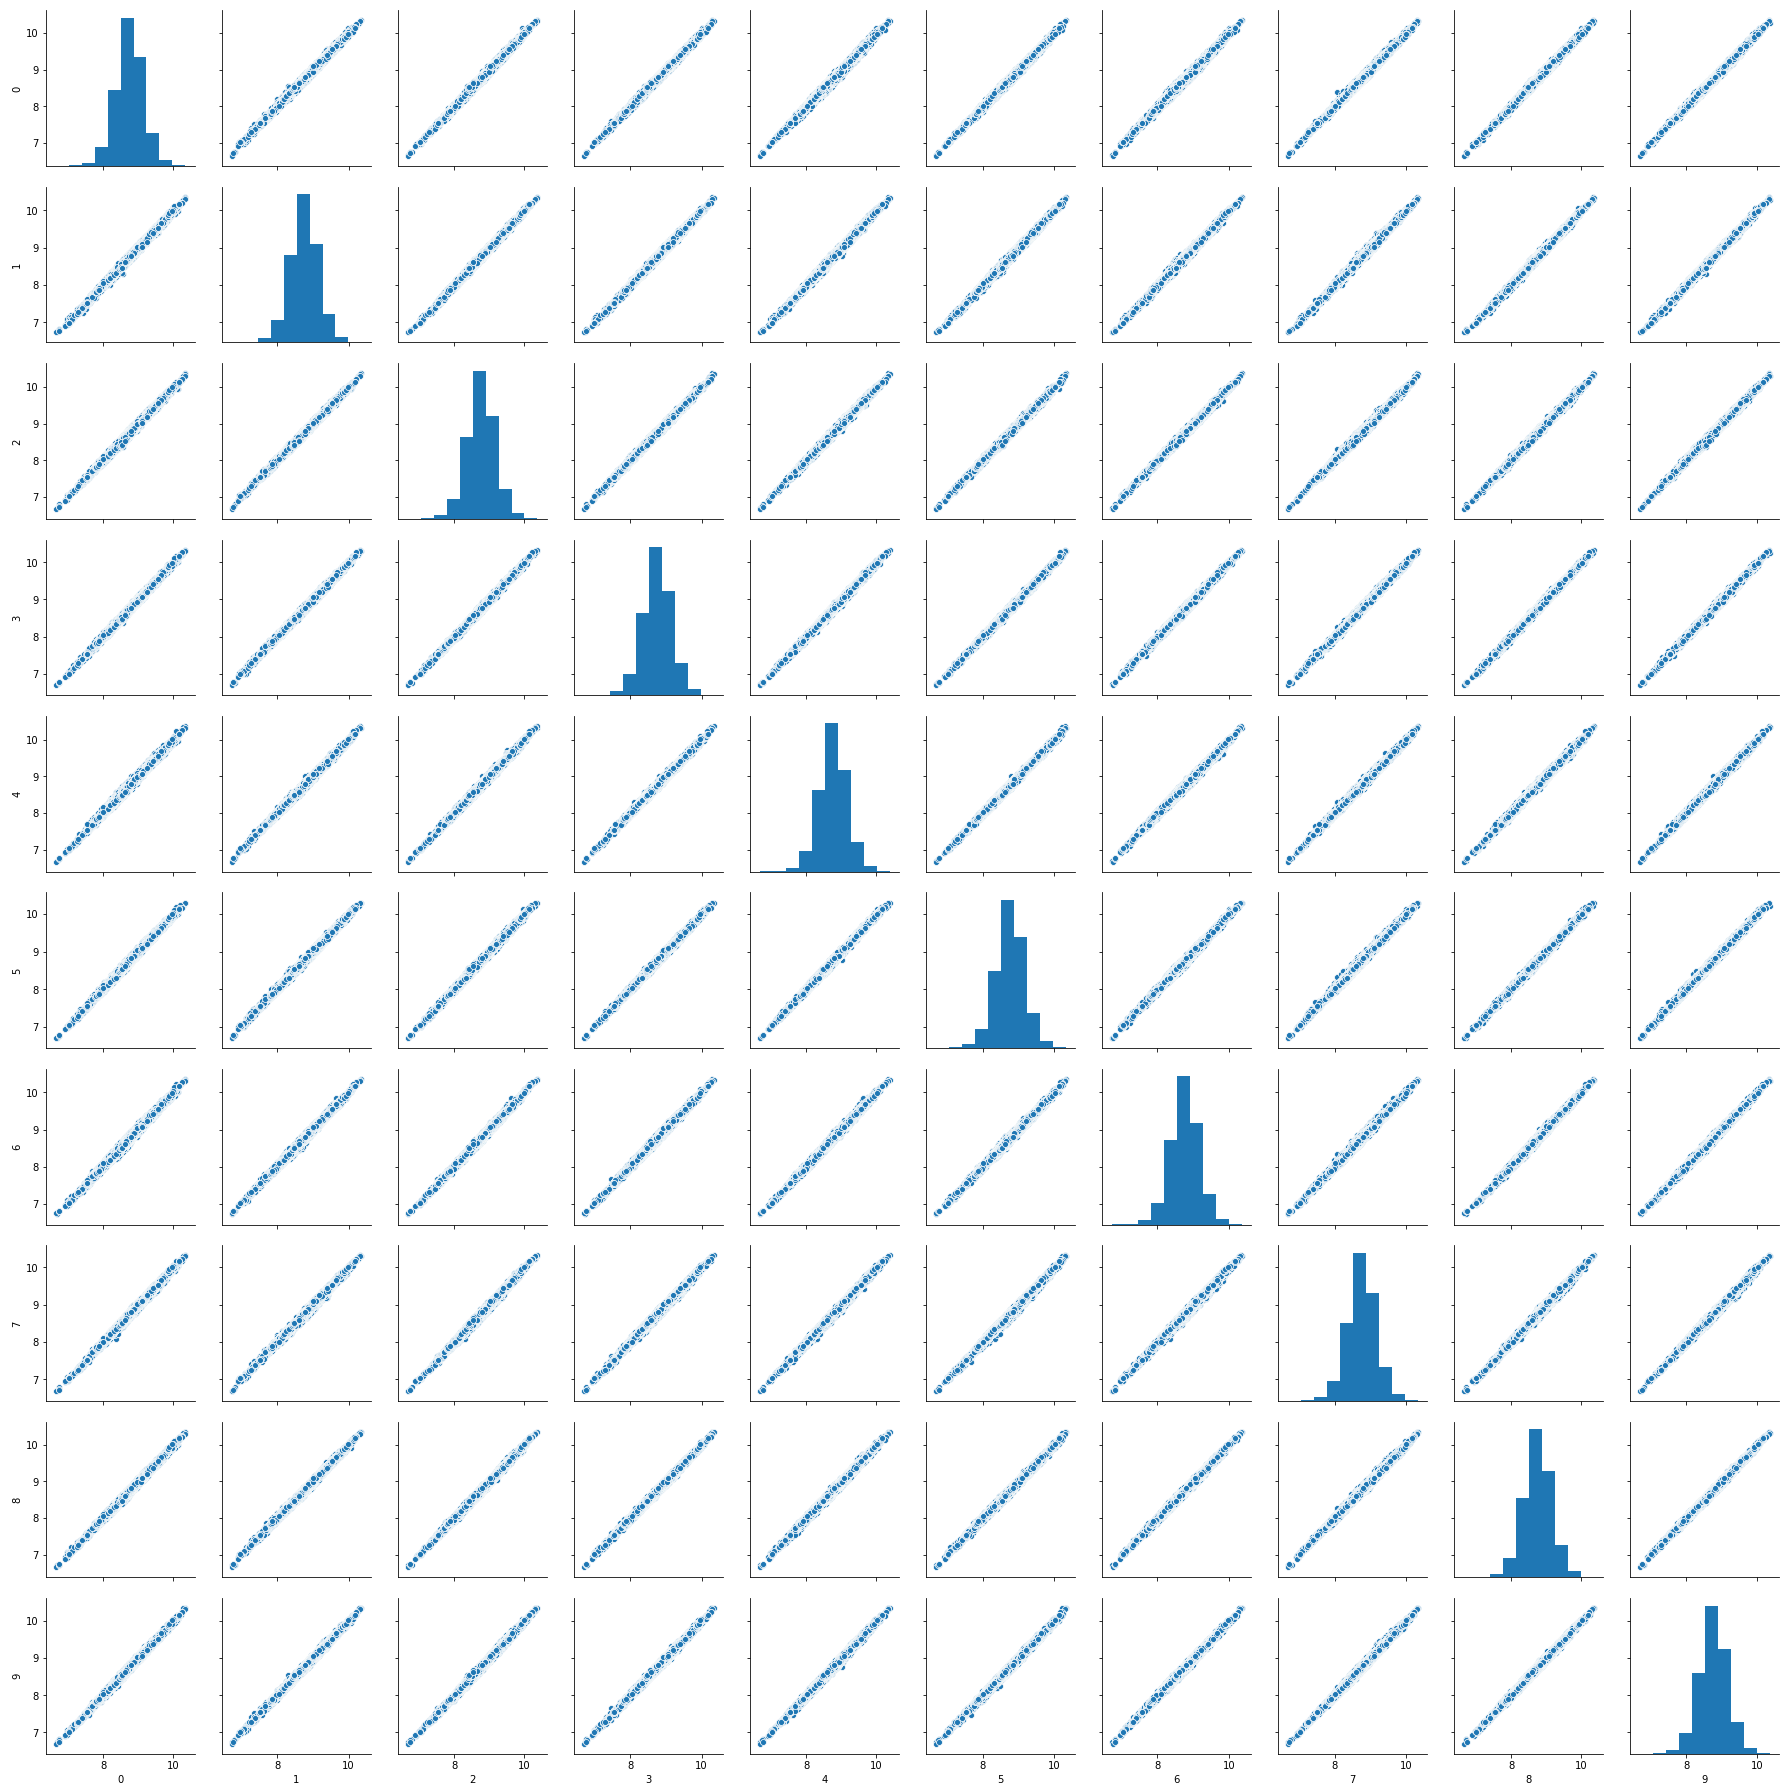

In [59]:
#分析不同模型的相关性
preds = pd.DataFrame(preds_ho)
sns.pairplot(preds)



#模型融合可以采用简单平均或者加权重的方法进行融合。从上图来看，这10个模型相关性很高，差别不大，所以权重融合我们只考虑训练中单独模型在hold-out模型中的得分情况分配权重。
 


In [60]:
#模型融合在hold-out数据集上的表现
 
#简单平均融合
print ('Validating')
 
bagged_ho_preds1 = preds_ho.mean(axis = 1)
error1 = rmspe(np.expm1(ho_ytest), np.expm1(bagged_ho_preds1))
print('RMSPE for mean: {:.6f}'.format(error1))

Validating
RMSPE for mean: 0.113798


In [61]:
#加权融合
R = range(10)   
Mw = [0.20,0.20,0.10,0.10,0.10,0.10,0.10,0.10,0.00,0.00] 
A = pd.DataFrame()
A['round']=R
A['best_score']=B
A.sort_values(['best_score'],inplace = True)
A['weight']=Mw
A.sort_values(['round'],inplace = True)
weight=np.array(A['weight'])
preds_ho_w=weight*preds_ho
bagged_ho_preds2 = preds_ho_w.sum(axis = 1)
error2 = rmspe(np.expm1(ho_ytest), np.expm1(bagged_ho_preds2))
print('RMSPE for weight: {:.6f}'.format(error2))

RMSPE for weight: 0.112982


权重模型较均值模型有比较好的得分

In [62]:
##用均值融合和加权融合后的模型对训练数据集进行预测
#均值融合
print("Make predictions on the test set")
bagged_preds = preds_test.mean(axis = 1)
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(bagged_preds)})
result.to_csv("Rossmann_submission_4.csv", index=False)
#加权融合
bagged_preds = (preds_test*weight).sum(axis = 1)
result = pd.DataFrame({"Id": test['Id'], 'Sales': np.expm1(bagged_preds)})
result.to_csv("Rossmann_submission_5.csv", index=False)

Make predictions on the test set


8.模型特征重要性及最佳模型结果分析

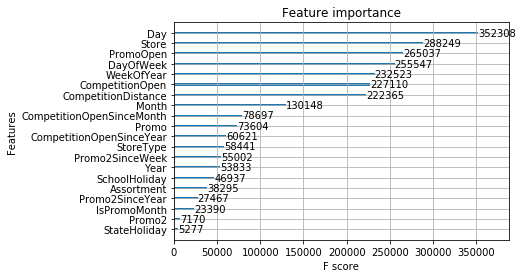

In [63]:
#模型特征重要性
xgb.plot_importance(gbm)
 
 
# - 从模型特征重要性分析，比较重要的特征有四类包括1.周期性特征'Day'，'DayOfWeek'，'WeekOfYera'，'Month'等，可见店铺的销售额与时间是息息相关的，尤其是周期较短的时间特征；2.店铺差异'Store'和'StoreTyp'特征，不同店铺的销售额存在特异性；3.短期促销（Promo)情况:'PromoOpen'和'Promo'特征，促销时间的长短与营业额相关性比较大；4.竞争对手相关特征包括：'CompetitionOpen'，‘CompetitionDistance'，'CompetitionOpenSinceMoth'以及'CompetitionOpenScinceyear'，竞争者的距离与营业年限对销售额有影响。
# - 作用不大的特征主要两类包括：1.假期特征：'SchoolHoliday'和'StateHoliday'，假期对销售额影响不大，有可能是假期店铺大多不营业，对模型预测没有太大帮助。2.持续促销(Promo2)相关的特征：'Promo2'，'Prom2SinceYear'以及'Prom2SinceWeek'等特征，有可能持续的促销活动对短期的销售额影响有限。


In [64]:
#采用新的权值融合模型构建保留数据集预测结果
res1 = pd.DataFrame(data = ho_ytest)
res1['Prediction']=bagged_ho_preds2
res1 = pd.merge(ho_xtest,res1, left_index= True, right_index=True)
res1['Ratio'] = res1.Prediction/res.Sales
res1['Error'] =abs(res1.Ratio-1)
res1.head()


Store  DayOfWeek  Promo  StateHoliday  SchoolHoliday  StoreType  \
0      1          4      1             0              1          3   
1      1          3      1             0              1          3   
2      1          2      1             0              1          3   
3      1          1      1             0              1          3   
4      1          0      1             0              1          3   

   Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0           1               1270.0                        9.0   
1           1               1270.0                        9.0   
2           1               1270.0                        9.0   
3           1               1270.0                        9.0   
4           1               1270.0                        9.0   

   CompetitionOpenSinceYear  ...  Month  Day  WeekOfYear  CompetitionOpen  \
0                    2008.0  ...      7   31          31             82.0   
1                    2008.0  ...      7   30          31             82.0   
2                    2008.0  ...      7   29          31             82.0   
3                    2008.0  ...      7   28          31             82.0   
4                    2008.0  ...      7   27          31             82.0   

   PromoOpen  IsPromoMonth     Sales  Prediction     Ratio     Error  
0   24187.75             0  8.568646    8.547775  0.997564  0.002436  
1   24187.75             0  8.521384    8.500261  0.997521  0.002479  
2   24187.75             0  8.472823    8.430232  0.994973  0.005027  
3   24187.75             0  8.519590    8.435021  0.990074  0.009926  
4   24187.75             0  8.716536    8.555671  0.981545  0.018455  

[5 rows x 24 columns]

In [65]:
#分析偏差最大的10个预测结果与初始模型差异
res1.sort_values(['Error'],ascending=False,inplace= True)
res['Store_new'] = res1['Store']
res['Error_new'] = res1['Error']
res['Ratio_new'] = res1['Ratio']
col_3 = ['Store','Ratio','Error','Store_new','Ratio_new','Error_new']
com = pd.DataFrame(res,columns = col_3)
com[:10]
 
 
# - 从新旧模型预测结果最大的几个偏差对比的情况来看，最终的融合模型在这几个预测值上大多有所提升，证明模型的校正和融合确实有效。


Store     Ratio     Error  Store_new  Ratio_new  Error_new
264207    292  1.235983  0.235983        292   1.221274   0.221274
711449    782  1.184041  0.184041        782   1.172604   0.172604
827582    909  1.167560  0.167560        909   1.155518   0.155518
827591    909  0.862041  0.137959        909   0.852097   0.147903
797965    876  0.867589  0.132411        876   0.853161   0.146839
264218    292  0.879444  0.120556        292   0.871383   0.128617
264213    292  1.120542  0.120542        292   1.111659   0.111659
797963    876  0.880855  0.119145        876   0.873200   0.126800
711448    782  1.113012  0.113012        782   1.102314   0.102314
456286    501  1.112082  0.112082        501   1.096999   0.096999

In [ ]:
m